## Trial-level early stopping in Ax

This tutorial illustrates how to add a trial-level early stopping strategy to an Ax HPO loop. The goal of trial-level early stopping is to monitor the results of expensive evaluations and terminate those that are unlikely to produce promising results, freeing up resources to explore more configurations.

Most of this tutorial is adapted from the [PyTorch Ax Multiobjective NAS Tutorial](https://pytorch.org/tutorials/intermediate/ax_multiobjective_nas_tutorial.html). The training job is different from the original in that we do not optimize `batch_size` or `epochs`. This was done for illustrative purposes, as each validation curve now has the same number of points. The companion training file `mnist_train_nas.py` has also been altered to log to Tensorboard during training.

NOTE: Although the original NAS tutorial is for a multi-objective problem, this tutorial focuses on a single objective (validation accuracy) problem. Early stopping currently does not support \"true\" multi-objective stopping, although one can use [logical compositions of early stopping strategies](https://github.com/facebook/Ax/blob/main/ax/early_stopping/strategies/logical.py) to target multiple objectives separately. Early stopping for the multi-objective case is currently work-in-progress.

In [1]:
import tempfile

from pathlib import Path

import torch

import torchx

from ax.core import Experiment, Objective, ParameterType, RangeParameter, SearchSpace
from ax.core.optimization_config import OptimizationConfig

from ax.early_stopping.strategies import PercentileEarlyStoppingStrategy
from ax.metrics.tensorboard import TensorboardCurveMetric

from ax.modelbridge.dispatch_utils import choose_generation_strategy

from ax.runners.torchx import TorchXRunner

from ax.service.scheduler import Scheduler, SchedulerOptions
from ax.service.utils.report_utils import exp_to_df

from torchx import specs
from torchx.components import utils

from matplotlib import pyplot as plt
%matplotlib inline

## Defining the TorchX App

Our goal is to optimize the PyTorch Lightning training job defined in
[mnist_train_nas.py](https://github.com/pytorch/tutorials/tree/master/intermediate_source/mnist_train_nas.py)_.
To do this using TorchX, we write a helper function that takes in
the values of the architcture and hyperparameters of the training
job and creates a [TorchX AppDef](https://pytorch.org/torchx/latest/basics.html)_
with the appropriate settings.



In [2]:
def trainer(
    log_path: str,
    hidden_size_1: int,
    hidden_size_2: int,
    learning_rate: float,
    dropout: float,
    trial_idx: int = -1,
) -> specs.AppDef:

    # define the log path so we can pass it to the TorchX AppDef
    if trial_idx >= 0:
        log_path = Path(log_path).joinpath(str(trial_idx)).absolute().as_posix()
    
    epochs = 10
    batch_size = 32
    
    return utils.python(
        # command line args to the training script
        "--log_path",
        log_path,
        "--hidden_size_1",
        str(hidden_size_1),
        "--hidden_size_2",
        str(hidden_size_2),
        "--learning_rate",
        str(learning_rate),
        "--epochs",
        str(epochs),
        "--dropout",
        str(dropout),
        "--batch_size",
        str(batch_size),
        # other config options
        name="trainer",
        script="mnist_train_nas.py",
        image=torchx.version.TORCHX_IMAGE,
    )

## Setting up the Runner

Ax’s [Runner](https://ax.dev/api/core.html#ax.core.runner.Runner)
abstraction allows writing interfaces to various backends.
Ax already comes with Runner for TorchX, and so we just need to
configure it. For the purpose of this tutorial we run jobs locally
in a fully asynchronous fashion. In order to launch them on a cluster, you can instead specify a
different TorchX scheduler and adjust the configuration appropriately.
For example, if you have a Kubernetes cluster, you just need to change the
scheduler from ``local_cwd`` to ``kubernetes``).

The training job launched by this runner will log partial results to Tensorboard, which will then be monitored by the early stopping strategy. We will show how this is done using an Ax 
[TensorboardCurveMetric](https://ax.dev/api/metrics.html#module-ax.metrics.tensorboard) below.

In [3]:
# Make a temporary dir to log our results into
log_dir = tempfile.mkdtemp()

ax_runner = TorchXRunner(
    tracker_base="/tmp/",
    component=trainer,
    # NOTE: To launch this job on a cluster instead of locally you can
    # specify a different scheduler and adjust args appropriately.
    scheduler="local_cwd",
    component_const_params={"log_path": log_dir},
    cfg={},
)

## Setting up the SearchSpace

First, we define our search space. Ax supports both range parameters
of type integer and float as well as choice parameters which can have
non-numerical types such as strings.
We will tune the hidden sizes, learning rate, and dropout parameters.

In [4]:
parameters = [
    # NOTE: In a real-world setting, hidden_size_1 and hidden_size_2
    # should probably be powers of 2, but in our simple example this
    # would mean that num_params can't take on that many values, which
    # in turn makes the Pareto frontier look pretty weird.
    RangeParameter(
        name="hidden_size_1",
        lower=16,
        upper=128,
        parameter_type=ParameterType.INT,
        log_scale=True,
    ),
    RangeParameter(
        name="hidden_size_2",
        lower=16,
        upper=128,
        parameter_type=ParameterType.INT,
        log_scale=True,
    ),
    RangeParameter(
        name="learning_rate",
        lower=1e-4,
        upper=1e-2,
        parameter_type=ParameterType.FLOAT,
        log_scale=True,
    ),
    RangeParameter(
        name="dropout",
        lower=0.0,
        upper=0.5,
        parameter_type=ParameterType.FLOAT,
    ),
]

search_space = SearchSpace(
    parameters=parameters,
    # NOTE: In practice, it may make sense to add a constraint
    # hidden_size_2 <= hidden_size_1
    parameter_constraints=[],
)

## Setting up Metrics

Ax has the concept of a Metric that defines properties of outcomes and how observations are obtained for these outcomes. This allows e.g. encodig how data is fetched from some distributed execution backend and post-processed before being passed as input to Ax.

We will optimize the validation accuracy, which is a `TensorboardCurveMetric` that points to the logging directory assigned above. Note that we have set `is_available_while_running`, allowing for the metric to be queried as the trial progresses. This is critical for the early stopping strategy to monitor partial results.

In [5]:
class MyTensorboardMetric(TensorboardCurveMetric):

    # NOTE: We need to tell the new Tensorboard metric how to get the id /
    # file handle for the tensorboard logs from a trial. In this case
    # our convention is to just save a separate file per trial in
    # the pre-specified log dir.
    @classmethod
    def get_ids_from_trials(cls, trials):
        return {
            trial.index: Path(log_dir).joinpath(str(trial.index)).as_posix()
            for trial in trials
        }

    # This indicates whether the metric is queryable while the trial is
    # still running. This is required for early stopping to monitor the
    # progress of the running trial.ArithmeticError
    @classmethod
    def is_available_while_running(cls):
        return True

In [6]:
val_acc = MyTensorboardMetric(
    name="val_acc",
    curve_name="val_acc",
    lower_is_better=False,
)

## Setting up the OptimizationConfig

The `OptimizationConfig` specifies the objective for Ax to optimize.

In [7]:
opt_config = OptimizationConfig(
    objective=Objective(
        metric=val_acc,
        minimize=False,
    )
)

## Defining an Early Stopping Strategy

A `PercentileEarlyStoppingStrategy` is a simple method that stops a trial if its performance falls below a certain percentile of other trials at the same step (e.g., when `percentile_threshold` is 50, at a given point in time, if a trial ranks in the bottom 50% of trials, it is stopped). 
- We make use of `normalize_progressions` which normalizes the progression column (e.g. timestamp, epochs, training data used) to be in [0, 1]. This is useful because one doesn't need to know the maximum progression values of the curve (which might be, e.g., the total number of data points in the training dataset).
- The `min_progression` parameter specifies that trials should only be considered for stopping if the latest progression value is greater than this threshold.
- The `min_curves` parameter specifies the minimum number of completed curves (i.e., fully completed training jobs) before early stopping will be considered. This should be larger than zero if `normalize_progression` is used. In general, we want a few completed curves to have a baseline for comparison.

Note that `PercentileEarlyStoppingStrategy` does not make use of learning curve modeling or prediction. More sophisticated model-based methods will be available in future versions of Ax.

In [8]:
percentile_early_stopping_strategy = PercentileEarlyStoppingStrategy(
    # stop if in bottom 70% of runs at the same progression
    percentile_threshold=70,
    # the trial must have passed `min_progression` steps before early stopping is initiated
    # note that we are using `normalize_progressions`, so this is on a scale of [0, 1]
    min_progression=0.3,
    # there must be `min_curves` completed trials and `min_curves` trials reporting data in
    # order for early stopping to be applicable
    min_curves=5,
    # specify, e.g., [0, 1] if the first two trials should never be stopped
    trial_indices_to_ignore=None,
    # check for new data every 10 seconds
    seconds_between_polls=10,
    normalize_progressions=True,
)

## Creating the Ax Experiment

In Ax, the Experiment object is the object that stores all the information about the problem setup.

In [9]:
experiment = Experiment(
    name="torchx_mnist",
    search_space=search_space,
    optimization_config=opt_config,
    runner=ax_runner,
)

## Choosing the GenerationStrategy

A [GenerationStrategy](https://ax.dev/api/modelbridge.html#ax.modelbridge.generation_strategy.GenerationStrategy)
is the abstract representation of how we would like to perform the
optimization. While this can be customized (if you’d like to do so, see
[this tutorial](https://ax.dev/tutorials/generation_strategy.html)),
in most cases Ax can automatically determine an appropriate strategy
based on the search space, optimization config, and the total number
of trials we want to run.

Typically, Ax chooses to evaluate a number of random configurations
before starting a model-based Bayesian Optimization strategy.

We remark that in Ax, generation strategies and early stopping strategies are separate, a design decision motivated by ease-of-use. However, we should acknowledge that jointly considering generation and stopping using a single strategy would likely be the "proper" formulation.

In [10]:
total_trials = 15  # total evaluation budget

gs = choose_generation_strategy(
    search_space=experiment.search_space,
    optimization_config=experiment.optimization_config,
    num_trials=total_trials,
  )

[INFO 11-01 07:07:40] ax.modelbridge.dispatch_utils: Using Bayesian optimization since there are more ordered parameters than there are categories for the unordered categorical parameters.


[INFO 11-01 07:07:40] ax.modelbridge.dispatch_utils: Using Bayesian Optimization generation strategy: GenerationStrategy(name='Sobol+GPEI', steps=[Sobol for 5 trials, GPEI for subsequent trials]). Iterations after 5 will take longer to generate due to  model-fitting.


## Configuring the Scheduler

The `Scheduler` acts as the loop control for the optimization.
It communicates with the backend to launch trials, check their status, retrieve (partial) results, and importantly for this tutorial, calls the early stopping strategy. If the early stopping strategy suggests a trial to be the stopped, the `Scheduler` communicates with the backend to terminate the trial.

The ``Scheduler`` requires the ``Experiment`` and the ``GenerationStrategy``.
A set of options can be passed in via ``SchedulerOptions``. Here, we
configure the number of total evaluations as well as ``max_pending_trials``,
the maximum number of trials that should run concurrently. In our
local setting, this is the number of training jobs running as individual
processes, while in a remote execution setting, this would be the number
of machines you want to use in parallel.


In [11]:
scheduler = Scheduler(
    experiment=experiment,
    generation_strategy=gs,
    options=SchedulerOptions(
        total_trials=total_trials, max_pending_trials=5, early_stopping_strategy=percentile_early_stopping_strategy
    ),
)

[INFO 11-01 07:07:40] Scheduler: `Scheduler` requires experiment to have immutable search space and optimization config. Setting property immutable_search_space_and_opt_config to `True` on experiment.


In [12]:
scheduler.run_all_trials()

/home/runner/work/Ax/Ax/ax/core/observation.py:274: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for g, d in df.groupby(by=cols):
[INFO 11-01 07:07:40] Scheduler: Running trials [0]...


/home/runner/work/Ax/Ax/ax/core/observation.py:274: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for g, d in df.groupby(by=cols):
[INFO 11-01 07:07:41] Scheduler: Running trials [1]...


/home/runner/work/Ax/Ax/ax/core/observation.py:274: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for g, d in df.groupby(by=cols):
[INFO 11-01 07:07:42] Scheduler: Running trials [2]...


/home/runner/work/Ax/Ax/ax/core/observation.py:274: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for g, d in df.groupby(by=cols):
[INFO 11-01 07:07:43] Scheduler: Running trials [3]...


/home/runner/work/Ax/Ax/ax/core/observation.py:274: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for g, d in df.groupby(by=cols):
[INFO 11-01 07:07:44] Scheduler: Running trials [4]...


[WARNING 11-01 07:07:45] Scheduler: Both `init_seconds_between_polls` and `early_stopping_strategy supplied. `init_seconds_between_polls=1` will be overrridden by `early_stopping_strategy.seconds_between_polls=10` and polling will take place at a constant rate.


[INFO 11-01 07:07:45] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:07:45] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/0. Returning without this metric.


[INFO 11-01 07:07:45] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/1. Returning without this metric.


[INFO 11-01 07:07:45] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/2. Returning without this metric.


[INFO 11-01 07:07:45] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/3. Returning without this metric.


[INFO 11-01 07:07:45] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/4. Returning without this metric.


[INFO 11-01 07:07:45] ax.early_stopping.strategies.base: PercentileEarlyStoppingStrategy received empty data. Not stopping any trials.


[INFO 11-01 07:07:45] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:07:55] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:07:55] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/0. Returning without this metric.


[INFO 11-01 07:07:55] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/1. Returning without this metric.


[INFO 11-01 07:07:55] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/2. Returning without this metric.


[INFO 11-01 07:07:55] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/3. Returning without this metric.


[INFO 11-01 07:07:55] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/4. Returning without this metric.


[INFO 11-01 07:07:55] ax.early_stopping.strategies.base: PercentileEarlyStoppingStrategy received empty data. Not stopping any trials.


[INFO 11-01 07:07:55] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:08:05] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:08:05] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/0. Returning without this metric.


[INFO 11-01 07:08:05] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/1. Returning without this metric.


[INFO 11-01 07:08:05] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/2. Returning without this metric.


[INFO 11-01 07:08:05] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/3. Returning without this metric.


[INFO 11-01 07:08:05] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/4. Returning without this metric.


[INFO 11-01 07:08:05] ax.early_stopping.strategies.base: PercentileEarlyStoppingStrategy received empty data. Not stopping any trials.


[INFO 11-01 07:08:05] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:08:15] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:08:15] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/0. Returning without this metric.


[INFO 11-01 07:08:15] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/1. Returning without this metric.


[INFO 11-01 07:08:15] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/2. Returning without this metric.


[INFO 11-01 07:08:15] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/3. Returning without this metric.


[INFO 11-01 07:08:15] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/4. Returning without this metric.


[INFO 11-01 07:08:15] ax.early_stopping.strategies.base: PercentileEarlyStoppingStrategy received empty data. Not stopping any trials.


[INFO 11-01 07:08:15] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:08:25] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:08:25] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/0. Returning without this metric.


[INFO 11-01 07:08:25] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/1. Returning without this metric.


[INFO 11-01 07:08:25] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/2. Returning without this metric.


[INFO 11-01 07:08:25] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/3. Returning without this metric.


[INFO 11-01 07:08:25] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/4. Returning without this metric.


[INFO 11-01 07:08:25] ax.early_stopping.strategies.base: PercentileEarlyStoppingStrategy received empty data. Not stopping any trials.


[INFO 11-01 07:08:25] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:08:35] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:08:35] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/0. Returning without this metric.


[INFO 11-01 07:08:35] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/1. Returning without this metric.


[INFO 11-01 07:08:35] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/2. Returning without this metric.


[INFO 11-01 07:08:35] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/3. Returning without this metric.


[INFO 11-01 07:08:35] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/4. Returning without this metric.


[INFO 11-01 07:08:35] ax.early_stopping.strategies.base: PercentileEarlyStoppingStrategy received empty data. Not stopping any trials.


[INFO 11-01 07:08:35] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:08:45] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:08:45] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/0. Returning without this metric.


[INFO 11-01 07:08:45] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/1. Returning without this metric.


[INFO 11-01 07:08:45] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/2. Returning without this metric.


[INFO 11-01 07:08:45] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/3. Returning without this metric.


[INFO 11-01 07:08:45] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/4. Returning without this metric.


[INFO 11-01 07:08:46] ax.early_stopping.strategies.base: PercentileEarlyStoppingStrategy received empty data. Not stopping any trials.


[INFO 11-01 07:08:46] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:08:56] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:08:56] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/0. Returning without this metric.


[INFO 11-01 07:08:56] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/1. Returning without this metric.


[INFO 11-01 07:08:56] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/2. Returning without this metric.


[INFO 11-01 07:08:56] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/3. Returning without this metric.


[INFO 11-01 07:08:56] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/4. Returning without this metric.


[INFO 11-01 07:08:56] ax.early_stopping.strategies.base: PercentileEarlyStoppingStrategy received empty data. Not stopping any trials.


[INFO 11-01 07:08:56] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:09:06] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:09:06] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/0. Returning without this metric.


[INFO 11-01 07:09:06] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/1. Returning without this metric.


[INFO 11-01 07:09:06] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/2. Returning without this metric.


[INFO 11-01 07:09:06] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/3. Returning without this metric.


[INFO 11-01 07:09:06] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/4. Returning without this metric.


[INFO 11-01 07:09:06] ax.early_stopping.strategies.base: PercentileEarlyStoppingStrategy received empty data. Not stopping any trials.


[INFO 11-01 07:09:06] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:09:16] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:09:16] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/0. Returning without this metric.


[INFO 11-01 07:09:16] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/1. Returning without this metric.


[INFO 11-01 07:09:16] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/2. Returning without this metric.


[INFO 11-01 07:09:16] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/3. Returning without this metric.


[INFO 11-01 07:09:16] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/4. Returning without this metric.


[INFO 11-01 07:09:16] ax.early_stopping.strategies.base: PercentileEarlyStoppingStrategy received empty data. Not stopping any trials.


[INFO 11-01 07:09:16] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:09:26] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:09:26] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/0. Returning without this metric.


[INFO 11-01 07:09:26] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/1. Returning without this metric.


[INFO 11-01 07:09:26] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/2. Returning without this metric.


[INFO 11-01 07:09:26] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/3. Returning without this metric.


[INFO 11-01 07:09:26] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/4. Returning without this metric.


[INFO 11-01 07:09:26] ax.early_stopping.strategies.base: PercentileEarlyStoppingStrategy received empty data. Not stopping any trials.


[INFO 11-01 07:09:26] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:09:36] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:09:36] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/0. Returning without this metric.


[INFO 11-01 07:09:36] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/1. Returning without this metric.


[INFO 11-01 07:09:36] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/2. Returning without this metric.


[INFO 11-01 07:09:36] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/3. Returning without this metric.


[INFO 11-01 07:09:36] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/4. Returning without this metric.


[INFO 11-01 07:09:36] ax.early_stopping.strategies.base: PercentileEarlyStoppingStrategy received empty data. Not stopping any trials.


[INFO 11-01 07:09:36] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:09:46] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:09:46] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/0. Returning without this metric.


[INFO 11-01 07:09:46] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/1. Returning without this metric.


[INFO 11-01 07:09:46] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/2. Returning without this metric.


[INFO 11-01 07:09:46] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/3. Returning without this metric.


[INFO 11-01 07:09:46] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/4. Returning without this metric.


[INFO 11-01 07:09:46] ax.early_stopping.strategies.base: PercentileEarlyStoppingStrategy received empty data. Not stopping any trials.


[INFO 11-01 07:09:46] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:09:56] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:09:56] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/1. Returning without this metric.


[INFO 11-01 07:09:56] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/2. Returning without this metric.


[INFO 11-01 07:09:56] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/3. Returning without this metric.


[INFO 11-01 07:09:56] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:09:57] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:10:07] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:10:07] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/1. Returning without this metric.


[INFO 11-01 07:10:07] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/3. Returning without this metric.


[INFO 11-01 07:10:07] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:10:07] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:10:17] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:10:17] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/1. Returning without this metric.


[INFO 11-01 07:10:17] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/3. Returning without this metric.


[INFO 11-01 07:10:17] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:10:17] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:10:27] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:10:27] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/1. Returning without this metric.


[INFO 11-01 07:10:27] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/3. Returning without this metric.


[INFO 11-01 07:10:27] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:10:28] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:10:38] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:10:38] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/1. Returning without this metric.


[INFO 11-01 07:10:38] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/3. Returning without this metric.


[INFO 11-01 07:10:38] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:10:38] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:10:48] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:10:48] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/1. Returning without this metric.


[INFO 11-01 07:10:48] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/3. Returning without this metric.


[INFO 11-01 07:10:48] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:10:48] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:10:58] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:10:58] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/1. Returning without this metric.


[INFO 11-01 07:10:58] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/3. Returning without this metric.


[INFO 11-01 07:10:58] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:10:58] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:11:08] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:11:09] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/3. Returning without this metric.


[INFO 11-01 07:11:09] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:11:09] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:11:19] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:11:19] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:11:19] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:11:29] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:11:29] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:11:30] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:11:40] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:11:40] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:11:40] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:11:50] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:11:50] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:11:50] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:12:00] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:12:01] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:12:01] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:12:11] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:12:11] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:12:11] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:12:21] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:12:21] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:12:21] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:12:31] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:12:32] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:12:32] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:12:42] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:12:42] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:12:42] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:12:52] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:12:53] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:12:53] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:13:03] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:13:03] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:13:03] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:13:13] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:13:13] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:13:13] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:13:23] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:13:24] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:13:24] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:13:34] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:13:34] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:13:34] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:13:44] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:13:44] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:13:44] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:13:54] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:13:55] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:13:55] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:14:05] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:14:05] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:14:05] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:14:15] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:14:16] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:14:16] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:14:26] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:14:26] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:14:26] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:14:36] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:14:36] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:14:36] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:14:46] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:14:47] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:14:47] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:14:57] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:14:57] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:14:57] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:15:07] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:15:08] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:15:08] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:15:18] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:15:18] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:15:18] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:15:28] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:15:28] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:15:28] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:15:38] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:15:39] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:15:39] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:15:49] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:15:49] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:15:49] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:15:59] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:15:59] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:15:59] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:16:09] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:16:10] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:16:10] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:16:20] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:16:20] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:16:20] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:16:30] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:16:31] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:16:31] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:16:41] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:16:41] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:16:41] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:16:51] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:16:51] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:16:51] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:17:01] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:17:02] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:17:02] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:17:12] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:17:12] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:17:12] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:17:22] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:17:23] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:17:23] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:17:33] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:17:33] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:17:33] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:17:43] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:17:43] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:17:43] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:17:53] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:17:54] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:17:54] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:18:04] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:18:04] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:18:04] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:18:14] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:18:14] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:18:14] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:18:25] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:18:25] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:18:25] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:18:35] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:18:35] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:18:35] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:18:45] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:18:46] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:18:46] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:18:56] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:18:56] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:18:56] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:19:06] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:19:06] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:19:06] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:19:16] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:19:17] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:19:17] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:19:27] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:19:27] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:19:27] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:19:37] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:19:38] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:19:38] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:19:48] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:19:48] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:19:48] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:19:58] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:19:58] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:19:58] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:20:08] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:20:09] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:20:09] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:20:19] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:20:19] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:20:19] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:20:29] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:20:30] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:20:30] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:20:40] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:20:40] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:20:40] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:20:50] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:20:50] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:20:50] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:21:00] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:21:01] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:21:01] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:21:11] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:21:11] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:21:11] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:21:21] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:21:22] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:21:22] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:21:32] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:21:32] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:21:32] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:21:42] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:21:42] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:21:42] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:21:53] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:21:53] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:21:53] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:22:03] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:22:03] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:22:03] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:22:13] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:22:14] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:22:14] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:22:24] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:22:24] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:22:24] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:22:34] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:22:35] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:22:35] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:22:45] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:22:45] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:22:45] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:22:55] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:22:55] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:22:55] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:23:05] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:23:06] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:23:06] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:23:16] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:23:16] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:23:16] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:23:26] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:23:27] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[WARNING 11-01 07:23:27] Scheduler: Both `init_seconds_between_polls` and `early_stopping_strategy supplied. `init_seconds_between_polls=1` will be overrridden by `early_stopping_strategy.seconds_between_polls=10` and polling will take place at a constant rate.


[INFO 11-01 07:23:27] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:23:27] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:23:27] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:23:37] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:23:37] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:23:37] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:23:47] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:23:48] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:23:48] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:23:58] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:23:58] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:23:58] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:24:08] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:24:09] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:24:09] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:24:19] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:24:19] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:24:19] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:24:29] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:24:29] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:24:29] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:24:39] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:24:40] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:24:40] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:24:50] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:24:50] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:24:50] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:25:00] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:25:01] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:25:01] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:25:11] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:25:11] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:25:11] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:25:21] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:25:21] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:25:21] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:25:31] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:25:32] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:25:32] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:25:42] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:25:42] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:25:42] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:25:52] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:25:53] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:25:53] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:26:03] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:26:03] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:26:03] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:26:13] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:26:14] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:26:14] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:26:24] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:26:24] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:26:24] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:26:34] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:26:34] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:26:34] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:26:44] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:26:45] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:26:45] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:26:55] Scheduler: Fetching data for trials: 0 - 4 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:26:55] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:26:55] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:27:05] Scheduler: Fetching data for trials: 1 - 4 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:27:06] ax.early_stopping.strategies.base: The number of completed trials (0) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:27:06] Scheduler: Retrieved COMPLETED trials: [0].


[INFO 11-01 07:27:06] Scheduler: Fetching data for trials: [0].


[WARNING 11-01 07:27:06] Scheduler: Both `init_seconds_between_polls` and `early_stopping_strategy supplied. `init_seconds_between_polls=1` will be overrridden by `early_stopping_strategy.seconds_between_polls=10` and polling will take place at a constant rate.


[INFO 11-01 07:27:06] Scheduler: Fetching data for trials: 1 - 4 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:27:06] ax.early_stopping.strategies.base: The number of completed trials (1) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:27:06] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 4).


[INFO 11-01 07:27:16] Scheduler: Fetching data for trials: 1 - 4 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:27:16] ax.early_stopping.strategies.base: The number of completed trials (1) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:27:16] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 4).


[INFO 11-01 07:27:26] Scheduler: Fetching data for trials: 1 - 4 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:27:26] ax.early_stopping.strategies.base: The number of completed trials (1) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:27:26] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 4).


[INFO 11-01 07:27:36] Scheduler: Fetching data for trials: 1 - 3 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:27:37] ax.early_stopping.strategies.base: The number of completed trials (1) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:27:37] Scheduler: Retrieved COMPLETED trials: [4].


[INFO 11-01 07:27:37] Scheduler: Fetching data for trials: [4].


[WARNING 11-01 07:27:37] Scheduler: Both `init_seconds_between_polls` and `early_stopping_strategy supplied. `init_seconds_between_polls=1` will be overrridden by `early_stopping_strategy.seconds_between_polls=10` and polling will take place at a constant rate.


[INFO 11-01 07:27:37] Scheduler: Fetching data for trials: 1 - 3 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:27:37] ax.early_stopping.strategies.base: The number of completed trials (2) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:27:37] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 07:27:47] Scheduler: Fetching data for trials: 1 - 3 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:27:47] ax.early_stopping.strategies.base: The number of completed trials (2) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:27:47] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 07:27:57] Scheduler: Fetching data for trials: 1 - 3 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:27:57] ax.early_stopping.strategies.base: The number of completed trials (2) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:27:57] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 07:28:07] Scheduler: Fetching data for trials: 1 - 3 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:28:08] ax.early_stopping.strategies.base: The number of completed trials (2) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:28:08] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 07:28:18] Scheduler: Fetching data for trials: [1, 3] because some metrics on experiment are available while trials are running.


[INFO 11-01 07:28:18] ax.early_stopping.strategies.base: The number of completed trials (2) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:28:18] Scheduler: Retrieved COMPLETED trials: [2].


[INFO 11-01 07:28:18] Scheduler: Fetching data for trials: [2].


[INFO 11-01 07:28:19] Scheduler: Running trials [5]...


[INFO 11-01 07:28:44] Scheduler: Running trials [6]...


[INFO 11-01 07:28:59] Scheduler: Running trials [7]...


[WARNING 11-01 07:29:00] Scheduler: Both `init_seconds_between_polls` and `early_stopping_strategy supplied. `init_seconds_between_polls=1` will be overrridden by `early_stopping_strategy.seconds_between_polls=10` and polling will take place at a constant rate.


[INFO 11-01 07:29:00] Scheduler: Fetching data for trials: [1, 3, 5, 6, 7] because some metrics on experiment are available while trials are running.


[INFO 11-01 07:29:00] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/5. Returning without this metric.


[INFO 11-01 07:29:00] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/6. Returning without this metric.


[INFO 11-01 07:29:00] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/7. Returning without this metric.


[INFO 11-01 07:29:01] ax.early_stopping.strategies.base: The number of completed trials (3) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:29:01] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:29:11] Scheduler: Fetching data for trials: [1, 3, 5, 6, 7] because some metrics on experiment are available while trials are running.


[INFO 11-01 07:29:11] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/5. Returning without this metric.


[INFO 11-01 07:29:11] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/6. Returning without this metric.


[INFO 11-01 07:29:11] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/7. Returning without this metric.


[INFO 11-01 07:29:11] ax.early_stopping.strategies.base: The number of completed trials (3) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:29:11] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:29:21] Scheduler: Fetching data for trials: [1, 3, 5, 6, 7] because some metrics on experiment are available while trials are running.


[INFO 11-01 07:29:21] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/5. Returning without this metric.


[INFO 11-01 07:29:21] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/6. Returning without this metric.


[INFO 11-01 07:29:21] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/7. Returning without this metric.


[INFO 11-01 07:29:21] ax.early_stopping.strategies.base: The number of completed trials (3) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:29:21] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:29:31] Scheduler: Fetching data for trials: [1, 3, 5, 6, 7] because some metrics on experiment are available while trials are running.


[INFO 11-01 07:29:31] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/5. Returning without this metric.


[INFO 11-01 07:29:31] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/6. Returning without this metric.


[INFO 11-01 07:29:31] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/7. Returning without this metric.


[INFO 11-01 07:29:31] ax.early_stopping.strategies.base: The number of completed trials (3) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:29:31] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:29:41] Scheduler: Fetching data for trials: [1, 3, 5, 6, 7] because some metrics on experiment are available while trials are running.


[INFO 11-01 07:29:41] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/5. Returning without this metric.


[INFO 11-01 07:29:41] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/6. Returning without this metric.


[INFO 11-01 07:29:41] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/7. Returning without this metric.


[INFO 11-01 07:29:42] ax.early_stopping.strategies.base: The number of completed trials (3) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:29:42] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:29:52] Scheduler: Fetching data for trials: [1, 3, 5, 6, 7] because some metrics on experiment are available while trials are running.


[INFO 11-01 07:29:52] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/5. Returning without this metric.


[INFO 11-01 07:29:52] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/6. Returning without this metric.


[INFO 11-01 07:29:52] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/7. Returning without this metric.


[INFO 11-01 07:29:52] ax.early_stopping.strategies.base: The number of completed trials (3) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:29:52] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:30:02] Scheduler: Fetching data for trials: [1, 3, 5, 6, 7] because some metrics on experiment are available while trials are running.


[INFO 11-01 07:30:02] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/5. Returning without this metric.


[INFO 11-01 07:30:02] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/6. Returning without this metric.


[INFO 11-01 07:30:02] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/7. Returning without this metric.


[INFO 11-01 07:30:02] ax.early_stopping.strategies.base: The number of completed trials (3) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:30:02] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:30:12] Scheduler: Fetching data for trials: [1, 3, 5, 6, 7] because some metrics on experiment are available while trials are running.


[INFO 11-01 07:30:12] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/5. Returning without this metric.


[INFO 11-01 07:30:12] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/6. Returning without this metric.


[INFO 11-01 07:30:12] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/7. Returning without this metric.


[INFO 11-01 07:30:12] ax.early_stopping.strategies.base: The number of completed trials (3) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:30:12] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:30:22] Scheduler: Fetching data for trials: [1, 3, 5, 6, 7] because some metrics on experiment are available while trials are running.


[INFO 11-01 07:30:23] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/5. Returning without this metric.


[INFO 11-01 07:30:23] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/6. Returning without this metric.


[INFO 11-01 07:30:23] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/7. Returning without this metric.


[INFO 11-01 07:30:23] ax.early_stopping.strategies.base: The number of completed trials (3) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:30:23] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:30:33] Scheduler: Fetching data for trials: [1, 3, 5, 6, 7] because some metrics on experiment are available while trials are running.


[INFO 11-01 07:30:33] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/5. Returning without this metric.


[INFO 11-01 07:30:33] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/6. Returning without this metric.


[INFO 11-01 07:30:33] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/7. Returning without this metric.


[INFO 11-01 07:30:33] ax.early_stopping.strategies.base: The number of completed trials (3) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:30:33] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:30:43] Scheduler: Fetching data for trials: [1, 3, 5, 6, 7] because some metrics on experiment are available while trials are running.


[INFO 11-01 07:30:43] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/5. Returning without this metric.


[INFO 11-01 07:30:43] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/6. Returning without this metric.


[INFO 11-01 07:30:43] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/7. Returning without this metric.


[INFO 11-01 07:30:43] ax.early_stopping.strategies.base: The number of completed trials (3) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:30:43] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:30:53] Scheduler: Fetching data for trials: [1, 3, 5, 6, 7] because some metrics on experiment are available while trials are running.


[INFO 11-01 07:30:53] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/5. Returning without this metric.


[INFO 11-01 07:30:53] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/6. Returning without this metric.


[INFO 11-01 07:30:53] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/7. Returning without this metric.


[INFO 11-01 07:30:53] ax.early_stopping.strategies.base: The number of completed trials (3) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:30:53] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:31:03] Scheduler: Fetching data for trials: [1, 3, 5, 6, 7] because some metrics on experiment are available while trials are running.


[INFO 11-01 07:31:04] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/5. Returning without this metric.


[INFO 11-01 07:31:04] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/7. Returning without this metric.


[INFO 11-01 07:31:04] ax.early_stopping.strategies.base: The number of completed trials (3) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:31:04] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:31:14] Scheduler: Fetching data for trials: [1, 3, 5, 6, 7] because some metrics on experiment are available while trials are running.


[INFO 11-01 07:31:14] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/5. Returning without this metric.


[INFO 11-01 07:31:14] ax.early_stopping.strategies.base: The number of completed trials (3) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:31:14] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:31:24] Scheduler: Fetching data for trials: [1, 3, 5, 6, 7] because some metrics on experiment are available while trials are running.


[INFO 11-01 07:31:24] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/5. Returning without this metric.


[INFO 11-01 07:31:24] ax.early_stopping.strategies.base: The number of completed trials (3) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:31:24] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:31:34] Scheduler: Fetching data for trials: [1, 3, 5, 6, 7] because some metrics on experiment are available while trials are running.


[INFO 11-01 07:31:35] ax.early_stopping.strategies.base: The number of completed trials (3) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:31:35] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:31:45] Scheduler: Fetching data for trials: [1, 3, 5, 6, 7] because some metrics on experiment are available while trials are running.


[INFO 11-01 07:31:45] ax.early_stopping.strategies.base: The number of completed trials (3) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:31:45] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:31:55] Scheduler: Fetching data for trials: [1, 3, 5, 6, 7] because some metrics on experiment are available while trials are running.


[INFO 11-01 07:31:56] ax.early_stopping.strategies.base: The number of completed trials (3) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:31:56] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:32:06] Scheduler: Fetching data for trials: [1, 3, 5, 6, 7] because some metrics on experiment are available while trials are running.


[INFO 11-01 07:32:06] ax.early_stopping.strategies.base: The number of completed trials (3) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:32:06] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:32:16] Scheduler: Fetching data for trials: [1, 3, 5, 6, 7] because some metrics on experiment are available while trials are running.


[INFO 11-01 07:32:16] ax.early_stopping.strategies.base: The number of completed trials (3) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:32:16] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:32:26] Scheduler: Fetching data for trials: [1, 3, 5, 6, 7] because some metrics on experiment are available while trials are running.


[INFO 11-01 07:32:27] ax.early_stopping.strategies.base: The number of completed trials (3) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:32:27] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:32:37] Scheduler: Fetching data for trials: [1, 3, 5, 6, 7] because some metrics on experiment are available while trials are running.


[INFO 11-01 07:32:37] ax.early_stopping.strategies.base: The number of completed trials (3) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:32:37] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:32:47] Scheduler: Fetching data for trials: [1, 3, 5, 6, 7] because some metrics on experiment are available while trials are running.


[INFO 11-01 07:32:48] ax.early_stopping.strategies.base: The number of completed trials (3) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:32:48] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:32:58] Scheduler: Fetching data for trials: [1, 3, 5, 6, 7] because some metrics on experiment are available while trials are running.


[INFO 11-01 07:32:58] ax.early_stopping.strategies.base: The number of completed trials (3) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:32:58] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:33:08] Scheduler: Fetching data for trials: [1, 3, 5, 6, 7] because some metrics on experiment are available while trials are running.


[INFO 11-01 07:33:08] ax.early_stopping.strategies.base: The number of completed trials (3) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:33:08] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:33:18] Scheduler: Fetching data for trials: [1, 3, 5, 6, 7] because some metrics on experiment are available while trials are running.


[INFO 11-01 07:33:19] ax.early_stopping.strategies.base: The number of completed trials (3) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:33:19] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:33:29] Scheduler: Fetching data for trials: [1, 3, 5, 6, 7] because some metrics on experiment are available while trials are running.


[INFO 11-01 07:33:29] ax.early_stopping.strategies.base: The number of completed trials (3) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:33:29] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:33:39] Scheduler: Fetching data for trials: [1, 3, 5, 6, 7] because some metrics on experiment are available while trials are running.


[INFO 11-01 07:33:40] ax.early_stopping.strategies.base: The number of completed trials (3) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:33:40] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:33:50] Scheduler: Fetching data for trials: [1, 3, 5, 6, 7] because some metrics on experiment are available while trials are running.


[INFO 11-01 07:33:50] ax.early_stopping.strategies.base: The number of completed trials (3) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:33:50] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:34:00] Scheduler: Fetching data for trials: [1, 3, 5, 6, 7] because some metrics on experiment are available while trials are running.


[INFO 11-01 07:34:00] ax.early_stopping.strategies.base: The number of completed trials (3) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:34:00] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:34:10] Scheduler: Fetching data for trials: [1, 3, 5, 6, 7] because some metrics on experiment are available while trials are running.


[INFO 11-01 07:34:11] ax.early_stopping.strategies.base: The number of completed trials (3) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:34:11] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:34:21] Scheduler: Fetching data for trials: [1, 3, 5, 6, 7] because some metrics on experiment are available while trials are running.


[INFO 11-01 07:34:21] ax.early_stopping.strategies.base: The number of completed trials (3) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:34:21] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:34:31] Scheduler: Fetching data for trials: [1, 3, 5, 6, 7] because some metrics on experiment are available while trials are running.


[INFO 11-01 07:34:32] ax.early_stopping.strategies.base: The number of completed trials (3) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:34:32] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:34:42] Scheduler: Fetching data for trials: [1, 3, 5, 6, 7] because some metrics on experiment are available while trials are running.


[INFO 11-01 07:34:42] ax.early_stopping.strategies.base: The number of completed trials (3) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:34:42] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:34:52] Scheduler: Fetching data for trials: [1, 3, 5, 6, 7] because some metrics on experiment are available while trials are running.


[INFO 11-01 07:34:52] ax.early_stopping.strategies.base: The number of completed trials (3) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:34:52] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:35:02] Scheduler: Fetching data for trials: [1, 3, 5, 6, 7] because some metrics on experiment are available while trials are running.


[INFO 11-01 07:35:03] ax.early_stopping.strategies.base: The number of completed trials (3) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:35:03] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:35:13] Scheduler: Fetching data for trials: [1, 3, 5, 6, 7] because some metrics on experiment are available while trials are running.


[INFO 11-01 07:35:13] ax.early_stopping.strategies.base: The number of completed trials (3) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:35:13] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:35:23] Scheduler: Fetching data for trials: [1, 3, 5, 6, 7] because some metrics on experiment are available while trials are running.


[INFO 11-01 07:35:24] ax.early_stopping.strategies.base: The number of completed trials (3) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:35:24] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:35:34] Scheduler: Fetching data for trials: [1, 3, 5, 6, 7] because some metrics on experiment are available while trials are running.


[INFO 11-01 07:35:34] ax.early_stopping.strategies.base: The number of completed trials (3) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:35:34] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:35:44] Scheduler: Fetching data for trials: [1, 3, 5, 6, 7] because some metrics on experiment are available while trials are running.


[INFO 11-01 07:35:44] ax.early_stopping.strategies.base: The number of completed trials (3) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:35:44] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:35:54] Scheduler: Fetching data for trials: [1, 3, 5, 6, 7] because some metrics on experiment are available while trials are running.


[INFO 11-01 07:35:55] ax.early_stopping.strategies.base: The number of completed trials (3) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:35:55] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:36:05] Scheduler: Fetching data for trials: [1, 3, 5, 6, 7] because some metrics on experiment are available while trials are running.


[INFO 11-01 07:36:05] ax.early_stopping.strategies.base: The number of completed trials (3) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:36:05] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 5).


[INFO 11-01 07:36:15] Scheduler: Fetching data for trials: [1, 5, 6, 7] because some metrics on experiment are available while trials are running.


[INFO 11-01 07:36:16] ax.early_stopping.strategies.base: The number of completed trials (3) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:36:16] Scheduler: Retrieved COMPLETED trials: [3].


[INFO 11-01 07:36:16] Scheduler: Fetching data for trials: [3].


[WARNING 11-01 07:36:17] Scheduler: Both `init_seconds_between_polls` and `early_stopping_strategy supplied. `init_seconds_between_polls=1` will be overrridden by `early_stopping_strategy.seconds_between_polls=10` and polling will take place at a constant rate.


[INFO 11-01 07:36:17] Scheduler: Fetching data for trials: [1, 5, 6, 7] because some metrics on experiment are available while trials are running.


[INFO 11-01 07:36:17] ax.early_stopping.strategies.base: The number of completed trials (4) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:36:17] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 4).


[INFO 11-01 07:36:27] Scheduler: Fetching data for trials: [1, 5, 6, 7] because some metrics on experiment are available while trials are running.


[INFO 11-01 07:36:27] ax.early_stopping.strategies.base: The number of completed trials (4) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:36:27] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 4).


[INFO 11-01 07:36:37] Scheduler: Fetching data for trials: [1, 5, 6, 7] because some metrics on experiment are available while trials are running.


[INFO 11-01 07:36:37] ax.early_stopping.strategies.base: The number of completed trials (4) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:36:37] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 4).


[INFO 11-01 07:36:47] Scheduler: Fetching data for trials: [1, 5, 6, 7] because some metrics on experiment are available while trials are running.


[INFO 11-01 07:36:48] ax.early_stopping.strategies.base: The number of completed trials (4) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:36:48] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 4).


[INFO 11-01 07:36:58] Scheduler: Fetching data for trials: [1, 5, 6, 7] because some metrics on experiment are available while trials are running.


[INFO 11-01 07:36:58] ax.early_stopping.strategies.base: The number of completed trials (4) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:36:58] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 4).


[INFO 11-01 07:37:08] Scheduler: Fetching data for trials: [1, 5, 6, 7] because some metrics on experiment are available while trials are running.


[INFO 11-01 07:37:08] ax.early_stopping.strategies.base: The number of completed trials (4) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:37:08] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 4).


[INFO 11-01 07:37:18] Scheduler: Fetching data for trials: [1, 5, 6, 7] because some metrics on experiment are available while trials are running.


[INFO 11-01 07:37:19] ax.early_stopping.strategies.base: The number of completed trials (4) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:37:19] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 4).


[INFO 11-01 07:37:29] Scheduler: Fetching data for trials: [1, 5, 6, 7] because some metrics on experiment are available while trials are running.


[INFO 11-01 07:37:29] ax.early_stopping.strategies.base: The number of completed trials (4) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:37:29] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 4).


[INFO 11-01 07:37:39] Scheduler: Fetching data for trials: 5 - 7 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:37:39] ax.early_stopping.strategies.base: The number of completed trials (4) is less than the minimum number of curves needed for early stopping (5). Not early stopping.


[INFO 11-01 07:37:39] Scheduler: Retrieved COMPLETED trials: [1].


[INFO 11-01 07:37:39] Scheduler: Fetching data for trials: [1].


[WARNING 11-01 07:37:40] Scheduler: Both `init_seconds_between_polls` and `early_stopping_strategy supplied. `init_seconds_between_polls=1` will be overrridden by `early_stopping_strategy.seconds_between_polls=10` and polling will take place at a constant rate.


[INFO 11-01 07:37:40] Scheduler: Fetching data for trials: 5 - 7 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:37:40] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.3999466666666667.


[INFO 11-01 07:37:40] ax.early_stopping.strategies.percentile: Considering trial 5 for early stopping.


[INFO 11-01 07:37:40] ax.early_stopping.strategies.base: Last progression of Trial 5 is 0.29994666666666664.


[INFO 11-01 07:37:40] ax.early_stopping.strategies.base: Trial 5's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 07:37:40] ax.early_stopping.strategies.percentile: Considering trial 6 for early stopping.


[INFO 11-01 07:37:40] ax.early_stopping.strategies.base: Last progression of Trial 6 is 0.3999466666666667.


[INFO 11-01 07:37:40] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9102
1    0.9460
2    0.9529
3    0.9335
4    0.7997
6    0.9488
7    0.9424
Name: 0.3999466666666667, dtype: float64.


[INFO 11-01 07:37:40] ax.early_stopping.strategies.percentile: Early stopping decision for 6: False. Reason: Trial objective value 0.9488000273704529 is better than 70.0-th percentile (0.9465599894523621) across comparable trials.


[INFO 11-01 07:37:40] ax.early_stopping.strategies.percentile: Considering trial 7 for early stopping.


[INFO 11-01 07:37:40] ax.early_stopping.strategies.base: Last progression of Trial 7 is 0.3999466666666667.


[INFO 11-01 07:37:40] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9102
1    0.9460
2    0.9529
3    0.9335
4    0.7997
6    0.9488
7    0.9424
Name: 0.3999466666666667, dtype: float64.


[INFO 11-01 07:37:40] ax.early_stopping.strategies.percentile: Early stopping decision for 7: True. Reason: Trial objective value 0.9423999786376953 is worse than 70.0-th percentile (0.9465599894523621) across comparable trials.


[INFO 11-01 07:37:40] Scheduler: Retrieved EARLY_STOPPED trials: [7].


[INFO 11-01 07:37:42] Scheduler: Running trials [8]...


[INFO 11-01 07:37:44] Scheduler: Generated all trials that can be generated currently. Max parallelism currently reached.


[WARNING 11-01 07:37:44] Scheduler: Both `init_seconds_between_polls` and `early_stopping_strategy supplied. `init_seconds_between_polls=1` will be overrridden by `early_stopping_strategy.seconds_between_polls=10` and polling will take place at a constant rate.


[INFO 11-01 07:37:44] Scheduler: Fetching data for trials: [5, 6, 8] because some metrics on experiment are available while trials are running.


[INFO 11-01 07:37:44] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/8. Returning without this metric.


[INFO 11-01 07:37:44] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.3999466666666667.


[INFO 11-01 07:37:44] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 11-01 07:37:44] ax.early_stopping.strategies.base: There is not yet any data associated with trial 8. Not early stopping this trial.


[INFO 11-01 07:37:44] ax.early_stopping.strategies.percentile: Considering trial 5 for early stopping.


[INFO 11-01 07:37:44] ax.early_stopping.strategies.base: Last progression of Trial 5 is 0.29994666666666664.


[INFO 11-01 07:37:44] ax.early_stopping.strategies.base: Trial 5's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 07:37:44] ax.early_stopping.strategies.percentile: Considering trial 6 for early stopping.


[INFO 11-01 07:37:44] ax.early_stopping.strategies.base: Last progression of Trial 6 is 0.3999466666666667.


[INFO 11-01 07:37:44] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9102
1    0.9460
2    0.9529
3    0.9335
4    0.7997
6    0.9488
7    0.9424
Name: 0.3999466666666667, dtype: float64.


[INFO 11-01 07:37:44] ax.early_stopping.strategies.percentile: Early stopping decision for 6: False. Reason: Trial objective value 0.9488000273704529 is better than 70.0-th percentile (0.9465599894523621) across comparable trials.


[INFO 11-01 07:37:44] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 07:37:54] Scheduler: Fetching data for trials: [5, 6, 8] because some metrics on experiment are available while trials are running.


[INFO 11-01 07:37:54] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/8. Returning without this metric.


[INFO 11-01 07:37:54] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.3999466666666667.


[INFO 11-01 07:37:54] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 11-01 07:37:54] ax.early_stopping.strategies.base: There is not yet any data associated with trial 8. Not early stopping this trial.


[INFO 11-01 07:37:54] ax.early_stopping.strategies.percentile: Considering trial 5 for early stopping.


[INFO 11-01 07:37:54] ax.early_stopping.strategies.base: Last progression of Trial 5 is 0.29994666666666664.


[INFO 11-01 07:37:54] ax.early_stopping.strategies.base: Trial 5's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 07:37:54] ax.early_stopping.strategies.percentile: Considering trial 6 for early stopping.


[INFO 11-01 07:37:54] ax.early_stopping.strategies.base: Last progression of Trial 6 is 0.3999466666666667.


[INFO 11-01 07:37:54] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9102
1    0.9460
2    0.9529
3    0.9335
4    0.7997
6    0.9488
7    0.9424
Name: 0.3999466666666667, dtype: float64.


[INFO 11-01 07:37:54] ax.early_stopping.strategies.percentile: Early stopping decision for 6: False. Reason: Trial objective value 0.9488000273704529 is better than 70.0-th percentile (0.9465599894523621) across comparable trials.


[INFO 11-01 07:37:54] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 07:38:04] Scheduler: Fetching data for trials: [5, 6, 8] because some metrics on experiment are available while trials are running.


[INFO 11-01 07:38:04] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/8. Returning without this metric.


[INFO 11-01 07:38:04] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.3999466666666667.


[INFO 11-01 07:38:04] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 11-01 07:38:04] ax.early_stopping.strategies.base: There is not yet any data associated with trial 8. Not early stopping this trial.


[INFO 11-01 07:38:04] ax.early_stopping.strategies.percentile: Considering trial 5 for early stopping.


[INFO 11-01 07:38:04] ax.early_stopping.strategies.base: Last progression of Trial 5 is 0.29994666666666664.


[INFO 11-01 07:38:04] ax.early_stopping.strategies.base: Trial 5's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 07:38:04] ax.early_stopping.strategies.percentile: Considering trial 6 for early stopping.


[INFO 11-01 07:38:04] ax.early_stopping.strategies.base: Last progression of Trial 6 is 0.3999466666666667.


[INFO 11-01 07:38:04] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9102
1    0.9460
2    0.9529
3    0.9335
4    0.7997
6    0.9488
7    0.9424
Name: 0.3999466666666667, dtype: float64.


[INFO 11-01 07:38:04] ax.early_stopping.strategies.percentile: Early stopping decision for 6: False. Reason: Trial objective value 0.9488000273704529 is better than 70.0-th percentile (0.9465599894523621) across comparable trials.


[INFO 11-01 07:38:04] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 07:38:14] Scheduler: Fetching data for trials: [5, 6, 8] because some metrics on experiment are available while trials are running.


[INFO 11-01 07:38:14] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/8. Returning without this metric.


[INFO 11-01 07:38:15] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.3999466666666667.


[INFO 11-01 07:38:15] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 11-01 07:38:15] ax.early_stopping.strategies.base: There is not yet any data associated with trial 8. Not early stopping this trial.


[INFO 11-01 07:38:15] ax.early_stopping.strategies.percentile: Considering trial 5 for early stopping.


[INFO 11-01 07:38:15] ax.early_stopping.strategies.base: Last progression of Trial 5 is 0.29994666666666664.


[INFO 11-01 07:38:15] ax.early_stopping.strategies.base: Trial 5's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 07:38:15] ax.early_stopping.strategies.percentile: Considering trial 6 for early stopping.


[INFO 11-01 07:38:15] ax.early_stopping.strategies.base: Last progression of Trial 6 is 0.3999466666666667.


[INFO 11-01 07:38:15] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9102
1    0.9460
2    0.9529
3    0.9335
4    0.7997
6    0.9488
7    0.9424
Name: 0.3999466666666667, dtype: float64.


[INFO 11-01 07:38:15] ax.early_stopping.strategies.percentile: Early stopping decision for 6: False. Reason: Trial objective value 0.9488000273704529 is better than 70.0-th percentile (0.9465599894523621) across comparable trials.


[INFO 11-01 07:38:15] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 07:38:25] Scheduler: Fetching data for trials: [5, 6, 8] because some metrics on experiment are available while trials are running.


[INFO 11-01 07:38:25] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/8. Returning without this metric.


[INFO 11-01 07:38:25] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.3999466666666667.


[INFO 11-01 07:38:25] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 11-01 07:38:25] ax.early_stopping.strategies.base: There is not yet any data associated with trial 8. Not early stopping this trial.


[INFO 11-01 07:38:25] ax.early_stopping.strategies.percentile: Considering trial 5 for early stopping.


[INFO 11-01 07:38:25] ax.early_stopping.strategies.base: Last progression of Trial 5 is 0.29994666666666664.


[INFO 11-01 07:38:25] ax.early_stopping.strategies.base: Trial 5's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 07:38:25] ax.early_stopping.strategies.percentile: Considering trial 6 for early stopping.


[INFO 11-01 07:38:25] ax.early_stopping.strategies.base: Last progression of Trial 6 is 0.3999466666666667.


[INFO 11-01 07:38:25] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9102
1    0.9460
2    0.9529
3    0.9335
4    0.7997
6    0.9488
7    0.9424
Name: 0.3999466666666667, dtype: float64.


[INFO 11-01 07:38:25] ax.early_stopping.strategies.percentile: Early stopping decision for 6: False. Reason: Trial objective value 0.9488000273704529 is better than 70.0-th percentile (0.9465599894523621) across comparable trials.


[INFO 11-01 07:38:25] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 07:38:35] Scheduler: Fetching data for trials: [5, 6, 8] because some metrics on experiment are available while trials are running.


[INFO 11-01 07:38:35] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/8. Returning without this metric.


[INFO 11-01 07:38:35] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.3999466666666667.


[INFO 11-01 07:38:35] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 11-01 07:38:35] ax.early_stopping.strategies.base: There is not yet any data associated with trial 8. Not early stopping this trial.


[INFO 11-01 07:38:35] ax.early_stopping.strategies.percentile: Considering trial 5 for early stopping.


[INFO 11-01 07:38:35] ax.early_stopping.strategies.base: Last progression of Trial 5 is 0.29994666666666664.


[INFO 11-01 07:38:35] ax.early_stopping.strategies.base: Trial 5's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 07:38:35] ax.early_stopping.strategies.percentile: Considering trial 6 for early stopping.


[INFO 11-01 07:38:35] ax.early_stopping.strategies.base: Last progression of Trial 6 is 0.3999466666666667.


[INFO 11-01 07:38:35] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9102
1    0.9460
2    0.9529
3    0.9335
4    0.7997
6    0.9488
7    0.9424
Name: 0.3999466666666667, dtype: float64.


[INFO 11-01 07:38:35] ax.early_stopping.strategies.percentile: Early stopping decision for 6: False. Reason: Trial objective value 0.9488000273704529 is better than 70.0-th percentile (0.9465599894523621) across comparable trials.


[INFO 11-01 07:38:35] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 07:38:45] Scheduler: Fetching data for trials: [5, 6, 8] because some metrics on experiment are available while trials are running.


[INFO 11-01 07:38:45] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/8. Returning without this metric.


[INFO 11-01 07:38:45] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.49994666666666665.


[INFO 11-01 07:38:45] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 11-01 07:38:45] ax.early_stopping.strategies.base: There is not yet any data associated with trial 8. Not early stopping this trial.


[INFO 11-01 07:38:45] ax.early_stopping.strategies.percentile: Considering trial 5 for early stopping.


[INFO 11-01 07:38:45] ax.early_stopping.strategies.base: Last progression of Trial 5 is 0.29994666666666664.


[INFO 11-01 07:38:45] ax.early_stopping.strategies.base: Trial 5's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 07:38:45] ax.early_stopping.strategies.percentile: Considering trial 6 for early stopping.


[INFO 11-01 07:38:45] ax.early_stopping.strategies.base: Last progression of Trial 6 is 0.49994666666666665.


[INFO 11-01 07:38:45] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9148
1    0.9488
2    0.9565
3    0.9374
4    0.7710
6    0.9529
Name: 0.49994666666666665, dtype: float64.


[INFO 11-01 07:38:45] ax.early_stopping.strategies.percentile: Early stopping decision for 6: False. Reason: Trial objective value 0.9528999924659729 is better than 70.0-th percentile (0.9508500099182129) across comparable trials.


[INFO 11-01 07:38:45] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 07:38:55] Scheduler: Fetching data for trials: [5, 6, 8] because some metrics on experiment are available while trials are running.


[INFO 11-01 07:38:55] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/8. Returning without this metric.


[INFO 11-01 07:38:56] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.49994666666666665.


[INFO 11-01 07:38:56] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 11-01 07:38:56] ax.early_stopping.strategies.base: There is not yet any data associated with trial 8. Not early stopping this trial.


[INFO 11-01 07:38:56] ax.early_stopping.strategies.percentile: Considering trial 5 for early stopping.


[INFO 11-01 07:38:56] ax.early_stopping.strategies.base: Last progression of Trial 5 is 0.3999466666666667.


[INFO 11-01 07:38:56] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9102
1    0.9460
2    0.9529
3    0.9335
4    0.7997
5    0.9613
6    0.9488
7    0.9424
Name: 0.3999466666666667, dtype: float64.


[INFO 11-01 07:38:56] ax.early_stopping.strategies.percentile: Early stopping decision for 5: False. Reason: Trial objective value 0.9613000154495239 is better than 70.0-th percentile (0.9485200226306916) across comparable trials.


[INFO 11-01 07:38:56] ax.early_stopping.strategies.percentile: Considering trial 6 for early stopping.


[INFO 11-01 07:38:56] ax.early_stopping.strategies.base: Last progression of Trial 6 is 0.49994666666666665.


[INFO 11-01 07:38:56] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9148
1    0.9488
2    0.9565
3    0.9374
4    0.7710
6    0.9529
Name: 0.49994666666666665, dtype: float64.


[INFO 11-01 07:38:56] ax.early_stopping.strategies.percentile: Early stopping decision for 6: False. Reason: Trial objective value 0.9528999924659729 is better than 70.0-th percentile (0.9508500099182129) across comparable trials.


[INFO 11-01 07:38:56] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 07:39:06] Scheduler: Fetching data for trials: [5, 6, 8] because some metrics on experiment are available while trials are running.


[INFO 11-01 07:39:06] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/8. Returning without this metric.


[INFO 11-01 07:39:06] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.49994666666666665.


[INFO 11-01 07:39:06] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 11-01 07:39:06] ax.early_stopping.strategies.base: There is not yet any data associated with trial 8. Not early stopping this trial.


[INFO 11-01 07:39:06] ax.early_stopping.strategies.percentile: Considering trial 5 for early stopping.


[INFO 11-01 07:39:06] ax.early_stopping.strategies.base: Last progression of Trial 5 is 0.3999466666666667.


[INFO 11-01 07:39:06] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9102
1    0.9460
2    0.9529
3    0.9335
4    0.7997
5    0.9613
6    0.9488
7    0.9424
Name: 0.3999466666666667, dtype: float64.


[INFO 11-01 07:39:06] ax.early_stopping.strategies.percentile: Early stopping decision for 5: False. Reason: Trial objective value 0.9613000154495239 is better than 70.0-th percentile (0.9485200226306916) across comparable trials.


[INFO 11-01 07:39:06] ax.early_stopping.strategies.percentile: Considering trial 6 for early stopping.


[INFO 11-01 07:39:06] ax.early_stopping.strategies.base: Last progression of Trial 6 is 0.49994666666666665.


[INFO 11-01 07:39:06] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9148
1    0.9488
2    0.9565
3    0.9374
4    0.7710
6    0.9529
Name: 0.49994666666666665, dtype: float64.


[INFO 11-01 07:39:06] ax.early_stopping.strategies.percentile: Early stopping decision for 6: False. Reason: Trial objective value 0.9528999924659729 is better than 70.0-th percentile (0.9508500099182129) across comparable trials.


[INFO 11-01 07:39:06] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 07:39:16] Scheduler: Fetching data for trials: [5, 6, 8] because some metrics on experiment are available while trials are running.


[INFO 11-01 07:39:16] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/8. Returning without this metric.


[INFO 11-01 07:39:16] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.49994666666666665.


[INFO 11-01 07:39:16] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 11-01 07:39:16] ax.early_stopping.strategies.base: There is not yet any data associated with trial 8. Not early stopping this trial.


[INFO 11-01 07:39:16] ax.early_stopping.strategies.percentile: Considering trial 5 for early stopping.


[INFO 11-01 07:39:16] ax.early_stopping.strategies.base: Last progression of Trial 5 is 0.3999466666666667.


[INFO 11-01 07:39:16] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9102
1    0.9460
2    0.9529
3    0.9335
4    0.7997
5    0.9613
6    0.9488
7    0.9424
Name: 0.3999466666666667, dtype: float64.


[INFO 11-01 07:39:16] ax.early_stopping.strategies.percentile: Early stopping decision for 5: False. Reason: Trial objective value 0.9613000154495239 is better than 70.0-th percentile (0.9485200226306916) across comparable trials.


[INFO 11-01 07:39:16] ax.early_stopping.strategies.percentile: Considering trial 6 for early stopping.


[INFO 11-01 07:39:16] ax.early_stopping.strategies.base: Last progression of Trial 6 is 0.49994666666666665.


[INFO 11-01 07:39:16] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9148
1    0.9488
2    0.9565
3    0.9374
4    0.7710
6    0.9529
Name: 0.49994666666666665, dtype: float64.


[INFO 11-01 07:39:16] ax.early_stopping.strategies.percentile: Early stopping decision for 6: False. Reason: Trial objective value 0.9528999924659729 is better than 70.0-th percentile (0.9508500099182129) across comparable trials.


[INFO 11-01 07:39:16] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 07:39:26] Scheduler: Fetching data for trials: [5, 6, 8] because some metrics on experiment are available while trials are running.


[INFO 11-01 07:39:26] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.49994666666666665.


[INFO 11-01 07:39:26] ax.early_stopping.utils: Got exception `x and y arrays must have at least 2 entries` during interpolation. Using uninterpolated values instead.


[INFO 11-01 07:39:26] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 11-01 07:39:26] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.09994666666666667.


[INFO 11-01 07:39:26] ax.early_stopping.strategies.base: Trial 8's most recent progression (0.09994666666666667) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 07:39:26] ax.early_stopping.strategies.percentile: Considering trial 5 for early stopping.


[INFO 11-01 07:39:26] ax.early_stopping.strategies.base: Last progression of Trial 5 is 0.3999466666666667.


[INFO 11-01 07:39:26] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9102
1    0.9460
2    0.9529
3    0.9335
4    0.7997
5    0.9613
6    0.9488
7    0.9424
Name: 0.3999466666666667, dtype: float64.


[INFO 11-01 07:39:26] ax.early_stopping.strategies.percentile: Early stopping decision for 5: False. Reason: Trial objective value 0.9613000154495239 is better than 70.0-th percentile (0.9485200226306916) across comparable trials.


[INFO 11-01 07:39:26] ax.early_stopping.strategies.percentile: Considering trial 6 for early stopping.


[INFO 11-01 07:39:26] ax.early_stopping.strategies.base: Last progression of Trial 6 is 0.49994666666666665.


[INFO 11-01 07:39:26] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9148
1    0.9488
2    0.9565
3    0.9374
4    0.7710
6    0.9529
Name: 0.49994666666666665, dtype: float64.


[INFO 11-01 07:39:26] ax.early_stopping.strategies.percentile: Early stopping decision for 6: False. Reason: Trial objective value 0.9528999924659729 is better than 70.0-th percentile (0.9508500099182129) across comparable trials.


[INFO 11-01 07:39:26] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 07:39:36] Scheduler: Fetching data for trials: [5, 6, 8] because some metrics on experiment are available while trials are running.


[INFO 11-01 07:39:37] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.49994666666666665.


[INFO 11-01 07:39:37] ax.early_stopping.utils: Got exception `x and y arrays must have at least 2 entries` during interpolation. Using uninterpolated values instead.


[INFO 11-01 07:39:37] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 11-01 07:39:37] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.09994666666666667.


[INFO 11-01 07:39:37] ax.early_stopping.strategies.base: Trial 8's most recent progression (0.09994666666666667) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 07:39:37] ax.early_stopping.strategies.percentile: Considering trial 5 for early stopping.


[INFO 11-01 07:39:37] ax.early_stopping.strategies.base: Last progression of Trial 5 is 0.3999466666666667.


[INFO 11-01 07:39:37] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9102
1    0.9460
2    0.9529
3    0.9335
4    0.7997
5    0.9613
6    0.9488
7    0.9424
Name: 0.3999466666666667, dtype: float64.


[INFO 11-01 07:39:37] ax.early_stopping.strategies.percentile: Early stopping decision for 5: False. Reason: Trial objective value 0.9613000154495239 is better than 70.0-th percentile (0.9485200226306916) across comparable trials.


[INFO 11-01 07:39:37] ax.early_stopping.strategies.percentile: Considering trial 6 for early stopping.


[INFO 11-01 07:39:37] ax.early_stopping.strategies.base: Last progression of Trial 6 is 0.49994666666666665.


[INFO 11-01 07:39:37] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9148
1    0.9488
2    0.9565
3    0.9374
4    0.7710
6    0.9529
Name: 0.49994666666666665, dtype: float64.


[INFO 11-01 07:39:37] ax.early_stopping.strategies.percentile: Early stopping decision for 6: False. Reason: Trial objective value 0.9528999924659729 is better than 70.0-th percentile (0.9508500099182129) across comparable trials.


[INFO 11-01 07:39:37] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 07:39:47] Scheduler: Fetching data for trials: [5, 6, 8] because some metrics on experiment are available while trials are running.


[INFO 11-01 07:39:47] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.5999466666666666.


[INFO 11-01 07:39:47] ax.early_stopping.utils: Got exception `x and y arrays must have at least 2 entries` during interpolation. Using uninterpolated values instead.


[INFO 11-01 07:39:47] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 11-01 07:39:47] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.09994666666666667.


[INFO 11-01 07:39:47] ax.early_stopping.strategies.base: Trial 8's most recent progression (0.09994666666666667) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 07:39:47] ax.early_stopping.strategies.percentile: Considering trial 5 for early stopping.


[INFO 11-01 07:39:47] ax.early_stopping.strategies.base: Last progression of Trial 5 is 0.3999466666666667.


[INFO 11-01 07:39:47] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9102
1    0.9460
2    0.9529
3    0.9335
4    0.7997
5    0.9613
6    0.9488
7    0.9424
Name: 0.3999466666666667, dtype: float64.


[INFO 11-01 07:39:47] ax.early_stopping.strategies.percentile: Early stopping decision for 5: False. Reason: Trial objective value 0.9613000154495239 is better than 70.0-th percentile (0.9485200226306916) across comparable trials.


[INFO 11-01 07:39:47] ax.early_stopping.strategies.percentile: Considering trial 6 for early stopping.


[INFO 11-01 07:39:47] ax.early_stopping.strategies.base: Last progression of Trial 6 is 0.5999466666666666.


[INFO 11-01 07:39:47] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9164
1    0.9532
2    0.9608
3    0.9423
4    0.7733
6    0.9573
Name: 0.5999466666666666, dtype: float64.


[INFO 11-01 07:39:47] ax.early_stopping.strategies.percentile: Early stopping decision for 6: False. Reason: Trial objective value 0.9573000073432922 is better than 70.0-th percentile (0.9552499949932098) across comparable trials.


[INFO 11-01 07:39:47] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 07:39:57] Scheduler: Fetching data for trials: [5, 6, 8] because some metrics on experiment are available while trials are running.


[INFO 11-01 07:39:57] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.5999466666666666.


[INFO 11-01 07:39:57] ax.early_stopping.utils: Got exception `x and y arrays must have at least 2 entries` during interpolation. Using uninterpolated values instead.


[INFO 11-01 07:39:57] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 11-01 07:39:57] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.09994666666666667.


[INFO 11-01 07:39:57] ax.early_stopping.strategies.base: Trial 8's most recent progression (0.09994666666666667) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 07:39:57] ax.early_stopping.strategies.percentile: Considering trial 5 for early stopping.


[INFO 11-01 07:39:57] ax.early_stopping.strategies.base: Last progression of Trial 5 is 0.3999466666666667.


[INFO 11-01 07:39:57] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9102
1    0.9460
2    0.9529
3    0.9335
4    0.7997
5    0.9613
6    0.9488
7    0.9424
Name: 0.3999466666666667, dtype: float64.


[INFO 11-01 07:39:57] ax.early_stopping.strategies.percentile: Early stopping decision for 5: False. Reason: Trial objective value 0.9613000154495239 is better than 70.0-th percentile (0.9485200226306916) across comparable trials.


[INFO 11-01 07:39:57] ax.early_stopping.strategies.percentile: Considering trial 6 for early stopping.


[INFO 11-01 07:39:57] ax.early_stopping.strategies.base: Last progression of Trial 6 is 0.5999466666666666.


[INFO 11-01 07:39:57] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9164
1    0.9532
2    0.9608
3    0.9423
4    0.7733
6    0.9573
Name: 0.5999466666666666, dtype: float64.


[INFO 11-01 07:39:57] ax.early_stopping.strategies.percentile: Early stopping decision for 6: False. Reason: Trial objective value 0.9573000073432922 is better than 70.0-th percentile (0.9552499949932098) across comparable trials.


[INFO 11-01 07:39:57] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 07:40:07] Scheduler: Fetching data for trials: [5, 6, 8] because some metrics on experiment are available while trials are running.


[INFO 11-01 07:40:08] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.5999466666666666.


[INFO 11-01 07:40:08] ax.early_stopping.utils: Got exception `x and y arrays must have at least 2 entries` during interpolation. Using uninterpolated values instead.


[INFO 11-01 07:40:08] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 11-01 07:40:08] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.09994666666666667.


[INFO 11-01 07:40:08] ax.early_stopping.strategies.base: Trial 8's most recent progression (0.09994666666666667) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 07:40:08] ax.early_stopping.strategies.percentile: Considering trial 5 for early stopping.


[INFO 11-01 07:40:08] ax.early_stopping.strategies.base: Last progression of Trial 5 is 0.3999466666666667.


[INFO 11-01 07:40:08] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9102
1    0.9460
2    0.9529
3    0.9335
4    0.7997
5    0.9613
6    0.9488
7    0.9424
Name: 0.3999466666666667, dtype: float64.


[INFO 11-01 07:40:08] ax.early_stopping.strategies.percentile: Early stopping decision for 5: False. Reason: Trial objective value 0.9613000154495239 is better than 70.0-th percentile (0.9485200226306916) across comparable trials.


[INFO 11-01 07:40:08] ax.early_stopping.strategies.percentile: Considering trial 6 for early stopping.


[INFO 11-01 07:40:08] ax.early_stopping.strategies.base: Last progression of Trial 6 is 0.5999466666666666.


[INFO 11-01 07:40:08] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9164
1    0.9532
2    0.9608
3    0.9423
4    0.7733
6    0.9573
Name: 0.5999466666666666, dtype: float64.


[INFO 11-01 07:40:08] ax.early_stopping.strategies.percentile: Early stopping decision for 6: False. Reason: Trial objective value 0.9573000073432922 is better than 70.0-th percentile (0.9552499949932098) across comparable trials.


[INFO 11-01 07:40:08] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 07:40:18] Scheduler: Fetching data for trials: [5, 6, 8] because some metrics on experiment are available while trials are running.


[INFO 11-01 07:40:18] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.5999466666666666.


[INFO 11-01 07:40:18] ax.early_stopping.utils: Got exception `x and y arrays must have at least 2 entries` during interpolation. Using uninterpolated values instead.


[INFO 11-01 07:40:18] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 11-01 07:40:18] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.09994666666666667.


[INFO 11-01 07:40:18] ax.early_stopping.strategies.base: Trial 8's most recent progression (0.09994666666666667) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 07:40:18] ax.early_stopping.strategies.percentile: Considering trial 5 for early stopping.


[INFO 11-01 07:40:18] ax.early_stopping.strategies.base: Last progression of Trial 5 is 0.49994666666666665.


[INFO 11-01 07:40:18] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9148
1    0.9488
2    0.9565
3    0.9374
4    0.7710
5    0.9664
6    0.9529
Name: 0.49994666666666665, dtype: float64.


[INFO 11-01 07:40:18] ax.early_stopping.strategies.percentile: Early stopping decision for 5: False. Reason: Trial objective value 0.9664000272750854 is better than 70.0-th percentile (0.9536199927330017) across comparable trials.


[INFO 11-01 07:40:18] ax.early_stopping.strategies.percentile: Considering trial 6 for early stopping.


[INFO 11-01 07:40:18] ax.early_stopping.strategies.base: Last progression of Trial 6 is 0.5999466666666666.


[INFO 11-01 07:40:18] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9164
1    0.9532
2    0.9608
3    0.9423
4    0.7733
6    0.9573
Name: 0.5999466666666666, dtype: float64.


[INFO 11-01 07:40:18] ax.early_stopping.strategies.percentile: Early stopping decision for 6: False. Reason: Trial objective value 0.9573000073432922 is better than 70.0-th percentile (0.9552499949932098) across comparable trials.


[INFO 11-01 07:40:18] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 07:40:28] Scheduler: Fetching data for trials: [5, 6, 8] because some metrics on experiment are available while trials are running.


[INFO 11-01 07:40:28] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.5999466666666666.


[INFO 11-01 07:40:28] ax.early_stopping.utils: Got exception `x and y arrays must have at least 2 entries` during interpolation. Using uninterpolated values instead.


[INFO 11-01 07:40:28] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 11-01 07:40:28] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.09994666666666667.


[INFO 11-01 07:40:28] ax.early_stopping.strategies.base: Trial 8's most recent progression (0.09994666666666667) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 07:40:28] ax.early_stopping.strategies.percentile: Considering trial 5 for early stopping.


[INFO 11-01 07:40:28] ax.early_stopping.strategies.base: Last progression of Trial 5 is 0.49994666666666665.


[INFO 11-01 07:40:28] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9148
1    0.9488
2    0.9565
3    0.9374
4    0.7710
5    0.9664
6    0.9529
Name: 0.49994666666666665, dtype: float64.


[INFO 11-01 07:40:28] ax.early_stopping.strategies.percentile: Early stopping decision for 5: False. Reason: Trial objective value 0.9664000272750854 is better than 70.0-th percentile (0.9536199927330017) across comparable trials.


[INFO 11-01 07:40:28] ax.early_stopping.strategies.percentile: Considering trial 6 for early stopping.


[INFO 11-01 07:40:28] ax.early_stopping.strategies.base: Last progression of Trial 6 is 0.5999466666666666.


[INFO 11-01 07:40:28] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9164
1    0.9532
2    0.9608
3    0.9423
4    0.7733
6    0.9573
Name: 0.5999466666666666, dtype: float64.


[INFO 11-01 07:40:28] ax.early_stopping.strategies.percentile: Early stopping decision for 6: False. Reason: Trial objective value 0.9573000073432922 is better than 70.0-th percentile (0.9552499949932098) across comparable trials.


[INFO 11-01 07:40:28] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 07:40:38] Scheduler: Fetching data for trials: [5, 6, 8] because some metrics on experiment are available while trials are running.


[INFO 11-01 07:40:38] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.5999466666666666.


[INFO 11-01 07:40:38] ax.early_stopping.utils: Got exception `x and y arrays must have at least 2 entries` during interpolation. Using uninterpolated values instead.


[INFO 11-01 07:40:39] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 11-01 07:40:39] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.09994666666666667.


[INFO 11-01 07:40:39] ax.early_stopping.strategies.base: Trial 8's most recent progression (0.09994666666666667) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 07:40:39] ax.early_stopping.strategies.percentile: Considering trial 5 for early stopping.


[INFO 11-01 07:40:39] ax.early_stopping.strategies.base: Last progression of Trial 5 is 0.49994666666666665.


[INFO 11-01 07:40:39] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9148
1    0.9488
2    0.9565
3    0.9374
4    0.7710
5    0.9664
6    0.9529
Name: 0.49994666666666665, dtype: float64.


[INFO 11-01 07:40:39] ax.early_stopping.strategies.percentile: Early stopping decision for 5: False. Reason: Trial objective value 0.9664000272750854 is better than 70.0-th percentile (0.9536199927330017) across comparable trials.


[INFO 11-01 07:40:39] ax.early_stopping.strategies.percentile: Considering trial 6 for early stopping.


[INFO 11-01 07:40:39] ax.early_stopping.strategies.base: Last progression of Trial 6 is 0.5999466666666666.


[INFO 11-01 07:40:39] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9164
1    0.9532
2    0.9608
3    0.9423
4    0.7733
6    0.9573
Name: 0.5999466666666666, dtype: float64.


[INFO 11-01 07:40:39] ax.early_stopping.strategies.percentile: Early stopping decision for 6: False. Reason: Trial objective value 0.9573000073432922 is better than 70.0-th percentile (0.9552499949932098) across comparable trials.


[INFO 11-01 07:40:39] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 07:40:49] Scheduler: Fetching data for trials: [5, 6, 8] because some metrics on experiment are available while trials are running.


[INFO 11-01 07:40:49] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.5999466666666666.


[INFO 11-01 07:40:49] ax.early_stopping.utils: Got exception `x and y arrays must have at least 2 entries` during interpolation. Using uninterpolated values instead.


[INFO 11-01 07:40:49] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 11-01 07:40:49] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.09994666666666667.


[INFO 11-01 07:40:49] ax.early_stopping.strategies.base: Trial 8's most recent progression (0.09994666666666667) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 07:40:49] ax.early_stopping.strategies.percentile: Considering trial 5 for early stopping.


[INFO 11-01 07:40:49] ax.early_stopping.strategies.base: Last progression of Trial 5 is 0.49994666666666665.


[INFO 11-01 07:40:49] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9148
1    0.9488
2    0.9565
3    0.9374
4    0.7710
5    0.9664
6    0.9529
Name: 0.49994666666666665, dtype: float64.


[INFO 11-01 07:40:49] ax.early_stopping.strategies.percentile: Early stopping decision for 5: False. Reason: Trial objective value 0.9664000272750854 is better than 70.0-th percentile (0.9536199927330017) across comparable trials.


[INFO 11-01 07:40:49] ax.early_stopping.strategies.percentile: Considering trial 6 for early stopping.


[INFO 11-01 07:40:49] ax.early_stopping.strategies.base: Last progression of Trial 6 is 0.5999466666666666.


[INFO 11-01 07:40:49] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9164
1    0.9532
2    0.9608
3    0.9423
4    0.7733
6    0.9573
Name: 0.5999466666666666, dtype: float64.


[INFO 11-01 07:40:49] ax.early_stopping.strategies.percentile: Early stopping decision for 6: False. Reason: Trial objective value 0.9573000073432922 is better than 70.0-th percentile (0.9552499949932098) across comparable trials.


[INFO 11-01 07:40:49] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 07:40:59] Scheduler: Fetching data for trials: [5, 6, 8] because some metrics on experiment are available while trials are running.


[INFO 11-01 07:40:59] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.6999466666666667.


[INFO 11-01 07:40:59] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 11-01 07:40:59] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.19994666666666666.


[INFO 11-01 07:40:59] ax.early_stopping.strategies.base: Trial 8's most recent progression (0.19994666666666666) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 07:40:59] ax.early_stopping.strategies.percentile: Considering trial 5 for early stopping.


[INFO 11-01 07:40:59] ax.early_stopping.strategies.base: Last progression of Trial 5 is 0.49994666666666665.


[INFO 11-01 07:40:59] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9148
1    0.9488
2    0.9565
3    0.9374
4    0.7710
5    0.9664
6    0.9529
Name: 0.49994666666666665, dtype: float64.


[INFO 11-01 07:40:59] ax.early_stopping.strategies.percentile: Early stopping decision for 5: False. Reason: Trial objective value 0.9664000272750854 is better than 70.0-th percentile (0.9536199927330017) across comparable trials.


[INFO 11-01 07:40:59] ax.early_stopping.strategies.percentile: Considering trial 6 for early stopping.


[INFO 11-01 07:40:59] ax.early_stopping.strategies.base: Last progression of Trial 6 is 0.6999466666666667.


[INFO 11-01 07:40:59] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9199
1    0.9535
2    0.9628
3    0.9453
4    0.7573
6    0.9595
Name: 0.6999466666666667, dtype: float64.


[INFO 11-01 07:40:59] ax.early_stopping.strategies.percentile: Early stopping decision for 6: False. Reason: Trial objective value 0.9595000147819519 is better than 70.0-th percentile (0.9564999938011169) across comparable trials.


[INFO 11-01 07:40:59] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 07:41:09] Scheduler: Fetching data for trials: [5, 6, 8] because some metrics on experiment are available while trials are running.


[INFO 11-01 07:41:09] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.6999466666666667.


[INFO 11-01 07:41:09] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 11-01 07:41:09] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.19994666666666666.


[INFO 11-01 07:41:09] ax.early_stopping.strategies.base: Trial 8's most recent progression (0.19994666666666666) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 07:41:09] ax.early_stopping.strategies.percentile: Considering trial 5 for early stopping.


[INFO 11-01 07:41:09] ax.early_stopping.strategies.base: Last progression of Trial 5 is 0.49994666666666665.


[INFO 11-01 07:41:09] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9148
1    0.9488
2    0.9565
3    0.9374
4    0.7710
5    0.9664
6    0.9529
Name: 0.49994666666666665, dtype: float64.


[INFO 11-01 07:41:09] ax.early_stopping.strategies.percentile: Early stopping decision for 5: False. Reason: Trial objective value 0.9664000272750854 is better than 70.0-th percentile (0.9536199927330017) across comparable trials.


[INFO 11-01 07:41:09] ax.early_stopping.strategies.percentile: Considering trial 6 for early stopping.


[INFO 11-01 07:41:09] ax.early_stopping.strategies.base: Last progression of Trial 6 is 0.6999466666666667.


[INFO 11-01 07:41:09] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9199
1    0.9535
2    0.9628
3    0.9453
4    0.7573
6    0.9595
Name: 0.6999466666666667, dtype: float64.


[INFO 11-01 07:41:09] ax.early_stopping.strategies.percentile: Early stopping decision for 6: False. Reason: Trial objective value 0.9595000147819519 is better than 70.0-th percentile (0.9564999938011169) across comparable trials.


[INFO 11-01 07:41:09] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 07:41:19] Scheduler: Fetching data for trials: [5, 6, 8] because some metrics on experiment are available while trials are running.


[INFO 11-01 07:41:20] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.6999466666666667.


[INFO 11-01 07:41:20] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 11-01 07:41:20] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.19994666666666666.


[INFO 11-01 07:41:20] ax.early_stopping.strategies.base: Trial 8's most recent progression (0.19994666666666666) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 07:41:20] ax.early_stopping.strategies.percentile: Considering trial 5 for early stopping.


[INFO 11-01 07:41:20] ax.early_stopping.strategies.base: Last progression of Trial 5 is 0.49994666666666665.


[INFO 11-01 07:41:20] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9148
1    0.9488
2    0.9565
3    0.9374
4    0.7710
5    0.9664
6    0.9529
Name: 0.49994666666666665, dtype: float64.


[INFO 11-01 07:41:20] ax.early_stopping.strategies.percentile: Early stopping decision for 5: False. Reason: Trial objective value 0.9664000272750854 is better than 70.0-th percentile (0.9536199927330017) across comparable trials.


[INFO 11-01 07:41:20] ax.early_stopping.strategies.percentile: Considering trial 6 for early stopping.


[INFO 11-01 07:41:20] ax.early_stopping.strategies.base: Last progression of Trial 6 is 0.6999466666666667.


[INFO 11-01 07:41:20] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9199
1    0.9535
2    0.9628
3    0.9453
4    0.7573
6    0.9595
Name: 0.6999466666666667, dtype: float64.


[INFO 11-01 07:41:20] ax.early_stopping.strategies.percentile: Early stopping decision for 6: False. Reason: Trial objective value 0.9595000147819519 is better than 70.0-th percentile (0.9564999938011169) across comparable trials.


[INFO 11-01 07:41:20] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 07:41:30] Scheduler: Fetching data for trials: [5, 6, 8] because some metrics on experiment are available while trials are running.


[INFO 11-01 07:41:30] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.6999466666666667.


[INFO 11-01 07:41:30] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 11-01 07:41:30] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.19994666666666666.


[INFO 11-01 07:41:30] ax.early_stopping.strategies.base: Trial 8's most recent progression (0.19994666666666666) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 07:41:30] ax.early_stopping.strategies.percentile: Considering trial 5 for early stopping.


[INFO 11-01 07:41:30] ax.early_stopping.strategies.base: Last progression of Trial 5 is 0.49994666666666665.


[INFO 11-01 07:41:30] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9148
1    0.9488
2    0.9565
3    0.9374
4    0.7710
5    0.9664
6    0.9529
Name: 0.49994666666666665, dtype: float64.


[INFO 11-01 07:41:30] ax.early_stopping.strategies.percentile: Early stopping decision for 5: False. Reason: Trial objective value 0.9664000272750854 is better than 70.0-th percentile (0.9536199927330017) across comparable trials.


[INFO 11-01 07:41:30] ax.early_stopping.strategies.percentile: Considering trial 6 for early stopping.


[INFO 11-01 07:41:30] ax.early_stopping.strategies.base: Last progression of Trial 6 is 0.6999466666666667.


[INFO 11-01 07:41:30] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9199
1    0.9535
2    0.9628
3    0.9453
4    0.7573
6    0.9595
Name: 0.6999466666666667, dtype: float64.


[INFO 11-01 07:41:30] ax.early_stopping.strategies.percentile: Early stopping decision for 6: False. Reason: Trial objective value 0.9595000147819519 is better than 70.0-th percentile (0.9564999938011169) across comparable trials.


[INFO 11-01 07:41:30] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 07:41:40] Scheduler: Fetching data for trials: [5, 6, 8] because some metrics on experiment are available while trials are running.


[INFO 11-01 07:41:40] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.6999466666666667.


[INFO 11-01 07:41:40] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 11-01 07:41:40] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.19994666666666666.


[INFO 11-01 07:41:40] ax.early_stopping.strategies.base: Trial 8's most recent progression (0.19994666666666666) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 07:41:40] ax.early_stopping.strategies.percentile: Considering trial 5 for early stopping.


[INFO 11-01 07:41:40] ax.early_stopping.strategies.base: Last progression of Trial 5 is 0.49994666666666665.


[INFO 11-01 07:41:40] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9148
1    0.9488
2    0.9565
3    0.9374
4    0.7710
5    0.9664
6    0.9529
Name: 0.49994666666666665, dtype: float64.


[INFO 11-01 07:41:40] ax.early_stopping.strategies.percentile: Early stopping decision for 5: False. Reason: Trial objective value 0.9664000272750854 is better than 70.0-th percentile (0.9536199927330017) across comparable trials.


[INFO 11-01 07:41:40] ax.early_stopping.strategies.percentile: Considering trial 6 for early stopping.


[INFO 11-01 07:41:40] ax.early_stopping.strategies.base: Last progression of Trial 6 is 0.6999466666666667.


[INFO 11-01 07:41:40] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9199
1    0.9535
2    0.9628
3    0.9453
4    0.7573
6    0.9595
Name: 0.6999466666666667, dtype: float64.


[INFO 11-01 07:41:40] ax.early_stopping.strategies.percentile: Early stopping decision for 6: False. Reason: Trial objective value 0.9595000147819519 is better than 70.0-th percentile (0.9564999938011169) across comparable trials.


[INFO 11-01 07:41:40] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 07:41:50] Scheduler: Fetching data for trials: [5, 6, 8] because some metrics on experiment are available while trials are running.


[INFO 11-01 07:41:50] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.6999466666666667.


[INFO 11-01 07:41:50] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 11-01 07:41:51] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.19994666666666666.


[INFO 11-01 07:41:51] ax.early_stopping.strategies.base: Trial 8's most recent progression (0.19994666666666666) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 07:41:51] ax.early_stopping.strategies.percentile: Considering trial 5 for early stopping.


[INFO 11-01 07:41:51] ax.early_stopping.strategies.base: Last progression of Trial 5 is 0.49994666666666665.


[INFO 11-01 07:41:51] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9148
1    0.9488
2    0.9565
3    0.9374
4    0.7710
5    0.9664
6    0.9529
Name: 0.49994666666666665, dtype: float64.


[INFO 11-01 07:41:51] ax.early_stopping.strategies.percentile: Early stopping decision for 5: False. Reason: Trial objective value 0.9664000272750854 is better than 70.0-th percentile (0.9536199927330017) across comparable trials.


[INFO 11-01 07:41:51] ax.early_stopping.strategies.percentile: Considering trial 6 for early stopping.


[INFO 11-01 07:41:51] ax.early_stopping.strategies.base: Last progression of Trial 6 is 0.6999466666666667.


[INFO 11-01 07:41:51] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9199
1    0.9535
2    0.9628
3    0.9453
4    0.7573
6    0.9595
Name: 0.6999466666666667, dtype: float64.


[INFO 11-01 07:41:51] ax.early_stopping.strategies.percentile: Early stopping decision for 6: False. Reason: Trial objective value 0.9595000147819519 is better than 70.0-th percentile (0.9564999938011169) across comparable trials.


[INFO 11-01 07:41:51] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 07:42:01] Scheduler: Fetching data for trials: [5, 6, 8] because some metrics on experiment are available while trials are running.


[INFO 11-01 07:42:01] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.6999466666666667.


[INFO 11-01 07:42:01] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 11-01 07:42:01] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.19994666666666666.


[INFO 11-01 07:42:01] ax.early_stopping.strategies.base: Trial 8's most recent progression (0.19994666666666666) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 07:42:01] ax.early_stopping.strategies.percentile: Considering trial 5 for early stopping.


[INFO 11-01 07:42:01] ax.early_stopping.strategies.base: Last progression of Trial 5 is 0.5999466666666666.


[INFO 11-01 07:42:01] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9164
1    0.9532
2    0.9608
3    0.9423
4    0.7733
5    0.9672
6    0.9573
Name: 0.5999466666666666, dtype: float64.


[INFO 11-01 07:42:01] ax.early_stopping.strategies.percentile: Early stopping decision for 5: False. Reason: Trial objective value 0.967199981212616 is better than 70.0-th percentile (0.9580000042915344) across comparable trials.


[INFO 11-01 07:42:01] ax.early_stopping.strategies.percentile: Considering trial 6 for early stopping.


[INFO 11-01 07:42:01] ax.early_stopping.strategies.base: Last progression of Trial 6 is 0.6999466666666667.


[INFO 11-01 07:42:01] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9199
1    0.9535
2    0.9628
3    0.9453
4    0.7573
6    0.9595
Name: 0.6999466666666667, dtype: float64.


[INFO 11-01 07:42:01] ax.early_stopping.strategies.percentile: Early stopping decision for 6: False. Reason: Trial objective value 0.9595000147819519 is better than 70.0-th percentile (0.9564999938011169) across comparable trials.


[INFO 11-01 07:42:01] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 07:42:11] Scheduler: Fetching data for trials: [5, 6, 8] because some metrics on experiment are available while trials are running.


[INFO 11-01 07:42:11] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.7999466666666667.


[INFO 11-01 07:42:11] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 11-01 07:42:11] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.19994666666666666.


[INFO 11-01 07:42:11] ax.early_stopping.strategies.base: Trial 8's most recent progression (0.19994666666666666) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 07:42:11] ax.early_stopping.strategies.percentile: Considering trial 5 for early stopping.


[INFO 11-01 07:42:11] ax.early_stopping.strategies.base: Last progression of Trial 5 is 0.5999466666666666.


[INFO 11-01 07:42:11] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9164
1    0.9532
2    0.9608
3    0.9423
4    0.7733
5    0.9672
6    0.9573
Name: 0.5999466666666666, dtype: float64.


[INFO 11-01 07:42:11] ax.early_stopping.strategies.percentile: Early stopping decision for 5: False. Reason: Trial objective value 0.967199981212616 is better than 70.0-th percentile (0.9580000042915344) across comparable trials.


[INFO 11-01 07:42:11] ax.early_stopping.strategies.percentile: Considering trial 6 for early stopping.


[INFO 11-01 07:42:11] ax.early_stopping.strategies.base: Last progression of Trial 6 is 0.7999466666666667.


[INFO 11-01 07:42:11] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9188
1    0.9563
2    0.9644
3    0.9465
4    0.7637
6    0.9604
Name: 0.7999466666666667, dtype: float64.


[INFO 11-01 07:42:11] ax.early_stopping.strategies.percentile: Early stopping decision for 6: False. Reason: Trial objective value 0.9603999853134155 is better than 70.0-th percentile (0.9583500027656555) across comparable trials.


[INFO 11-01 07:42:11] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 07:42:21] Scheduler: Fetching data for trials: [5, 6, 8] because some metrics on experiment are available while trials are running.


[INFO 11-01 07:42:21] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.7999466666666667.


[INFO 11-01 07:42:21] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 11-01 07:42:21] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.19994666666666666.


[INFO 11-01 07:42:21] ax.early_stopping.strategies.base: Trial 8's most recent progression (0.19994666666666666) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 07:42:21] ax.early_stopping.strategies.percentile: Considering trial 5 for early stopping.


[INFO 11-01 07:42:21] ax.early_stopping.strategies.base: Last progression of Trial 5 is 0.5999466666666666.


[INFO 11-01 07:42:21] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9164
1    0.9532
2    0.9608
3    0.9423
4    0.7733
5    0.9672
6    0.9573
Name: 0.5999466666666666, dtype: float64.


[INFO 11-01 07:42:21] ax.early_stopping.strategies.percentile: Early stopping decision for 5: False. Reason: Trial objective value 0.967199981212616 is better than 70.0-th percentile (0.9580000042915344) across comparable trials.


[INFO 11-01 07:42:21] ax.early_stopping.strategies.percentile: Considering trial 6 for early stopping.


[INFO 11-01 07:42:21] ax.early_stopping.strategies.base: Last progression of Trial 6 is 0.7999466666666667.


[INFO 11-01 07:42:21] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9188
1    0.9563
2    0.9644
3    0.9465
4    0.7637
6    0.9604
Name: 0.7999466666666667, dtype: float64.


[INFO 11-01 07:42:21] ax.early_stopping.strategies.percentile: Early stopping decision for 6: False. Reason: Trial objective value 0.9603999853134155 is better than 70.0-th percentile (0.9583500027656555) across comparable trials.


[INFO 11-01 07:42:21] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 07:42:31] Scheduler: Fetching data for trials: [5, 6, 8] because some metrics on experiment are available while trials are running.


[INFO 11-01 07:42:32] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.7999466666666667.


[INFO 11-01 07:42:32] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 11-01 07:42:32] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.29994666666666664.


[INFO 11-01 07:42:32] ax.early_stopping.strategies.base: Trial 8's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 07:42:32] ax.early_stopping.strategies.percentile: Considering trial 5 for early stopping.


[INFO 11-01 07:42:32] ax.early_stopping.strategies.base: Last progression of Trial 5 is 0.5999466666666666.


[INFO 11-01 07:42:32] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9164
1    0.9532
2    0.9608
3    0.9423
4    0.7733
5    0.9672
6    0.9573
Name: 0.5999466666666666, dtype: float64.


[INFO 11-01 07:42:32] ax.early_stopping.strategies.percentile: Early stopping decision for 5: False. Reason: Trial objective value 0.967199981212616 is better than 70.0-th percentile (0.9580000042915344) across comparable trials.


[INFO 11-01 07:42:32] ax.early_stopping.strategies.percentile: Considering trial 6 for early stopping.


[INFO 11-01 07:42:32] ax.early_stopping.strategies.base: Last progression of Trial 6 is 0.7999466666666667.


[INFO 11-01 07:42:32] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9188
1    0.9563
2    0.9644
3    0.9465
4    0.7637
6    0.9604
Name: 0.7999466666666667, dtype: float64.


[INFO 11-01 07:42:32] ax.early_stopping.strategies.percentile: Early stopping decision for 6: False. Reason: Trial objective value 0.9603999853134155 is better than 70.0-th percentile (0.9583500027656555) across comparable trials.


[INFO 11-01 07:42:32] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 07:42:42] Scheduler: Fetching data for trials: [5, 6, 8] because some metrics on experiment are available while trials are running.


[INFO 11-01 07:42:42] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.7999466666666667.


[INFO 11-01 07:42:42] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 11-01 07:42:42] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.29994666666666664.


[INFO 11-01 07:42:42] ax.early_stopping.strategies.base: Trial 8's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 07:42:42] ax.early_stopping.strategies.percentile: Considering trial 5 for early stopping.


[INFO 11-01 07:42:42] ax.early_stopping.strategies.base: Last progression of Trial 5 is 0.5999466666666666.


[INFO 11-01 07:42:42] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9164
1    0.9532
2    0.9608
3    0.9423
4    0.7733
5    0.9672
6    0.9573
Name: 0.5999466666666666, dtype: float64.


[INFO 11-01 07:42:42] ax.early_stopping.strategies.percentile: Early stopping decision for 5: False. Reason: Trial objective value 0.967199981212616 is better than 70.0-th percentile (0.9580000042915344) across comparable trials.


[INFO 11-01 07:42:42] ax.early_stopping.strategies.percentile: Considering trial 6 for early stopping.


[INFO 11-01 07:42:42] ax.early_stopping.strategies.base: Last progression of Trial 6 is 0.7999466666666667.


[INFO 11-01 07:42:42] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9188
1    0.9563
2    0.9644
3    0.9465
4    0.7637
6    0.9604
Name: 0.7999466666666667, dtype: float64.


[INFO 11-01 07:42:42] ax.early_stopping.strategies.percentile: Early stopping decision for 6: False. Reason: Trial objective value 0.9603999853134155 is better than 70.0-th percentile (0.9583500027656555) across comparable trials.


[INFO 11-01 07:42:42] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 07:42:52] Scheduler: Fetching data for trials: [5, 6, 8] because some metrics on experiment are available while trials are running.


[INFO 11-01 07:42:52] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.7999466666666667.


[INFO 11-01 07:42:52] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 11-01 07:42:52] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.29994666666666664.


[INFO 11-01 07:42:52] ax.early_stopping.strategies.base: Trial 8's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 07:42:52] ax.early_stopping.strategies.percentile: Considering trial 5 for early stopping.


[INFO 11-01 07:42:52] ax.early_stopping.strategies.base: Last progression of Trial 5 is 0.5999466666666666.


[INFO 11-01 07:42:52] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9164
1    0.9532
2    0.9608
3    0.9423
4    0.7733
5    0.9672
6    0.9573
Name: 0.5999466666666666, dtype: float64.


[INFO 11-01 07:42:52] ax.early_stopping.strategies.percentile: Early stopping decision for 5: False. Reason: Trial objective value 0.967199981212616 is better than 70.0-th percentile (0.9580000042915344) across comparable trials.


[INFO 11-01 07:42:52] ax.early_stopping.strategies.percentile: Considering trial 6 for early stopping.


[INFO 11-01 07:42:52] ax.early_stopping.strategies.base: Last progression of Trial 6 is 0.7999466666666667.


[INFO 11-01 07:42:52] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9188
1    0.9563
2    0.9644
3    0.9465
4    0.7637
6    0.9604
Name: 0.7999466666666667, dtype: float64.


[INFO 11-01 07:42:52] ax.early_stopping.strategies.percentile: Early stopping decision for 6: False. Reason: Trial objective value 0.9603999853134155 is better than 70.0-th percentile (0.9583500027656555) across comparable trials.


[INFO 11-01 07:42:52] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 07:43:02] Scheduler: Fetching data for trials: [5, 6, 8] because some metrics on experiment are available while trials are running.


[INFO 11-01 07:43:02] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.7999466666666667.


[INFO 11-01 07:43:02] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 11-01 07:43:02] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.29994666666666664.


[INFO 11-01 07:43:02] ax.early_stopping.strategies.base: Trial 8's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 07:43:02] ax.early_stopping.strategies.percentile: Considering trial 5 for early stopping.


[INFO 11-01 07:43:03] ax.early_stopping.strategies.base: Last progression of Trial 5 is 0.5999466666666666.


[INFO 11-01 07:43:03] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9164
1    0.9532
2    0.9608
3    0.9423
4    0.7733
5    0.9672
6    0.9573
Name: 0.5999466666666666, dtype: float64.


[INFO 11-01 07:43:03] ax.early_stopping.strategies.percentile: Early stopping decision for 5: False. Reason: Trial objective value 0.967199981212616 is better than 70.0-th percentile (0.9580000042915344) across comparable trials.


[INFO 11-01 07:43:03] ax.early_stopping.strategies.percentile: Considering trial 6 for early stopping.


[INFO 11-01 07:43:03] ax.early_stopping.strategies.base: Last progression of Trial 6 is 0.7999466666666667.


[INFO 11-01 07:43:03] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9188
1    0.9563
2    0.9644
3    0.9465
4    0.7637
6    0.9604
Name: 0.7999466666666667, dtype: float64.


[INFO 11-01 07:43:03] ax.early_stopping.strategies.percentile: Early stopping decision for 6: False. Reason: Trial objective value 0.9603999853134155 is better than 70.0-th percentile (0.9583500027656555) across comparable trials.


[INFO 11-01 07:43:03] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 07:43:13] Scheduler: Fetching data for trials: [5, 6, 8] because some metrics on experiment are available while trials are running.


[INFO 11-01 07:43:13] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.8999466666666667.


[INFO 11-01 07:43:13] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 11-01 07:43:13] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.29994666666666664.


[INFO 11-01 07:43:13] ax.early_stopping.strategies.base: Trial 8's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 07:43:13] ax.early_stopping.strategies.percentile: Considering trial 5 for early stopping.


[INFO 11-01 07:43:13] ax.early_stopping.strategies.base: Last progression of Trial 5 is 0.5999466666666666.


[INFO 11-01 07:43:13] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9164
1    0.9532
2    0.9608
3    0.9423
4    0.7733
5    0.9672
6    0.9573
Name: 0.5999466666666666, dtype: float64.


[INFO 11-01 07:43:13] ax.early_stopping.strategies.percentile: Early stopping decision for 5: False. Reason: Trial objective value 0.967199981212616 is better than 70.0-th percentile (0.9580000042915344) across comparable trials.


[INFO 11-01 07:43:13] ax.early_stopping.strategies.percentile: Considering trial 6 for early stopping.


[INFO 11-01 07:43:13] ax.early_stopping.strategies.base: Last progression of Trial 6 is 0.8999466666666667.


[INFO 11-01 07:43:13] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9219
1    0.9573
2    0.9652
3    0.9484
4    0.7722
6    0.9611
Name: 0.8999466666666667, dtype: float64.


[INFO 11-01 07:43:13] ax.early_stopping.strategies.percentile: Early stopping decision for 6: False. Reason: Trial objective value 0.9610999822616577 is better than 70.0-th percentile (0.959199994802475) across comparable trials.


[INFO 11-01 07:43:13] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 07:43:23] Scheduler: Fetching data for trials: [5, 6, 8] because some metrics on experiment are available while trials are running.


[INFO 11-01 07:43:23] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.8999466666666667.


[INFO 11-01 07:43:23] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 11-01 07:43:23] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.29994666666666664.


[INFO 11-01 07:43:23] ax.early_stopping.strategies.base: Trial 8's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 07:43:23] ax.early_stopping.strategies.percentile: Considering trial 5 for early stopping.


[INFO 11-01 07:43:23] ax.early_stopping.strategies.base: Last progression of Trial 5 is 0.6999466666666667.


[INFO 11-01 07:43:23] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9199
1    0.9535
2    0.9628
3    0.9453
4    0.7573
5    0.9685
6    0.9595
Name: 0.6999466666666667, dtype: float64.


[INFO 11-01 07:43:23] ax.early_stopping.strategies.percentile: Early stopping decision for 5: False. Reason: Trial objective value 0.968500018119812 is better than 70.0-th percentile (0.9601600170135498) across comparable trials.


[INFO 11-01 07:43:23] ax.early_stopping.strategies.percentile: Considering trial 6 for early stopping.


[INFO 11-01 07:43:23] ax.early_stopping.strategies.base: Last progression of Trial 6 is 0.8999466666666667.


[INFO 11-01 07:43:23] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9219
1    0.9573
2    0.9652
3    0.9484
4    0.7722
6    0.9611
Name: 0.8999466666666667, dtype: float64.


[INFO 11-01 07:43:23] ax.early_stopping.strategies.percentile: Early stopping decision for 6: False. Reason: Trial objective value 0.9610999822616577 is better than 70.0-th percentile (0.959199994802475) across comparable trials.


[INFO 11-01 07:43:23] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 07:43:33] Scheduler: Fetching data for trials: [5, 6, 8] because some metrics on experiment are available while trials are running.


[INFO 11-01 07:43:33] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.8999466666666667.


[INFO 11-01 07:43:33] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 11-01 07:43:33] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.29994666666666664.


[INFO 11-01 07:43:33] ax.early_stopping.strategies.base: Trial 8's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 07:43:33] ax.early_stopping.strategies.percentile: Considering trial 5 for early stopping.


[INFO 11-01 07:43:33] ax.early_stopping.strategies.base: Last progression of Trial 5 is 0.6999466666666667.


[INFO 11-01 07:43:33] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9199
1    0.9535
2    0.9628
3    0.9453
4    0.7573
5    0.9685
6    0.9595
Name: 0.6999466666666667, dtype: float64.


[INFO 11-01 07:43:33] ax.early_stopping.strategies.percentile: Early stopping decision for 5: False. Reason: Trial objective value 0.968500018119812 is better than 70.0-th percentile (0.9601600170135498) across comparable trials.


[INFO 11-01 07:43:33] ax.early_stopping.strategies.percentile: Considering trial 6 for early stopping.


[INFO 11-01 07:43:33] ax.early_stopping.strategies.base: Last progression of Trial 6 is 0.8999466666666667.


[INFO 11-01 07:43:33] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9219
1    0.9573
2    0.9652
3    0.9484
4    0.7722
6    0.9611
Name: 0.8999466666666667, dtype: float64.


[INFO 11-01 07:43:33] ax.early_stopping.strategies.percentile: Early stopping decision for 6: False. Reason: Trial objective value 0.9610999822616577 is better than 70.0-th percentile (0.959199994802475) across comparable trials.


[INFO 11-01 07:43:33] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 07:43:43] Scheduler: Fetching data for trials: [5, 6, 8] because some metrics on experiment are available while trials are running.


[INFO 11-01 07:43:44] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.8999466666666667.


[INFO 11-01 07:43:44] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 11-01 07:43:44] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.29994666666666664.


[INFO 11-01 07:43:44] ax.early_stopping.strategies.base: Trial 8's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 07:43:44] ax.early_stopping.strategies.percentile: Considering trial 5 for early stopping.


[INFO 11-01 07:43:44] ax.early_stopping.strategies.base: Last progression of Trial 5 is 0.6999466666666667.


[INFO 11-01 07:43:44] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9199
1    0.9535
2    0.9628
3    0.9453
4    0.7573
5    0.9685
6    0.9595
Name: 0.6999466666666667, dtype: float64.


[INFO 11-01 07:43:44] ax.early_stopping.strategies.percentile: Early stopping decision for 5: False. Reason: Trial objective value 0.968500018119812 is better than 70.0-th percentile (0.9601600170135498) across comparable trials.


[INFO 11-01 07:43:44] ax.early_stopping.strategies.percentile: Considering trial 6 for early stopping.


[INFO 11-01 07:43:44] ax.early_stopping.strategies.base: Last progression of Trial 6 is 0.8999466666666667.


[INFO 11-01 07:43:44] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9219
1    0.9573
2    0.9652
3    0.9484
4    0.7722
6    0.9611
Name: 0.8999466666666667, dtype: float64.


[INFO 11-01 07:43:44] ax.early_stopping.strategies.percentile: Early stopping decision for 6: False. Reason: Trial objective value 0.9610999822616577 is better than 70.0-th percentile (0.959199994802475) across comparable trials.


[INFO 11-01 07:43:44] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 07:43:54] Scheduler: Fetching data for trials: [5, 6, 8] because some metrics on experiment are available while trials are running.


[INFO 11-01 07:43:54] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.8999466666666667.


[INFO 11-01 07:43:54] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 11-01 07:43:54] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.29994666666666664.


[INFO 11-01 07:43:54] ax.early_stopping.strategies.base: Trial 8's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 07:43:54] ax.early_stopping.strategies.percentile: Considering trial 5 for early stopping.


[INFO 11-01 07:43:54] ax.early_stopping.strategies.base: Last progression of Trial 5 is 0.6999466666666667.


[INFO 11-01 07:43:54] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9199
1    0.9535
2    0.9628
3    0.9453
4    0.7573
5    0.9685
6    0.9595
Name: 0.6999466666666667, dtype: float64.


[INFO 11-01 07:43:54] ax.early_stopping.strategies.percentile: Early stopping decision for 5: False. Reason: Trial objective value 0.968500018119812 is better than 70.0-th percentile (0.9601600170135498) across comparable trials.


[INFO 11-01 07:43:54] ax.early_stopping.strategies.percentile: Considering trial 6 for early stopping.


[INFO 11-01 07:43:54] ax.early_stopping.strategies.base: Last progression of Trial 6 is 0.8999466666666667.


[INFO 11-01 07:43:54] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9219
1    0.9573
2    0.9652
3    0.9484
4    0.7722
6    0.9611
Name: 0.8999466666666667, dtype: float64.


[INFO 11-01 07:43:54] ax.early_stopping.strategies.percentile: Early stopping decision for 6: False. Reason: Trial objective value 0.9610999822616577 is better than 70.0-th percentile (0.959199994802475) across comparable trials.


[INFO 11-01 07:43:54] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 07:44:04] Scheduler: Fetching data for trials: [5, 6, 8] because some metrics on experiment are available while trials are running.


[INFO 11-01 07:44:04] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.8999466666666667.


[INFO 11-01 07:44:04] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 11-01 07:44:04] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.29994666666666664.


[INFO 11-01 07:44:04] ax.early_stopping.strategies.base: Trial 8's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 07:44:04] ax.early_stopping.strategies.percentile: Considering trial 5 for early stopping.


[INFO 11-01 07:44:04] ax.early_stopping.strategies.base: Last progression of Trial 5 is 0.6999466666666667.


[INFO 11-01 07:44:04] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9199
1    0.9535
2    0.9628
3    0.9453
4    0.7573
5    0.9685
6    0.9595
Name: 0.6999466666666667, dtype: float64.


[INFO 11-01 07:44:04] ax.early_stopping.strategies.percentile: Early stopping decision for 5: False. Reason: Trial objective value 0.968500018119812 is better than 70.0-th percentile (0.9601600170135498) across comparable trials.


[INFO 11-01 07:44:04] ax.early_stopping.strategies.percentile: Considering trial 6 for early stopping.


[INFO 11-01 07:44:04] ax.early_stopping.strategies.base: Last progression of Trial 6 is 0.8999466666666667.


[INFO 11-01 07:44:04] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9219
1    0.9573
2    0.9652
3    0.9484
4    0.7722
6    0.9611
Name: 0.8999466666666667, dtype: float64.


[INFO 11-01 07:44:04] ax.early_stopping.strategies.percentile: Early stopping decision for 6: False. Reason: Trial objective value 0.9610999822616577 is better than 70.0-th percentile (0.959199994802475) across comparable trials.


[INFO 11-01 07:44:04] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 07:44:14] Scheduler: Fetching data for trials: [5, 6, 8] because some metrics on experiment are available while trials are running.


[INFO 11-01 07:44:14] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.8999466666666667.


[INFO 11-01 07:44:15] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 11-01 07:44:15] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.3999466666666667.


[INFO 11-01 07:44:15] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9102
1    0.9460
2    0.9529
3    0.9335
4    0.7997
5    0.9613
6    0.9488
7    0.9424
8    0.9535
Name: 0.3999466666666667, dtype: float64.


[INFO 11-01 07:44:15] ax.early_stopping.strategies.percentile: Early stopping decision for 8: False. Reason: Trial objective value 0.953499972820282 is better than 70.0-th percentile (0.9512600064277649) across comparable trials.


[INFO 11-01 07:44:15] ax.early_stopping.strategies.percentile: Considering trial 5 for early stopping.


[INFO 11-01 07:44:15] ax.early_stopping.strategies.base: Last progression of Trial 5 is 0.6999466666666667.


[INFO 11-01 07:44:15] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9199
1    0.9535
2    0.9628
3    0.9453
4    0.7573
5    0.9685
6    0.9595
Name: 0.6999466666666667, dtype: float64.


[INFO 11-01 07:44:15] ax.early_stopping.strategies.percentile: Early stopping decision for 5: False. Reason: Trial objective value 0.968500018119812 is better than 70.0-th percentile (0.9601600170135498) across comparable trials.


[INFO 11-01 07:44:15] ax.early_stopping.strategies.percentile: Considering trial 6 for early stopping.


[INFO 11-01 07:44:15] ax.early_stopping.strategies.base: Last progression of Trial 6 is 0.8999466666666667.


[INFO 11-01 07:44:15] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9219
1    0.9573
2    0.9652
3    0.9484
4    0.7722
6    0.9611
Name: 0.8999466666666667, dtype: float64.


[INFO 11-01 07:44:15] ax.early_stopping.strategies.percentile: Early stopping decision for 6: False. Reason: Trial objective value 0.9610999822616577 is better than 70.0-th percentile (0.959199994802475) across comparable trials.


[INFO 11-01 07:44:15] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 07:44:25] Scheduler: Fetching data for trials: [5, 8] because some metrics on experiment are available while trials are running.


[INFO 11-01 07:44:25] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.6999466666666667.


[INFO 11-01 07:44:25] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 11-01 07:44:25] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.3999466666666667.


[INFO 11-01 07:44:25] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9102
1    0.9460
2    0.9529
3    0.9335
4    0.7997
5    0.9613
6    0.9488
7    0.9424
8    0.9535
Name: 0.3999466666666667, dtype: float64.


[INFO 11-01 07:44:25] ax.early_stopping.strategies.percentile: Early stopping decision for 8: False. Reason: Trial objective value 0.953499972820282 is better than 70.0-th percentile (0.9512600064277649) across comparable trials.


[INFO 11-01 07:44:25] ax.early_stopping.strategies.percentile: Considering trial 5 for early stopping.


[INFO 11-01 07:44:25] ax.early_stopping.strategies.base: Last progression of Trial 5 is 0.6999466666666667.


[INFO 11-01 07:44:25] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9199
1    0.9535
2    0.9628
3    0.9453
4    0.7573
5    0.9685
6    0.9595
Name: 0.6999466666666667, dtype: float64.


[INFO 11-01 07:44:25] ax.early_stopping.strategies.percentile: Early stopping decision for 5: False. Reason: Trial objective value 0.968500018119812 is better than 70.0-th percentile (0.9601600170135498) across comparable trials.


[INFO 11-01 07:44:25] Scheduler: Retrieved COMPLETED trials: [6].


[INFO 11-01 07:44:25] Scheduler: Fetching data for trials: [6].


[INFO 11-01 07:44:27] Scheduler: Running trials [9]...


[INFO 11-01 07:44:29] Scheduler: Generated all trials that can be generated currently. Max parallelism currently reached.


[WARNING 11-01 07:44:29] Scheduler: Both `init_seconds_between_polls` and `early_stopping_strategy supplied. `init_seconds_between_polls=1` will be overrridden by `early_stopping_strategy.seconds_between_polls=10` and polling will take place at a constant rate.


[INFO 11-01 07:44:29] Scheduler: Fetching data for trials: [5, 8, 9] because some metrics on experiment are available while trials are running.


[INFO 11-01 07:44:29] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/9. Returning without this metric.


[INFO 11-01 07:44:29] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.6999466666666667.


[INFO 11-01 07:44:29] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 11-01 07:44:29] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.3999466666666667.


[INFO 11-01 07:44:29] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9102
1    0.9460
2    0.9529
3    0.9335
4    0.7997
5    0.9613
6    0.9488
7    0.9424
8    0.9535
Name: 0.3999466666666667, dtype: float64.


[INFO 11-01 07:44:30] ax.early_stopping.strategies.percentile: Early stopping decision for 8: False. Reason: Trial objective value 0.953499972820282 is better than 70.0-th percentile (0.9512600064277649) across comparable trials.


[INFO 11-01 07:44:30] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 11-01 07:44:30] ax.early_stopping.strategies.base: There is not yet any data associated with trial 9. Not early stopping this trial.


[INFO 11-01 07:44:30] ax.early_stopping.strategies.percentile: Considering trial 5 for early stopping.


[INFO 11-01 07:44:30] ax.early_stopping.strategies.base: Last progression of Trial 5 is 0.6999466666666667.


[INFO 11-01 07:44:30] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9199
1    0.9535
2    0.9628
3    0.9453
4    0.7573
5    0.9685
6    0.9595
Name: 0.6999466666666667, dtype: float64.


[INFO 11-01 07:44:30] ax.early_stopping.strategies.percentile: Early stopping decision for 5: False. Reason: Trial objective value 0.968500018119812 is better than 70.0-th percentile (0.9601600170135498) across comparable trials.


[INFO 11-01 07:44:30] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 07:44:40] Scheduler: Fetching data for trials: [5, 8, 9] because some metrics on experiment are available while trials are running.


[INFO 11-01 07:44:40] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/9. Returning without this metric.


[INFO 11-01 07:44:40] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.6999466666666667.


[INFO 11-01 07:44:40] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 11-01 07:44:40] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.3999466666666667.


[INFO 11-01 07:44:40] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9102
1    0.9460
2    0.9529
3    0.9335
4    0.7997
5    0.9613
6    0.9488
7    0.9424
8    0.9535
Name: 0.3999466666666667, dtype: float64.


[INFO 11-01 07:44:40] ax.early_stopping.strategies.percentile: Early stopping decision for 8: False. Reason: Trial objective value 0.953499972820282 is better than 70.0-th percentile (0.9512600064277649) across comparable trials.


[INFO 11-01 07:44:40] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 11-01 07:44:40] ax.early_stopping.strategies.base: There is not yet any data associated with trial 9. Not early stopping this trial.


[INFO 11-01 07:44:40] ax.early_stopping.strategies.percentile: Considering trial 5 for early stopping.


[INFO 11-01 07:44:40] ax.early_stopping.strategies.base: Last progression of Trial 5 is 0.6999466666666667.


[INFO 11-01 07:44:40] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9199
1    0.9535
2    0.9628
3    0.9453
4    0.7573
5    0.9685
6    0.9595
Name: 0.6999466666666667, dtype: float64.


[INFO 11-01 07:44:40] ax.early_stopping.strategies.percentile: Early stopping decision for 5: False. Reason: Trial objective value 0.968500018119812 is better than 70.0-th percentile (0.9601600170135498) across comparable trials.


[INFO 11-01 07:44:40] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 07:44:50] Scheduler: Fetching data for trials: [5, 8, 9] because some metrics on experiment are available while trials are running.


[INFO 11-01 07:44:50] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/9. Returning without this metric.


[INFO 11-01 07:44:50] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.7999466666666667.


[INFO 11-01 07:44:50] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 11-01 07:44:50] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.3999466666666667.


[INFO 11-01 07:44:50] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9102
1    0.9460
2    0.9529
3    0.9335
4    0.7997
5    0.9613
6    0.9488
7    0.9424
8    0.9535
Name: 0.3999466666666667, dtype: float64.


[INFO 11-01 07:44:50] ax.early_stopping.strategies.percentile: Early stopping decision for 8: False. Reason: Trial objective value 0.953499972820282 is better than 70.0-th percentile (0.9512600064277649) across comparable trials.


[INFO 11-01 07:44:50] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 11-01 07:44:50] ax.early_stopping.strategies.base: There is not yet any data associated with trial 9. Not early stopping this trial.


[INFO 11-01 07:44:50] ax.early_stopping.strategies.percentile: Considering trial 5 for early stopping.


[INFO 11-01 07:44:50] ax.early_stopping.strategies.base: Last progression of Trial 5 is 0.7999466666666667.


[INFO 11-01 07:44:50] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9188
1    0.9563
2    0.9644
3    0.9465
4    0.7637
5    0.9694
6    0.9604
Name: 0.7999466666666667, dtype: float64.


[INFO 11-01 07:44:50] ax.early_stopping.strategies.percentile: Early stopping decision for 5: False. Reason: Trial objective value 0.9693999886512756 is better than 70.0-th percentile (0.9611999869346619) across comparable trials.


[INFO 11-01 07:44:50] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 07:45:00] Scheduler: Fetching data for trials: [5, 8, 9] because some metrics on experiment are available while trials are running.


[INFO 11-01 07:45:00] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/9. Returning without this metric.


[INFO 11-01 07:45:00] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.7999466666666667.


[INFO 11-01 07:45:00] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 11-01 07:45:00] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.3999466666666667.


[INFO 11-01 07:45:00] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9102
1    0.9460
2    0.9529
3    0.9335
4    0.7997
5    0.9613
6    0.9488
7    0.9424
8    0.9535
Name: 0.3999466666666667, dtype: float64.


[INFO 11-01 07:45:00] ax.early_stopping.strategies.percentile: Early stopping decision for 8: False. Reason: Trial objective value 0.953499972820282 is better than 70.0-th percentile (0.9512600064277649) across comparable trials.


[INFO 11-01 07:45:00] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 11-01 07:45:00] ax.early_stopping.strategies.base: There is not yet any data associated with trial 9. Not early stopping this trial.


[INFO 11-01 07:45:00] ax.early_stopping.strategies.percentile: Considering trial 5 for early stopping.


[INFO 11-01 07:45:00] ax.early_stopping.strategies.base: Last progression of Trial 5 is 0.7999466666666667.


[INFO 11-01 07:45:00] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9188
1    0.9563
2    0.9644
3    0.9465
4    0.7637
5    0.9694
6    0.9604
Name: 0.7999466666666667, dtype: float64.


[INFO 11-01 07:45:00] ax.early_stopping.strategies.percentile: Early stopping decision for 5: False. Reason: Trial objective value 0.9693999886512756 is better than 70.0-th percentile (0.9611999869346619) across comparable trials.


[INFO 11-01 07:45:00] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 07:45:10] Scheduler: Fetching data for trials: [5, 8, 9] because some metrics on experiment are available while trials are running.


[INFO 11-01 07:45:10] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/9. Returning without this metric.


[INFO 11-01 07:45:11] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.7999466666666667.


[INFO 11-01 07:45:11] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 11-01 07:45:11] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.3999466666666667.


[INFO 11-01 07:45:11] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9102
1    0.9460
2    0.9529
3    0.9335
4    0.7997
5    0.9613
6    0.9488
7    0.9424
8    0.9535
Name: 0.3999466666666667, dtype: float64.


[INFO 11-01 07:45:11] ax.early_stopping.strategies.percentile: Early stopping decision for 8: False. Reason: Trial objective value 0.953499972820282 is better than 70.0-th percentile (0.9512600064277649) across comparable trials.


[INFO 11-01 07:45:11] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 11-01 07:45:11] ax.early_stopping.strategies.base: There is not yet any data associated with trial 9. Not early stopping this trial.


[INFO 11-01 07:45:11] ax.early_stopping.strategies.percentile: Considering trial 5 for early stopping.


[INFO 11-01 07:45:11] ax.early_stopping.strategies.base: Last progression of Trial 5 is 0.7999466666666667.


[INFO 11-01 07:45:11] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9188
1    0.9563
2    0.9644
3    0.9465
4    0.7637
5    0.9694
6    0.9604
Name: 0.7999466666666667, dtype: float64.


[INFO 11-01 07:45:11] ax.early_stopping.strategies.percentile: Early stopping decision for 5: False. Reason: Trial objective value 0.9693999886512756 is better than 70.0-th percentile (0.9611999869346619) across comparable trials.


[INFO 11-01 07:45:11] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 07:45:21] Scheduler: Fetching data for trials: [5, 8, 9] because some metrics on experiment are available while trials are running.


[INFO 11-01 07:45:21] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/9. Returning without this metric.


[INFO 11-01 07:45:21] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.7999466666666667.


[INFO 11-01 07:45:21] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 11-01 07:45:21] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.3999466666666667.


[INFO 11-01 07:45:21] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9102
1    0.9460
2    0.9529
3    0.9335
4    0.7997
5    0.9613
6    0.9488
7    0.9424
8    0.9535
Name: 0.3999466666666667, dtype: float64.


[INFO 11-01 07:45:21] ax.early_stopping.strategies.percentile: Early stopping decision for 8: False. Reason: Trial objective value 0.953499972820282 is better than 70.0-th percentile (0.9512600064277649) across comparable trials.


[INFO 11-01 07:45:21] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 11-01 07:45:21] ax.early_stopping.strategies.base: There is not yet any data associated with trial 9. Not early stopping this trial.


[INFO 11-01 07:45:21] ax.early_stopping.strategies.percentile: Considering trial 5 for early stopping.


[INFO 11-01 07:45:21] ax.early_stopping.strategies.base: Last progression of Trial 5 is 0.7999466666666667.


[INFO 11-01 07:45:21] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9188
1    0.9563
2    0.9644
3    0.9465
4    0.7637
5    0.9694
6    0.9604
Name: 0.7999466666666667, dtype: float64.


[INFO 11-01 07:45:21] ax.early_stopping.strategies.percentile: Early stopping decision for 5: False. Reason: Trial objective value 0.9693999886512756 is better than 70.0-th percentile (0.9611999869346619) across comparable trials.


[INFO 11-01 07:45:21] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 07:45:31] Scheduler: Fetching data for trials: [5, 8, 9] because some metrics on experiment are available while trials are running.


[INFO 11-01 07:45:31] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/9. Returning without this metric.


[INFO 11-01 07:45:31] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.7999466666666667.


[INFO 11-01 07:45:31] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 11-01 07:45:31] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.3999466666666667.


[INFO 11-01 07:45:31] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9102
1    0.9460
2    0.9529
3    0.9335
4    0.7997
5    0.9613
6    0.9488
7    0.9424
8    0.9535
Name: 0.3999466666666667, dtype: float64.


[INFO 11-01 07:45:31] ax.early_stopping.strategies.percentile: Early stopping decision for 8: False. Reason: Trial objective value 0.953499972820282 is better than 70.0-th percentile (0.9512600064277649) across comparable trials.


[INFO 11-01 07:45:31] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 11-01 07:45:31] ax.early_stopping.strategies.base: There is not yet any data associated with trial 9. Not early stopping this trial.


[INFO 11-01 07:45:31] ax.early_stopping.strategies.percentile: Considering trial 5 for early stopping.


[INFO 11-01 07:45:31] ax.early_stopping.strategies.base: Last progression of Trial 5 is 0.7999466666666667.


[INFO 11-01 07:45:31] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9188
1    0.9563
2    0.9644
3    0.9465
4    0.7637
5    0.9694
6    0.9604
Name: 0.7999466666666667, dtype: float64.


[INFO 11-01 07:45:31] ax.early_stopping.strategies.percentile: Early stopping decision for 5: False. Reason: Trial objective value 0.9693999886512756 is better than 70.0-th percentile (0.9611999869346619) across comparable trials.


[INFO 11-01 07:45:31] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 07:45:41] Scheduler: Fetching data for trials: [5, 8, 9] because some metrics on experiment are available while trials are running.


[INFO 11-01 07:45:41] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/9. Returning without this metric.


[INFO 11-01 07:45:41] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.7999466666666667.


[INFO 11-01 07:45:41] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 11-01 07:45:41] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.49994666666666665.


[INFO 11-01 07:45:41] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9148
1    0.9488
2    0.9565
3    0.9374
4    0.7710
5    0.9664
6    0.9529
8    0.9577
Name: 0.49994666666666665, dtype: float64.


[INFO 11-01 07:45:41] ax.early_stopping.strategies.percentile: Early stopping decision for 8: False. Reason: Trial objective value 0.9577000141143799 is better than 70.0-th percentile (0.9561399936676025) across comparable trials.


[INFO 11-01 07:45:41] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 11-01 07:45:41] ax.early_stopping.strategies.base: There is not yet any data associated with trial 9. Not early stopping this trial.


[INFO 11-01 07:45:41] ax.early_stopping.strategies.percentile: Considering trial 5 for early stopping.


[INFO 11-01 07:45:41] ax.early_stopping.strategies.base: Last progression of Trial 5 is 0.7999466666666667.


[INFO 11-01 07:45:41] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9188
1    0.9563
2    0.9644
3    0.9465
4    0.7637
5    0.9694
6    0.9604
Name: 0.7999466666666667, dtype: float64.


[INFO 11-01 07:45:41] ax.early_stopping.strategies.percentile: Early stopping decision for 5: False. Reason: Trial objective value 0.9693999886512756 is better than 70.0-th percentile (0.9611999869346619) across comparable trials.


[INFO 11-01 07:45:41] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 07:45:51] Scheduler: Fetching data for trials: [5, 8, 9] because some metrics on experiment are available while trials are running.


[INFO 11-01 07:45:51] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/9. Returning without this metric.


[INFO 11-01 07:45:52] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.7999466666666667.


[INFO 11-01 07:45:52] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 11-01 07:45:52] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.49994666666666665.


[INFO 11-01 07:45:52] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9148
1    0.9488
2    0.9565
3    0.9374
4    0.7710
5    0.9664
6    0.9529
8    0.9577
Name: 0.49994666666666665, dtype: float64.


[INFO 11-01 07:45:52] ax.early_stopping.strategies.percentile: Early stopping decision for 8: False. Reason: Trial objective value 0.9577000141143799 is better than 70.0-th percentile (0.9561399936676025) across comparable trials.


[INFO 11-01 07:45:52] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 11-01 07:45:52] ax.early_stopping.strategies.base: There is not yet any data associated with trial 9. Not early stopping this trial.


[INFO 11-01 07:45:52] ax.early_stopping.strategies.percentile: Considering trial 5 for early stopping.


[INFO 11-01 07:45:52] ax.early_stopping.strategies.base: Last progression of Trial 5 is 0.7999466666666667.


[INFO 11-01 07:45:52] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9188
1    0.9563
2    0.9644
3    0.9465
4    0.7637
5    0.9694
6    0.9604
Name: 0.7999466666666667, dtype: float64.


[INFO 11-01 07:45:52] ax.early_stopping.strategies.percentile: Early stopping decision for 5: False. Reason: Trial objective value 0.9693999886512756 is better than 70.0-th percentile (0.9611999869346619) across comparable trials.


[INFO 11-01 07:45:52] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 07:46:02] Scheduler: Fetching data for trials: [5, 8, 9] because some metrics on experiment are available while trials are running.


[INFO 11-01 07:46:02] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/9. Returning without this metric.


[INFO 11-01 07:46:02] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.7999466666666667.


[INFO 11-01 07:46:02] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 11-01 07:46:02] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.49994666666666665.


[INFO 11-01 07:46:02] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9148
1    0.9488
2    0.9565
3    0.9374
4    0.7710
5    0.9664
6    0.9529
8    0.9577
Name: 0.49994666666666665, dtype: float64.


[INFO 11-01 07:46:02] ax.early_stopping.strategies.percentile: Early stopping decision for 8: False. Reason: Trial objective value 0.9577000141143799 is better than 70.0-th percentile (0.9561399936676025) across comparable trials.


[INFO 11-01 07:46:02] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 11-01 07:46:02] ax.early_stopping.strategies.base: There is not yet any data associated with trial 9. Not early stopping this trial.


[INFO 11-01 07:46:02] ax.early_stopping.strategies.percentile: Considering trial 5 for early stopping.


[INFO 11-01 07:46:02] ax.early_stopping.strategies.base: Last progression of Trial 5 is 0.7999466666666667.


[INFO 11-01 07:46:02] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9188
1    0.9563
2    0.9644
3    0.9465
4    0.7637
5    0.9694
6    0.9604
Name: 0.7999466666666667, dtype: float64.


[INFO 11-01 07:46:02] ax.early_stopping.strategies.percentile: Early stopping decision for 5: False. Reason: Trial objective value 0.9693999886512756 is better than 70.0-th percentile (0.9611999869346619) across comparable trials.


[INFO 11-01 07:46:02] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 07:46:12] Scheduler: Fetching data for trials: [5, 8, 9] because some metrics on experiment are available while trials are running.


[INFO 11-01 07:46:12] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/9. Returning without this metric.


[INFO 11-01 07:46:12] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.7999466666666667.


[INFO 11-01 07:46:12] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 11-01 07:46:12] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.49994666666666665.


[INFO 11-01 07:46:12] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9148
1    0.9488
2    0.9565
3    0.9374
4    0.7710
5    0.9664
6    0.9529
8    0.9577
Name: 0.49994666666666665, dtype: float64.


[INFO 11-01 07:46:12] ax.early_stopping.strategies.percentile: Early stopping decision for 8: False. Reason: Trial objective value 0.9577000141143799 is better than 70.0-th percentile (0.9561399936676025) across comparable trials.


[INFO 11-01 07:46:12] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 11-01 07:46:12] ax.early_stopping.strategies.base: There is not yet any data associated with trial 9. Not early stopping this trial.


[INFO 11-01 07:46:12] ax.early_stopping.strategies.percentile: Considering trial 5 for early stopping.


[INFO 11-01 07:46:12] ax.early_stopping.strategies.base: Last progression of Trial 5 is 0.7999466666666667.


[INFO 11-01 07:46:12] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9188
1    0.9563
2    0.9644
3    0.9465
4    0.7637
5    0.9694
6    0.9604
Name: 0.7999466666666667, dtype: float64.


[INFO 11-01 07:46:12] ax.early_stopping.strategies.percentile: Early stopping decision for 5: False. Reason: Trial objective value 0.9693999886512756 is better than 70.0-th percentile (0.9611999869346619) across comparable trials.


[INFO 11-01 07:46:12] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 07:46:22] Scheduler: Fetching data for trials: [5, 8, 9] because some metrics on experiment are available while trials are running.


[INFO 11-01 07:46:22] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.7999466666666667.


[INFO 11-01 07:46:22] ax.early_stopping.utils: Got exception `x and y arrays must have at least 2 entries` during interpolation. Using uninterpolated values instead.


[INFO 11-01 07:46:22] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 11-01 07:46:23] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.49994666666666665.


[INFO 11-01 07:46:23] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9148
1    0.9488
2    0.9565
3    0.9374
4    0.7710
5    0.9664
6    0.9529
8    0.9577
Name: 0.49994666666666665, dtype: float64.


[INFO 11-01 07:46:23] ax.early_stopping.strategies.percentile: Early stopping decision for 8: False. Reason: Trial objective value 0.9577000141143799 is better than 70.0-th percentile (0.9561399936676025) across comparable trials.


[INFO 11-01 07:46:23] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 11-01 07:46:23] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.09994666666666667.


[INFO 11-01 07:46:23] ax.early_stopping.strategies.base: Trial 9's most recent progression (0.09994666666666667) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 07:46:23] ax.early_stopping.strategies.percentile: Considering trial 5 for early stopping.


[INFO 11-01 07:46:23] ax.early_stopping.strategies.base: Last progression of Trial 5 is 0.7999466666666667.


[INFO 11-01 07:46:23] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9188
1    0.9563
2    0.9644
3    0.9465
4    0.7637
5    0.9694
6    0.9604
Name: 0.7999466666666667, dtype: float64.


[INFO 11-01 07:46:23] ax.early_stopping.strategies.percentile: Early stopping decision for 5: False. Reason: Trial objective value 0.9693999886512756 is better than 70.0-th percentile (0.9611999869346619) across comparable trials.


[INFO 11-01 07:46:23] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 07:46:33] Scheduler: Fetching data for trials: [5, 8, 9] because some metrics on experiment are available while trials are running.


[INFO 11-01 07:46:33] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.8999466666666667.


[INFO 11-01 07:46:33] ax.early_stopping.utils: Got exception `x and y arrays must have at least 2 entries` during interpolation. Using uninterpolated values instead.


[INFO 11-01 07:46:33] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 11-01 07:46:33] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.49994666666666665.


[INFO 11-01 07:46:33] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9148
1    0.9488
2    0.9565
3    0.9374
4    0.7710
5    0.9664
6    0.9529
8    0.9577
Name: 0.49994666666666665, dtype: float64.


[INFO 11-01 07:46:33] ax.early_stopping.strategies.percentile: Early stopping decision for 8: False. Reason: Trial objective value 0.9577000141143799 is better than 70.0-th percentile (0.9561399936676025) across comparable trials.


[INFO 11-01 07:46:33] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 11-01 07:46:33] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.09994666666666667.


[INFO 11-01 07:46:33] ax.early_stopping.strategies.base: Trial 9's most recent progression (0.09994666666666667) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 07:46:33] ax.early_stopping.strategies.percentile: Considering trial 5 for early stopping.


[INFO 11-01 07:46:33] ax.early_stopping.strategies.base: Last progression of Trial 5 is 0.8999466666666667.


[INFO 11-01 07:46:33] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9219
1    0.9573
2    0.9652
3    0.9484
4    0.7722
5    0.9708
6    0.9611
Name: 0.8999466666666667, dtype: float64.


[INFO 11-01 07:46:33] ax.early_stopping.strategies.percentile: Early stopping decision for 5: False. Reason: Trial objective value 0.97079998254776 is better than 70.0-th percentile (0.9619199872016907) across comparable trials.


[INFO 11-01 07:46:33] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 07:46:43] Scheduler: Fetching data for trials: [5, 8, 9] because some metrics on experiment are available while trials are running.


[INFO 11-01 07:46:43] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.8999466666666667.


[INFO 11-01 07:46:43] ax.early_stopping.utils: Got exception `x and y arrays must have at least 2 entries` during interpolation. Using uninterpolated values instead.


[INFO 11-01 07:46:43] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 11-01 07:46:43] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.49994666666666665.


[INFO 11-01 07:46:43] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9148
1    0.9488
2    0.9565
3    0.9374
4    0.7710
5    0.9664
6    0.9529
8    0.9577
Name: 0.49994666666666665, dtype: float64.


[INFO 11-01 07:46:43] ax.early_stopping.strategies.percentile: Early stopping decision for 8: False. Reason: Trial objective value 0.9577000141143799 is better than 70.0-th percentile (0.9561399936676025) across comparable trials.


[INFO 11-01 07:46:43] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 11-01 07:46:43] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.09994666666666667.


[INFO 11-01 07:46:43] ax.early_stopping.strategies.base: Trial 9's most recent progression (0.09994666666666667) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 07:46:43] ax.early_stopping.strategies.percentile: Considering trial 5 for early stopping.


[INFO 11-01 07:46:43] ax.early_stopping.strategies.base: Last progression of Trial 5 is 0.8999466666666667.


[INFO 11-01 07:46:43] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9219
1    0.9573
2    0.9652
3    0.9484
4    0.7722
5    0.9708
6    0.9611
Name: 0.8999466666666667, dtype: float64.


[INFO 11-01 07:46:43] ax.early_stopping.strategies.percentile: Early stopping decision for 5: False. Reason: Trial objective value 0.97079998254776 is better than 70.0-th percentile (0.9619199872016907) across comparable trials.


[INFO 11-01 07:46:43] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 07:46:53] Scheduler: Fetching data for trials: [5, 8, 9] because some metrics on experiment are available while trials are running.


[INFO 11-01 07:46:53] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.8999466666666667.


[INFO 11-01 07:46:53] ax.early_stopping.utils: Got exception `x and y arrays must have at least 2 entries` during interpolation. Using uninterpolated values instead.


[INFO 11-01 07:46:53] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 11-01 07:46:53] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.49994666666666665.


[INFO 11-01 07:46:53] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9148
1    0.9488
2    0.9565
3    0.9374
4    0.7710
5    0.9664
6    0.9529
8    0.9577
Name: 0.49994666666666665, dtype: float64.


[INFO 11-01 07:46:53] ax.early_stopping.strategies.percentile: Early stopping decision for 8: False. Reason: Trial objective value 0.9577000141143799 is better than 70.0-th percentile (0.9561399936676025) across comparable trials.


[INFO 11-01 07:46:53] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 11-01 07:46:53] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.09994666666666667.


[INFO 11-01 07:46:53] ax.early_stopping.strategies.base: Trial 9's most recent progression (0.09994666666666667) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 07:46:53] ax.early_stopping.strategies.percentile: Considering trial 5 for early stopping.


[INFO 11-01 07:46:53] ax.early_stopping.strategies.base: Last progression of Trial 5 is 0.8999466666666667.


[INFO 11-01 07:46:53] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9219
1    0.9573
2    0.9652
3    0.9484
4    0.7722
5    0.9708
6    0.9611
Name: 0.8999466666666667, dtype: float64.


[INFO 11-01 07:46:53] ax.early_stopping.strategies.percentile: Early stopping decision for 5: False. Reason: Trial objective value 0.97079998254776 is better than 70.0-th percentile (0.9619199872016907) across comparable trials.


[INFO 11-01 07:46:53] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 07:47:03] Scheduler: Fetching data for trials: [5, 8, 9] because some metrics on experiment are available while trials are running.


[INFO 11-01 07:47:04] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.8999466666666667.


[INFO 11-01 07:47:04] ax.early_stopping.utils: Got exception `x and y arrays must have at least 2 entries` during interpolation. Using uninterpolated values instead.


[INFO 11-01 07:47:04] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 11-01 07:47:04] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.49994666666666665.


[INFO 11-01 07:47:04] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9148
1    0.9488
2    0.9565
3    0.9374
4    0.7710
5    0.9664
6    0.9529
8    0.9577
Name: 0.49994666666666665, dtype: float64.


[INFO 11-01 07:47:04] ax.early_stopping.strategies.percentile: Early stopping decision for 8: False. Reason: Trial objective value 0.9577000141143799 is better than 70.0-th percentile (0.9561399936676025) across comparable trials.


[INFO 11-01 07:47:04] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 11-01 07:47:04] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.09994666666666667.


[INFO 11-01 07:47:04] ax.early_stopping.strategies.base: Trial 9's most recent progression (0.09994666666666667) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 07:47:04] ax.early_stopping.strategies.percentile: Considering trial 5 for early stopping.


[INFO 11-01 07:47:04] ax.early_stopping.strategies.base: Last progression of Trial 5 is 0.8999466666666667.


[INFO 11-01 07:47:04] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9219
1    0.9573
2    0.9652
3    0.9484
4    0.7722
5    0.9708
6    0.9611
Name: 0.8999466666666667, dtype: float64.


[INFO 11-01 07:47:04] ax.early_stopping.strategies.percentile: Early stopping decision for 5: False. Reason: Trial objective value 0.97079998254776 is better than 70.0-th percentile (0.9619199872016907) across comparable trials.


[INFO 11-01 07:47:04] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 07:47:14] Scheduler: Fetching data for trials: [5, 8, 9] because some metrics on experiment are available while trials are running.


[INFO 11-01 07:47:14] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.8999466666666667.


[INFO 11-01 07:47:14] ax.early_stopping.utils: Got exception `x and y arrays must have at least 2 entries` during interpolation. Using uninterpolated values instead.


[INFO 11-01 07:47:14] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 11-01 07:47:14] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.5999466666666666.


[INFO 11-01 07:47:14] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9164
1    0.9532
2    0.9608
3    0.9423
4    0.7733
5    0.9672
6    0.9573
8    0.9610
Name: 0.5999466666666666, dtype: float64.


[INFO 11-01 07:47:14] ax.early_stopping.strategies.percentile: Early stopping decision for 8: False. Reason: Trial objective value 0.9610000252723694 is better than 70.0-th percentile (0.9604499936103821) across comparable trials.


[INFO 11-01 07:47:14] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 11-01 07:47:14] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.09994666666666667.


[INFO 11-01 07:47:14] ax.early_stopping.strategies.base: Trial 9's most recent progression (0.09994666666666667) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 07:47:14] ax.early_stopping.strategies.percentile: Considering trial 5 for early stopping.


[INFO 11-01 07:47:14] ax.early_stopping.strategies.base: Last progression of Trial 5 is 0.8999466666666667.


[INFO 11-01 07:47:14] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9219
1    0.9573
2    0.9652
3    0.9484
4    0.7722
5    0.9708
6    0.9611
Name: 0.8999466666666667, dtype: float64.


[INFO 11-01 07:47:14] ax.early_stopping.strategies.percentile: Early stopping decision for 5: False. Reason: Trial objective value 0.97079998254776 is better than 70.0-th percentile (0.9619199872016907) across comparable trials.


[INFO 11-01 07:47:14] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 07:47:24] Scheduler: Fetching data for trials: [5, 8, 9] because some metrics on experiment are available while trials are running.


[INFO 11-01 07:47:24] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.8999466666666667.


[INFO 11-01 07:47:24] ax.early_stopping.utils: Got exception `x and y arrays must have at least 2 entries` during interpolation. Using uninterpolated values instead.


[INFO 11-01 07:47:24] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 11-01 07:47:24] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.5999466666666666.


[INFO 11-01 07:47:24] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9164
1    0.9532
2    0.9608
3    0.9423
4    0.7733
5    0.9672
6    0.9573
8    0.9610
Name: 0.5999466666666666, dtype: float64.


[INFO 11-01 07:47:24] ax.early_stopping.strategies.percentile: Early stopping decision for 8: False. Reason: Trial objective value 0.9610000252723694 is better than 70.0-th percentile (0.9604499936103821) across comparable trials.


[INFO 11-01 07:47:24] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 11-01 07:47:24] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.09994666666666667.


[INFO 11-01 07:47:24] ax.early_stopping.strategies.base: Trial 9's most recent progression (0.09994666666666667) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 07:47:24] ax.early_stopping.strategies.percentile: Considering trial 5 for early stopping.


[INFO 11-01 07:47:24] ax.early_stopping.strategies.base: Last progression of Trial 5 is 0.8999466666666667.


[INFO 11-01 07:47:24] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9219
1    0.9573
2    0.9652
3    0.9484
4    0.7722
5    0.9708
6    0.9611
Name: 0.8999466666666667, dtype: float64.


[INFO 11-01 07:47:24] ax.early_stopping.strategies.percentile: Early stopping decision for 5: False. Reason: Trial objective value 0.97079998254776 is better than 70.0-th percentile (0.9619199872016907) across comparable trials.


[INFO 11-01 07:47:24] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 07:47:34] Scheduler: Fetching data for trials: [5, 8, 9] because some metrics on experiment are available while trials are running.


[INFO 11-01 07:47:35] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.8999466666666667.


[INFO 11-01 07:47:35] ax.early_stopping.utils: Got exception `x and y arrays must have at least 2 entries` during interpolation. Using uninterpolated values instead.


[INFO 11-01 07:47:35] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 11-01 07:47:35] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.5999466666666666.


[INFO 11-01 07:47:35] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9164
1    0.9532
2    0.9608
3    0.9423
4    0.7733
5    0.9672
6    0.9573
8    0.9610
Name: 0.5999466666666666, dtype: float64.


[INFO 11-01 07:47:35] ax.early_stopping.strategies.percentile: Early stopping decision for 8: False. Reason: Trial objective value 0.9610000252723694 is better than 70.0-th percentile (0.9604499936103821) across comparable trials.


[INFO 11-01 07:47:35] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 11-01 07:47:35] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.09994666666666667.


[INFO 11-01 07:47:35] ax.early_stopping.strategies.base: Trial 9's most recent progression (0.09994666666666667) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 07:47:35] ax.early_stopping.strategies.percentile: Considering trial 5 for early stopping.


[INFO 11-01 07:47:35] ax.early_stopping.strategies.base: Last progression of Trial 5 is 0.8999466666666667.


[INFO 11-01 07:47:35] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9219
1    0.9573
2    0.9652
3    0.9484
4    0.7722
5    0.9708
6    0.9611
Name: 0.8999466666666667, dtype: float64.


[INFO 11-01 07:47:35] ax.early_stopping.strategies.percentile: Early stopping decision for 5: False. Reason: Trial objective value 0.97079998254776 is better than 70.0-th percentile (0.9619199872016907) across comparable trials.


[INFO 11-01 07:47:35] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 07:47:45] Scheduler: Fetching data for trials: [5, 8, 9] because some metrics on experiment are available while trials are running.


[INFO 11-01 07:47:45] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.8999466666666667.


[INFO 11-01 07:47:45] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 11-01 07:47:45] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.5999466666666666.


[INFO 11-01 07:47:45] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9164
1    0.9532
2    0.9608
3    0.9423
4    0.7733
5    0.9672
6    0.9573
8    0.9610
Name: 0.5999466666666666, dtype: float64.


[INFO 11-01 07:47:45] ax.early_stopping.strategies.percentile: Early stopping decision for 8: False. Reason: Trial objective value 0.9610000252723694 is better than 70.0-th percentile (0.9604499936103821) across comparable trials.


[INFO 11-01 07:47:45] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 11-01 07:47:45] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.19994666666666666.


[INFO 11-01 07:47:45] ax.early_stopping.strategies.base: Trial 9's most recent progression (0.19994666666666666) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 07:47:45] ax.early_stopping.strategies.percentile: Considering trial 5 for early stopping.


[INFO 11-01 07:47:45] ax.early_stopping.strategies.base: Last progression of Trial 5 is 0.8999466666666667.


[INFO 11-01 07:47:45] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9219
1    0.9573
2    0.9652
3    0.9484
4    0.7722
5    0.9708
6    0.9611
Name: 0.8999466666666667, dtype: float64.


[INFO 11-01 07:47:45] ax.early_stopping.strategies.percentile: Early stopping decision for 5: False. Reason: Trial objective value 0.97079998254776 is better than 70.0-th percentile (0.9619199872016907) across comparable trials.


[INFO 11-01 07:47:45] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 07:47:55] Scheduler: Fetching data for trials: [5, 8, 9] because some metrics on experiment are available while trials are running.


[INFO 11-01 07:47:55] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.8999466666666667.


[INFO 11-01 07:47:55] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 11-01 07:47:55] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.5999466666666666.


[INFO 11-01 07:47:55] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9164
1    0.9532
2    0.9608
3    0.9423
4    0.7733
5    0.9672
6    0.9573
8    0.9610
Name: 0.5999466666666666, dtype: float64.


[INFO 11-01 07:47:55] ax.early_stopping.strategies.percentile: Early stopping decision for 8: False. Reason: Trial objective value 0.9610000252723694 is better than 70.0-th percentile (0.9604499936103821) across comparable trials.


[INFO 11-01 07:47:55] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 11-01 07:47:55] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.19994666666666666.


[INFO 11-01 07:47:55] ax.early_stopping.strategies.base: Trial 9's most recent progression (0.19994666666666666) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 07:47:55] ax.early_stopping.strategies.percentile: Considering trial 5 for early stopping.


[INFO 11-01 07:47:55] ax.early_stopping.strategies.base: Last progression of Trial 5 is 0.8999466666666667.


[INFO 11-01 07:47:55] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9219
1    0.9573
2    0.9652
3    0.9484
4    0.7722
5    0.9708
6    0.9611
Name: 0.8999466666666667, dtype: float64.


[INFO 11-01 07:47:55] ax.early_stopping.strategies.percentile: Early stopping decision for 5: False. Reason: Trial objective value 0.97079998254776 is better than 70.0-th percentile (0.9619199872016907) across comparable trials.


[INFO 11-01 07:47:55] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 07:48:05] Scheduler: Fetching data for trials: [5, 8, 9] because some metrics on experiment are available while trials are running.


[INFO 11-01 07:48:06] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.8999466666666667.


[INFO 11-01 07:48:06] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 11-01 07:48:06] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.5999466666666666.


[INFO 11-01 07:48:06] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9164
1    0.9532
2    0.9608
3    0.9423
4    0.7733
5    0.9672
6    0.9573
8    0.9610
Name: 0.5999466666666666, dtype: float64.


[INFO 11-01 07:48:06] ax.early_stopping.strategies.percentile: Early stopping decision for 8: False. Reason: Trial objective value 0.9610000252723694 is better than 70.0-th percentile (0.9604499936103821) across comparable trials.


[INFO 11-01 07:48:06] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 11-01 07:48:06] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.19994666666666666.


[INFO 11-01 07:48:06] ax.early_stopping.strategies.base: Trial 9's most recent progression (0.19994666666666666) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 07:48:06] ax.early_stopping.strategies.percentile: Considering trial 5 for early stopping.


[INFO 11-01 07:48:06] ax.early_stopping.strategies.base: Last progression of Trial 5 is 0.8999466666666667.


[INFO 11-01 07:48:06] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9219
1    0.9573
2    0.9652
3    0.9484
4    0.7722
5    0.9708
6    0.9611
Name: 0.8999466666666667, dtype: float64.


[INFO 11-01 07:48:06] ax.early_stopping.strategies.percentile: Early stopping decision for 5: False. Reason: Trial objective value 0.97079998254776 is better than 70.0-th percentile (0.9619199872016907) across comparable trials.


[INFO 11-01 07:48:06] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 07:48:16] Scheduler: Fetching data for trials: [5, 8, 9] because some metrics on experiment are available while trials are running.


[INFO 11-01 07:48:16] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.9999466666666667.


[INFO 11-01 07:48:16] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 11-01 07:48:16] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.5999466666666666.


[INFO 11-01 07:48:16] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9164
1    0.9532
2    0.9608
3    0.9423
4    0.7733
5    0.9672
6    0.9573
8    0.9610
Name: 0.5999466666666666, dtype: float64.


[INFO 11-01 07:48:16] ax.early_stopping.strategies.percentile: Early stopping decision for 8: False. Reason: Trial objective value 0.9610000252723694 is better than 70.0-th percentile (0.9604499936103821) across comparable trials.


[INFO 11-01 07:48:16] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 11-01 07:48:16] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.19994666666666666.


[INFO 11-01 07:48:16] ax.early_stopping.strategies.base: Trial 9's most recent progression (0.19994666666666666) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 07:48:16] ax.early_stopping.strategies.percentile: Considering trial 5 for early stopping.


[INFO 11-01 07:48:16] ax.early_stopping.strategies.base: Last progression of Trial 5 is 0.9999466666666667.


[INFO 11-01 07:48:16] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9242
1    0.9579
2    0.9670
3    0.9508
4    0.7748
5    0.9723
6    0.9631
Name: 0.9999466666666667, dtype: float64.


[INFO 11-01 07:48:16] ax.early_stopping.strategies.percentile: Early stopping decision for 5: False. Reason: Trial objective value 0.9722999930381775 is better than 70.0-th percentile (0.9638800144195556) across comparable trials.


[INFO 11-01 07:48:16] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 07:48:26] Scheduler: Fetching data for trials: 8 - 9 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:48:26] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.5999466666666666.


[INFO 11-01 07:48:26] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 11-01 07:48:26] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.5999466666666666.


[INFO 11-01 07:48:26] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9164
1    0.9532
2    0.9608
3    0.9423
4    0.7733
5    0.9672
6    0.9573
8    0.9610
Name: 0.5999466666666666, dtype: float64.


[INFO 11-01 07:48:26] ax.early_stopping.strategies.percentile: Early stopping decision for 8: False. Reason: Trial objective value 0.9610000252723694 is better than 70.0-th percentile (0.9604499936103821) across comparable trials.


[INFO 11-01 07:48:26] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 11-01 07:48:26] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.19994666666666666.


[INFO 11-01 07:48:26] ax.early_stopping.strategies.base: Trial 9's most recent progression (0.19994666666666666) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 07:48:26] Scheduler: Retrieved COMPLETED trials: [5].


[INFO 11-01 07:48:26] Scheduler: Fetching data for trials: [5].


[INFO 11-01 07:48:28] Scheduler: Running trials [10]...


[INFO 11-01 07:48:30] Scheduler: Generated all trials that can be generated currently. Max parallelism currently reached.


[WARNING 11-01 07:48:30] Scheduler: Both `init_seconds_between_polls` and `early_stopping_strategy supplied. `init_seconds_between_polls=1` will be overrridden by `early_stopping_strategy.seconds_between_polls=10` and polling will take place at a constant rate.


[INFO 11-01 07:48:30] Scheduler: Fetching data for trials: 8 - 10 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:48:30] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/10. Returning without this metric.


[INFO 11-01 07:48:30] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.5999466666666666.


[INFO 11-01 07:48:31] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 11-01 07:48:31] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.5999466666666666.


[INFO 11-01 07:48:31] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9164
1    0.9532
2    0.9608
3    0.9423
4    0.7733
5    0.9672
6    0.9573
8    0.9610
Name: 0.5999466666666666, dtype: float64.


[INFO 11-01 07:48:31] ax.early_stopping.strategies.percentile: Early stopping decision for 8: False. Reason: Trial objective value 0.9610000252723694 is better than 70.0-th percentile (0.9604499936103821) across comparable trials.


[INFO 11-01 07:48:31] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 11-01 07:48:31] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.19994666666666666.


[INFO 11-01 07:48:31] ax.early_stopping.strategies.base: Trial 9's most recent progression (0.19994666666666666) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 07:48:31] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 11-01 07:48:31] ax.early_stopping.strategies.base: There is not yet any data associated with trial 10. Not early stopping this trial.


[INFO 11-01 07:48:31] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 07:48:41] Scheduler: Fetching data for trials: 8 - 10 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:48:41] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/10. Returning without this metric.


[INFO 11-01 07:48:41] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.5999466666666666.


[INFO 11-01 07:48:41] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 11-01 07:48:41] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.5999466666666666.


[INFO 11-01 07:48:41] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9164
1    0.9532
2    0.9608
3    0.9423
4    0.7733
5    0.9672
6    0.9573
8    0.9610
Name: 0.5999466666666666, dtype: float64.


[INFO 11-01 07:48:41] ax.early_stopping.strategies.percentile: Early stopping decision for 8: False. Reason: Trial objective value 0.9610000252723694 is better than 70.0-th percentile (0.9604499936103821) across comparable trials.


[INFO 11-01 07:48:41] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 11-01 07:48:41] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.19994666666666666.


[INFO 11-01 07:48:41] ax.early_stopping.strategies.base: Trial 9's most recent progression (0.19994666666666666) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 07:48:41] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 11-01 07:48:41] ax.early_stopping.strategies.base: There is not yet any data associated with trial 10. Not early stopping this trial.


[INFO 11-01 07:48:41] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 07:48:51] Scheduler: Fetching data for trials: 8 - 10 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:48:51] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/10. Returning without this metric.


[INFO 11-01 07:48:51] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.6999466666666667.


[INFO 11-01 07:48:51] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 11-01 07:48:51] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.6999466666666667.


[INFO 11-01 07:48:51] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9199
1    0.9535
2    0.9628
3    0.9453
4    0.7573
5    0.9685
6    0.9595
8    0.9615
Name: 0.6999466666666667, dtype: float64.


[INFO 11-01 07:48:51] ax.early_stopping.strategies.percentile: Early stopping decision for 8: False. Reason: Trial objective value 0.9614999890327454 is better than 70.0-th percentile (0.961299991607666) across comparable trials.


[INFO 11-01 07:48:51] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 11-01 07:48:51] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.19994666666666666.


[INFO 11-01 07:48:51] ax.early_stopping.strategies.base: Trial 9's most recent progression (0.19994666666666666) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 07:48:51] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 11-01 07:48:51] ax.early_stopping.strategies.base: There is not yet any data associated with trial 10. Not early stopping this trial.


[INFO 11-01 07:48:51] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 07:49:01] Scheduler: Fetching data for trials: 8 - 10 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:49:01] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/10. Returning without this metric.


[INFO 11-01 07:49:01] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.6999466666666667.


[INFO 11-01 07:49:01] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 11-01 07:49:01] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.6999466666666667.


[INFO 11-01 07:49:01] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9199
1    0.9535
2    0.9628
3    0.9453
4    0.7573
5    0.9685
6    0.9595
8    0.9615
Name: 0.6999466666666667, dtype: float64.


[INFO 11-01 07:49:01] ax.early_stopping.strategies.percentile: Early stopping decision for 8: False. Reason: Trial objective value 0.9614999890327454 is better than 70.0-th percentile (0.961299991607666) across comparable trials.


[INFO 11-01 07:49:01] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 11-01 07:49:01] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.19994666666666666.


[INFO 11-01 07:49:01] ax.early_stopping.strategies.base: Trial 9's most recent progression (0.19994666666666666) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 07:49:01] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 11-01 07:49:01] ax.early_stopping.strategies.base: There is not yet any data associated with trial 10. Not early stopping this trial.


[INFO 11-01 07:49:01] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 07:49:11] Scheduler: Fetching data for trials: 8 - 10 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:49:11] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/10. Returning without this metric.


[INFO 11-01 07:49:11] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.6999466666666667.


[INFO 11-01 07:49:12] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 11-01 07:49:12] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.6999466666666667.


[INFO 11-01 07:49:12] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9199
1    0.9535
2    0.9628
3    0.9453
4    0.7573
5    0.9685
6    0.9595
8    0.9615
Name: 0.6999466666666667, dtype: float64.


[INFO 11-01 07:49:12] ax.early_stopping.strategies.percentile: Early stopping decision for 8: False. Reason: Trial objective value 0.9614999890327454 is better than 70.0-th percentile (0.961299991607666) across comparable trials.


[INFO 11-01 07:49:12] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 11-01 07:49:12] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.29994666666666664.


[INFO 11-01 07:49:12] ax.early_stopping.strategies.base: Trial 9's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 07:49:12] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 11-01 07:49:12] ax.early_stopping.strategies.base: There is not yet any data associated with trial 10. Not early stopping this trial.


[INFO 11-01 07:49:12] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 07:49:22] Scheduler: Fetching data for trials: 8 - 10 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:49:22] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/10. Returning without this metric.


[INFO 11-01 07:49:22] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.6999466666666667.


[INFO 11-01 07:49:22] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 11-01 07:49:22] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.6999466666666667.


[INFO 11-01 07:49:22] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9199
1    0.9535
2    0.9628
3    0.9453
4    0.7573
5    0.9685
6    0.9595
8    0.9615
Name: 0.6999466666666667, dtype: float64.


[INFO 11-01 07:49:22] ax.early_stopping.strategies.percentile: Early stopping decision for 8: False. Reason: Trial objective value 0.9614999890327454 is better than 70.0-th percentile (0.961299991607666) across comparable trials.


[INFO 11-01 07:49:22] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 11-01 07:49:22] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.29994666666666664.


[INFO 11-01 07:49:22] ax.early_stopping.strategies.base: Trial 9's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 07:49:22] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 11-01 07:49:22] ax.early_stopping.strategies.base: There is not yet any data associated with trial 10. Not early stopping this trial.


[INFO 11-01 07:49:22] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 07:49:32] Scheduler: Fetching data for trials: 8 - 10 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:49:32] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/10. Returning without this metric.


[INFO 11-01 07:49:32] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.6999466666666667.


[INFO 11-01 07:49:32] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 11-01 07:49:32] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.6999466666666667.


[INFO 11-01 07:49:32] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9199
1    0.9535
2    0.9628
3    0.9453
4    0.7573
5    0.9685
6    0.9595
8    0.9615
Name: 0.6999466666666667, dtype: float64.


[INFO 11-01 07:49:32] ax.early_stopping.strategies.percentile: Early stopping decision for 8: False. Reason: Trial objective value 0.9614999890327454 is better than 70.0-th percentile (0.961299991607666) across comparable trials.


[INFO 11-01 07:49:32] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 11-01 07:49:32] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.29994666666666664.


[INFO 11-01 07:49:32] ax.early_stopping.strategies.base: Trial 9's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 07:49:32] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 11-01 07:49:32] ax.early_stopping.strategies.base: There is not yet any data associated with trial 10. Not early stopping this trial.


[INFO 11-01 07:49:32] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 07:49:42] Scheduler: Fetching data for trials: 8 - 10 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:49:42] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/10. Returning without this metric.


[INFO 11-01 07:49:42] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.6999466666666667.


[INFO 11-01 07:49:42] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 11-01 07:49:42] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.6999466666666667.


[INFO 11-01 07:49:42] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9199
1    0.9535
2    0.9628
3    0.9453
4    0.7573
5    0.9685
6    0.9595
8    0.9615
Name: 0.6999466666666667, dtype: float64.


[INFO 11-01 07:49:42] ax.early_stopping.strategies.percentile: Early stopping decision for 8: False. Reason: Trial objective value 0.9614999890327454 is better than 70.0-th percentile (0.961299991607666) across comparable trials.


[INFO 11-01 07:49:42] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 11-01 07:49:42] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.29994666666666664.


[INFO 11-01 07:49:42] ax.early_stopping.strategies.base: Trial 9's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 07:49:42] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 11-01 07:49:42] ax.early_stopping.strategies.base: There is not yet any data associated with trial 10. Not early stopping this trial.


[INFO 11-01 07:49:42] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 07:49:52] Scheduler: Fetching data for trials: 8 - 10 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:49:53] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/10. Returning without this metric.


[INFO 11-01 07:49:53] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.6999466666666667.


[INFO 11-01 07:49:53] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 11-01 07:49:53] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.6999466666666667.


[INFO 11-01 07:49:53] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9199
1    0.9535
2    0.9628
3    0.9453
4    0.7573
5    0.9685
6    0.9595
8    0.9615
Name: 0.6999466666666667, dtype: float64.


[INFO 11-01 07:49:53] ax.early_stopping.strategies.percentile: Early stopping decision for 8: False. Reason: Trial objective value 0.9614999890327454 is better than 70.0-th percentile (0.961299991607666) across comparable trials.


[INFO 11-01 07:49:53] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 11-01 07:49:53] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.29994666666666664.


[INFO 11-01 07:49:53] ax.early_stopping.strategies.base: Trial 9's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 07:49:53] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 11-01 07:49:53] ax.early_stopping.strategies.base: There is not yet any data associated with trial 10. Not early stopping this trial.


[INFO 11-01 07:49:53] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 07:50:03] Scheduler: Fetching data for trials: 8 - 10 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:50:03] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/10. Returning without this metric.


[INFO 11-01 07:50:03] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.6999466666666667.


[INFO 11-01 07:50:03] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 11-01 07:50:03] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.6999466666666667.


[INFO 11-01 07:50:03] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9199
1    0.9535
2    0.9628
3    0.9453
4    0.7573
5    0.9685
6    0.9595
8    0.9615
Name: 0.6999466666666667, dtype: float64.


[INFO 11-01 07:50:03] ax.early_stopping.strategies.percentile: Early stopping decision for 8: False. Reason: Trial objective value 0.9614999890327454 is better than 70.0-th percentile (0.961299991607666) across comparable trials.


[INFO 11-01 07:50:03] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 11-01 07:50:03] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.29994666666666664.


[INFO 11-01 07:50:03] ax.early_stopping.strategies.base: Trial 9's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 07:50:03] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 11-01 07:50:03] ax.early_stopping.strategies.base: There is not yet any data associated with trial 10. Not early stopping this trial.


[INFO 11-01 07:50:03] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 07:50:13] Scheduler: Fetching data for trials: 8 - 10 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:50:13] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/10. Returning without this metric.


[INFO 11-01 07:50:13] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.6999466666666667.


[INFO 11-01 07:50:13] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 11-01 07:50:13] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.6999466666666667.


[INFO 11-01 07:50:13] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9199
1    0.9535
2    0.9628
3    0.9453
4    0.7573
5    0.9685
6    0.9595
8    0.9615
Name: 0.6999466666666667, dtype: float64.


[INFO 11-01 07:50:13] ax.early_stopping.strategies.percentile: Early stopping decision for 8: False. Reason: Trial objective value 0.9614999890327454 is better than 70.0-th percentile (0.961299991607666) across comparable trials.


[INFO 11-01 07:50:13] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 11-01 07:50:13] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.29994666666666664.


[INFO 11-01 07:50:13] ax.early_stopping.strategies.base: Trial 9's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 07:50:13] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 11-01 07:50:13] ax.early_stopping.strategies.base: There is not yet any data associated with trial 10. Not early stopping this trial.


[INFO 11-01 07:50:13] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 07:50:23] Scheduler: Fetching data for trials: 8 - 10 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:50:24] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.6999466666666667.


[INFO 11-01 07:50:24] ax.early_stopping.utils: Got exception `x and y arrays must have at least 2 entries` during interpolation. Using uninterpolated values instead.


[INFO 11-01 07:50:24] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 11-01 07:50:24] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.6999466666666667.


[INFO 11-01 07:50:24] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9199
1    0.9535
2    0.9628
3    0.9453
4    0.7573
5    0.9685
6    0.9595
8    0.9615
Name: 0.6999466666666667, dtype: float64.


[INFO 11-01 07:50:24] ax.early_stopping.strategies.percentile: Early stopping decision for 8: False. Reason: Trial objective value 0.9614999890327454 is better than 70.0-th percentile (0.961299991607666) across comparable trials.


[INFO 11-01 07:50:24] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 11-01 07:50:24] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.29994666666666664.


[INFO 11-01 07:50:24] ax.early_stopping.strategies.base: Trial 9's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 07:50:24] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 11-01 07:50:24] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.09994666666666667.


[INFO 11-01 07:50:24] ax.early_stopping.strategies.base: Trial 10's most recent progression (0.09994666666666667) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 07:50:24] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 07:50:34] Scheduler: Fetching data for trials: 8 - 10 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:50:34] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.7999466666666667.


[INFO 11-01 07:50:34] ax.early_stopping.utils: Got exception `x and y arrays must have at least 2 entries` during interpolation. Using uninterpolated values instead.


[INFO 11-01 07:50:34] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 11-01 07:50:34] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.7999466666666667.


[INFO 11-01 07:50:34] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9188
1    0.9563
2    0.9644
3    0.9465
4    0.7637
5    0.9694
6    0.9604
8    0.9633
Name: 0.7999466666666667, dtype: float64.


[INFO 11-01 07:50:34] ax.early_stopping.strategies.percentile: Early stopping decision for 8: False. Reason: Trial objective value 0.9632999897003174 is better than 70.0-th percentile (0.9630099892616272) across comparable trials.


[INFO 11-01 07:50:34] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 11-01 07:50:34] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.29994666666666664.


[INFO 11-01 07:50:34] ax.early_stopping.strategies.base: Trial 9's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 07:50:34] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 11-01 07:50:34] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.09994666666666667.


[INFO 11-01 07:50:34] ax.early_stopping.strategies.base: Trial 10's most recent progression (0.09994666666666667) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 07:50:34] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 07:50:44] Scheduler: Fetching data for trials: 8 - 10 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:50:44] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.7999466666666667.


[INFO 11-01 07:50:44] ax.early_stopping.utils: Got exception `x and y arrays must have at least 2 entries` during interpolation. Using uninterpolated values instead.


[INFO 11-01 07:50:44] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 11-01 07:50:44] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.7999466666666667.


[INFO 11-01 07:50:44] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9188
1    0.9563
2    0.9644
3    0.9465
4    0.7637
5    0.9694
6    0.9604
8    0.9633
Name: 0.7999466666666667, dtype: float64.


[INFO 11-01 07:50:44] ax.early_stopping.strategies.percentile: Early stopping decision for 8: False. Reason: Trial objective value 0.9632999897003174 is better than 70.0-th percentile (0.9630099892616272) across comparable trials.


[INFO 11-01 07:50:44] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 11-01 07:50:44] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.3999466666666667.


[INFO 11-01 07:50:44] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9102
1    0.9460
2    0.9529
3    0.9335
4    0.7997
5    0.9613
6    0.9488
7    0.9424
8    0.9535
9    0.9552
Name: 0.3999466666666667, dtype: float64.


[INFO 11-01 07:50:44] ax.early_stopping.strategies.percentile: Early stopping decision for 9: False. Reason: Trial objective value 0.9552000164985657 is better than 70.0-th percentile (0.9530799865722657) across comparable trials.


[INFO 11-01 07:50:44] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 11-01 07:50:44] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.09994666666666667.


[INFO 11-01 07:50:44] ax.early_stopping.strategies.base: Trial 10's most recent progression (0.09994666666666667) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 07:50:44] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 07:50:54] Scheduler: Fetching data for trials: 8 - 10 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:50:54] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.7999466666666667.


[INFO 11-01 07:50:54] ax.early_stopping.utils: Got exception `x and y arrays must have at least 2 entries` during interpolation. Using uninterpolated values instead.


[INFO 11-01 07:50:54] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 11-01 07:50:54] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.7999466666666667.


[INFO 11-01 07:50:54] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9188
1    0.9563
2    0.9644
3    0.9465
4    0.7637
5    0.9694
6    0.9604
8    0.9633
Name: 0.7999466666666667, dtype: float64.


[INFO 11-01 07:50:54] ax.early_stopping.strategies.percentile: Early stopping decision for 8: False. Reason: Trial objective value 0.9632999897003174 is better than 70.0-th percentile (0.9630099892616272) across comparable trials.


[INFO 11-01 07:50:54] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 11-01 07:50:54] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.3999466666666667.


[INFO 11-01 07:50:55] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9102
1    0.9460
2    0.9529
3    0.9335
4    0.7997
5    0.9613
6    0.9488
7    0.9424
8    0.9535
9    0.9552
Name: 0.3999466666666667, dtype: float64.


[INFO 11-01 07:50:55] ax.early_stopping.strategies.percentile: Early stopping decision for 9: False. Reason: Trial objective value 0.9552000164985657 is better than 70.0-th percentile (0.9530799865722657) across comparable trials.


[INFO 11-01 07:50:55] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 11-01 07:50:55] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.09994666666666667.


[INFO 11-01 07:50:55] ax.early_stopping.strategies.base: Trial 10's most recent progression (0.09994666666666667) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 07:50:55] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 07:51:05] Scheduler: Fetching data for trials: 8 - 10 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:51:05] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.7999466666666667.


[INFO 11-01 07:51:05] ax.early_stopping.utils: Got exception `x and y arrays must have at least 2 entries` during interpolation. Using uninterpolated values instead.


[INFO 11-01 07:51:05] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 11-01 07:51:05] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.7999466666666667.


[INFO 11-01 07:51:05] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9188
1    0.9563
2    0.9644
3    0.9465
4    0.7637
5    0.9694
6    0.9604
8    0.9633
Name: 0.7999466666666667, dtype: float64.


[INFO 11-01 07:51:05] ax.early_stopping.strategies.percentile: Early stopping decision for 8: False. Reason: Trial objective value 0.9632999897003174 is better than 70.0-th percentile (0.9630099892616272) across comparable trials.


[INFO 11-01 07:51:05] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 11-01 07:51:05] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.3999466666666667.


[INFO 11-01 07:51:05] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9102
1    0.9460
2    0.9529
3    0.9335
4    0.7997
5    0.9613
6    0.9488
7    0.9424
8    0.9535
9    0.9552
Name: 0.3999466666666667, dtype: float64.


[INFO 11-01 07:51:05] ax.early_stopping.strategies.percentile: Early stopping decision for 9: False. Reason: Trial objective value 0.9552000164985657 is better than 70.0-th percentile (0.9530799865722657) across comparable trials.


[INFO 11-01 07:51:05] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 11-01 07:51:05] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.09994666666666667.


[INFO 11-01 07:51:05] ax.early_stopping.strategies.base: Trial 10's most recent progression (0.09994666666666667) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 07:51:05] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 07:51:15] Scheduler: Fetching data for trials: 8 - 10 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:51:15] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.7999466666666667.


[INFO 11-01 07:51:15] ax.early_stopping.utils: Got exception `x and y arrays must have at least 2 entries` during interpolation. Using uninterpolated values instead.


[INFO 11-01 07:51:15] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 11-01 07:51:15] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.7999466666666667.


[INFO 11-01 07:51:15] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9188
1    0.9563
2    0.9644
3    0.9465
4    0.7637
5    0.9694
6    0.9604
8    0.9633
Name: 0.7999466666666667, dtype: float64.


[INFO 11-01 07:51:15] ax.early_stopping.strategies.percentile: Early stopping decision for 8: False. Reason: Trial objective value 0.9632999897003174 is better than 70.0-th percentile (0.9630099892616272) across comparable trials.


[INFO 11-01 07:51:15] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 11-01 07:51:15] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.3999466666666667.


[INFO 11-01 07:51:15] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9102
1    0.9460
2    0.9529
3    0.9335
4    0.7997
5    0.9613
6    0.9488
7    0.9424
8    0.9535
9    0.9552
Name: 0.3999466666666667, dtype: float64.


[INFO 11-01 07:51:15] ax.early_stopping.strategies.percentile: Early stopping decision for 9: False. Reason: Trial objective value 0.9552000164985657 is better than 70.0-th percentile (0.9530799865722657) across comparable trials.


[INFO 11-01 07:51:15] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 11-01 07:51:15] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.09994666666666667.


[INFO 11-01 07:51:15] ax.early_stopping.strategies.base: Trial 10's most recent progression (0.09994666666666667) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 07:51:15] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 07:51:25] Scheduler: Fetching data for trials: 8 - 10 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:51:25] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.7999466666666667.


[INFO 11-01 07:51:25] ax.early_stopping.utils: Got exception `x and y arrays must have at least 2 entries` during interpolation. Using uninterpolated values instead.


[INFO 11-01 07:51:25] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 11-01 07:51:25] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.7999466666666667.


[INFO 11-01 07:51:25] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9188
1    0.9563
2    0.9644
3    0.9465
4    0.7637
5    0.9694
6    0.9604
8    0.9633
Name: 0.7999466666666667, dtype: float64.


[INFO 11-01 07:51:25] ax.early_stopping.strategies.percentile: Early stopping decision for 8: False. Reason: Trial objective value 0.9632999897003174 is better than 70.0-th percentile (0.9630099892616272) across comparable trials.


[INFO 11-01 07:51:25] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 11-01 07:51:25] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.3999466666666667.


[INFO 11-01 07:51:25] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9102
1    0.9460
2    0.9529
3    0.9335
4    0.7997
5    0.9613
6    0.9488
7    0.9424
8    0.9535
9    0.9552
Name: 0.3999466666666667, dtype: float64.


[INFO 11-01 07:51:25] ax.early_stopping.strategies.percentile: Early stopping decision for 9: False. Reason: Trial objective value 0.9552000164985657 is better than 70.0-th percentile (0.9530799865722657) across comparable trials.


[INFO 11-01 07:51:25] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 11-01 07:51:25] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.09994666666666667.


[INFO 11-01 07:51:25] ax.early_stopping.strategies.base: Trial 10's most recent progression (0.09994666666666667) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 07:51:25] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 07:51:35] Scheduler: Fetching data for trials: 8 - 10 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:51:36] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.7999466666666667.


[INFO 11-01 07:51:36] ax.early_stopping.utils: Got exception `x and y arrays must have at least 2 entries` during interpolation. Using uninterpolated values instead.


[INFO 11-01 07:51:36] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 11-01 07:51:36] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.7999466666666667.


[INFO 11-01 07:51:36] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9188
1    0.9563
2    0.9644
3    0.9465
4    0.7637
5    0.9694
6    0.9604
8    0.9633
Name: 0.7999466666666667, dtype: float64.


[INFO 11-01 07:51:36] ax.early_stopping.strategies.percentile: Early stopping decision for 8: False. Reason: Trial objective value 0.9632999897003174 is better than 70.0-th percentile (0.9630099892616272) across comparable trials.


[INFO 11-01 07:51:36] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 11-01 07:51:36] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.3999466666666667.


[INFO 11-01 07:51:36] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9102
1    0.9460
2    0.9529
3    0.9335
4    0.7997
5    0.9613
6    0.9488
7    0.9424
8    0.9535
9    0.9552
Name: 0.3999466666666667, dtype: float64.


[INFO 11-01 07:51:36] ax.early_stopping.strategies.percentile: Early stopping decision for 9: False. Reason: Trial objective value 0.9552000164985657 is better than 70.0-th percentile (0.9530799865722657) across comparable trials.


[INFO 11-01 07:51:36] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 11-01 07:51:36] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.09994666666666667.


[INFO 11-01 07:51:36] ax.early_stopping.strategies.base: Trial 10's most recent progression (0.09994666666666667) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 07:51:36] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 07:51:46] Scheduler: Fetching data for trials: 8 - 10 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:51:46] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.7999466666666667.


[INFO 11-01 07:51:46] ax.early_stopping.utils: Got exception `x and y arrays must have at least 2 entries` during interpolation. Using uninterpolated values instead.


[INFO 11-01 07:51:46] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 11-01 07:51:46] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.7999466666666667.


[INFO 11-01 07:51:46] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9188
1    0.9563
2    0.9644
3    0.9465
4    0.7637
5    0.9694
6    0.9604
8    0.9633
Name: 0.7999466666666667, dtype: float64.


[INFO 11-01 07:51:46] ax.early_stopping.strategies.percentile: Early stopping decision for 8: False. Reason: Trial objective value 0.9632999897003174 is better than 70.0-th percentile (0.9630099892616272) across comparable trials.


[INFO 11-01 07:51:46] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 11-01 07:51:46] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.3999466666666667.


[INFO 11-01 07:51:46] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9102
1    0.9460
2    0.9529
3    0.9335
4    0.7997
5    0.9613
6    0.9488
7    0.9424
8    0.9535
9    0.9552
Name: 0.3999466666666667, dtype: float64.


[INFO 11-01 07:51:46] ax.early_stopping.strategies.percentile: Early stopping decision for 9: False. Reason: Trial objective value 0.9552000164985657 is better than 70.0-th percentile (0.9530799865722657) across comparable trials.


[INFO 11-01 07:51:46] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 11-01 07:51:46] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.09994666666666667.


[INFO 11-01 07:51:46] ax.early_stopping.strategies.base: Trial 10's most recent progression (0.09994666666666667) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 07:51:46] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 07:51:56] Scheduler: Fetching data for trials: 8 - 10 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:51:56] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.7999466666666667.


[INFO 11-01 07:51:56] ax.early_stopping.utils: Got exception `x and y arrays must have at least 2 entries` during interpolation. Using uninterpolated values instead.


[INFO 11-01 07:51:56] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 11-01 07:51:56] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.7999466666666667.


[INFO 11-01 07:51:56] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9188
1    0.9563
2    0.9644
3    0.9465
4    0.7637
5    0.9694
6    0.9604
8    0.9633
Name: 0.7999466666666667, dtype: float64.


[INFO 11-01 07:51:56] ax.early_stopping.strategies.percentile: Early stopping decision for 8: False. Reason: Trial objective value 0.9632999897003174 is better than 70.0-th percentile (0.9630099892616272) across comparable trials.


[INFO 11-01 07:51:56] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 11-01 07:51:56] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.3999466666666667.


[INFO 11-01 07:51:56] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9102
1    0.9460
2    0.9529
3    0.9335
4    0.7997
5    0.9613
6    0.9488
7    0.9424
8    0.9535
9    0.9552
Name: 0.3999466666666667, dtype: float64.


[INFO 11-01 07:51:56] ax.early_stopping.strategies.percentile: Early stopping decision for 9: False. Reason: Trial objective value 0.9552000164985657 is better than 70.0-th percentile (0.9530799865722657) across comparable trials.


[INFO 11-01 07:51:56] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 11-01 07:51:56] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.09994666666666667.


[INFO 11-01 07:51:56] ax.early_stopping.strategies.base: Trial 10's most recent progression (0.09994666666666667) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 07:51:56] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 07:52:06] Scheduler: Fetching data for trials: 8 - 10 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:52:07] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.7999466666666667.


[INFO 11-01 07:52:07] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 11-01 07:52:07] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.7999466666666667.


[INFO 11-01 07:52:07] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9188
1    0.9563
2    0.9644
3    0.9465
4    0.7637
5    0.9694
6    0.9604
8    0.9633
Name: 0.7999466666666667, dtype: float64.


[INFO 11-01 07:52:07] ax.early_stopping.strategies.percentile: Early stopping decision for 8: False. Reason: Trial objective value 0.9632999897003174 is better than 70.0-th percentile (0.9630099892616272) across comparable trials.


[INFO 11-01 07:52:07] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 11-01 07:52:07] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.3999466666666667.


[INFO 11-01 07:52:07] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9102
1    0.9460
2    0.9529
3    0.9335
4    0.7997
5    0.9613
6    0.9488
7    0.9424
8    0.9535
9    0.9552
Name: 0.3999466666666667, dtype: float64.


[INFO 11-01 07:52:07] ax.early_stopping.strategies.percentile: Early stopping decision for 9: False. Reason: Trial objective value 0.9552000164985657 is better than 70.0-th percentile (0.9530799865722657) across comparable trials.


[INFO 11-01 07:52:07] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 11-01 07:52:07] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.19994666666666666.


[INFO 11-01 07:52:07] ax.early_stopping.strategies.base: Trial 10's most recent progression (0.19994666666666666) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 07:52:07] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 07:52:17] Scheduler: Fetching data for trials: 8 - 10 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:52:17] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.8999466666666667.


[INFO 11-01 07:52:17] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 11-01 07:52:17] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.8999466666666667.


[INFO 11-01 07:52:17] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9219
1    0.9573
2    0.9652
3    0.9484
4    0.7722
5    0.9708
6    0.9611
8    0.9627
Name: 0.8999466666666667, dtype: float64.


[INFO 11-01 07:52:17] ax.early_stopping.strategies.percentile: Early stopping decision for 8: False. Reason: Trial objective value 0.9627000093460083 is better than 70.0-th percentile (0.9625400066375732) across comparable trials.


[INFO 11-01 07:52:17] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 11-01 07:52:17] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.3999466666666667.


[INFO 11-01 07:52:17] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9102
1    0.9460
2    0.9529
3    0.9335
4    0.7997
5    0.9613
6    0.9488
7    0.9424
8    0.9535
9    0.9552
Name: 0.3999466666666667, dtype: float64.


[INFO 11-01 07:52:17] ax.early_stopping.strategies.percentile: Early stopping decision for 9: False. Reason: Trial objective value 0.9552000164985657 is better than 70.0-th percentile (0.9530799865722657) across comparable trials.


[INFO 11-01 07:52:17] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 11-01 07:52:17] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.19994666666666666.


[INFO 11-01 07:52:17] ax.early_stopping.strategies.base: Trial 10's most recent progression (0.19994666666666666) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 07:52:17] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 07:52:27] Scheduler: Fetching data for trials: 8 - 10 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:52:27] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.8999466666666667.


[INFO 11-01 07:52:27] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 11-01 07:52:27] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.8999466666666667.


[INFO 11-01 07:52:27] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9219
1    0.9573
2    0.9652
3    0.9484
4    0.7722
5    0.9708
6    0.9611
8    0.9627
Name: 0.8999466666666667, dtype: float64.


[INFO 11-01 07:52:27] ax.early_stopping.strategies.percentile: Early stopping decision for 8: False. Reason: Trial objective value 0.9627000093460083 is better than 70.0-th percentile (0.9625400066375732) across comparable trials.


[INFO 11-01 07:52:27] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 11-01 07:52:27] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.49994666666666665.


[INFO 11-01 07:52:27] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9148
1    0.9488
2    0.9565
3    0.9374
4    0.7710
5    0.9664
6    0.9529
8    0.9577
9    0.9593
Name: 0.49994666666666665, dtype: float64.


[INFO 11-01 07:52:27] ax.early_stopping.strategies.percentile: Early stopping decision for 9: False. Reason: Trial objective value 0.9592999815940857 is better than 70.0-th percentile (0.9572200059890748) across comparable trials.


[INFO 11-01 07:52:27] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 11-01 07:52:27] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.19994666666666666.


[INFO 11-01 07:52:27] ax.early_stopping.strategies.base: Trial 10's most recent progression (0.19994666666666666) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 07:52:27] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 07:52:37] Scheduler: Fetching data for trials: 8 - 10 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:52:38] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.8999466666666667.


[INFO 11-01 07:52:38] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 11-01 07:52:38] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.8999466666666667.


[INFO 11-01 07:52:38] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9219
1    0.9573
2    0.9652
3    0.9484
4    0.7722
5    0.9708
6    0.9611
8    0.9627
Name: 0.8999466666666667, dtype: float64.


[INFO 11-01 07:52:38] ax.early_stopping.strategies.percentile: Early stopping decision for 8: False. Reason: Trial objective value 0.9627000093460083 is better than 70.0-th percentile (0.9625400066375732) across comparable trials.


[INFO 11-01 07:52:38] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 11-01 07:52:38] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.49994666666666665.


[INFO 11-01 07:52:38] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9148
1    0.9488
2    0.9565
3    0.9374
4    0.7710
5    0.9664
6    0.9529
8    0.9577
9    0.9593
Name: 0.49994666666666665, dtype: float64.


[INFO 11-01 07:52:38] ax.early_stopping.strategies.percentile: Early stopping decision for 9: False. Reason: Trial objective value 0.9592999815940857 is better than 70.0-th percentile (0.9572200059890748) across comparable trials.


[INFO 11-01 07:52:38] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 11-01 07:52:38] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.19994666666666666.


[INFO 11-01 07:52:38] ax.early_stopping.strategies.base: Trial 10's most recent progression (0.19994666666666666) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 07:52:38] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 07:52:48] Scheduler: Fetching data for trials: 8 - 10 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:52:48] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.8999466666666667.


[INFO 11-01 07:52:48] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 11-01 07:52:48] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.8999466666666667.


[INFO 11-01 07:52:48] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9219
1    0.9573
2    0.9652
3    0.9484
4    0.7722
5    0.9708
6    0.9611
8    0.9627
Name: 0.8999466666666667, dtype: float64.


[INFO 11-01 07:52:48] ax.early_stopping.strategies.percentile: Early stopping decision for 8: False. Reason: Trial objective value 0.9627000093460083 is better than 70.0-th percentile (0.9625400066375732) across comparable trials.


[INFO 11-01 07:52:48] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 11-01 07:52:48] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.49994666666666665.


[INFO 11-01 07:52:48] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9148
1    0.9488
2    0.9565
3    0.9374
4    0.7710
5    0.9664
6    0.9529
8    0.9577
9    0.9593
Name: 0.49994666666666665, dtype: float64.


[INFO 11-01 07:52:48] ax.early_stopping.strategies.percentile: Early stopping decision for 9: False. Reason: Trial objective value 0.9592999815940857 is better than 70.0-th percentile (0.9572200059890748) across comparable trials.


[INFO 11-01 07:52:48] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 11-01 07:52:48] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.19994666666666666.


[INFO 11-01 07:52:48] ax.early_stopping.strategies.base: Trial 10's most recent progression (0.19994666666666666) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 07:52:48] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 07:52:58] Scheduler: Fetching data for trials: 8 - 10 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:52:58] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.8999466666666667.


[INFO 11-01 07:52:58] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 11-01 07:52:58] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.8999466666666667.


[INFO 11-01 07:52:58] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9219
1    0.9573
2    0.9652
3    0.9484
4    0.7722
5    0.9708
6    0.9611
8    0.9627
Name: 0.8999466666666667, dtype: float64.


[INFO 11-01 07:52:58] ax.early_stopping.strategies.percentile: Early stopping decision for 8: False. Reason: Trial objective value 0.9627000093460083 is better than 70.0-th percentile (0.9625400066375732) across comparable trials.


[INFO 11-01 07:52:58] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 11-01 07:52:58] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.49994666666666665.


[INFO 11-01 07:52:58] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9148
1    0.9488
2    0.9565
3    0.9374
4    0.7710
5    0.9664
6    0.9529
8    0.9577
9    0.9593
Name: 0.49994666666666665, dtype: float64.


[INFO 11-01 07:52:58] ax.early_stopping.strategies.percentile: Early stopping decision for 9: False. Reason: Trial objective value 0.9592999815940857 is better than 70.0-th percentile (0.9572200059890748) across comparable trials.


[INFO 11-01 07:52:58] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 11-01 07:52:58] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.19994666666666666.


[INFO 11-01 07:52:58] ax.early_stopping.strategies.base: Trial 10's most recent progression (0.19994666666666666) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 07:52:58] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 07:53:08] Scheduler: Fetching data for trials: 8 - 10 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:53:09] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.8999466666666667.


[INFO 11-01 07:53:09] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 11-01 07:53:09] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.8999466666666667.


[INFO 11-01 07:53:09] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9219
1    0.9573
2    0.9652
3    0.9484
4    0.7722
5    0.9708
6    0.9611
8    0.9627
Name: 0.8999466666666667, dtype: float64.


[INFO 11-01 07:53:09] ax.early_stopping.strategies.percentile: Early stopping decision for 8: False. Reason: Trial objective value 0.9627000093460083 is better than 70.0-th percentile (0.9625400066375732) across comparable trials.


[INFO 11-01 07:53:09] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 11-01 07:53:09] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.49994666666666665.


[INFO 11-01 07:53:09] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9148
1    0.9488
2    0.9565
3    0.9374
4    0.7710
5    0.9664
6    0.9529
8    0.9577
9    0.9593
Name: 0.49994666666666665, dtype: float64.


[INFO 11-01 07:53:09] ax.early_stopping.strategies.percentile: Early stopping decision for 9: False. Reason: Trial objective value 0.9592999815940857 is better than 70.0-th percentile (0.9572200059890748) across comparable trials.


[INFO 11-01 07:53:09] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 11-01 07:53:09] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.19994666666666666.


[INFO 11-01 07:53:09] ax.early_stopping.strategies.base: Trial 10's most recent progression (0.19994666666666666) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 07:53:09] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 07:53:19] Scheduler: Fetching data for trials: 8 - 10 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:53:19] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.8999466666666667.


[INFO 11-01 07:53:19] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 11-01 07:53:19] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.8999466666666667.


[INFO 11-01 07:53:19] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9219
1    0.9573
2    0.9652
3    0.9484
4    0.7722
5    0.9708
6    0.9611
8    0.9627
Name: 0.8999466666666667, dtype: float64.


[INFO 11-01 07:53:19] ax.early_stopping.strategies.percentile: Early stopping decision for 8: False. Reason: Trial objective value 0.9627000093460083 is better than 70.0-th percentile (0.9625400066375732) across comparable trials.


[INFO 11-01 07:53:19] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 11-01 07:53:19] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.49994666666666665.


[INFO 11-01 07:53:19] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9148
1    0.9488
2    0.9565
3    0.9374
4    0.7710
5    0.9664
6    0.9529
8    0.9577
9    0.9593
Name: 0.49994666666666665, dtype: float64.


[INFO 11-01 07:53:19] ax.early_stopping.strategies.percentile: Early stopping decision for 9: False. Reason: Trial objective value 0.9592999815940857 is better than 70.0-th percentile (0.9572200059890748) across comparable trials.


[INFO 11-01 07:53:19] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 11-01 07:53:19] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.19994666666666666.


[INFO 11-01 07:53:19] ax.early_stopping.strategies.base: Trial 10's most recent progression (0.19994666666666666) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 07:53:19] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 07:53:29] Scheduler: Fetching data for trials: 8 - 10 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:53:29] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.8999466666666667.


[INFO 11-01 07:53:29] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 11-01 07:53:29] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.8999466666666667.


[INFO 11-01 07:53:29] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9219
1    0.9573
2    0.9652
3    0.9484
4    0.7722
5    0.9708
6    0.9611
8    0.9627
Name: 0.8999466666666667, dtype: float64.


[INFO 11-01 07:53:29] ax.early_stopping.strategies.percentile: Early stopping decision for 8: False. Reason: Trial objective value 0.9627000093460083 is better than 70.0-th percentile (0.9625400066375732) across comparable trials.


[INFO 11-01 07:53:29] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 11-01 07:53:29] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.49994666666666665.


[INFO 11-01 07:53:29] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9148
1    0.9488
2    0.9565
3    0.9374
4    0.7710
5    0.9664
6    0.9529
8    0.9577
9    0.9593
Name: 0.49994666666666665, dtype: float64.


[INFO 11-01 07:53:29] ax.early_stopping.strategies.percentile: Early stopping decision for 9: False. Reason: Trial objective value 0.9592999815940857 is better than 70.0-th percentile (0.9572200059890748) across comparable trials.


[INFO 11-01 07:53:29] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 11-01 07:53:29] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.19994666666666666.


[INFO 11-01 07:53:29] ax.early_stopping.strategies.base: Trial 10's most recent progression (0.19994666666666666) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 07:53:29] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 07:53:39] Scheduler: Fetching data for trials: 8 - 10 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:53:40] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.8999466666666667.


[INFO 11-01 07:53:40] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 11-01 07:53:40] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.8999466666666667.


[INFO 11-01 07:53:40] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9219
1    0.9573
2    0.9652
3    0.9484
4    0.7722
5    0.9708
6    0.9611
8    0.9627
Name: 0.8999466666666667, dtype: float64.


[INFO 11-01 07:53:40] ax.early_stopping.strategies.percentile: Early stopping decision for 8: False. Reason: Trial objective value 0.9627000093460083 is better than 70.0-th percentile (0.9625400066375732) across comparable trials.


[INFO 11-01 07:53:40] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 11-01 07:53:40] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.49994666666666665.


[INFO 11-01 07:53:40] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9148
1    0.9488
2    0.9565
3    0.9374
4    0.7710
5    0.9664
6    0.9529
8    0.9577
9    0.9593
Name: 0.49994666666666665, dtype: float64.


[INFO 11-01 07:53:40] ax.early_stopping.strategies.percentile: Early stopping decision for 9: False. Reason: Trial objective value 0.9592999815940857 is better than 70.0-th percentile (0.9572200059890748) across comparable trials.


[INFO 11-01 07:53:40] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 11-01 07:53:40] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.19994666666666666.


[INFO 11-01 07:53:40] ax.early_stopping.strategies.base: Trial 10's most recent progression (0.19994666666666666) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 07:53:40] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 07:53:50] Scheduler: Fetching data for trials: 8 - 10 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:53:50] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.8999466666666667.


[INFO 11-01 07:53:50] ax.early_stopping.strategies.percentile: Considering trial 8 for early stopping.


[INFO 11-01 07:53:50] ax.early_stopping.strategies.base: Last progression of Trial 8 is 0.8999466666666667.


[INFO 11-01 07:53:50] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9219
1    0.9573
2    0.9652
3    0.9484
4    0.7722
5    0.9708
6    0.9611
8    0.9627
Name: 0.8999466666666667, dtype: float64.


[INFO 11-01 07:53:50] ax.early_stopping.strategies.percentile: Early stopping decision for 8: False. Reason: Trial objective value 0.9627000093460083 is better than 70.0-th percentile (0.9625400066375732) across comparable trials.


[INFO 11-01 07:53:50] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 11-01 07:53:50] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.49994666666666665.


[INFO 11-01 07:53:50] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9148
1    0.9488
2    0.9565
3    0.9374
4    0.7710
5    0.9664
6    0.9529
8    0.9577
9    0.9593
Name: 0.49994666666666665, dtype: float64.


[INFO 11-01 07:53:50] ax.early_stopping.strategies.percentile: Early stopping decision for 9: False. Reason: Trial objective value 0.9592999815940857 is better than 70.0-th percentile (0.9572200059890748) across comparable trials.


[INFO 11-01 07:53:50] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 11-01 07:53:50] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.29994666666666664.


[INFO 11-01 07:53:50] ax.early_stopping.strategies.base: Trial 10's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 07:53:50] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 07:54:00] Scheduler: Fetching data for trials: 9 - 10 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:54:00] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.49994666666666665.


[INFO 11-01 07:54:00] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 11-01 07:54:00] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.49994666666666665.


[INFO 11-01 07:54:00] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9148
1    0.9488
2    0.9565
3    0.9374
4    0.7710
5    0.9664
6    0.9529
8    0.9577
9    0.9593
Name: 0.49994666666666665, dtype: float64.


[INFO 11-01 07:54:00] ax.early_stopping.strategies.percentile: Early stopping decision for 9: False. Reason: Trial objective value 0.9592999815940857 is better than 70.0-th percentile (0.9572200059890748) across comparable trials.


[INFO 11-01 07:54:00] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 11-01 07:54:00] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.29994666666666664.


[INFO 11-01 07:54:00] ax.early_stopping.strategies.base: Trial 10's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 07:54:00] Scheduler: Retrieved COMPLETED trials: [8].


[INFO 11-01 07:54:00] Scheduler: Fetching data for trials: [8].


/opt/hostedtoolcache/Python/3.8.14/x64/lib/python3.8/site-packages/botorch/optim/optimize.py:306: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.'), NumericalWarning('A not p.d., added jitter of 1.0e-08 to the diagonal')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


[INFO 11-01 07:54:05] Scheduler: Running trials [11]...


[INFO 11-01 07:54:07] Scheduler: Generated all trials that can be generated currently. Max parallelism currently reached.


[WARNING 11-01 07:54:07] Scheduler: Both `init_seconds_between_polls` and `early_stopping_strategy supplied. `init_seconds_between_polls=1` will be overrridden by `early_stopping_strategy.seconds_between_polls=10` and polling will take place at a constant rate.


[INFO 11-01 07:54:08] Scheduler: Fetching data for trials: 9 - 11 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:54:08] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/11. Returning without this metric.


[INFO 11-01 07:54:08] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.5999466666666666.


[INFO 11-01 07:54:08] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 11-01 07:54:08] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.5999466666666666.


[INFO 11-01 07:54:08] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9164
1    0.9532
2    0.9608
3    0.9423
4    0.7733
5    0.9672
6    0.9573
8    0.9610
9    0.9634
Name: 0.5999466666666666, dtype: float64.


[INFO 11-01 07:54:08] ax.early_stopping.strategies.percentile: Early stopping decision for 9: False. Reason: Trial objective value 0.9634000062942505 is better than 70.0-th percentile (0.9609200119972229) across comparable trials.


[INFO 11-01 07:54:08] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 11-01 07:54:08] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.29994666666666664.


[INFO 11-01 07:54:08] ax.early_stopping.strategies.base: Trial 10's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 07:54:08] ax.early_stopping.strategies.percentile: Considering trial 11 for early stopping.


[INFO 11-01 07:54:08] ax.early_stopping.strategies.base: There is not yet any data associated with trial 11. Not early stopping this trial.


[INFO 11-01 07:54:08] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 07:54:18] Scheduler: Fetching data for trials: 9 - 11 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:54:18] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/11. Returning without this metric.


[INFO 11-01 07:54:18] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.5999466666666666.


[INFO 11-01 07:54:18] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 11-01 07:54:18] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.5999466666666666.


[INFO 11-01 07:54:18] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9164
1    0.9532
2    0.9608
3    0.9423
4    0.7733
5    0.9672
6    0.9573
8    0.9610
9    0.9634
Name: 0.5999466666666666, dtype: float64.


[INFO 11-01 07:54:18] ax.early_stopping.strategies.percentile: Early stopping decision for 9: False. Reason: Trial objective value 0.9634000062942505 is better than 70.0-th percentile (0.9609200119972229) across comparable trials.


[INFO 11-01 07:54:18] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 11-01 07:54:18] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.29994666666666664.


[INFO 11-01 07:54:18] ax.early_stopping.strategies.base: Trial 10's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 07:54:18] ax.early_stopping.strategies.percentile: Considering trial 11 for early stopping.


[INFO 11-01 07:54:18] ax.early_stopping.strategies.base: There is not yet any data associated with trial 11. Not early stopping this trial.


[INFO 11-01 07:54:18] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 07:54:28] Scheduler: Fetching data for trials: 9 - 11 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:54:28] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/11. Returning without this metric.


[INFO 11-01 07:54:28] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.5999466666666666.


[INFO 11-01 07:54:28] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 11-01 07:54:28] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.5999466666666666.


[INFO 11-01 07:54:28] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9164
1    0.9532
2    0.9608
3    0.9423
4    0.7733
5    0.9672
6    0.9573
8    0.9610
9    0.9634
Name: 0.5999466666666666, dtype: float64.


[INFO 11-01 07:54:28] ax.early_stopping.strategies.percentile: Early stopping decision for 9: False. Reason: Trial objective value 0.9634000062942505 is better than 70.0-th percentile (0.9609200119972229) across comparable trials.


[INFO 11-01 07:54:28] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 11-01 07:54:28] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.29994666666666664.


[INFO 11-01 07:54:28] ax.early_stopping.strategies.base: Trial 10's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 07:54:28] ax.early_stopping.strategies.percentile: Considering trial 11 for early stopping.


[INFO 11-01 07:54:28] ax.early_stopping.strategies.base: There is not yet any data associated with trial 11. Not early stopping this trial.


[INFO 11-01 07:54:28] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 07:54:38] Scheduler: Fetching data for trials: 9 - 11 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:54:38] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/11. Returning without this metric.


[INFO 11-01 07:54:38] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.5999466666666666.


[INFO 11-01 07:54:39] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 11-01 07:54:39] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.5999466666666666.


[INFO 11-01 07:54:39] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9164
1    0.9532
2    0.9608
3    0.9423
4    0.7733
5    0.9672
6    0.9573
8    0.9610
9    0.9634
Name: 0.5999466666666666, dtype: float64.


[INFO 11-01 07:54:39] ax.early_stopping.strategies.percentile: Early stopping decision for 9: False. Reason: Trial objective value 0.9634000062942505 is better than 70.0-th percentile (0.9609200119972229) across comparable trials.


[INFO 11-01 07:54:39] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 11-01 07:54:39] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.29994666666666664.


[INFO 11-01 07:54:39] ax.early_stopping.strategies.base: Trial 10's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 07:54:39] ax.early_stopping.strategies.percentile: Considering trial 11 for early stopping.


[INFO 11-01 07:54:39] ax.early_stopping.strategies.base: There is not yet any data associated with trial 11. Not early stopping this trial.


[INFO 11-01 07:54:39] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 07:54:49] Scheduler: Fetching data for trials: 9 - 11 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:54:49] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/11. Returning without this metric.


[INFO 11-01 07:54:49] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.5999466666666666.


[INFO 11-01 07:54:49] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 11-01 07:54:49] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.5999466666666666.


[INFO 11-01 07:54:49] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9164
1    0.9532
2    0.9608
3    0.9423
4    0.7733
5    0.9672
6    0.9573
8    0.9610
9    0.9634
Name: 0.5999466666666666, dtype: float64.


[INFO 11-01 07:54:49] ax.early_stopping.strategies.percentile: Early stopping decision for 9: False. Reason: Trial objective value 0.9634000062942505 is better than 70.0-th percentile (0.9609200119972229) across comparable trials.


[INFO 11-01 07:54:49] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 11-01 07:54:49] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.29994666666666664.


[INFO 11-01 07:54:49] ax.early_stopping.strategies.base: Trial 10's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 07:54:49] ax.early_stopping.strategies.percentile: Considering trial 11 for early stopping.


[INFO 11-01 07:54:49] ax.early_stopping.strategies.base: There is not yet any data associated with trial 11. Not early stopping this trial.


[INFO 11-01 07:54:49] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 07:54:59] Scheduler: Fetching data for trials: 9 - 11 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:54:59] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/11. Returning without this metric.


[INFO 11-01 07:54:59] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.5999466666666666.


[INFO 11-01 07:54:59] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 11-01 07:54:59] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.5999466666666666.


[INFO 11-01 07:54:59] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9164
1    0.9532
2    0.9608
3    0.9423
4    0.7733
5    0.9672
6    0.9573
8    0.9610
9    0.9634
Name: 0.5999466666666666, dtype: float64.


[INFO 11-01 07:54:59] ax.early_stopping.strategies.percentile: Early stopping decision for 9: False. Reason: Trial objective value 0.9634000062942505 is better than 70.0-th percentile (0.9609200119972229) across comparable trials.


[INFO 11-01 07:54:59] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 11-01 07:54:59] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.29994666666666664.


[INFO 11-01 07:54:59] ax.early_stopping.strategies.base: Trial 10's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 07:54:59] ax.early_stopping.strategies.percentile: Considering trial 11 for early stopping.


[INFO 11-01 07:54:59] ax.early_stopping.strategies.base: There is not yet any data associated with trial 11. Not early stopping this trial.


[INFO 11-01 07:54:59] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 07:55:09] Scheduler: Fetching data for trials: 9 - 11 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:55:09] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/11. Returning without this metric.


[INFO 11-01 07:55:09] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.5999466666666666.


[INFO 11-01 07:55:09] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 11-01 07:55:09] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.5999466666666666.


[INFO 11-01 07:55:09] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9164
1    0.9532
2    0.9608
3    0.9423
4    0.7733
5    0.9672
6    0.9573
8    0.9610
9    0.9634
Name: 0.5999466666666666, dtype: float64.


[INFO 11-01 07:55:09] ax.early_stopping.strategies.percentile: Early stopping decision for 9: False. Reason: Trial objective value 0.9634000062942505 is better than 70.0-th percentile (0.9609200119972229) across comparable trials.


[INFO 11-01 07:55:09] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 11-01 07:55:09] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.29994666666666664.


[INFO 11-01 07:55:09] ax.early_stopping.strategies.base: Trial 10's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 07:55:09] ax.early_stopping.strategies.percentile: Considering trial 11 for early stopping.


[INFO 11-01 07:55:09] ax.early_stopping.strategies.base: There is not yet any data associated with trial 11. Not early stopping this trial.


[INFO 11-01 07:55:09] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 07:55:19] Scheduler: Fetching data for trials: 9 - 11 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:55:19] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/11. Returning without this metric.


[INFO 11-01 07:55:19] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.5999466666666666.


[INFO 11-01 07:55:20] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 11-01 07:55:20] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.5999466666666666.


[INFO 11-01 07:55:20] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9164
1    0.9532
2    0.9608
3    0.9423
4    0.7733
5    0.9672
6    0.9573
8    0.9610
9    0.9634
Name: 0.5999466666666666, dtype: float64.


[INFO 11-01 07:55:20] ax.early_stopping.strategies.percentile: Early stopping decision for 9: False. Reason: Trial objective value 0.9634000062942505 is better than 70.0-th percentile (0.9609200119972229) across comparable trials.


[INFO 11-01 07:55:20] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 11-01 07:55:20] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.29994666666666664.


[INFO 11-01 07:55:20] ax.early_stopping.strategies.base: Trial 10's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 07:55:20] ax.early_stopping.strategies.percentile: Considering trial 11 for early stopping.


[INFO 11-01 07:55:20] ax.early_stopping.strategies.base: There is not yet any data associated with trial 11. Not early stopping this trial.


[INFO 11-01 07:55:20] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 07:55:30] Scheduler: Fetching data for trials: 9 - 11 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:55:30] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/11. Returning without this metric.


[INFO 11-01 07:55:30] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.5999466666666666.


[INFO 11-01 07:55:30] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 11-01 07:55:30] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.5999466666666666.


[INFO 11-01 07:55:30] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9164
1    0.9532
2    0.9608
3    0.9423
4    0.7733
5    0.9672
6    0.9573
8    0.9610
9    0.9634
Name: 0.5999466666666666, dtype: float64.


[INFO 11-01 07:55:30] ax.early_stopping.strategies.percentile: Early stopping decision for 9: False. Reason: Trial objective value 0.9634000062942505 is better than 70.0-th percentile (0.9609200119972229) across comparable trials.


[INFO 11-01 07:55:30] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 11-01 07:55:30] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.3999466666666667.


[INFO 11-01 07:55:30] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9102
1     0.9460
2     0.9529
3     0.9335
4     0.7997
5     0.9613
6     0.9488
7     0.9424
8     0.9535
9     0.9552
10    0.9577
Name: 0.3999466666666667, dtype: float64.


[INFO 11-01 07:55:30] ax.early_stopping.strategies.percentile: Early stopping decision for 10: False. Reason: Trial objective value 0.9577000141143799 is better than 70.0-th percentile (0.953499972820282) across comparable trials.


[INFO 11-01 07:55:30] ax.early_stopping.strategies.percentile: Considering trial 11 for early stopping.


[INFO 11-01 07:55:30] ax.early_stopping.strategies.base: There is not yet any data associated with trial 11. Not early stopping this trial.


[INFO 11-01 07:55:30] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 07:55:40] Scheduler: Fetching data for trials: 9 - 11 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:55:40] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/11. Returning without this metric.


[INFO 11-01 07:55:40] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.6999466666666667.


[INFO 11-01 07:55:40] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 11-01 07:55:40] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.6999466666666667.


[INFO 11-01 07:55:40] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9199
1    0.9535
2    0.9628
3    0.9453
4    0.7573
5    0.9685
6    0.9595
8    0.9615
9    0.9645
Name: 0.6999466666666667, dtype: float64.


[INFO 11-01 07:55:40] ax.early_stopping.strategies.percentile: Early stopping decision for 9: False. Reason: Trial objective value 0.9645000100135803 is better than 70.0-th percentile (0.962280011177063) across comparable trials.


[INFO 11-01 07:55:40] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 11-01 07:55:40] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.3999466666666667.


[INFO 11-01 07:55:40] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9102
1     0.9460
2     0.9529
3     0.9335
4     0.7997
5     0.9613
6     0.9488
7     0.9424
8     0.9535
9     0.9552
10    0.9577
Name: 0.3999466666666667, dtype: float64.


[INFO 11-01 07:55:40] ax.early_stopping.strategies.percentile: Early stopping decision for 10: False. Reason: Trial objective value 0.9577000141143799 is better than 70.0-th percentile (0.953499972820282) across comparable trials.


[INFO 11-01 07:55:40] ax.early_stopping.strategies.percentile: Considering trial 11 for early stopping.


[INFO 11-01 07:55:40] ax.early_stopping.strategies.base: There is not yet any data associated with trial 11. Not early stopping this trial.


[INFO 11-01 07:55:40] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 07:55:50] Scheduler: Fetching data for trials: 9 - 11 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:55:50] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/11. Returning without this metric.


[INFO 11-01 07:55:50] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.6999466666666667.


[INFO 11-01 07:55:50] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 11-01 07:55:50] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.6999466666666667.


[INFO 11-01 07:55:50] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9199
1    0.9535
2    0.9628
3    0.9453
4    0.7573
5    0.9685
6    0.9595
8    0.9615
9    0.9645
Name: 0.6999466666666667, dtype: float64.


[INFO 11-01 07:55:50] ax.early_stopping.strategies.percentile: Early stopping decision for 9: False. Reason: Trial objective value 0.9645000100135803 is better than 70.0-th percentile (0.962280011177063) across comparable trials.


[INFO 11-01 07:55:50] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 11-01 07:55:50] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.3999466666666667.


[INFO 11-01 07:55:50] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9102
1     0.9460
2     0.9529
3     0.9335
4     0.7997
5     0.9613
6     0.9488
7     0.9424
8     0.9535
9     0.9552
10    0.9577
Name: 0.3999466666666667, dtype: float64.


[INFO 11-01 07:55:50] ax.early_stopping.strategies.percentile: Early stopping decision for 10: False. Reason: Trial objective value 0.9577000141143799 is better than 70.0-th percentile (0.953499972820282) across comparable trials.


[INFO 11-01 07:55:50] ax.early_stopping.strategies.percentile: Considering trial 11 for early stopping.


[INFO 11-01 07:55:50] ax.early_stopping.strategies.base: There is not yet any data associated with trial 11. Not early stopping this trial.


[INFO 11-01 07:55:50] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 07:56:00] Scheduler: Fetching data for trials: 9 - 11 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:56:01] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.6999466666666667.


[INFO 11-01 07:56:01] ax.early_stopping.utils: Got exception `x and y arrays must have at least 2 entries` during interpolation. Using uninterpolated values instead.


[INFO 11-01 07:56:01] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 11-01 07:56:01] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.6999466666666667.


[INFO 11-01 07:56:01] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9199
1    0.9535
2    0.9628
3    0.9453
4    0.7573
5    0.9685
6    0.9595
8    0.9615
9    0.9645
Name: 0.6999466666666667, dtype: float64.


[INFO 11-01 07:56:01] ax.early_stopping.strategies.percentile: Early stopping decision for 9: False. Reason: Trial objective value 0.9645000100135803 is better than 70.0-th percentile (0.962280011177063) across comparable trials.


[INFO 11-01 07:56:01] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 11-01 07:56:01] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.3999466666666667.


[INFO 11-01 07:56:01] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9102
1     0.9460
2     0.9529
3     0.9335
4     0.7997
5     0.9613
6     0.9488
7     0.9424
8     0.9535
9     0.9552
10    0.9577
Name: 0.3999466666666667, dtype: float64.


[INFO 11-01 07:56:01] ax.early_stopping.strategies.percentile: Early stopping decision for 10: False. Reason: Trial objective value 0.9577000141143799 is better than 70.0-th percentile (0.953499972820282) across comparable trials.


[INFO 11-01 07:56:01] ax.early_stopping.strategies.percentile: Considering trial 11 for early stopping.


[INFO 11-01 07:56:01] ax.early_stopping.strategies.base: Last progression of Trial 11 is 0.09994666666666667.


[INFO 11-01 07:56:01] ax.early_stopping.strategies.base: Trial 11's most recent progression (0.09994666666666667) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 07:56:01] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 07:56:11] Scheduler: Fetching data for trials: 9 - 11 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:56:11] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.6999466666666667.


[INFO 11-01 07:56:11] ax.early_stopping.utils: Got exception `x and y arrays must have at least 2 entries` during interpolation. Using uninterpolated values instead.


[INFO 11-01 07:56:11] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 11-01 07:56:11] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.6999466666666667.


[INFO 11-01 07:56:11] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9199
1    0.9535
2    0.9628
3    0.9453
4    0.7573
5    0.9685
6    0.9595
8    0.9615
9    0.9645
Name: 0.6999466666666667, dtype: float64.


[INFO 11-01 07:56:11] ax.early_stopping.strategies.percentile: Early stopping decision for 9: False. Reason: Trial objective value 0.9645000100135803 is better than 70.0-th percentile (0.962280011177063) across comparable trials.


[INFO 11-01 07:56:11] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 11-01 07:56:11] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.3999466666666667.


[INFO 11-01 07:56:11] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9102
1     0.9460
2     0.9529
3     0.9335
4     0.7997
5     0.9613
6     0.9488
7     0.9424
8     0.9535
9     0.9552
10    0.9577
Name: 0.3999466666666667, dtype: float64.


[INFO 11-01 07:56:11] ax.early_stopping.strategies.percentile: Early stopping decision for 10: False. Reason: Trial objective value 0.9577000141143799 is better than 70.0-th percentile (0.953499972820282) across comparable trials.


[INFO 11-01 07:56:11] ax.early_stopping.strategies.percentile: Considering trial 11 for early stopping.


[INFO 11-01 07:56:11] ax.early_stopping.strategies.base: Last progression of Trial 11 is 0.09994666666666667.


[INFO 11-01 07:56:11] ax.early_stopping.strategies.base: Trial 11's most recent progression (0.09994666666666667) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 07:56:11] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 07:56:21] Scheduler: Fetching data for trials: 9 - 11 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:56:21] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.6999466666666667.


[INFO 11-01 07:56:21] ax.early_stopping.utils: Got exception `x and y arrays must have at least 2 entries` during interpolation. Using uninterpolated values instead.


[INFO 11-01 07:56:21] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 11-01 07:56:21] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.6999466666666667.


[INFO 11-01 07:56:21] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9199
1    0.9535
2    0.9628
3    0.9453
4    0.7573
5    0.9685
6    0.9595
8    0.9615
9    0.9645
Name: 0.6999466666666667, dtype: float64.


[INFO 11-01 07:56:21] ax.early_stopping.strategies.percentile: Early stopping decision for 9: False. Reason: Trial objective value 0.9645000100135803 is better than 70.0-th percentile (0.962280011177063) across comparable trials.


[INFO 11-01 07:56:21] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 11-01 07:56:21] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.3999466666666667.


[INFO 11-01 07:56:21] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9102
1     0.9460
2     0.9529
3     0.9335
4     0.7997
5     0.9613
6     0.9488
7     0.9424
8     0.9535
9     0.9552
10    0.9577
Name: 0.3999466666666667, dtype: float64.


[INFO 11-01 07:56:21] ax.early_stopping.strategies.percentile: Early stopping decision for 10: False. Reason: Trial objective value 0.9577000141143799 is better than 70.0-th percentile (0.953499972820282) across comparable trials.


[INFO 11-01 07:56:21] ax.early_stopping.strategies.percentile: Considering trial 11 for early stopping.


[INFO 11-01 07:56:21] ax.early_stopping.strategies.base: Last progression of Trial 11 is 0.09994666666666667.


[INFO 11-01 07:56:21] ax.early_stopping.strategies.base: Trial 11's most recent progression (0.09994666666666667) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 07:56:21] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 07:56:31] Scheduler: Fetching data for trials: 9 - 11 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:56:32] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.6999466666666667.


[INFO 11-01 07:56:32] ax.early_stopping.utils: Got exception `x and y arrays must have at least 2 entries` during interpolation. Using uninterpolated values instead.


[INFO 11-01 07:56:32] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 11-01 07:56:32] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.6999466666666667.


[INFO 11-01 07:56:32] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9199
1    0.9535
2    0.9628
3    0.9453
4    0.7573
5    0.9685
6    0.9595
8    0.9615
9    0.9645
Name: 0.6999466666666667, dtype: float64.


[INFO 11-01 07:56:32] ax.early_stopping.strategies.percentile: Early stopping decision for 9: False. Reason: Trial objective value 0.9645000100135803 is better than 70.0-th percentile (0.962280011177063) across comparable trials.


[INFO 11-01 07:56:32] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 11-01 07:56:32] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.3999466666666667.


[INFO 11-01 07:56:32] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9102
1     0.9460
2     0.9529
3     0.9335
4     0.7997
5     0.9613
6     0.9488
7     0.9424
8     0.9535
9     0.9552
10    0.9577
Name: 0.3999466666666667, dtype: float64.


[INFO 11-01 07:56:32] ax.early_stopping.strategies.percentile: Early stopping decision for 10: False. Reason: Trial objective value 0.9577000141143799 is better than 70.0-th percentile (0.953499972820282) across comparable trials.


[INFO 11-01 07:56:32] ax.early_stopping.strategies.percentile: Considering trial 11 for early stopping.


[INFO 11-01 07:56:32] ax.early_stopping.strategies.base: Last progression of Trial 11 is 0.09994666666666667.


[INFO 11-01 07:56:32] ax.early_stopping.strategies.base: Trial 11's most recent progression (0.09994666666666667) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 07:56:32] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 07:56:42] Scheduler: Fetching data for trials: 9 - 11 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:56:42] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.6999466666666667.


[INFO 11-01 07:56:42] ax.early_stopping.utils: Got exception `x and y arrays must have at least 2 entries` during interpolation. Using uninterpolated values instead.


[INFO 11-01 07:56:42] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 11-01 07:56:42] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.6999466666666667.


[INFO 11-01 07:56:42] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9199
1    0.9535
2    0.9628
3    0.9453
4    0.7573
5    0.9685
6    0.9595
8    0.9615
9    0.9645
Name: 0.6999466666666667, dtype: float64.


[INFO 11-01 07:56:42] ax.early_stopping.strategies.percentile: Early stopping decision for 9: False. Reason: Trial objective value 0.9645000100135803 is better than 70.0-th percentile (0.962280011177063) across comparable trials.


[INFO 11-01 07:56:42] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 11-01 07:56:42] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.3999466666666667.


[INFO 11-01 07:56:42] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9102
1     0.9460
2     0.9529
3     0.9335
4     0.7997
5     0.9613
6     0.9488
7     0.9424
8     0.9535
9     0.9552
10    0.9577
Name: 0.3999466666666667, dtype: float64.


[INFO 11-01 07:56:42] ax.early_stopping.strategies.percentile: Early stopping decision for 10: False. Reason: Trial objective value 0.9577000141143799 is better than 70.0-th percentile (0.953499972820282) across comparable trials.


[INFO 11-01 07:56:42] ax.early_stopping.strategies.percentile: Considering trial 11 for early stopping.


[INFO 11-01 07:56:42] ax.early_stopping.strategies.base: Last progression of Trial 11 is 0.09994666666666667.


[INFO 11-01 07:56:42] ax.early_stopping.strategies.base: Trial 11's most recent progression (0.09994666666666667) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 07:56:42] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 07:56:52] Scheduler: Fetching data for trials: 9 - 11 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:56:52] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.6999466666666667.


[INFO 11-01 07:56:52] ax.early_stopping.utils: Got exception `x and y arrays must have at least 2 entries` during interpolation. Using uninterpolated values instead.


[INFO 11-01 07:56:52] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 11-01 07:56:52] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.6999466666666667.


[INFO 11-01 07:56:52] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9199
1    0.9535
2    0.9628
3    0.9453
4    0.7573
5    0.9685
6    0.9595
8    0.9615
9    0.9645
Name: 0.6999466666666667, dtype: float64.


[INFO 11-01 07:56:52] ax.early_stopping.strategies.percentile: Early stopping decision for 9: False. Reason: Trial objective value 0.9645000100135803 is better than 70.0-th percentile (0.962280011177063) across comparable trials.


[INFO 11-01 07:56:52] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 11-01 07:56:52] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.49994666666666665.


[INFO 11-01 07:56:52] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9148
1     0.9488
2     0.9565
3     0.9374
4     0.7710
5     0.9664
6     0.9529
8     0.9577
9     0.9593
10    0.9628
Name: 0.49994666666666665, dtype: float64.


[INFO 11-01 07:56:52] ax.early_stopping.strategies.percentile: Early stopping decision for 10: False. Reason: Trial objective value 0.9628000259399414 is better than 70.0-th percentile (0.9581800043582916) across comparable trials.


[INFO 11-01 07:56:52] ax.early_stopping.strategies.percentile: Considering trial 11 for early stopping.


[INFO 11-01 07:56:52] ax.early_stopping.strategies.base: Last progression of Trial 11 is 0.09994666666666667.


[INFO 11-01 07:56:52] ax.early_stopping.strategies.base: Trial 11's most recent progression (0.09994666666666667) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 07:56:52] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 07:57:02] Scheduler: Fetching data for trials: 9 - 11 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:57:03] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.6999466666666667.


[INFO 11-01 07:57:03] ax.early_stopping.utils: Got exception `x and y arrays must have at least 2 entries` during interpolation. Using uninterpolated values instead.


[INFO 11-01 07:57:03] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 11-01 07:57:03] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.6999466666666667.


[INFO 11-01 07:57:03] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9199
1    0.9535
2    0.9628
3    0.9453
4    0.7573
5    0.9685
6    0.9595
8    0.9615
9    0.9645
Name: 0.6999466666666667, dtype: float64.


[INFO 11-01 07:57:03] ax.early_stopping.strategies.percentile: Early stopping decision for 9: False. Reason: Trial objective value 0.9645000100135803 is better than 70.0-th percentile (0.962280011177063) across comparable trials.


[INFO 11-01 07:57:03] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 11-01 07:57:03] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.49994666666666665.


[INFO 11-01 07:57:03] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9148
1     0.9488
2     0.9565
3     0.9374
4     0.7710
5     0.9664
6     0.9529
8     0.9577
9     0.9593
10    0.9628
Name: 0.49994666666666665, dtype: float64.


[INFO 11-01 07:57:03] ax.early_stopping.strategies.percentile: Early stopping decision for 10: False. Reason: Trial objective value 0.9628000259399414 is better than 70.0-th percentile (0.9581800043582916) across comparable trials.


[INFO 11-01 07:57:03] ax.early_stopping.strategies.percentile: Considering trial 11 for early stopping.


[INFO 11-01 07:57:03] ax.early_stopping.strategies.base: Last progression of Trial 11 is 0.09994666666666667.


[INFO 11-01 07:57:03] ax.early_stopping.strategies.base: Trial 11's most recent progression (0.09994666666666667) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 07:57:03] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 07:57:13] Scheduler: Fetching data for trials: 9 - 11 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:57:13] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.7999466666666667.


[INFO 11-01 07:57:13] ax.early_stopping.utils: Got exception `x and y arrays must have at least 2 entries` during interpolation. Using uninterpolated values instead.


[INFO 11-01 07:57:13] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 11-01 07:57:13] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.7999466666666667.


[INFO 11-01 07:57:13] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9188
1    0.9563
2    0.9644
3    0.9465
4    0.7637
5    0.9694
6    0.9604
8    0.9633
9    0.9678
Name: 0.7999466666666667, dtype: float64.


[INFO 11-01 07:57:13] ax.early_stopping.strategies.percentile: Early stopping decision for 9: False. Reason: Trial objective value 0.9678000211715698 is better than 70.0-th percentile (0.9639599919319153) across comparable trials.


[INFO 11-01 07:57:13] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 11-01 07:57:13] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.49994666666666665.


[INFO 11-01 07:57:13] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9148
1     0.9488
2     0.9565
3     0.9374
4     0.7710
5     0.9664
6     0.9529
8     0.9577
9     0.9593
10    0.9628
Name: 0.49994666666666665, dtype: float64.


[INFO 11-01 07:57:13] ax.early_stopping.strategies.percentile: Early stopping decision for 10: False. Reason: Trial objective value 0.9628000259399414 is better than 70.0-th percentile (0.9581800043582916) across comparable trials.


[INFO 11-01 07:57:13] ax.early_stopping.strategies.percentile: Considering trial 11 for early stopping.


[INFO 11-01 07:57:13] ax.early_stopping.strategies.base: Last progression of Trial 11 is 0.09994666666666667.


[INFO 11-01 07:57:13] ax.early_stopping.strategies.base: Trial 11's most recent progression (0.09994666666666667) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 07:57:13] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 07:57:23] Scheduler: Fetching data for trials: 9 - 11 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:57:23] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.7999466666666667.


[INFO 11-01 07:57:23] ax.early_stopping.utils: Got exception `x and y arrays must have at least 2 entries` during interpolation. Using uninterpolated values instead.


[INFO 11-01 07:57:23] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 11-01 07:57:23] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.7999466666666667.


[INFO 11-01 07:57:23] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9188
1    0.9563
2    0.9644
3    0.9465
4    0.7637
5    0.9694
6    0.9604
8    0.9633
9    0.9678
Name: 0.7999466666666667, dtype: float64.


[INFO 11-01 07:57:23] ax.early_stopping.strategies.percentile: Early stopping decision for 9: False. Reason: Trial objective value 0.9678000211715698 is better than 70.0-th percentile (0.9639599919319153) across comparable trials.


[INFO 11-01 07:57:23] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 11-01 07:57:23] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.49994666666666665.


[INFO 11-01 07:57:23] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9148
1     0.9488
2     0.9565
3     0.9374
4     0.7710
5     0.9664
6     0.9529
8     0.9577
9     0.9593
10    0.9628
Name: 0.49994666666666665, dtype: float64.


[INFO 11-01 07:57:23] ax.early_stopping.strategies.percentile: Early stopping decision for 10: False. Reason: Trial objective value 0.9628000259399414 is better than 70.0-th percentile (0.9581800043582916) across comparable trials.


[INFO 11-01 07:57:23] ax.early_stopping.strategies.percentile: Considering trial 11 for early stopping.


[INFO 11-01 07:57:23] ax.early_stopping.strategies.base: Last progression of Trial 11 is 0.09994666666666667.


[INFO 11-01 07:57:23] ax.early_stopping.strategies.base: Trial 11's most recent progression (0.09994666666666667) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 07:57:23] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 07:57:33] Scheduler: Fetching data for trials: 9 - 11 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:57:33] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.7999466666666667.


[INFO 11-01 07:57:34] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 11-01 07:57:34] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.7999466666666667.


[INFO 11-01 07:57:34] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9188
1    0.9563
2    0.9644
3    0.9465
4    0.7637
5    0.9694
6    0.9604
8    0.9633
9    0.9678
Name: 0.7999466666666667, dtype: float64.


[INFO 11-01 07:57:34] ax.early_stopping.strategies.percentile: Early stopping decision for 9: False. Reason: Trial objective value 0.9678000211715698 is better than 70.0-th percentile (0.9639599919319153) across comparable trials.


[INFO 11-01 07:57:34] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 11-01 07:57:34] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.49994666666666665.


[INFO 11-01 07:57:34] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9148
1     0.9488
2     0.9565
3     0.9374
4     0.7710
5     0.9664
6     0.9529
8     0.9577
9     0.9593
10    0.9628
Name: 0.49994666666666665, dtype: float64.


[INFO 11-01 07:57:34] ax.early_stopping.strategies.percentile: Early stopping decision for 10: False. Reason: Trial objective value 0.9628000259399414 is better than 70.0-th percentile (0.9581800043582916) across comparable trials.


[INFO 11-01 07:57:34] ax.early_stopping.strategies.percentile: Considering trial 11 for early stopping.


[INFO 11-01 07:57:34] ax.early_stopping.strategies.base: Last progression of Trial 11 is 0.19994666666666666.


[INFO 11-01 07:57:34] ax.early_stopping.strategies.base: Trial 11's most recent progression (0.19994666666666666) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 07:57:34] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 07:57:44] Scheduler: Fetching data for trials: 9 - 11 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:57:44] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.7999466666666667.


[INFO 11-01 07:57:44] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 11-01 07:57:44] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.7999466666666667.


[INFO 11-01 07:57:44] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9188
1    0.9563
2    0.9644
3    0.9465
4    0.7637
5    0.9694
6    0.9604
8    0.9633
9    0.9678
Name: 0.7999466666666667, dtype: float64.


[INFO 11-01 07:57:44] ax.early_stopping.strategies.percentile: Early stopping decision for 9: False. Reason: Trial objective value 0.9678000211715698 is better than 70.0-th percentile (0.9639599919319153) across comparable trials.


[INFO 11-01 07:57:44] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 11-01 07:57:44] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.49994666666666665.


[INFO 11-01 07:57:44] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9148
1     0.9488
2     0.9565
3     0.9374
4     0.7710
5     0.9664
6     0.9529
8     0.9577
9     0.9593
10    0.9628
Name: 0.49994666666666665, dtype: float64.


[INFO 11-01 07:57:44] ax.early_stopping.strategies.percentile: Early stopping decision for 10: False. Reason: Trial objective value 0.9628000259399414 is better than 70.0-th percentile (0.9581800043582916) across comparable trials.


[INFO 11-01 07:57:44] ax.early_stopping.strategies.percentile: Considering trial 11 for early stopping.


[INFO 11-01 07:57:44] ax.early_stopping.strategies.base: Last progression of Trial 11 is 0.19994666666666666.


[INFO 11-01 07:57:44] ax.early_stopping.strategies.base: Trial 11's most recent progression (0.19994666666666666) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 07:57:44] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 07:57:54] Scheduler: Fetching data for trials: 9 - 11 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:57:54] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.7999466666666667.


[INFO 11-01 07:57:54] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 11-01 07:57:54] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.7999466666666667.


[INFO 11-01 07:57:54] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9188
1    0.9563
2    0.9644
3    0.9465
4    0.7637
5    0.9694
6    0.9604
8    0.9633
9    0.9678
Name: 0.7999466666666667, dtype: float64.


[INFO 11-01 07:57:54] ax.early_stopping.strategies.percentile: Early stopping decision for 9: False. Reason: Trial objective value 0.9678000211715698 is better than 70.0-th percentile (0.9639599919319153) across comparable trials.


[INFO 11-01 07:57:54] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 11-01 07:57:54] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.49994666666666665.


[INFO 11-01 07:57:54] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9148
1     0.9488
2     0.9565
3     0.9374
4     0.7710
5     0.9664
6     0.9529
8     0.9577
9     0.9593
10    0.9628
Name: 0.49994666666666665, dtype: float64.


[INFO 11-01 07:57:54] ax.early_stopping.strategies.percentile: Early stopping decision for 10: False. Reason: Trial objective value 0.9628000259399414 is better than 70.0-th percentile (0.9581800043582916) across comparable trials.


[INFO 11-01 07:57:54] ax.early_stopping.strategies.percentile: Considering trial 11 for early stopping.


[INFO 11-01 07:57:54] ax.early_stopping.strategies.base: Last progression of Trial 11 is 0.19994666666666666.


[INFO 11-01 07:57:54] ax.early_stopping.strategies.base: Trial 11's most recent progression (0.19994666666666666) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 07:57:54] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 07:58:04] Scheduler: Fetching data for trials: 9 - 11 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:58:04] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.7999466666666667.


[INFO 11-01 07:58:04] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 11-01 07:58:04] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.7999466666666667.


[INFO 11-01 07:58:04] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9188
1    0.9563
2    0.9644
3    0.9465
4    0.7637
5    0.9694
6    0.9604
8    0.9633
9    0.9678
Name: 0.7999466666666667, dtype: float64.


[INFO 11-01 07:58:04] ax.early_stopping.strategies.percentile: Early stopping decision for 9: False. Reason: Trial objective value 0.9678000211715698 is better than 70.0-th percentile (0.9639599919319153) across comparable trials.


[INFO 11-01 07:58:04] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 11-01 07:58:04] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.49994666666666665.


[INFO 11-01 07:58:04] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9148
1     0.9488
2     0.9565
3     0.9374
4     0.7710
5     0.9664
6     0.9529
8     0.9577
9     0.9593
10    0.9628
Name: 0.49994666666666665, dtype: float64.


[INFO 11-01 07:58:04] ax.early_stopping.strategies.percentile: Early stopping decision for 10: False. Reason: Trial objective value 0.9628000259399414 is better than 70.0-th percentile (0.9581800043582916) across comparable trials.


[INFO 11-01 07:58:04] ax.early_stopping.strategies.percentile: Considering trial 11 for early stopping.


[INFO 11-01 07:58:04] ax.early_stopping.strategies.base: Last progression of Trial 11 is 0.19994666666666666.


[INFO 11-01 07:58:04] ax.early_stopping.strategies.base: Trial 11's most recent progression (0.19994666666666666) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 07:58:04] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 07:58:15] Scheduler: Fetching data for trials: 9 - 11 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:58:15] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.7999466666666667.


[INFO 11-01 07:58:15] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 11-01 07:58:15] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.7999466666666667.


[INFO 11-01 07:58:15] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9188
1    0.9563
2    0.9644
3    0.9465
4    0.7637
5    0.9694
6    0.9604
8    0.9633
9    0.9678
Name: 0.7999466666666667, dtype: float64.


[INFO 11-01 07:58:15] ax.early_stopping.strategies.percentile: Early stopping decision for 9: False. Reason: Trial objective value 0.9678000211715698 is better than 70.0-th percentile (0.9639599919319153) across comparable trials.


[INFO 11-01 07:58:15] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 11-01 07:58:15] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.49994666666666665.


[INFO 11-01 07:58:15] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9148
1     0.9488
2     0.9565
3     0.9374
4     0.7710
5     0.9664
6     0.9529
8     0.9577
9     0.9593
10    0.9628
Name: 0.49994666666666665, dtype: float64.


[INFO 11-01 07:58:15] ax.early_stopping.strategies.percentile: Early stopping decision for 10: False. Reason: Trial objective value 0.9628000259399414 is better than 70.0-th percentile (0.9581800043582916) across comparable trials.


[INFO 11-01 07:58:15] ax.early_stopping.strategies.percentile: Considering trial 11 for early stopping.


[INFO 11-01 07:58:15] ax.early_stopping.strategies.base: Last progression of Trial 11 is 0.19994666666666666.


[INFO 11-01 07:58:15] ax.early_stopping.strategies.base: Trial 11's most recent progression (0.19994666666666666) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 07:58:15] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 07:58:25] Scheduler: Fetching data for trials: 9 - 11 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:58:25] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.7999466666666667.


[INFO 11-01 07:58:25] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 11-01 07:58:25] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.7999466666666667.


[INFO 11-01 07:58:25] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9188
1    0.9563
2    0.9644
3    0.9465
4    0.7637
5    0.9694
6    0.9604
8    0.9633
9    0.9678
Name: 0.7999466666666667, dtype: float64.


[INFO 11-01 07:58:25] ax.early_stopping.strategies.percentile: Early stopping decision for 9: False. Reason: Trial objective value 0.9678000211715698 is better than 70.0-th percentile (0.9639599919319153) across comparable trials.


[INFO 11-01 07:58:25] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 11-01 07:58:25] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.5999466666666666.


[INFO 11-01 07:58:25] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9164
1     0.9532
2     0.9608
3     0.9423
4     0.7733
5     0.9672
6     0.9573
8     0.9610
9     0.9634
10    0.9648
Name: 0.5999466666666666, dtype: float64.


[INFO 11-01 07:58:25] ax.early_stopping.strategies.percentile: Early stopping decision for 10: False. Reason: Trial objective value 0.9648000001907349 is better than 70.0-th percentile (0.9617200195789337) across comparable trials.


[INFO 11-01 07:58:25] ax.early_stopping.strategies.percentile: Considering trial 11 for early stopping.


[INFO 11-01 07:58:25] ax.early_stopping.strategies.base: Last progression of Trial 11 is 0.19994666666666666.


[INFO 11-01 07:58:25] ax.early_stopping.strategies.base: Trial 11's most recent progression (0.19994666666666666) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 07:58:25] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 07:58:35] Scheduler: Fetching data for trials: 9 - 11 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:58:35] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.8999466666666667.


[INFO 11-01 07:58:35] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 11-01 07:58:35] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.8999466666666667.


[INFO 11-01 07:58:35] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9219
1    0.9573
2    0.9652
3    0.9484
4    0.7722
5    0.9708
6    0.9611
8    0.9627
9    0.9689
Name: 0.8999466666666667, dtype: float64.


[INFO 11-01 07:58:35] ax.early_stopping.strategies.percentile: Early stopping decision for 9: False. Reason: Trial objective value 0.9689000248908997 is better than 70.0-th percentile (0.9642000079154969) across comparable trials.


[INFO 11-01 07:58:35] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 11-01 07:58:35] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.5999466666666666.


[INFO 11-01 07:58:35] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9164
1     0.9532
2     0.9608
3     0.9423
4     0.7733
5     0.9672
6     0.9573
8     0.9610
9     0.9634
10    0.9648
Name: 0.5999466666666666, dtype: float64.


[INFO 11-01 07:58:35] ax.early_stopping.strategies.percentile: Early stopping decision for 10: False. Reason: Trial objective value 0.9648000001907349 is better than 70.0-th percentile (0.9617200195789337) across comparable trials.


[INFO 11-01 07:58:35] ax.early_stopping.strategies.percentile: Considering trial 11 for early stopping.


[INFO 11-01 07:58:35] ax.early_stopping.strategies.base: Last progression of Trial 11 is 0.19994666666666666.


[INFO 11-01 07:58:35] ax.early_stopping.strategies.base: Trial 11's most recent progression (0.19994666666666666) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 07:58:35] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 07:58:45] Scheduler: Fetching data for trials: 9 - 11 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:58:46] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.8999466666666667.


[INFO 11-01 07:58:46] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 11-01 07:58:46] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.8999466666666667.


[INFO 11-01 07:58:46] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9219
1    0.9573
2    0.9652
3    0.9484
4    0.7722
5    0.9708
6    0.9611
8    0.9627
9    0.9689
Name: 0.8999466666666667, dtype: float64.


[INFO 11-01 07:58:46] ax.early_stopping.strategies.percentile: Early stopping decision for 9: False. Reason: Trial objective value 0.9689000248908997 is better than 70.0-th percentile (0.9642000079154969) across comparable trials.


[INFO 11-01 07:58:46] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 11-01 07:58:46] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.5999466666666666.


[INFO 11-01 07:58:46] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9164
1     0.9532
2     0.9608
3     0.9423
4     0.7733
5     0.9672
6     0.9573
8     0.9610
9     0.9634
10    0.9648
Name: 0.5999466666666666, dtype: float64.


[INFO 11-01 07:58:46] ax.early_stopping.strategies.percentile: Early stopping decision for 10: False. Reason: Trial objective value 0.9648000001907349 is better than 70.0-th percentile (0.9617200195789337) across comparable trials.


[INFO 11-01 07:58:46] ax.early_stopping.strategies.percentile: Considering trial 11 for early stopping.


[INFO 11-01 07:58:46] ax.early_stopping.strategies.base: Last progression of Trial 11 is 0.19994666666666666.


[INFO 11-01 07:58:46] ax.early_stopping.strategies.base: Trial 11's most recent progression (0.19994666666666666) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 07:58:46] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 07:58:56] Scheduler: Fetching data for trials: 9 - 11 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:58:56] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.8999466666666667.


[INFO 11-01 07:58:56] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 11-01 07:58:56] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.8999466666666667.


[INFO 11-01 07:58:56] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9219
1    0.9573
2    0.9652
3    0.9484
4    0.7722
5    0.9708
6    0.9611
8    0.9627
9    0.9689
Name: 0.8999466666666667, dtype: float64.


[INFO 11-01 07:58:56] ax.early_stopping.strategies.percentile: Early stopping decision for 9: False. Reason: Trial objective value 0.9689000248908997 is better than 70.0-th percentile (0.9642000079154969) across comparable trials.


[INFO 11-01 07:58:56] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 11-01 07:58:56] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.5999466666666666.


[INFO 11-01 07:58:56] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9164
1     0.9532
2     0.9608
3     0.9423
4     0.7733
5     0.9672
6     0.9573
8     0.9610
9     0.9634
10    0.9648
Name: 0.5999466666666666, dtype: float64.


[INFO 11-01 07:58:56] ax.early_stopping.strategies.percentile: Early stopping decision for 10: False. Reason: Trial objective value 0.9648000001907349 is better than 70.0-th percentile (0.9617200195789337) across comparable trials.


[INFO 11-01 07:58:56] ax.early_stopping.strategies.percentile: Considering trial 11 for early stopping.


[INFO 11-01 07:58:56] ax.early_stopping.strategies.base: Last progression of Trial 11 is 0.19994666666666666.


[INFO 11-01 07:58:56] ax.early_stopping.strategies.base: Trial 11's most recent progression (0.19994666666666666) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 07:58:56] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 07:59:06] Scheduler: Fetching data for trials: 9 - 11 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:59:06] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.8999466666666667.


[INFO 11-01 07:59:06] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 11-01 07:59:06] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.8999466666666667.


[INFO 11-01 07:59:06] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9219
1    0.9573
2    0.9652
3    0.9484
4    0.7722
5    0.9708
6    0.9611
8    0.9627
9    0.9689
Name: 0.8999466666666667, dtype: float64.


[INFO 11-01 07:59:06] ax.early_stopping.strategies.percentile: Early stopping decision for 9: False. Reason: Trial objective value 0.9689000248908997 is better than 70.0-th percentile (0.9642000079154969) across comparable trials.


[INFO 11-01 07:59:06] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 11-01 07:59:06] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.5999466666666666.


[INFO 11-01 07:59:06] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9164
1     0.9532
2     0.9608
3     0.9423
4     0.7733
5     0.9672
6     0.9573
8     0.9610
9     0.9634
10    0.9648
Name: 0.5999466666666666, dtype: float64.


[INFO 11-01 07:59:06] ax.early_stopping.strategies.percentile: Early stopping decision for 10: False. Reason: Trial objective value 0.9648000001907349 is better than 70.0-th percentile (0.9617200195789337) across comparable trials.


[INFO 11-01 07:59:06] ax.early_stopping.strategies.percentile: Considering trial 11 for early stopping.


[INFO 11-01 07:59:06] ax.early_stopping.strategies.base: Last progression of Trial 11 is 0.19994666666666666.


[INFO 11-01 07:59:06] ax.early_stopping.strategies.base: Trial 11's most recent progression (0.19994666666666666) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 07:59:06] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 07:59:16] Scheduler: Fetching data for trials: 9 - 11 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:59:17] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.8999466666666667.


[INFO 11-01 07:59:17] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 11-01 07:59:17] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.8999466666666667.


[INFO 11-01 07:59:17] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9219
1    0.9573
2    0.9652
3    0.9484
4    0.7722
5    0.9708
6    0.9611
8    0.9627
9    0.9689
Name: 0.8999466666666667, dtype: float64.


[INFO 11-01 07:59:17] ax.early_stopping.strategies.percentile: Early stopping decision for 9: False. Reason: Trial objective value 0.9689000248908997 is better than 70.0-th percentile (0.9642000079154969) across comparable trials.


[INFO 11-01 07:59:17] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 11-01 07:59:17] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.5999466666666666.


[INFO 11-01 07:59:17] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9164
1     0.9532
2     0.9608
3     0.9423
4     0.7733
5     0.9672
6     0.9573
8     0.9610
9     0.9634
10    0.9648
Name: 0.5999466666666666, dtype: float64.


[INFO 11-01 07:59:17] ax.early_stopping.strategies.percentile: Early stopping decision for 10: False. Reason: Trial objective value 0.9648000001907349 is better than 70.0-th percentile (0.9617200195789337) across comparable trials.


[INFO 11-01 07:59:17] ax.early_stopping.strategies.percentile: Considering trial 11 for early stopping.


[INFO 11-01 07:59:17] ax.early_stopping.strategies.base: Last progression of Trial 11 is 0.29994666666666664.


[INFO 11-01 07:59:17] ax.early_stopping.strategies.base: Trial 11's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 07:59:17] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 07:59:27] Scheduler: Fetching data for trials: 9 - 11 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:59:27] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.8999466666666667.


[INFO 11-01 07:59:27] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 11-01 07:59:27] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.8999466666666667.


[INFO 11-01 07:59:27] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9219
1    0.9573
2    0.9652
3    0.9484
4    0.7722
5    0.9708
6    0.9611
8    0.9627
9    0.9689
Name: 0.8999466666666667, dtype: float64.


[INFO 11-01 07:59:27] ax.early_stopping.strategies.percentile: Early stopping decision for 9: False. Reason: Trial objective value 0.9689000248908997 is better than 70.0-th percentile (0.9642000079154969) across comparable trials.


[INFO 11-01 07:59:27] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 11-01 07:59:27] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.5999466666666666.


[INFO 11-01 07:59:27] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9164
1     0.9532
2     0.9608
3     0.9423
4     0.7733
5     0.9672
6     0.9573
8     0.9610
9     0.9634
10    0.9648
Name: 0.5999466666666666, dtype: float64.


[INFO 11-01 07:59:27] ax.early_stopping.strategies.percentile: Early stopping decision for 10: False. Reason: Trial objective value 0.9648000001907349 is better than 70.0-th percentile (0.9617200195789337) across comparable trials.


[INFO 11-01 07:59:27] ax.early_stopping.strategies.percentile: Considering trial 11 for early stopping.


[INFO 11-01 07:59:27] ax.early_stopping.strategies.base: Last progression of Trial 11 is 0.29994666666666664.


[INFO 11-01 07:59:27] ax.early_stopping.strategies.base: Trial 11's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 07:59:27] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 07:59:37] Scheduler: Fetching data for trials: 9 - 11 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:59:37] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.8999466666666667.


[INFO 11-01 07:59:37] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 11-01 07:59:37] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.8999466666666667.


[INFO 11-01 07:59:37] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9219
1    0.9573
2    0.9652
3    0.9484
4    0.7722
5    0.9708
6    0.9611
8    0.9627
9    0.9689
Name: 0.8999466666666667, dtype: float64.


[INFO 11-01 07:59:37] ax.early_stopping.strategies.percentile: Early stopping decision for 9: False. Reason: Trial objective value 0.9689000248908997 is better than 70.0-th percentile (0.9642000079154969) across comparable trials.


[INFO 11-01 07:59:37] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 11-01 07:59:37] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.5999466666666666.


[INFO 11-01 07:59:37] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9164
1     0.9532
2     0.9608
3     0.9423
4     0.7733
5     0.9672
6     0.9573
8     0.9610
9     0.9634
10    0.9648
Name: 0.5999466666666666, dtype: float64.


[INFO 11-01 07:59:37] ax.early_stopping.strategies.percentile: Early stopping decision for 10: False. Reason: Trial objective value 0.9648000001907349 is better than 70.0-th percentile (0.9617200195789337) across comparable trials.


[INFO 11-01 07:59:37] ax.early_stopping.strategies.percentile: Considering trial 11 for early stopping.


[INFO 11-01 07:59:37] ax.early_stopping.strategies.base: Last progression of Trial 11 is 0.29994666666666664.


[INFO 11-01 07:59:37] ax.early_stopping.strategies.base: Trial 11's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 07:59:37] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 07:59:47] Scheduler: Fetching data for trials: 9 - 11 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:59:47] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.8999466666666667.


[INFO 11-01 07:59:48] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 11-01 07:59:48] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.8999466666666667.


[INFO 11-01 07:59:48] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9219
1    0.9573
2    0.9652
3    0.9484
4    0.7722
5    0.9708
6    0.9611
8    0.9627
9    0.9689
Name: 0.8999466666666667, dtype: float64.


[INFO 11-01 07:59:48] ax.early_stopping.strategies.percentile: Early stopping decision for 9: False. Reason: Trial objective value 0.9689000248908997 is better than 70.0-th percentile (0.9642000079154969) across comparable trials.


[INFO 11-01 07:59:48] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 11-01 07:59:48] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.5999466666666666.


[INFO 11-01 07:59:48] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9164
1     0.9532
2     0.9608
3     0.9423
4     0.7733
5     0.9672
6     0.9573
8     0.9610
9     0.9634
10    0.9648
Name: 0.5999466666666666, dtype: float64.


[INFO 11-01 07:59:48] ax.early_stopping.strategies.percentile: Early stopping decision for 10: False. Reason: Trial objective value 0.9648000001907349 is better than 70.0-th percentile (0.9617200195789337) across comparable trials.


[INFO 11-01 07:59:48] ax.early_stopping.strategies.percentile: Considering trial 11 for early stopping.


[INFO 11-01 07:59:48] ax.early_stopping.strategies.base: Last progression of Trial 11 is 0.29994666666666664.


[INFO 11-01 07:59:48] ax.early_stopping.strategies.base: Trial 11's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 07:59:48] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 07:59:58] Scheduler: Fetching data for trials: 9 - 11 because some metrics on experiment are available while trials are running.


[INFO 11-01 07:59:58] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.8999466666666667.


[INFO 11-01 07:59:58] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 11-01 07:59:58] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.8999466666666667.


[INFO 11-01 07:59:58] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9219
1    0.9573
2    0.9652
3    0.9484
4    0.7722
5    0.9708
6    0.9611
8    0.9627
9    0.9689
Name: 0.8999466666666667, dtype: float64.


[INFO 11-01 07:59:58] ax.early_stopping.strategies.percentile: Early stopping decision for 9: False. Reason: Trial objective value 0.9689000248908997 is better than 70.0-th percentile (0.9642000079154969) across comparable trials.


[INFO 11-01 07:59:58] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 11-01 07:59:58] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.6999466666666667.


[INFO 11-01 07:59:58] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9199
1     0.9535
2     0.9628
3     0.9453
4     0.7573
5     0.9685
6     0.9595
8     0.9615
9     0.9645
10    0.9668
Name: 0.6999466666666667, dtype: float64.


[INFO 11-01 07:59:58] ax.early_stopping.strategies.percentile: Early stopping decision for 10: False. Reason: Trial objective value 0.9667999744415283 is better than 70.0-th percentile (0.9633100211620331) across comparable trials.


[INFO 11-01 07:59:58] ax.early_stopping.strategies.percentile: Considering trial 11 for early stopping.


[INFO 11-01 07:59:58] ax.early_stopping.strategies.base: Last progression of Trial 11 is 0.29994666666666664.


[INFO 11-01 07:59:58] ax.early_stopping.strategies.base: Trial 11's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 07:59:58] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 08:00:08] Scheduler: Fetching data for trials: 9 - 11 because some metrics on experiment are available while trials are running.


[INFO 11-01 08:00:08] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.8999466666666667.


[INFO 11-01 08:00:08] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 11-01 08:00:08] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.8999466666666667.


[INFO 11-01 08:00:08] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9219
1    0.9573
2    0.9652
3    0.9484
4    0.7722
5    0.9708
6    0.9611
8    0.9627
9    0.9689
Name: 0.8999466666666667, dtype: float64.


[INFO 11-01 08:00:08] ax.early_stopping.strategies.percentile: Early stopping decision for 9: False. Reason: Trial objective value 0.9689000248908997 is better than 70.0-th percentile (0.9642000079154969) across comparable trials.


[INFO 11-01 08:00:08] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 11-01 08:00:08] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.6999466666666667.


[INFO 11-01 08:00:08] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9199
1     0.9535
2     0.9628
3     0.9453
4     0.7573
5     0.9685
6     0.9595
8     0.9615
9     0.9645
10    0.9668
Name: 0.6999466666666667, dtype: float64.


[INFO 11-01 08:00:08] ax.early_stopping.strategies.percentile: Early stopping decision for 10: False. Reason: Trial objective value 0.9667999744415283 is better than 70.0-th percentile (0.9633100211620331) across comparable trials.


[INFO 11-01 08:00:08] ax.early_stopping.strategies.percentile: Considering trial 11 for early stopping.


[INFO 11-01 08:00:08] ax.early_stopping.strategies.base: Last progression of Trial 11 is 0.29994666666666664.


[INFO 11-01 08:00:08] ax.early_stopping.strategies.base: Trial 11's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 08:00:08] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 08:00:18] Scheduler: Fetching data for trials: 9 - 11 because some metrics on experiment are available while trials are running.


[INFO 11-01 08:00:18] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.9999466666666667.


[INFO 11-01 08:00:19] ax.early_stopping.strategies.percentile: Considering trial 9 for early stopping.


[INFO 11-01 08:00:19] ax.early_stopping.strategies.base: Last progression of Trial 9 is 0.9999466666666667.


[INFO 11-01 08:00:19] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0    0.9242
1    0.9579
2    0.9670
3    0.9508
4    0.7748
5    0.9723
6    0.9631
8    0.9641
9    0.9700
Name: 0.9999466666666667, dtype: float64.


[INFO 11-01 08:00:19] ax.early_stopping.strategies.percentile: Early stopping decision for 9: False. Reason: Trial objective value 0.9700000286102295 is better than 70.0-th percentile (0.9658400058746338) across comparable trials.


[INFO 11-01 08:00:19] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 11-01 08:00:19] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.6999466666666667.


[INFO 11-01 08:00:19] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9199
1     0.9535
2     0.9628
3     0.9453
4     0.7573
5     0.9685
6     0.9595
8     0.9615
9     0.9645
10    0.9668
Name: 0.6999466666666667, dtype: float64.


[INFO 11-01 08:00:19] ax.early_stopping.strategies.percentile: Early stopping decision for 10: False. Reason: Trial objective value 0.9667999744415283 is better than 70.0-th percentile (0.9633100211620331) across comparable trials.


[INFO 11-01 08:00:19] ax.early_stopping.strategies.percentile: Considering trial 11 for early stopping.


[INFO 11-01 08:00:19] ax.early_stopping.strategies.base: Last progression of Trial 11 is 0.29994666666666664.


[INFO 11-01 08:00:19] ax.early_stopping.strategies.base: Trial 11's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 08:00:19] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 08:00:29] Scheduler: Fetching data for trials: 10 - 11 because some metrics on experiment are available while trials are running.


[INFO 11-01 08:00:29] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.6999466666666667.


[INFO 11-01 08:00:29] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 11-01 08:00:29] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.6999466666666667.


[INFO 11-01 08:00:29] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9199
1     0.9535
2     0.9628
3     0.9453
4     0.7573
5     0.9685
6     0.9595
8     0.9615
9     0.9645
10    0.9668
Name: 0.6999466666666667, dtype: float64.


[INFO 11-01 08:00:29] ax.early_stopping.strategies.percentile: Early stopping decision for 10: False. Reason: Trial objective value 0.9667999744415283 is better than 70.0-th percentile (0.9633100211620331) across comparable trials.


[INFO 11-01 08:00:29] ax.early_stopping.strategies.percentile: Considering trial 11 for early stopping.


[INFO 11-01 08:00:29] ax.early_stopping.strategies.base: Last progression of Trial 11 is 0.29994666666666664.


[INFO 11-01 08:00:29] ax.early_stopping.strategies.base: Trial 11's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 08:00:29] Scheduler: Retrieved COMPLETED trials: [9].


[INFO 11-01 08:00:29] Scheduler: Fetching data for trials: [9].


[INFO 11-01 08:00:32] Scheduler: Running trials [12]...


[INFO 11-01 08:00:33] Scheduler: Generated all trials that can be generated currently. Max parallelism currently reached.


[WARNING 11-01 08:00:33] Scheduler: Both `init_seconds_between_polls` and `early_stopping_strategy supplied. `init_seconds_between_polls=1` will be overrridden by `early_stopping_strategy.seconds_between_polls=10` and polling will take place at a constant rate.


[INFO 11-01 08:00:33] Scheduler: Fetching data for trials: 10 - 12 because some metrics on experiment are available while trials are running.


[INFO 11-01 08:00:33] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/12. Returning without this metric.


[INFO 11-01 08:00:34] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.6999466666666667.


[INFO 11-01 08:00:34] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 11-01 08:00:34] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.6999466666666667.


[INFO 11-01 08:00:34] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9199
1     0.9535
2     0.9628
3     0.9453
4     0.7573
5     0.9685
6     0.9595
8     0.9615
9     0.9645
10    0.9668
Name: 0.6999466666666667, dtype: float64.


[INFO 11-01 08:00:34] ax.early_stopping.strategies.percentile: Early stopping decision for 10: False. Reason: Trial objective value 0.9667999744415283 is better than 70.0-th percentile (0.9633100211620331) across comparable trials.


[INFO 11-01 08:00:34] ax.early_stopping.strategies.percentile: Considering trial 11 for early stopping.


[INFO 11-01 08:00:34] ax.early_stopping.strategies.base: Last progression of Trial 11 is 0.29994666666666664.


[INFO 11-01 08:00:34] ax.early_stopping.strategies.base: Trial 11's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 08:00:34] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 11-01 08:00:34] ax.early_stopping.strategies.base: There is not yet any data associated with trial 12. Not early stopping this trial.


[INFO 11-01 08:00:34] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 08:00:44] Scheduler: Fetching data for trials: 10 - 12 because some metrics on experiment are available while trials are running.


[INFO 11-01 08:00:44] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/12. Returning without this metric.


[INFO 11-01 08:00:44] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.6999466666666667.


[INFO 11-01 08:00:44] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 11-01 08:00:44] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.6999466666666667.


[INFO 11-01 08:00:44] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9199
1     0.9535
2     0.9628
3     0.9453
4     0.7573
5     0.9685
6     0.9595
8     0.9615
9     0.9645
10    0.9668
Name: 0.6999466666666667, dtype: float64.


[INFO 11-01 08:00:44] ax.early_stopping.strategies.percentile: Early stopping decision for 10: False. Reason: Trial objective value 0.9667999744415283 is better than 70.0-th percentile (0.9633100211620331) across comparable trials.


[INFO 11-01 08:00:44] ax.early_stopping.strategies.percentile: Considering trial 11 for early stopping.


[INFO 11-01 08:00:44] ax.early_stopping.strategies.base: Last progression of Trial 11 is 0.29994666666666664.


[INFO 11-01 08:00:44] ax.early_stopping.strategies.base: Trial 11's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 08:00:44] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 11-01 08:00:44] ax.early_stopping.strategies.base: There is not yet any data associated with trial 12. Not early stopping this trial.


[INFO 11-01 08:00:44] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 08:00:54] Scheduler: Fetching data for trials: 10 - 12 because some metrics on experiment are available while trials are running.


[INFO 11-01 08:00:54] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/12. Returning without this metric.


[INFO 11-01 08:00:54] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.6999466666666667.


[INFO 11-01 08:00:54] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 11-01 08:00:54] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.6999466666666667.


[INFO 11-01 08:00:54] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9199
1     0.9535
2     0.9628
3     0.9453
4     0.7573
5     0.9685
6     0.9595
8     0.9615
9     0.9645
10    0.9668
Name: 0.6999466666666667, dtype: float64.


[INFO 11-01 08:00:54] ax.early_stopping.strategies.percentile: Early stopping decision for 10: False. Reason: Trial objective value 0.9667999744415283 is better than 70.0-th percentile (0.9633100211620331) across comparable trials.


[INFO 11-01 08:00:54] ax.early_stopping.strategies.percentile: Considering trial 11 for early stopping.


[INFO 11-01 08:00:54] ax.early_stopping.strategies.base: Last progression of Trial 11 is 0.3999466666666667.


[INFO 11-01 08:00:54] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9102
1     0.9460
2     0.9529
3     0.9335
4     0.7997
5     0.9613
6     0.9488
7     0.9424
8     0.9535
9     0.9552
10    0.9577
11    0.9501
Name: 0.3999466666666667, dtype: float64.


[INFO 11-01 08:00:54] ax.early_stopping.strategies.percentile: Early stopping decision for 11: True. Reason: Trial objective value 0.9501000046730042 is worse than 70.0-th percentile (0.9533199787139892) across comparable trials.


[INFO 11-01 08:00:54] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 11-01 08:00:54] ax.early_stopping.strategies.base: There is not yet any data associated with trial 12. Not early stopping this trial.


[INFO 11-01 08:00:54] Scheduler: Retrieved EARLY_STOPPED trials: [11].


[INFO 11-01 08:00:56] Scheduler: Running trials [13]...


[INFO 11-01 08:00:58] Scheduler: Generated all trials that can be generated currently. Max parallelism currently reached.


[WARNING 11-01 08:00:58] Scheduler: Both `init_seconds_between_polls` and `early_stopping_strategy supplied. `init_seconds_between_polls=1` will be overrridden by `early_stopping_strategy.seconds_between_polls=10` and polling will take place at a constant rate.


[INFO 11-01 08:00:58] Scheduler: Fetching data for trials: [10, 12, 13] because some metrics on experiment are available while trials are running.


[INFO 11-01 08:00:58] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/12. Returning without this metric.


[INFO 11-01 08:00:58] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/13. Returning without this metric.


[INFO 11-01 08:00:58] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.6999466666666667.


[INFO 11-01 08:00:58] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 11-01 08:00:58] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.6999466666666667.


[INFO 11-01 08:00:58] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9199
1     0.9535
2     0.9628
3     0.9453
4     0.7573
5     0.9685
6     0.9595
8     0.9615
9     0.9645
10    0.9668
Name: 0.6999466666666667, dtype: float64.


[INFO 11-01 08:00:58] ax.early_stopping.strategies.percentile: Early stopping decision for 10: False. Reason: Trial objective value 0.9667999744415283 is better than 70.0-th percentile (0.9633100211620331) across comparable trials.


[INFO 11-01 08:00:58] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 11-01 08:00:58] ax.early_stopping.strategies.base: There is not yet any data associated with trial 12. Not early stopping this trial.


[INFO 11-01 08:00:58] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 11-01 08:00:58] ax.early_stopping.strategies.base: There is not yet any data associated with trial 13. Not early stopping this trial.


[INFO 11-01 08:00:58] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 08:01:08] Scheduler: Fetching data for trials: [10, 12, 13] because some metrics on experiment are available while trials are running.


[INFO 11-01 08:01:08] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/12. Returning without this metric.


[INFO 11-01 08:01:08] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/13. Returning without this metric.


[INFO 11-01 08:01:09] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.6999466666666667.


[INFO 11-01 08:01:09] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 11-01 08:01:09] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.6999466666666667.


[INFO 11-01 08:01:09] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9199
1     0.9535
2     0.9628
3     0.9453
4     0.7573
5     0.9685
6     0.9595
8     0.9615
9     0.9645
10    0.9668
Name: 0.6999466666666667, dtype: float64.


[INFO 11-01 08:01:09] ax.early_stopping.strategies.percentile: Early stopping decision for 10: False. Reason: Trial objective value 0.9667999744415283 is better than 70.0-th percentile (0.9633100211620331) across comparable trials.


[INFO 11-01 08:01:09] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 11-01 08:01:09] ax.early_stopping.strategies.base: There is not yet any data associated with trial 12. Not early stopping this trial.


[INFO 11-01 08:01:09] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 11-01 08:01:09] ax.early_stopping.strategies.base: There is not yet any data associated with trial 13. Not early stopping this trial.


[INFO 11-01 08:01:09] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 08:01:19] Scheduler: Fetching data for trials: [10, 12, 13] because some metrics on experiment are available while trials are running.


[INFO 11-01 08:01:19] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/12. Returning without this metric.


[INFO 11-01 08:01:19] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/13. Returning without this metric.


[INFO 11-01 08:01:19] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.6999466666666667.


[INFO 11-01 08:01:19] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 11-01 08:01:19] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.6999466666666667.


[INFO 11-01 08:01:19] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9199
1     0.9535
2     0.9628
3     0.9453
4     0.7573
5     0.9685
6     0.9595
8     0.9615
9     0.9645
10    0.9668
Name: 0.6999466666666667, dtype: float64.


[INFO 11-01 08:01:19] ax.early_stopping.strategies.percentile: Early stopping decision for 10: False. Reason: Trial objective value 0.9667999744415283 is better than 70.0-th percentile (0.9633100211620331) across comparable trials.


[INFO 11-01 08:01:19] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 11-01 08:01:19] ax.early_stopping.strategies.base: There is not yet any data associated with trial 12. Not early stopping this trial.


[INFO 11-01 08:01:19] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 11-01 08:01:19] ax.early_stopping.strategies.base: There is not yet any data associated with trial 13. Not early stopping this trial.


[INFO 11-01 08:01:19] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 08:01:29] Scheduler: Fetching data for trials: [10, 12, 13] because some metrics on experiment are available while trials are running.


[INFO 11-01 08:01:29] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/12. Returning without this metric.


[INFO 11-01 08:01:29] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/13. Returning without this metric.


[INFO 11-01 08:01:29] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.7999466666666667.


[INFO 11-01 08:01:29] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 11-01 08:01:29] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.7999466666666667.


[INFO 11-01 08:01:29] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9188
1     0.9563
2     0.9644
3     0.9465
4     0.7637
5     0.9694
6     0.9604
8     0.9633
9     0.9678
10    0.9683
Name: 0.7999466666666667, dtype: float64.


[INFO 11-01 08:01:29] ax.early_stopping.strategies.percentile: Early stopping decision for 10: False. Reason: Trial objective value 0.9682999849319458 is better than 70.0-th percentile (0.965420001745224) across comparable trials.


[INFO 11-01 08:01:29] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 11-01 08:01:29] ax.early_stopping.strategies.base: There is not yet any data associated with trial 12. Not early stopping this trial.


[INFO 11-01 08:01:29] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 11-01 08:01:29] ax.early_stopping.strategies.base: There is not yet any data associated with trial 13. Not early stopping this trial.


[INFO 11-01 08:01:29] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 08:01:39] Scheduler: Fetching data for trials: [10, 12, 13] because some metrics on experiment are available while trials are running.


[INFO 11-01 08:01:39] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/12. Returning without this metric.


[INFO 11-01 08:01:39] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/13. Returning without this metric.


[INFO 11-01 08:01:39] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.7999466666666667.


[INFO 11-01 08:01:39] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 11-01 08:01:39] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.7999466666666667.


[INFO 11-01 08:01:39] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9188
1     0.9563
2     0.9644
3     0.9465
4     0.7637
5     0.9694
6     0.9604
8     0.9633
9     0.9678
10    0.9683
Name: 0.7999466666666667, dtype: float64.


[INFO 11-01 08:01:39] ax.early_stopping.strategies.percentile: Early stopping decision for 10: False. Reason: Trial objective value 0.9682999849319458 is better than 70.0-th percentile (0.965420001745224) across comparable trials.


[INFO 11-01 08:01:39] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 11-01 08:01:39] ax.early_stopping.strategies.base: There is not yet any data associated with trial 12. Not early stopping this trial.


[INFO 11-01 08:01:39] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 11-01 08:01:39] ax.early_stopping.strategies.base: There is not yet any data associated with trial 13. Not early stopping this trial.


[INFO 11-01 08:01:39] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 08:01:49] Scheduler: Fetching data for trials: [10, 12, 13] because some metrics on experiment are available while trials are running.


[INFO 11-01 08:01:50] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/12. Returning without this metric.


[INFO 11-01 08:01:50] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/13. Returning without this metric.


[INFO 11-01 08:01:50] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.7999466666666667.


[INFO 11-01 08:01:50] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 11-01 08:01:50] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.7999466666666667.


[INFO 11-01 08:01:50] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9188
1     0.9563
2     0.9644
3     0.9465
4     0.7637
5     0.9694
6     0.9604
8     0.9633
9     0.9678
10    0.9683
Name: 0.7999466666666667, dtype: float64.


[INFO 11-01 08:01:50] ax.early_stopping.strategies.percentile: Early stopping decision for 10: False. Reason: Trial objective value 0.9682999849319458 is better than 70.0-th percentile (0.965420001745224) across comparable trials.


[INFO 11-01 08:01:50] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 11-01 08:01:50] ax.early_stopping.strategies.base: There is not yet any data associated with trial 12. Not early stopping this trial.


[INFO 11-01 08:01:50] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 11-01 08:01:50] ax.early_stopping.strategies.base: There is not yet any data associated with trial 13. Not early stopping this trial.


[INFO 11-01 08:01:50] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 08:02:00] Scheduler: Fetching data for trials: [10, 12, 13] because some metrics on experiment are available while trials are running.


[INFO 11-01 08:02:00] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/12. Returning without this metric.


[INFO 11-01 08:02:00] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/13. Returning without this metric.


[INFO 11-01 08:02:00] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.7999466666666667.


[INFO 11-01 08:02:00] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 11-01 08:02:00] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.7999466666666667.


[INFO 11-01 08:02:00] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9188
1     0.9563
2     0.9644
3     0.9465
4     0.7637
5     0.9694
6     0.9604
8     0.9633
9     0.9678
10    0.9683
Name: 0.7999466666666667, dtype: float64.


[INFO 11-01 08:02:00] ax.early_stopping.strategies.percentile: Early stopping decision for 10: False. Reason: Trial objective value 0.9682999849319458 is better than 70.0-th percentile (0.965420001745224) across comparable trials.


[INFO 11-01 08:02:00] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 11-01 08:02:00] ax.early_stopping.strategies.base: There is not yet any data associated with trial 12. Not early stopping this trial.


[INFO 11-01 08:02:00] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 11-01 08:02:00] ax.early_stopping.strategies.base: There is not yet any data associated with trial 13. Not early stopping this trial.


[INFO 11-01 08:02:00] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 08:02:10] Scheduler: Fetching data for trials: [10, 12, 13] because some metrics on experiment are available while trials are running.


[INFO 11-01 08:02:10] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/13. Returning without this metric.


[INFO 11-01 08:02:10] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.7999466666666667.


[INFO 11-01 08:02:10] ax.early_stopping.utils: Got exception `x and y arrays must have at least 2 entries` during interpolation. Using uninterpolated values instead.


[INFO 11-01 08:02:10] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 11-01 08:02:10] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.7999466666666667.


[INFO 11-01 08:02:10] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9188
1     0.9563
2     0.9644
3     0.9465
4     0.7637
5     0.9694
6     0.9604
8     0.9633
9     0.9678
10    0.9683
Name: 0.7999466666666667, dtype: float64.


[INFO 11-01 08:02:10] ax.early_stopping.strategies.percentile: Early stopping decision for 10: False. Reason: Trial objective value 0.9682999849319458 is better than 70.0-th percentile (0.965420001745224) across comparable trials.


[INFO 11-01 08:02:10] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 11-01 08:02:10] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.09994666666666667.


[INFO 11-01 08:02:10] ax.early_stopping.strategies.base: Trial 12's most recent progression (0.09994666666666667) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 08:02:10] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 11-01 08:02:10] ax.early_stopping.strategies.base: There is not yet any data associated with trial 13. Not early stopping this trial.


[INFO 11-01 08:02:10] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 08:02:20] Scheduler: Fetching data for trials: [10, 12, 13] because some metrics on experiment are available while trials are running.


[INFO 11-01 08:02:20] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/13. Returning without this metric.


[INFO 11-01 08:02:20] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.7999466666666667.


[INFO 11-01 08:02:21] ax.early_stopping.utils: Got exception `x and y arrays must have at least 2 entries` during interpolation. Using uninterpolated values instead.


[INFO 11-01 08:02:21] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 11-01 08:02:21] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.7999466666666667.


[INFO 11-01 08:02:21] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9188
1     0.9563
2     0.9644
3     0.9465
4     0.7637
5     0.9694
6     0.9604
8     0.9633
9     0.9678
10    0.9683
Name: 0.7999466666666667, dtype: float64.


[INFO 11-01 08:02:21] ax.early_stopping.strategies.percentile: Early stopping decision for 10: False. Reason: Trial objective value 0.9682999849319458 is better than 70.0-th percentile (0.965420001745224) across comparable trials.


[INFO 11-01 08:02:21] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 11-01 08:02:21] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.09994666666666667.


[INFO 11-01 08:02:21] ax.early_stopping.strategies.base: Trial 12's most recent progression (0.09994666666666667) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 08:02:21] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 11-01 08:02:21] ax.early_stopping.strategies.base: There is not yet any data associated with trial 13. Not early stopping this trial.


[INFO 11-01 08:02:21] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 08:02:31] Scheduler: Fetching data for trials: [10, 12, 13] because some metrics on experiment are available while trials are running.


[INFO 11-01 08:02:31] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/13. Returning without this metric.


[INFO 11-01 08:02:31] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.7999466666666667.


[INFO 11-01 08:02:31] ax.early_stopping.utils: Got exception `x and y arrays must have at least 2 entries` during interpolation. Using uninterpolated values instead.


[INFO 11-01 08:02:31] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 11-01 08:02:31] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.7999466666666667.


[INFO 11-01 08:02:31] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9188
1     0.9563
2     0.9644
3     0.9465
4     0.7637
5     0.9694
6     0.9604
8     0.9633
9     0.9678
10    0.9683
Name: 0.7999466666666667, dtype: float64.


[INFO 11-01 08:02:31] ax.early_stopping.strategies.percentile: Early stopping decision for 10: False. Reason: Trial objective value 0.9682999849319458 is better than 70.0-th percentile (0.965420001745224) across comparable trials.


[INFO 11-01 08:02:31] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 11-01 08:02:31] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.09994666666666667.


[INFO 11-01 08:02:31] ax.early_stopping.strategies.base: Trial 12's most recent progression (0.09994666666666667) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 08:02:31] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 11-01 08:02:31] ax.early_stopping.strategies.base: There is not yet any data associated with trial 13. Not early stopping this trial.


[INFO 11-01 08:02:31] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 08:02:41] Scheduler: Fetching data for trials: [10, 12, 13] because some metrics on experiment are available while trials are running.


[INFO 11-01 08:02:41] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/13. Returning without this metric.


[INFO 11-01 08:02:41] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.7999466666666667.


[INFO 11-01 08:02:41] ax.early_stopping.utils: Got exception `x and y arrays must have at least 2 entries` during interpolation. Using uninterpolated values instead.


[INFO 11-01 08:02:41] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 11-01 08:02:41] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.7999466666666667.


[INFO 11-01 08:02:41] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9188
1     0.9563
2     0.9644
3     0.9465
4     0.7637
5     0.9694
6     0.9604
8     0.9633
9     0.9678
10    0.9683
Name: 0.7999466666666667, dtype: float64.


[INFO 11-01 08:02:41] ax.early_stopping.strategies.percentile: Early stopping decision for 10: False. Reason: Trial objective value 0.9682999849319458 is better than 70.0-th percentile (0.965420001745224) across comparable trials.


[INFO 11-01 08:02:41] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 11-01 08:02:41] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.09994666666666667.


[INFO 11-01 08:02:41] ax.early_stopping.strategies.base: Trial 12's most recent progression (0.09994666666666667) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 08:02:41] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 11-01 08:02:41] ax.early_stopping.strategies.base: There is not yet any data associated with trial 13. Not early stopping this trial.


[INFO 11-01 08:02:41] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 08:02:51] Scheduler: Fetching data for trials: [10, 12, 13] because some metrics on experiment are available while trials are running.


[INFO 11-01 08:02:51] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.7999466666666667.


[INFO 11-01 08:02:51] ax.early_stopping.utils: Got exception `x and y arrays must have at least 2 entries` during interpolation. Using uninterpolated values instead.


[INFO 11-01 08:02:51] ax.early_stopping.utils: Got exception `x and y arrays must have at least 2 entries` during interpolation. Using uninterpolated values instead.


[INFO 11-01 08:02:51] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 11-01 08:02:51] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.7999466666666667.


[INFO 11-01 08:02:51] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9188
1     0.9563
2     0.9644
3     0.9465
4     0.7637
5     0.9694
6     0.9604
8     0.9633
9     0.9678
10    0.9683
Name: 0.7999466666666667, dtype: float64.


[INFO 11-01 08:02:51] ax.early_stopping.strategies.percentile: Early stopping decision for 10: False. Reason: Trial objective value 0.9682999849319458 is better than 70.0-th percentile (0.965420001745224) across comparable trials.


[INFO 11-01 08:02:51] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 11-01 08:02:51] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.09994666666666667.


[INFO 11-01 08:02:51] ax.early_stopping.strategies.base: Trial 12's most recent progression (0.09994666666666667) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 08:02:51] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 11-01 08:02:51] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.09994666666666667.


[INFO 11-01 08:02:51] ax.early_stopping.strategies.base: Trial 13's most recent progression (0.09994666666666667) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 08:02:51] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 08:03:01] Scheduler: Fetching data for trials: [10, 12, 13] because some metrics on experiment are available while trials are running.


[INFO 11-01 08:03:02] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.7999466666666667.


[INFO 11-01 08:03:02] ax.early_stopping.utils: Got exception `x and y arrays must have at least 2 entries` during interpolation. Using uninterpolated values instead.


[INFO 11-01 08:03:02] ax.early_stopping.utils: Got exception `x and y arrays must have at least 2 entries` during interpolation. Using uninterpolated values instead.


[INFO 11-01 08:03:02] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 11-01 08:03:02] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.7999466666666667.


[INFO 11-01 08:03:02] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9188
1     0.9563
2     0.9644
3     0.9465
4     0.7637
5     0.9694
6     0.9604
8     0.9633
9     0.9678
10    0.9683
Name: 0.7999466666666667, dtype: float64.


[INFO 11-01 08:03:02] ax.early_stopping.strategies.percentile: Early stopping decision for 10: False. Reason: Trial objective value 0.9682999849319458 is better than 70.0-th percentile (0.965420001745224) across comparable trials.


[INFO 11-01 08:03:02] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 11-01 08:03:02] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.09994666666666667.


[INFO 11-01 08:03:02] ax.early_stopping.strategies.base: Trial 12's most recent progression (0.09994666666666667) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 08:03:02] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 11-01 08:03:02] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.09994666666666667.


[INFO 11-01 08:03:02] ax.early_stopping.strategies.base: Trial 13's most recent progression (0.09994666666666667) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 08:03:02] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 08:03:12] Scheduler: Fetching data for trials: [10, 12, 13] because some metrics on experiment are available while trials are running.


[INFO 11-01 08:03:12] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.8999466666666667.


[INFO 11-01 08:03:12] ax.early_stopping.utils: Got exception `x and y arrays must have at least 2 entries` during interpolation. Using uninterpolated values instead.


[INFO 11-01 08:03:12] ax.early_stopping.utils: Got exception `x and y arrays must have at least 2 entries` during interpolation. Using uninterpolated values instead.


[INFO 11-01 08:03:12] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 11-01 08:03:12] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.8999466666666667.


[INFO 11-01 08:03:12] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9219
1     0.9573
2     0.9652
3     0.9484
4     0.7722
5     0.9708
6     0.9611
8     0.9627
9     0.9689
10    0.9682
Name: 0.8999466666666667, dtype: float64.


[INFO 11-01 08:03:12] ax.early_stopping.strategies.percentile: Early stopping decision for 10: False. Reason: Trial objective value 0.9682000279426575 is better than 70.0-th percentile (0.966100013256073) across comparable trials.


[INFO 11-01 08:03:12] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 11-01 08:03:12] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.09994666666666667.


[INFO 11-01 08:03:12] ax.early_stopping.strategies.base: Trial 12's most recent progression (0.09994666666666667) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 08:03:12] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 11-01 08:03:12] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.09994666666666667.


[INFO 11-01 08:03:12] ax.early_stopping.strategies.base: Trial 13's most recent progression (0.09994666666666667) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 08:03:12] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 08:03:22] Scheduler: Fetching data for trials: [10, 12, 13] because some metrics on experiment are available while trials are running.


[INFO 11-01 08:03:22] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.8999466666666667.


[INFO 11-01 08:03:22] ax.early_stopping.utils: Got exception `x and y arrays must have at least 2 entries` during interpolation. Using uninterpolated values instead.


[INFO 11-01 08:03:22] ax.early_stopping.utils: Got exception `x and y arrays must have at least 2 entries` during interpolation. Using uninterpolated values instead.


[INFO 11-01 08:03:22] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 11-01 08:03:22] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.8999466666666667.


[INFO 11-01 08:03:22] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9219
1     0.9573
2     0.9652
3     0.9484
4     0.7722
5     0.9708
6     0.9611
8     0.9627
9     0.9689
10    0.9682
Name: 0.8999466666666667, dtype: float64.


[INFO 11-01 08:03:22] ax.early_stopping.strategies.percentile: Early stopping decision for 10: False. Reason: Trial objective value 0.9682000279426575 is better than 70.0-th percentile (0.966100013256073) across comparable trials.


[INFO 11-01 08:03:22] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 11-01 08:03:22] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.09994666666666667.


[INFO 11-01 08:03:22] ax.early_stopping.strategies.base: Trial 12's most recent progression (0.09994666666666667) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 08:03:22] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 11-01 08:03:22] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.09994666666666667.


[INFO 11-01 08:03:22] ax.early_stopping.strategies.base: Trial 13's most recent progression (0.09994666666666667) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 08:03:22] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 08:03:32] Scheduler: Fetching data for trials: [10, 12, 13] because some metrics on experiment are available while trials are running.


[INFO 11-01 08:03:33] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.8999466666666667.


[INFO 11-01 08:03:33] ax.early_stopping.utils: Got exception `x and y arrays must have at least 2 entries` during interpolation. Using uninterpolated values instead.


[INFO 11-01 08:03:33] ax.early_stopping.utils: Got exception `x and y arrays must have at least 2 entries` during interpolation. Using uninterpolated values instead.


[INFO 11-01 08:03:33] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 11-01 08:03:33] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.8999466666666667.


[INFO 11-01 08:03:33] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9219
1     0.9573
2     0.9652
3     0.9484
4     0.7722
5     0.9708
6     0.9611
8     0.9627
9     0.9689
10    0.9682
Name: 0.8999466666666667, dtype: float64.


[INFO 11-01 08:03:33] ax.early_stopping.strategies.percentile: Early stopping decision for 10: False. Reason: Trial objective value 0.9682000279426575 is better than 70.0-th percentile (0.966100013256073) across comparable trials.


[INFO 11-01 08:03:33] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 11-01 08:03:33] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.09994666666666667.


[INFO 11-01 08:03:33] ax.early_stopping.strategies.base: Trial 12's most recent progression (0.09994666666666667) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 08:03:33] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 11-01 08:03:33] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.09994666666666667.


[INFO 11-01 08:03:33] ax.early_stopping.strategies.base: Trial 13's most recent progression (0.09994666666666667) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 08:03:33] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 08:03:43] Scheduler: Fetching data for trials: [10, 12, 13] because some metrics on experiment are available while trials are running.


[INFO 11-01 08:03:43] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.8999466666666667.


[INFO 11-01 08:03:43] ax.early_stopping.utils: Got exception `x and y arrays must have at least 2 entries` during interpolation. Using uninterpolated values instead.


[INFO 11-01 08:03:43] ax.early_stopping.utils: Got exception `x and y arrays must have at least 2 entries` during interpolation. Using uninterpolated values instead.


[INFO 11-01 08:03:43] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 11-01 08:03:43] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.8999466666666667.


[INFO 11-01 08:03:43] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9219
1     0.9573
2     0.9652
3     0.9484
4     0.7722
5     0.9708
6     0.9611
8     0.9627
9     0.9689
10    0.9682
Name: 0.8999466666666667, dtype: float64.


[INFO 11-01 08:03:43] ax.early_stopping.strategies.percentile: Early stopping decision for 10: False. Reason: Trial objective value 0.9682000279426575 is better than 70.0-th percentile (0.966100013256073) across comparable trials.


[INFO 11-01 08:03:43] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 11-01 08:03:43] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.09994666666666667.


[INFO 11-01 08:03:43] ax.early_stopping.strategies.base: Trial 12's most recent progression (0.09994666666666667) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 08:03:43] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 11-01 08:03:43] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.09994666666666667.


[INFO 11-01 08:03:43] ax.early_stopping.strategies.base: Trial 13's most recent progression (0.09994666666666667) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 08:03:43] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 08:03:53] Scheduler: Fetching data for trials: [10, 12, 13] because some metrics on experiment are available while trials are running.


[INFO 11-01 08:03:53] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.8999466666666667.


[INFO 11-01 08:03:53] ax.early_stopping.utils: Got exception `x and y arrays must have at least 2 entries` during interpolation. Using uninterpolated values instead.


[INFO 11-01 08:03:53] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 11-01 08:03:53] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.8999466666666667.


[INFO 11-01 08:03:53] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9219
1     0.9573
2     0.9652
3     0.9484
4     0.7722
5     0.9708
6     0.9611
8     0.9627
9     0.9689
10    0.9682
Name: 0.8999466666666667, dtype: float64.


[INFO 11-01 08:03:53] ax.early_stopping.strategies.percentile: Early stopping decision for 10: False. Reason: Trial objective value 0.9682000279426575 is better than 70.0-th percentile (0.966100013256073) across comparable trials.


[INFO 11-01 08:03:53] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 11-01 08:03:53] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.19994666666666666.


[INFO 11-01 08:03:53] ax.early_stopping.strategies.base: Trial 12's most recent progression (0.19994666666666666) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 08:03:53] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 11-01 08:03:53] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.09994666666666667.


[INFO 11-01 08:03:53] ax.early_stopping.strategies.base: Trial 13's most recent progression (0.09994666666666667) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 08:03:53] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 08:04:03] Scheduler: Fetching data for trials: [10, 12, 13] because some metrics on experiment are available while trials are running.


[INFO 11-01 08:04:03] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.8999466666666667.


[INFO 11-01 08:04:03] ax.early_stopping.utils: Got exception `x and y arrays must have at least 2 entries` during interpolation. Using uninterpolated values instead.


[INFO 11-01 08:04:04] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 11-01 08:04:04] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.8999466666666667.


[INFO 11-01 08:04:04] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9219
1     0.9573
2     0.9652
3     0.9484
4     0.7722
5     0.9708
6     0.9611
8     0.9627
9     0.9689
10    0.9682
Name: 0.8999466666666667, dtype: float64.


[INFO 11-01 08:04:04] ax.early_stopping.strategies.percentile: Early stopping decision for 10: False. Reason: Trial objective value 0.9682000279426575 is better than 70.0-th percentile (0.966100013256073) across comparable trials.


[INFO 11-01 08:04:04] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 11-01 08:04:04] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.19994666666666666.


[INFO 11-01 08:04:04] ax.early_stopping.strategies.base: Trial 12's most recent progression (0.19994666666666666) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 08:04:04] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 11-01 08:04:04] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.09994666666666667.


[INFO 11-01 08:04:04] ax.early_stopping.strategies.base: Trial 13's most recent progression (0.09994666666666667) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 08:04:04] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 08:04:14] Scheduler: Fetching data for trials: [10, 12, 13] because some metrics on experiment are available while trials are running.


[INFO 11-01 08:04:14] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.8999466666666667.


[INFO 11-01 08:04:14] ax.early_stopping.utils: Got exception `x and y arrays must have at least 2 entries` during interpolation. Using uninterpolated values instead.


[INFO 11-01 08:04:14] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 11-01 08:04:14] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.8999466666666667.


[INFO 11-01 08:04:14] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9219
1     0.9573
2     0.9652
3     0.9484
4     0.7722
5     0.9708
6     0.9611
8     0.9627
9     0.9689
10    0.9682
Name: 0.8999466666666667, dtype: float64.


[INFO 11-01 08:04:14] ax.early_stopping.strategies.percentile: Early stopping decision for 10: False. Reason: Trial objective value 0.9682000279426575 is better than 70.0-th percentile (0.966100013256073) across comparable trials.


[INFO 11-01 08:04:14] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 11-01 08:04:14] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.19994666666666666.


[INFO 11-01 08:04:14] ax.early_stopping.strategies.base: Trial 12's most recent progression (0.19994666666666666) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 08:04:14] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 11-01 08:04:14] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.09994666666666667.


[INFO 11-01 08:04:14] ax.early_stopping.strategies.base: Trial 13's most recent progression (0.09994666666666667) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 08:04:14] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 08:04:24] Scheduler: Fetching data for trials: [10, 12, 13] because some metrics on experiment are available while trials are running.


[INFO 11-01 08:04:24] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.8999466666666667.


[INFO 11-01 08:04:24] ax.early_stopping.utils: Got exception `x and y arrays must have at least 2 entries` during interpolation. Using uninterpolated values instead.


[INFO 11-01 08:04:24] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 11-01 08:04:24] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.8999466666666667.


[INFO 11-01 08:04:24] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9219
1     0.9573
2     0.9652
3     0.9484
4     0.7722
5     0.9708
6     0.9611
8     0.9627
9     0.9689
10    0.9682
Name: 0.8999466666666667, dtype: float64.


[INFO 11-01 08:04:24] ax.early_stopping.strategies.percentile: Early stopping decision for 10: False. Reason: Trial objective value 0.9682000279426575 is better than 70.0-th percentile (0.966100013256073) across comparable trials.


[INFO 11-01 08:04:24] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 11-01 08:04:24] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.19994666666666666.


[INFO 11-01 08:04:24] ax.early_stopping.strategies.base: Trial 12's most recent progression (0.19994666666666666) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 08:04:24] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 11-01 08:04:24] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.09994666666666667.


[INFO 11-01 08:04:24] ax.early_stopping.strategies.base: Trial 13's most recent progression (0.09994666666666667) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 08:04:24] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 08:04:34] Scheduler: Fetching data for trials: [10, 12, 13] because some metrics on experiment are available while trials are running.


[INFO 11-01 08:04:34] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.8999466666666667.


[INFO 11-01 08:04:34] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 11-01 08:04:34] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.8999466666666667.


[INFO 11-01 08:04:34] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9219
1     0.9573
2     0.9652
3     0.9484
4     0.7722
5     0.9708
6     0.9611
8     0.9627
9     0.9689
10    0.9682
Name: 0.8999466666666667, dtype: float64.


[INFO 11-01 08:04:34] ax.early_stopping.strategies.percentile: Early stopping decision for 10: False. Reason: Trial objective value 0.9682000279426575 is better than 70.0-th percentile (0.966100013256073) across comparable trials.


[INFO 11-01 08:04:34] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 11-01 08:04:34] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.19994666666666666.


[INFO 11-01 08:04:34] ax.early_stopping.strategies.base: Trial 12's most recent progression (0.19994666666666666) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 08:04:34] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 11-01 08:04:35] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.19994666666666666.


[INFO 11-01 08:04:35] ax.early_stopping.strategies.base: Trial 13's most recent progression (0.19994666666666666) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 08:04:35] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 08:04:45] Scheduler: Fetching data for trials: [10, 12, 13] because some metrics on experiment are available while trials are running.


[INFO 11-01 08:04:45] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.9999466666666667.


[INFO 11-01 08:04:45] ax.early_stopping.strategies.percentile: Considering trial 10 for early stopping.


[INFO 11-01 08:04:45] ax.early_stopping.strategies.base: Last progression of Trial 10 is 0.9999466666666667.


[INFO 11-01 08:04:45] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9242
1     0.9579
2     0.9670
3     0.9508
4     0.7748
5     0.9723
6     0.9631
8     0.9641
9     0.9700
10    0.9699
Name: 0.9999466666666667, dtype: float64.


[INFO 11-01 08:04:45] ax.early_stopping.strategies.percentile: Early stopping decision for 10: False. Reason: Trial objective value 0.9699000120162964 is better than 70.0-th percentile (0.967870008945465) across comparable trials.


[INFO 11-01 08:04:45] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 11-01 08:04:45] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.19994666666666666.


[INFO 11-01 08:04:45] ax.early_stopping.strategies.base: Trial 12's most recent progression (0.19994666666666666) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 08:04:45] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 11-01 08:04:45] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.19994666666666666.


[INFO 11-01 08:04:45] ax.early_stopping.strategies.base: Trial 13's most recent progression (0.19994666666666666) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 08:04:45] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 08:04:55] Scheduler: Fetching data for trials: 12 - 13 because some metrics on experiment are available while trials are running.


[INFO 11-01 08:04:55] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.19994666666666666.


[INFO 11-01 08:04:55] ax.early_stopping.strategies.base: No trials have reached 0.3. Not stopping any trials.


[INFO 11-01 08:04:55] Scheduler: Retrieved COMPLETED trials: [10].


[INFO 11-01 08:04:55] Scheduler: Fetching data for trials: [10].


[INFO 11-01 08:04:59] Scheduler: Running trials [14]...


[WARNING 11-01 08:04:59] Scheduler: Both `init_seconds_between_polls` and `early_stopping_strategy supplied. `init_seconds_between_polls=1` will be overrridden by `early_stopping_strategy.seconds_between_polls=10` and polling will take place at a constant rate.


[INFO 11-01 08:04:59] Scheduler: Fetching data for trials: 12 - 14 because some metrics on experiment are available while trials are running.


[INFO 11-01 08:04:59] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/14. Returning without this metric.


[INFO 11-01 08:04:59] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.19994666666666666.


[INFO 11-01 08:04:59] ax.early_stopping.strategies.base: No trials have reached 0.3. Not stopping any trials.


[INFO 11-01 08:04:59] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 08:05:09] Scheduler: Fetching data for trials: 12 - 14 because some metrics on experiment are available while trials are running.


[INFO 11-01 08:05:09] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/14. Returning without this metric.


[INFO 11-01 08:05:09] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.29994666666666664.


[INFO 11-01 08:05:09] ax.early_stopping.strategies.base: No trials have reached 0.3. Not stopping any trials.


[INFO 11-01 08:05:09] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 08:05:19] Scheduler: Fetching data for trials: 12 - 14 because some metrics on experiment are available while trials are running.


[INFO 11-01 08:05:19] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/14. Returning without this metric.


[INFO 11-01 08:05:19] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.29994666666666664.


[INFO 11-01 08:05:19] ax.early_stopping.strategies.base: No trials have reached 0.3. Not stopping any trials.


[INFO 11-01 08:05:19] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 08:05:29] Scheduler: Fetching data for trials: 12 - 14 because some metrics on experiment are available while trials are running.


[INFO 11-01 08:05:29] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/14. Returning without this metric.


[INFO 11-01 08:05:29] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.29994666666666664.


[INFO 11-01 08:05:29] ax.early_stopping.strategies.base: No trials have reached 0.3. Not stopping any trials.


[INFO 11-01 08:05:29] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 08:05:39] Scheduler: Fetching data for trials: 12 - 14 because some metrics on experiment are available while trials are running.


[INFO 11-01 08:05:40] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/14. Returning without this metric.


[INFO 11-01 08:05:40] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.29994666666666664.


[INFO 11-01 08:05:40] ax.early_stopping.strategies.base: No trials have reached 0.3. Not stopping any trials.


[INFO 11-01 08:05:40] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 08:05:50] Scheduler: Fetching data for trials: 12 - 14 because some metrics on experiment are available while trials are running.


[INFO 11-01 08:05:50] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/14. Returning without this metric.


[INFO 11-01 08:05:50] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.29994666666666664.


[INFO 11-01 08:05:50] ax.early_stopping.strategies.base: No trials have reached 0.3. Not stopping any trials.


[INFO 11-01 08:05:50] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 08:06:00] Scheduler: Fetching data for trials: 12 - 14 because some metrics on experiment are available while trials are running.


[INFO 11-01 08:06:00] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/14. Returning without this metric.


[INFO 11-01 08:06:00] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.29994666666666664.


[INFO 11-01 08:06:00] ax.early_stopping.strategies.base: No trials have reached 0.3. Not stopping any trials.


[INFO 11-01 08:06:00] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 08:06:10] Scheduler: Fetching data for trials: 12 - 14 because some metrics on experiment are available while trials are running.


[INFO 11-01 08:06:10] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/14. Returning without this metric.


[INFO 11-01 08:06:10] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.29994666666666664.


[INFO 11-01 08:06:10] ax.early_stopping.strategies.base: No trials have reached 0.3. Not stopping any trials.


[INFO 11-01 08:06:10] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 08:06:20] Scheduler: Fetching data for trials: 12 - 14 because some metrics on experiment are available while trials are running.


[INFO 11-01 08:06:20] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/14. Returning without this metric.


[INFO 11-01 08:06:20] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.29994666666666664.


[INFO 11-01 08:06:20] ax.early_stopping.strategies.base: No trials have reached 0.3. Not stopping any trials.


[INFO 11-01 08:06:20] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 08:06:30] Scheduler: Fetching data for trials: 12 - 14 because some metrics on experiment are available while trials are running.


[INFO 11-01 08:06:30] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/14. Returning without this metric.


[INFO 11-01 08:06:31] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.29994666666666664.


[INFO 11-01 08:06:31] ax.early_stopping.strategies.base: No trials have reached 0.3. Not stopping any trials.


[INFO 11-01 08:06:31] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 08:06:41] Scheduler: Fetching data for trials: 12 - 14 because some metrics on experiment are available while trials are running.


[INFO 11-01 08:06:41] ax.metrics.curve: val_acc not yet present in curves from /tmp/tmpyhl4uz55/14. Returning without this metric.


[INFO 11-01 08:06:41] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.29994666666666664.


[INFO 11-01 08:06:41] ax.early_stopping.strategies.base: No trials have reached 0.3. Not stopping any trials.


[INFO 11-01 08:06:41] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 08:06:51] Scheduler: Fetching data for trials: 12 - 14 because some metrics on experiment are available while trials are running.


[INFO 11-01 08:06:51] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.3999466666666667.


[INFO 11-01 08:06:51] ax.early_stopping.utils: Got exception `x and y arrays must have at least 2 entries` during interpolation. Using uninterpolated values instead.


[INFO 11-01 08:06:51] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 11-01 08:06:51] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.3999466666666667.


[INFO 11-01 08:06:51] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9102
1     0.9460
2     0.9529
3     0.9335
4     0.7997
5     0.9613
6     0.9488
7     0.9424
8     0.9535
9     0.9552
10    0.9577
11    0.9501
12    0.9684
Name: 0.3999466666666667, dtype: float64.


[INFO 11-01 08:06:51] ax.early_stopping.strategies.percentile: Early stopping decision for 12: False. Reason: Trial objective value 0.9684000015258789 is better than 70.0-th percentile (0.9541799902915955) across comparable trials.


[INFO 11-01 08:06:51] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 11-01 08:06:51] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.29994666666666664.


[INFO 11-01 08:06:51] ax.early_stopping.strategies.base: Trial 13's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 08:06:51] ax.early_stopping.strategies.percentile: Considering trial 14 for early stopping.


[INFO 11-01 08:06:51] ax.early_stopping.strategies.base: Last progression of Trial 14 is 0.09994666666666667.


[INFO 11-01 08:06:51] ax.early_stopping.strategies.base: Trial 14's most recent progression (0.09994666666666667) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 08:06:51] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 08:07:01] Scheduler: Fetching data for trials: 12 - 14 because some metrics on experiment are available while trials are running.


[INFO 11-01 08:07:01] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.3999466666666667.


[INFO 11-01 08:07:01] ax.early_stopping.utils: Got exception `x and y arrays must have at least 2 entries` during interpolation. Using uninterpolated values instead.


[INFO 11-01 08:07:01] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 11-01 08:07:01] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.3999466666666667.


[INFO 11-01 08:07:01] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9102
1     0.9460
2     0.9529
3     0.9335
4     0.7997
5     0.9613
6     0.9488
7     0.9424
8     0.9535
9     0.9552
10    0.9577
11    0.9501
12    0.9684
Name: 0.3999466666666667, dtype: float64.


[INFO 11-01 08:07:01] ax.early_stopping.strategies.percentile: Early stopping decision for 12: False. Reason: Trial objective value 0.9684000015258789 is better than 70.0-th percentile (0.9541799902915955) across comparable trials.


[INFO 11-01 08:07:01] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 11-01 08:07:01] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.29994666666666664.


[INFO 11-01 08:07:01] ax.early_stopping.strategies.base: Trial 13's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 08:07:01] ax.early_stopping.strategies.percentile: Considering trial 14 for early stopping.


[INFO 11-01 08:07:01] ax.early_stopping.strategies.base: Last progression of Trial 14 is 0.09994666666666667.


[INFO 11-01 08:07:01] ax.early_stopping.strategies.base: Trial 14's most recent progression (0.09994666666666667) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 08:07:01] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 08:07:11] Scheduler: Fetching data for trials: 12 - 14 because some metrics on experiment are available while trials are running.


[INFO 11-01 08:07:12] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.3999466666666667.


[INFO 11-01 08:07:12] ax.early_stopping.utils: Got exception `x and y arrays must have at least 2 entries` during interpolation. Using uninterpolated values instead.


[INFO 11-01 08:07:12] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 11-01 08:07:12] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.3999466666666667.


[INFO 11-01 08:07:12] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9102
1     0.9460
2     0.9529
3     0.9335
4     0.7997
5     0.9613
6     0.9488
7     0.9424
8     0.9535
9     0.9552
10    0.9577
11    0.9501
12    0.9684
Name: 0.3999466666666667, dtype: float64.


[INFO 11-01 08:07:12] ax.early_stopping.strategies.percentile: Early stopping decision for 12: False. Reason: Trial objective value 0.9684000015258789 is better than 70.0-th percentile (0.9541799902915955) across comparable trials.


[INFO 11-01 08:07:12] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 11-01 08:07:12] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.29994666666666664.


[INFO 11-01 08:07:12] ax.early_stopping.strategies.base: Trial 13's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 08:07:12] ax.early_stopping.strategies.percentile: Considering trial 14 for early stopping.


[INFO 11-01 08:07:12] ax.early_stopping.strategies.base: Last progression of Trial 14 is 0.09994666666666667.


[INFO 11-01 08:07:12] ax.early_stopping.strategies.base: Trial 14's most recent progression (0.09994666666666667) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 08:07:12] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 08:07:22] Scheduler: Fetching data for trials: 12 - 14 because some metrics on experiment are available while trials are running.


[INFO 11-01 08:07:22] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.3999466666666667.


[INFO 11-01 08:07:22] ax.early_stopping.utils: Got exception `x and y arrays must have at least 2 entries` during interpolation. Using uninterpolated values instead.


[INFO 11-01 08:07:22] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 11-01 08:07:22] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.3999466666666667.


[INFO 11-01 08:07:22] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9102
1     0.9460
2     0.9529
3     0.9335
4     0.7997
5     0.9613
6     0.9488
7     0.9424
8     0.9535
9     0.9552
10    0.9577
11    0.9501
12    0.9684
Name: 0.3999466666666667, dtype: float64.


[INFO 11-01 08:07:22] ax.early_stopping.strategies.percentile: Early stopping decision for 12: False. Reason: Trial objective value 0.9684000015258789 is better than 70.0-th percentile (0.9541799902915955) across comparable trials.


[INFO 11-01 08:07:22] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 11-01 08:07:22] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.29994666666666664.


[INFO 11-01 08:07:22] ax.early_stopping.strategies.base: Trial 13's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 08:07:22] ax.early_stopping.strategies.percentile: Considering trial 14 for early stopping.


[INFO 11-01 08:07:22] ax.early_stopping.strategies.base: Last progression of Trial 14 is 0.09994666666666667.


[INFO 11-01 08:07:22] ax.early_stopping.strategies.base: Trial 14's most recent progression (0.09994666666666667) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 08:07:22] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 08:07:32] Scheduler: Fetching data for trials: 12 - 14 because some metrics on experiment are available while trials are running.


[INFO 11-01 08:07:32] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.3999466666666667.


[INFO 11-01 08:07:32] ax.early_stopping.utils: Got exception `x and y arrays must have at least 2 entries` during interpolation. Using uninterpolated values instead.


[INFO 11-01 08:07:32] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 11-01 08:07:32] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.3999466666666667.


[INFO 11-01 08:07:32] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9102
1     0.9460
2     0.9529
3     0.9335
4     0.7997
5     0.9613
6     0.9488
7     0.9424
8     0.9535
9     0.9552
10    0.9577
11    0.9501
12    0.9684
Name: 0.3999466666666667, dtype: float64.


[INFO 11-01 08:07:32] ax.early_stopping.strategies.percentile: Early stopping decision for 12: False. Reason: Trial objective value 0.9684000015258789 is better than 70.0-th percentile (0.9541799902915955) across comparable trials.


[INFO 11-01 08:07:32] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 11-01 08:07:32] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.29994666666666664.


[INFO 11-01 08:07:32] ax.early_stopping.strategies.base: Trial 13's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 08:07:32] ax.early_stopping.strategies.percentile: Considering trial 14 for early stopping.


[INFO 11-01 08:07:32] ax.early_stopping.strategies.base: Last progression of Trial 14 is 0.09994666666666667.


[INFO 11-01 08:07:32] ax.early_stopping.strategies.base: Trial 14's most recent progression (0.09994666666666667) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 08:07:32] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 08:07:42] Scheduler: Fetching data for trials: 12 - 14 because some metrics on experiment are available while trials are running.


[INFO 11-01 08:07:43] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.3999466666666667.


[INFO 11-01 08:07:43] ax.early_stopping.utils: Got exception `x and y arrays must have at least 2 entries` during interpolation. Using uninterpolated values instead.


[INFO 11-01 08:07:43] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 11-01 08:07:43] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.3999466666666667.


[INFO 11-01 08:07:43] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9102
1     0.9460
2     0.9529
3     0.9335
4     0.7997
5     0.9613
6     0.9488
7     0.9424
8     0.9535
9     0.9552
10    0.9577
11    0.9501
12    0.9684
Name: 0.3999466666666667, dtype: float64.


[INFO 11-01 08:07:43] ax.early_stopping.strategies.percentile: Early stopping decision for 12: False. Reason: Trial objective value 0.9684000015258789 is better than 70.0-th percentile (0.9541799902915955) across comparable trials.


[INFO 11-01 08:07:43] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 11-01 08:07:43] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.29994666666666664.


[INFO 11-01 08:07:43] ax.early_stopping.strategies.base: Trial 13's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 08:07:43] ax.early_stopping.strategies.percentile: Considering trial 14 for early stopping.


[INFO 11-01 08:07:43] ax.early_stopping.strategies.base: Last progression of Trial 14 is 0.09994666666666667.


[INFO 11-01 08:07:43] ax.early_stopping.strategies.base: Trial 14's most recent progression (0.09994666666666667) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 08:07:43] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 08:07:53] Scheduler: Fetching data for trials: 12 - 14 because some metrics on experiment are available while trials are running.


[INFO 11-01 08:07:53] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.3999466666666667.


[INFO 11-01 08:07:53] ax.early_stopping.utils: Got exception `x and y arrays must have at least 2 entries` during interpolation. Using uninterpolated values instead.


[INFO 11-01 08:07:53] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 11-01 08:07:53] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.3999466666666667.


[INFO 11-01 08:07:53] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9102
1     0.9460
2     0.9529
3     0.9335
4     0.7997
5     0.9613
6     0.9488
7     0.9424
8     0.9535
9     0.9552
10    0.9577
11    0.9501
12    0.9684
13    0.9694
Name: 0.3999466666666667, dtype: float64.


[INFO 11-01 08:07:53] ax.early_stopping.strategies.percentile: Early stopping decision for 12: False. Reason: Trial objective value 0.9684000015258789 is better than 70.0-th percentile (0.9554500162601471) across comparable trials.


[INFO 11-01 08:07:53] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 11-01 08:07:53] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.3999466666666667.


[INFO 11-01 08:07:53] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9102
1     0.9460
2     0.9529
3     0.9335
4     0.7997
5     0.9613
6     0.9488
7     0.9424
8     0.9535
9     0.9552
10    0.9577
11    0.9501
12    0.9684
13    0.9694
Name: 0.3999466666666667, dtype: float64.


[INFO 11-01 08:07:53] ax.early_stopping.strategies.percentile: Early stopping decision for 13: False. Reason: Trial objective value 0.9693999886512756 is better than 70.0-th percentile (0.9554500162601471) across comparable trials.


[INFO 11-01 08:07:53] ax.early_stopping.strategies.percentile: Considering trial 14 for early stopping.


[INFO 11-01 08:07:53] ax.early_stopping.strategies.base: Last progression of Trial 14 is 0.09994666666666667.


[INFO 11-01 08:07:53] ax.early_stopping.strategies.base: Trial 14's most recent progression (0.09994666666666667) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 08:07:53] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 08:08:03] Scheduler: Fetching data for trials: 12 - 14 because some metrics on experiment are available while trials are running.


[INFO 11-01 08:08:03] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.3999466666666667.


[INFO 11-01 08:08:03] ax.early_stopping.utils: Got exception `x and y arrays must have at least 2 entries` during interpolation. Using uninterpolated values instead.


[INFO 11-01 08:08:03] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 11-01 08:08:03] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.3999466666666667.


[INFO 11-01 08:08:03] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9102
1     0.9460
2     0.9529
3     0.9335
4     0.7997
5     0.9613
6     0.9488
7     0.9424
8     0.9535
9     0.9552
10    0.9577
11    0.9501
12    0.9684
13    0.9694
Name: 0.3999466666666667, dtype: float64.


[INFO 11-01 08:08:03] ax.early_stopping.strategies.percentile: Early stopping decision for 12: False. Reason: Trial objective value 0.9684000015258789 is better than 70.0-th percentile (0.9554500162601471) across comparable trials.


[INFO 11-01 08:08:03] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 11-01 08:08:03] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.3999466666666667.


[INFO 11-01 08:08:03] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9102
1     0.9460
2     0.9529
3     0.9335
4     0.7997
5     0.9613
6     0.9488
7     0.9424
8     0.9535
9     0.9552
10    0.9577
11    0.9501
12    0.9684
13    0.9694
Name: 0.3999466666666667, dtype: float64.


[INFO 11-01 08:08:03] ax.early_stopping.strategies.percentile: Early stopping decision for 13: False. Reason: Trial objective value 0.9693999886512756 is better than 70.0-th percentile (0.9554500162601471) across comparable trials.


[INFO 11-01 08:08:03] ax.early_stopping.strategies.percentile: Considering trial 14 for early stopping.


[INFO 11-01 08:08:03] ax.early_stopping.strategies.base: Last progression of Trial 14 is 0.09994666666666667.


[INFO 11-01 08:08:03] ax.early_stopping.strategies.base: Trial 14's most recent progression (0.09994666666666667) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 08:08:03] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 08:08:13] Scheduler: Fetching data for trials: 12 - 14 because some metrics on experiment are available while trials are running.


[INFO 11-01 08:08:14] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.3999466666666667.


[INFO 11-01 08:08:14] ax.early_stopping.utils: Got exception `x and y arrays must have at least 2 entries` during interpolation. Using uninterpolated values instead.


[INFO 11-01 08:08:14] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 11-01 08:08:14] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.3999466666666667.


[INFO 11-01 08:08:14] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9102
1     0.9460
2     0.9529
3     0.9335
4     0.7997
5     0.9613
6     0.9488
7     0.9424
8     0.9535
9     0.9552
10    0.9577
11    0.9501
12    0.9684
13    0.9694
Name: 0.3999466666666667, dtype: float64.


[INFO 11-01 08:08:14] ax.early_stopping.strategies.percentile: Early stopping decision for 12: False. Reason: Trial objective value 0.9684000015258789 is better than 70.0-th percentile (0.9554500162601471) across comparable trials.


[INFO 11-01 08:08:14] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 11-01 08:08:14] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.3999466666666667.


[INFO 11-01 08:08:14] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9102
1     0.9460
2     0.9529
3     0.9335
4     0.7997
5     0.9613
6     0.9488
7     0.9424
8     0.9535
9     0.9552
10    0.9577
11    0.9501
12    0.9684
13    0.9694
Name: 0.3999466666666667, dtype: float64.


[INFO 11-01 08:08:14] ax.early_stopping.strategies.percentile: Early stopping decision for 13: False. Reason: Trial objective value 0.9693999886512756 is better than 70.0-th percentile (0.9554500162601471) across comparable trials.


[INFO 11-01 08:08:14] ax.early_stopping.strategies.percentile: Considering trial 14 for early stopping.


[INFO 11-01 08:08:14] ax.early_stopping.strategies.base: Last progression of Trial 14 is 0.09994666666666667.


[INFO 11-01 08:08:14] ax.early_stopping.strategies.base: Trial 14's most recent progression (0.09994666666666667) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 08:08:14] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 08:08:24] Scheduler: Fetching data for trials: 12 - 14 because some metrics on experiment are available while trials are running.


[INFO 11-01 08:08:24] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.49994666666666665.


[INFO 11-01 08:08:24] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 11-01 08:08:24] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.49994666666666665.


[INFO 11-01 08:08:24] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9148
1     0.9488
2     0.9565
3     0.9374
4     0.7710
5     0.9664
6     0.9529
8     0.9577
9     0.9593
10    0.9628
12    0.9711
Name: 0.49994666666666665, dtype: float64.


[INFO 11-01 08:08:24] ax.early_stopping.strategies.percentile: Early stopping decision for 12: False. Reason: Trial objective value 0.9710999727249146 is better than 70.0-th percentile (0.9592999815940857) across comparable trials.


[INFO 11-01 08:08:24] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 11-01 08:08:24] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.3999466666666667.


[INFO 11-01 08:08:24] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9102
1     0.9460
2     0.9529
3     0.9335
4     0.7997
5     0.9613
6     0.9488
7     0.9424
8     0.9535
9     0.9552
10    0.9577
11    0.9501
12    0.9684
13    0.9694
Name: 0.3999466666666667, dtype: float64.


[INFO 11-01 08:08:24] ax.early_stopping.strategies.percentile: Early stopping decision for 13: False. Reason: Trial objective value 0.9693999886512756 is better than 70.0-th percentile (0.9554500162601471) across comparable trials.


[INFO 11-01 08:08:24] ax.early_stopping.strategies.percentile: Considering trial 14 for early stopping.


[INFO 11-01 08:08:24] ax.early_stopping.strategies.base: Last progression of Trial 14 is 0.19994666666666666.


[INFO 11-01 08:08:24] ax.early_stopping.strategies.base: Trial 14's most recent progression (0.19994666666666666) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 08:08:24] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 08:08:34] Scheduler: Fetching data for trials: 12 - 14 because some metrics on experiment are available while trials are running.


[INFO 11-01 08:08:34] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.49994666666666665.


[INFO 11-01 08:08:34] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 11-01 08:08:34] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.49994666666666665.


[INFO 11-01 08:08:34] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9148
1     0.9488
2     0.9565
3     0.9374
4     0.7710
5     0.9664
6     0.9529
8     0.9577
9     0.9593
10    0.9628
12    0.9711
Name: 0.49994666666666665, dtype: float64.


[INFO 11-01 08:08:34] ax.early_stopping.strategies.percentile: Early stopping decision for 12: False. Reason: Trial objective value 0.9710999727249146 is better than 70.0-th percentile (0.9592999815940857) across comparable trials.


[INFO 11-01 08:08:34] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 11-01 08:08:34] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.3999466666666667.


[INFO 11-01 08:08:34] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9102
1     0.9460
2     0.9529
3     0.9335
4     0.7997
5     0.9613
6     0.9488
7     0.9424
8     0.9535
9     0.9552
10    0.9577
11    0.9501
12    0.9684
13    0.9694
Name: 0.3999466666666667, dtype: float64.


[INFO 11-01 08:08:34] ax.early_stopping.strategies.percentile: Early stopping decision for 13: False. Reason: Trial objective value 0.9693999886512756 is better than 70.0-th percentile (0.9554500162601471) across comparable trials.


[INFO 11-01 08:08:34] ax.early_stopping.strategies.percentile: Considering trial 14 for early stopping.


[INFO 11-01 08:08:34] ax.early_stopping.strategies.base: Last progression of Trial 14 is 0.19994666666666666.


[INFO 11-01 08:08:34] ax.early_stopping.strategies.base: Trial 14's most recent progression (0.19994666666666666) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 08:08:34] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 08:08:44] Scheduler: Fetching data for trials: 12 - 14 because some metrics on experiment are available while trials are running.


[INFO 11-01 08:08:44] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.49994666666666665.


[INFO 11-01 08:08:45] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 11-01 08:08:45] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.49994666666666665.


[INFO 11-01 08:08:45] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9148
1     0.9488
2     0.9565
3     0.9374
4     0.7710
5     0.9664
6     0.9529
8     0.9577
9     0.9593
10    0.9628
12    0.9711
Name: 0.49994666666666665, dtype: float64.


[INFO 11-01 08:08:45] ax.early_stopping.strategies.percentile: Early stopping decision for 12: False. Reason: Trial objective value 0.9710999727249146 is better than 70.0-th percentile (0.9592999815940857) across comparable trials.


[INFO 11-01 08:08:45] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 11-01 08:08:45] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.3999466666666667.


[INFO 11-01 08:08:45] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9102
1     0.9460
2     0.9529
3     0.9335
4     0.7997
5     0.9613
6     0.9488
7     0.9424
8     0.9535
9     0.9552
10    0.9577
11    0.9501
12    0.9684
13    0.9694
Name: 0.3999466666666667, dtype: float64.


[INFO 11-01 08:08:45] ax.early_stopping.strategies.percentile: Early stopping decision for 13: False. Reason: Trial objective value 0.9693999886512756 is better than 70.0-th percentile (0.9554500162601471) across comparable trials.


[INFO 11-01 08:08:45] ax.early_stopping.strategies.percentile: Considering trial 14 for early stopping.


[INFO 11-01 08:08:45] ax.early_stopping.strategies.base: Last progression of Trial 14 is 0.19994666666666666.


[INFO 11-01 08:08:45] ax.early_stopping.strategies.base: Trial 14's most recent progression (0.19994666666666666) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 08:08:45] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 08:08:55] Scheduler: Fetching data for trials: 12 - 14 because some metrics on experiment are available while trials are running.


[INFO 11-01 08:08:55] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.49994666666666665.


[INFO 11-01 08:08:55] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 11-01 08:08:55] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.49994666666666665.


[INFO 11-01 08:08:55] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9148
1     0.9488
2     0.9565
3     0.9374
4     0.7710
5     0.9664
6     0.9529
8     0.9577
9     0.9593
10    0.9628
12    0.9711
Name: 0.49994666666666665, dtype: float64.


[INFO 11-01 08:08:55] ax.early_stopping.strategies.percentile: Early stopping decision for 12: False. Reason: Trial objective value 0.9710999727249146 is better than 70.0-th percentile (0.9592999815940857) across comparable trials.


[INFO 11-01 08:08:55] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 11-01 08:08:55] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.3999466666666667.


[INFO 11-01 08:08:55] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9102
1     0.9460
2     0.9529
3     0.9335
4     0.7997
5     0.9613
6     0.9488
7     0.9424
8     0.9535
9     0.9552
10    0.9577
11    0.9501
12    0.9684
13    0.9694
Name: 0.3999466666666667, dtype: float64.


[INFO 11-01 08:08:55] ax.early_stopping.strategies.percentile: Early stopping decision for 13: False. Reason: Trial objective value 0.9693999886512756 is better than 70.0-th percentile (0.9554500162601471) across comparable trials.


[INFO 11-01 08:08:55] ax.early_stopping.strategies.percentile: Considering trial 14 for early stopping.


[INFO 11-01 08:08:55] ax.early_stopping.strategies.base: Last progression of Trial 14 is 0.19994666666666666.


[INFO 11-01 08:08:55] ax.early_stopping.strategies.base: Trial 14's most recent progression (0.19994666666666666) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 08:08:55] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 08:09:05] Scheduler: Fetching data for trials: 12 - 14 because some metrics on experiment are available while trials are running.


[INFO 11-01 08:09:05] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.49994666666666665.


[INFO 11-01 08:09:05] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 11-01 08:09:05] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.49994666666666665.


[INFO 11-01 08:09:05] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9148
1     0.9488
2     0.9565
3     0.9374
4     0.7710
5     0.9664
6     0.9529
8     0.9577
9     0.9593
10    0.9628
12    0.9711
Name: 0.49994666666666665, dtype: float64.


[INFO 11-01 08:09:05] ax.early_stopping.strategies.percentile: Early stopping decision for 12: False. Reason: Trial objective value 0.9710999727249146 is better than 70.0-th percentile (0.9592999815940857) across comparable trials.


[INFO 11-01 08:09:05] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 11-01 08:09:05] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.3999466666666667.


[INFO 11-01 08:09:05] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9102
1     0.9460
2     0.9529
3     0.9335
4     0.7997
5     0.9613
6     0.9488
7     0.9424
8     0.9535
9     0.9552
10    0.9577
11    0.9501
12    0.9684
13    0.9694
Name: 0.3999466666666667, dtype: float64.


[INFO 11-01 08:09:05] ax.early_stopping.strategies.percentile: Early stopping decision for 13: False. Reason: Trial objective value 0.9693999886512756 is better than 70.0-th percentile (0.9554500162601471) across comparable trials.


[INFO 11-01 08:09:05] ax.early_stopping.strategies.percentile: Considering trial 14 for early stopping.


[INFO 11-01 08:09:05] ax.early_stopping.strategies.base: Last progression of Trial 14 is 0.19994666666666666.


[INFO 11-01 08:09:05] ax.early_stopping.strategies.base: Trial 14's most recent progression (0.19994666666666666) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 08:09:05] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 08:09:15] Scheduler: Fetching data for trials: 12 - 14 because some metrics on experiment are available while trials are running.


[INFO 11-01 08:09:15] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.49994666666666665.


[INFO 11-01 08:09:16] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 11-01 08:09:16] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.49994666666666665.


[INFO 11-01 08:09:16] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9148
1     0.9488
2     0.9565
3     0.9374
4     0.7710
5     0.9664
6     0.9529
8     0.9577
9     0.9593
10    0.9628
12    0.9711
Name: 0.49994666666666665, dtype: float64.


[INFO 11-01 08:09:16] ax.early_stopping.strategies.percentile: Early stopping decision for 12: False. Reason: Trial objective value 0.9710999727249146 is better than 70.0-th percentile (0.9592999815940857) across comparable trials.


[INFO 11-01 08:09:16] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 11-01 08:09:16] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.3999466666666667.


[INFO 11-01 08:09:16] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9102
1     0.9460
2     0.9529
3     0.9335
4     0.7997
5     0.9613
6     0.9488
7     0.9424
8     0.9535
9     0.9552
10    0.9577
11    0.9501
12    0.9684
13    0.9694
Name: 0.3999466666666667, dtype: float64.


[INFO 11-01 08:09:16] ax.early_stopping.strategies.percentile: Early stopping decision for 13: False. Reason: Trial objective value 0.9693999886512756 is better than 70.0-th percentile (0.9554500162601471) across comparable trials.


[INFO 11-01 08:09:16] ax.early_stopping.strategies.percentile: Considering trial 14 for early stopping.


[INFO 11-01 08:09:16] ax.early_stopping.strategies.base: Last progression of Trial 14 is 0.19994666666666666.


[INFO 11-01 08:09:16] ax.early_stopping.strategies.base: Trial 14's most recent progression (0.19994666666666666) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 08:09:16] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 08:09:26] Scheduler: Fetching data for trials: 12 - 14 because some metrics on experiment are available while trials are running.


[INFO 11-01 08:09:26] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.49994666666666665.


[INFO 11-01 08:09:26] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 11-01 08:09:26] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.49994666666666665.


[INFO 11-01 08:09:26] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9148
1     0.9488
2     0.9565
3     0.9374
4     0.7710
5     0.9664
6     0.9529
8     0.9577
9     0.9593
10    0.9628
12    0.9711
13    0.9729
Name: 0.49994666666666665, dtype: float64.


[INFO 11-01 08:09:26] ax.early_stopping.strategies.percentile: Early stopping decision for 12: False. Reason: Trial objective value 0.9710999727249146 is better than 70.0-th percentile (0.9617500126361846) across comparable trials.


[INFO 11-01 08:09:26] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 11-01 08:09:26] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.49994666666666665.


[INFO 11-01 08:09:26] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9148
1     0.9488
2     0.9565
3     0.9374
4     0.7710
5     0.9664
6     0.9529
8     0.9577
9     0.9593
10    0.9628
12    0.9711
13    0.9729
Name: 0.49994666666666665, dtype: float64.


[INFO 11-01 08:09:26] ax.early_stopping.strategies.percentile: Early stopping decision for 13: False. Reason: Trial objective value 0.9728999733924866 is better than 70.0-th percentile (0.9617500126361846) across comparable trials.


[INFO 11-01 08:09:26] ax.early_stopping.strategies.percentile: Considering trial 14 for early stopping.


[INFO 11-01 08:09:26] ax.early_stopping.strategies.base: Last progression of Trial 14 is 0.19994666666666666.


[INFO 11-01 08:09:26] ax.early_stopping.strategies.base: Trial 14's most recent progression (0.19994666666666666) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 08:09:26] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 08:09:36] Scheduler: Fetching data for trials: 12 - 14 because some metrics on experiment are available while trials are running.


[INFO 11-01 08:09:36] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.49994666666666665.


[INFO 11-01 08:09:36] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 11-01 08:09:36] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.49994666666666665.


[INFO 11-01 08:09:36] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9148
1     0.9488
2     0.9565
3     0.9374
4     0.7710
5     0.9664
6     0.9529
8     0.9577
9     0.9593
10    0.9628
12    0.9711
13    0.9729
Name: 0.49994666666666665, dtype: float64.


[INFO 11-01 08:09:36] ax.early_stopping.strategies.percentile: Early stopping decision for 12: False. Reason: Trial objective value 0.9710999727249146 is better than 70.0-th percentile (0.9617500126361846) across comparable trials.


[INFO 11-01 08:09:36] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 11-01 08:09:36] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.49994666666666665.


[INFO 11-01 08:09:36] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9148
1     0.9488
2     0.9565
3     0.9374
4     0.7710
5     0.9664
6     0.9529
8     0.9577
9     0.9593
10    0.9628
12    0.9711
13    0.9729
Name: 0.49994666666666665, dtype: float64.


[INFO 11-01 08:09:36] ax.early_stopping.strategies.percentile: Early stopping decision for 13: False. Reason: Trial objective value 0.9728999733924866 is better than 70.0-th percentile (0.9617500126361846) across comparable trials.


[INFO 11-01 08:09:36] ax.early_stopping.strategies.percentile: Considering trial 14 for early stopping.


[INFO 11-01 08:09:36] ax.early_stopping.strategies.base: Last progression of Trial 14 is 0.19994666666666666.


[INFO 11-01 08:09:36] ax.early_stopping.strategies.base: Trial 14's most recent progression (0.19994666666666666) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 08:09:36] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 08:09:46] Scheduler: Fetching data for trials: 12 - 14 because some metrics on experiment are available while trials are running.


[INFO 11-01 08:09:46] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.49994666666666665.


[INFO 11-01 08:09:47] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 11-01 08:09:47] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.49994666666666665.


[INFO 11-01 08:09:47] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9148
1     0.9488
2     0.9565
3     0.9374
4     0.7710
5     0.9664
6     0.9529
8     0.9577
9     0.9593
10    0.9628
12    0.9711
13    0.9729
Name: 0.49994666666666665, dtype: float64.


[INFO 11-01 08:09:47] ax.early_stopping.strategies.percentile: Early stopping decision for 12: False. Reason: Trial objective value 0.9710999727249146 is better than 70.0-th percentile (0.9617500126361846) across comparable trials.


[INFO 11-01 08:09:47] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 11-01 08:09:47] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.49994666666666665.


[INFO 11-01 08:09:47] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9148
1     0.9488
2     0.9565
3     0.9374
4     0.7710
5     0.9664
6     0.9529
8     0.9577
9     0.9593
10    0.9628
12    0.9711
13    0.9729
Name: 0.49994666666666665, dtype: float64.


[INFO 11-01 08:09:47] ax.early_stopping.strategies.percentile: Early stopping decision for 13: False. Reason: Trial objective value 0.9728999733924866 is better than 70.0-th percentile (0.9617500126361846) across comparable trials.


[INFO 11-01 08:09:47] ax.early_stopping.strategies.percentile: Considering trial 14 for early stopping.


[INFO 11-01 08:09:47] ax.early_stopping.strategies.base: Last progression of Trial 14 is 0.19994666666666666.


[INFO 11-01 08:09:47] ax.early_stopping.strategies.base: Trial 14's most recent progression (0.19994666666666666) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 08:09:47] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 08:09:57] Scheduler: Fetching data for trials: 12 - 14 because some metrics on experiment are available while trials are running.


[INFO 11-01 08:09:57] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.5999466666666666.


[INFO 11-01 08:09:57] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 11-01 08:09:57] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.5999466666666666.


[INFO 11-01 08:09:57] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9164
1     0.9532
2     0.9608
3     0.9423
4     0.7733
5     0.9672
6     0.9573
8     0.9610
9     0.9634
10    0.9648
12    0.9708
Name: 0.5999466666666666, dtype: float64.


[INFO 11-01 08:09:57] ax.early_stopping.strategies.percentile: Early stopping decision for 12: False. Reason: Trial objective value 0.97079998254776 is better than 70.0-th percentile (0.9634000062942505) across comparable trials.


[INFO 11-01 08:09:57] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 11-01 08:09:57] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.49994666666666665.


[INFO 11-01 08:09:57] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9148
1     0.9488
2     0.9565
3     0.9374
4     0.7710
5     0.9664
6     0.9529
8     0.9577
9     0.9593
10    0.9628
12    0.9711
13    0.9729
Name: 0.49994666666666665, dtype: float64.


[INFO 11-01 08:09:57] ax.early_stopping.strategies.percentile: Early stopping decision for 13: False. Reason: Trial objective value 0.9728999733924866 is better than 70.0-th percentile (0.9617500126361846) across comparable trials.


[INFO 11-01 08:09:57] ax.early_stopping.strategies.percentile: Considering trial 14 for early stopping.


[INFO 11-01 08:09:57] ax.early_stopping.strategies.base: Last progression of Trial 14 is 0.19994666666666666.


[INFO 11-01 08:09:57] ax.early_stopping.strategies.base: Trial 14's most recent progression (0.19994666666666666) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 08:09:57] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 08:10:07] Scheduler: Fetching data for trials: 12 - 14 because some metrics on experiment are available while trials are running.


[INFO 11-01 08:10:07] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.5999466666666666.


[INFO 11-01 08:10:07] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 11-01 08:10:07] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.5999466666666666.


[INFO 11-01 08:10:07] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9164
1     0.9532
2     0.9608
3     0.9423
4     0.7733
5     0.9672
6     0.9573
8     0.9610
9     0.9634
10    0.9648
12    0.9708
Name: 0.5999466666666666, dtype: float64.


[INFO 11-01 08:10:07] ax.early_stopping.strategies.percentile: Early stopping decision for 12: False. Reason: Trial objective value 0.97079998254776 is better than 70.0-th percentile (0.9634000062942505) across comparable trials.


[INFO 11-01 08:10:07] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 11-01 08:10:07] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.49994666666666665.


[INFO 11-01 08:10:07] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9148
1     0.9488
2     0.9565
3     0.9374
4     0.7710
5     0.9664
6     0.9529
8     0.9577
9     0.9593
10    0.9628
12    0.9711
13    0.9729
Name: 0.49994666666666665, dtype: float64.


[INFO 11-01 08:10:07] ax.early_stopping.strategies.percentile: Early stopping decision for 13: False. Reason: Trial objective value 0.9728999733924866 is better than 70.0-th percentile (0.9617500126361846) across comparable trials.


[INFO 11-01 08:10:07] ax.early_stopping.strategies.percentile: Considering trial 14 for early stopping.


[INFO 11-01 08:10:07] ax.early_stopping.strategies.base: Last progression of Trial 14 is 0.29994666666666664.


[INFO 11-01 08:10:07] ax.early_stopping.strategies.base: Trial 14's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 08:10:07] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 08:10:17] Scheduler: Fetching data for trials: 12 - 14 because some metrics on experiment are available while trials are running.


[INFO 11-01 08:10:17] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.5999466666666666.


[INFO 11-01 08:10:18] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 11-01 08:10:18] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.5999466666666666.


[INFO 11-01 08:10:18] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9164
1     0.9532
2     0.9608
3     0.9423
4     0.7733
5     0.9672
6     0.9573
8     0.9610
9     0.9634
10    0.9648
12    0.9708
Name: 0.5999466666666666, dtype: float64.


[INFO 11-01 08:10:18] ax.early_stopping.strategies.percentile: Early stopping decision for 12: False. Reason: Trial objective value 0.97079998254776 is better than 70.0-th percentile (0.9634000062942505) across comparable trials.


[INFO 11-01 08:10:18] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 11-01 08:10:18] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.49994666666666665.


[INFO 11-01 08:10:18] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9148
1     0.9488
2     0.9565
3     0.9374
4     0.7710
5     0.9664
6     0.9529
8     0.9577
9     0.9593
10    0.9628
12    0.9711
13    0.9729
Name: 0.49994666666666665, dtype: float64.


[INFO 11-01 08:10:18] ax.early_stopping.strategies.percentile: Early stopping decision for 13: False. Reason: Trial objective value 0.9728999733924866 is better than 70.0-th percentile (0.9617500126361846) across comparable trials.


[INFO 11-01 08:10:18] ax.early_stopping.strategies.percentile: Considering trial 14 for early stopping.


[INFO 11-01 08:10:18] ax.early_stopping.strategies.base: Last progression of Trial 14 is 0.29994666666666664.


[INFO 11-01 08:10:18] ax.early_stopping.strategies.base: Trial 14's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 08:10:18] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 08:10:28] Scheduler: Fetching data for trials: 12 - 14 because some metrics on experiment are available while trials are running.


[INFO 11-01 08:10:28] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.5999466666666666.


[INFO 11-01 08:10:28] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 11-01 08:10:28] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.5999466666666666.


[INFO 11-01 08:10:28] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9164
1     0.9532
2     0.9608
3     0.9423
4     0.7733
5     0.9672
6     0.9573
8     0.9610
9     0.9634
10    0.9648
12    0.9708
Name: 0.5999466666666666, dtype: float64.


[INFO 11-01 08:10:28] ax.early_stopping.strategies.percentile: Early stopping decision for 12: False. Reason: Trial objective value 0.97079998254776 is better than 70.0-th percentile (0.9634000062942505) across comparable trials.


[INFO 11-01 08:10:28] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 11-01 08:10:28] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.49994666666666665.


[INFO 11-01 08:10:28] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9148
1     0.9488
2     0.9565
3     0.9374
4     0.7710
5     0.9664
6     0.9529
8     0.9577
9     0.9593
10    0.9628
12    0.9711
13    0.9729
Name: 0.49994666666666665, dtype: float64.


[INFO 11-01 08:10:28] ax.early_stopping.strategies.percentile: Early stopping decision for 13: False. Reason: Trial objective value 0.9728999733924866 is better than 70.0-th percentile (0.9617500126361846) across comparable trials.


[INFO 11-01 08:10:28] ax.early_stopping.strategies.percentile: Considering trial 14 for early stopping.


[INFO 11-01 08:10:28] ax.early_stopping.strategies.base: Last progression of Trial 14 is 0.29994666666666664.


[INFO 11-01 08:10:28] ax.early_stopping.strategies.base: Trial 14's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 08:10:28] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 08:10:38] Scheduler: Fetching data for trials: 12 - 14 because some metrics on experiment are available while trials are running.


[INFO 11-01 08:10:38] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.5999466666666666.


[INFO 11-01 08:10:38] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 11-01 08:10:38] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.5999466666666666.


[INFO 11-01 08:10:38] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9164
1     0.9532
2     0.9608
3     0.9423
4     0.7733
5     0.9672
6     0.9573
8     0.9610
9     0.9634
10    0.9648
12    0.9708
Name: 0.5999466666666666, dtype: float64.


[INFO 11-01 08:10:38] ax.early_stopping.strategies.percentile: Early stopping decision for 12: False. Reason: Trial objective value 0.97079998254776 is better than 70.0-th percentile (0.9634000062942505) across comparable trials.


[INFO 11-01 08:10:38] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 11-01 08:10:38] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.49994666666666665.


[INFO 11-01 08:10:38] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9148
1     0.9488
2     0.9565
3     0.9374
4     0.7710
5     0.9664
6     0.9529
8     0.9577
9     0.9593
10    0.9628
12    0.9711
13    0.9729
Name: 0.49994666666666665, dtype: float64.


[INFO 11-01 08:10:38] ax.early_stopping.strategies.percentile: Early stopping decision for 13: False. Reason: Trial objective value 0.9728999733924866 is better than 70.0-th percentile (0.9617500126361846) across comparable trials.


[INFO 11-01 08:10:38] ax.early_stopping.strategies.percentile: Considering trial 14 for early stopping.


[INFO 11-01 08:10:38] ax.early_stopping.strategies.base: Last progression of Trial 14 is 0.29994666666666664.


[INFO 11-01 08:10:38] ax.early_stopping.strategies.base: Trial 14's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 08:10:38] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 08:10:48] Scheduler: Fetching data for trials: 12 - 14 because some metrics on experiment are available while trials are running.


[INFO 11-01 08:10:48] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.5999466666666666.


[INFO 11-01 08:10:49] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 11-01 08:10:49] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.5999466666666666.


[INFO 11-01 08:10:49] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9164
1     0.9532
2     0.9608
3     0.9423
4     0.7733
5     0.9672
6     0.9573
8     0.9610
9     0.9634
10    0.9648
12    0.9708
Name: 0.5999466666666666, dtype: float64.


[INFO 11-01 08:10:49] ax.early_stopping.strategies.percentile: Early stopping decision for 12: False. Reason: Trial objective value 0.97079998254776 is better than 70.0-th percentile (0.9634000062942505) across comparable trials.


[INFO 11-01 08:10:49] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 11-01 08:10:49] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.49994666666666665.


[INFO 11-01 08:10:49] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9148
1     0.9488
2     0.9565
3     0.9374
4     0.7710
5     0.9664
6     0.9529
8     0.9577
9     0.9593
10    0.9628
12    0.9711
13    0.9729
Name: 0.49994666666666665, dtype: float64.


[INFO 11-01 08:10:49] ax.early_stopping.strategies.percentile: Early stopping decision for 13: False. Reason: Trial objective value 0.9728999733924866 is better than 70.0-th percentile (0.9617500126361846) across comparable trials.


[INFO 11-01 08:10:49] ax.early_stopping.strategies.percentile: Considering trial 14 for early stopping.


[INFO 11-01 08:10:49] ax.early_stopping.strategies.base: Last progression of Trial 14 is 0.29994666666666664.


[INFO 11-01 08:10:49] ax.early_stopping.strategies.base: Trial 14's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 08:10:49] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 08:10:59] Scheduler: Fetching data for trials: 12 - 14 because some metrics on experiment are available while trials are running.


[INFO 11-01 08:10:59] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.5999466666666666.


[INFO 11-01 08:10:59] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 11-01 08:10:59] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.5999466666666666.


[INFO 11-01 08:10:59] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9164
1     0.9532
2     0.9608
3     0.9423
4     0.7733
5     0.9672
6     0.9573
8     0.9610
9     0.9634
10    0.9648
12    0.9708
Name: 0.5999466666666666, dtype: float64.


[INFO 11-01 08:10:59] ax.early_stopping.strategies.percentile: Early stopping decision for 12: False. Reason: Trial objective value 0.97079998254776 is better than 70.0-th percentile (0.9634000062942505) across comparable trials.


[INFO 11-01 08:10:59] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 11-01 08:10:59] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.49994666666666665.


[INFO 11-01 08:10:59] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9148
1     0.9488
2     0.9565
3     0.9374
4     0.7710
5     0.9664
6     0.9529
8     0.9577
9     0.9593
10    0.9628
12    0.9711
13    0.9729
Name: 0.49994666666666665, dtype: float64.


[INFO 11-01 08:10:59] ax.early_stopping.strategies.percentile: Early stopping decision for 13: False. Reason: Trial objective value 0.9728999733924866 is better than 70.0-th percentile (0.9617500126361846) across comparable trials.


[INFO 11-01 08:10:59] ax.early_stopping.strategies.percentile: Considering trial 14 for early stopping.


[INFO 11-01 08:10:59] ax.early_stopping.strategies.base: Last progression of Trial 14 is 0.29994666666666664.


[INFO 11-01 08:10:59] ax.early_stopping.strategies.base: Trial 14's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 08:10:59] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 08:11:09] Scheduler: Fetching data for trials: 12 - 14 because some metrics on experiment are available while trials are running.


[INFO 11-01 08:11:09] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.5999466666666666.


[INFO 11-01 08:11:09] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 11-01 08:11:09] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.5999466666666666.


[INFO 11-01 08:11:09] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9164
1     0.9532
2     0.9608
3     0.9423
4     0.7733
5     0.9672
6     0.9573
8     0.9610
9     0.9634
10    0.9648
12    0.9708
13    0.9737
Name: 0.5999466666666666, dtype: float64.


[INFO 11-01 08:11:09] ax.early_stopping.strategies.percentile: Early stopping decision for 12: False. Reason: Trial objective value 0.97079998254776 is better than 70.0-th percentile (0.9643800020217895) across comparable trials.


[INFO 11-01 08:11:09] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 11-01 08:11:09] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.5999466666666666.


[INFO 11-01 08:11:09] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9164
1     0.9532
2     0.9608
3     0.9423
4     0.7733
5     0.9672
6     0.9573
8     0.9610
9     0.9634
10    0.9648
12    0.9708
13    0.9737
Name: 0.5999466666666666, dtype: float64.


[INFO 11-01 08:11:09] ax.early_stopping.strategies.percentile: Early stopping decision for 13: False. Reason: Trial objective value 0.9736999869346619 is better than 70.0-th percentile (0.9643800020217895) across comparable trials.


[INFO 11-01 08:11:09] ax.early_stopping.strategies.percentile: Considering trial 14 for early stopping.


[INFO 11-01 08:11:09] ax.early_stopping.strategies.base: Last progression of Trial 14 is 0.29994666666666664.


[INFO 11-01 08:11:09] ax.early_stopping.strategies.base: Trial 14's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 08:11:09] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 08:11:19] Scheduler: Fetching data for trials: 12 - 14 because some metrics on experiment are available while trials are running.


[INFO 11-01 08:11:19] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.5999466666666666.


[INFO 11-01 08:11:20] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 11-01 08:11:20] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.5999466666666666.


[INFO 11-01 08:11:20] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9164
1     0.9532
2     0.9608
3     0.9423
4     0.7733
5     0.9672
6     0.9573
8     0.9610
9     0.9634
10    0.9648
12    0.9708
13    0.9737
Name: 0.5999466666666666, dtype: float64.


[INFO 11-01 08:11:20] ax.early_stopping.strategies.percentile: Early stopping decision for 12: False. Reason: Trial objective value 0.97079998254776 is better than 70.0-th percentile (0.9643800020217895) across comparable trials.


[INFO 11-01 08:11:20] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 11-01 08:11:20] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.5999466666666666.


[INFO 11-01 08:11:20] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9164
1     0.9532
2     0.9608
3     0.9423
4     0.7733
5     0.9672
6     0.9573
8     0.9610
9     0.9634
10    0.9648
12    0.9708
13    0.9737
Name: 0.5999466666666666, dtype: float64.


[INFO 11-01 08:11:20] ax.early_stopping.strategies.percentile: Early stopping decision for 13: False. Reason: Trial objective value 0.9736999869346619 is better than 70.0-th percentile (0.9643800020217895) across comparable trials.


[INFO 11-01 08:11:20] ax.early_stopping.strategies.percentile: Considering trial 14 for early stopping.


[INFO 11-01 08:11:20] ax.early_stopping.strategies.base: Last progression of Trial 14 is 0.29994666666666664.


[INFO 11-01 08:11:20] ax.early_stopping.strategies.base: Trial 14's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 08:11:20] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 08:11:30] Scheduler: Fetching data for trials: 12 - 14 because some metrics on experiment are available while trials are running.


[INFO 11-01 08:11:30] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.5999466666666666.


[INFO 11-01 08:11:30] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 11-01 08:11:30] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.5999466666666666.


[INFO 11-01 08:11:30] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9164
1     0.9532
2     0.9608
3     0.9423
4     0.7733
5     0.9672
6     0.9573
8     0.9610
9     0.9634
10    0.9648
12    0.9708
13    0.9737
Name: 0.5999466666666666, dtype: float64.


[INFO 11-01 08:11:30] ax.early_stopping.strategies.percentile: Early stopping decision for 12: False. Reason: Trial objective value 0.97079998254776 is better than 70.0-th percentile (0.9643800020217895) across comparable trials.


[INFO 11-01 08:11:30] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 11-01 08:11:30] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.5999466666666666.


[INFO 11-01 08:11:30] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9164
1     0.9532
2     0.9608
3     0.9423
4     0.7733
5     0.9672
6     0.9573
8     0.9610
9     0.9634
10    0.9648
12    0.9708
13    0.9737
Name: 0.5999466666666666, dtype: float64.


[INFO 11-01 08:11:30] ax.early_stopping.strategies.percentile: Early stopping decision for 13: False. Reason: Trial objective value 0.9736999869346619 is better than 70.0-th percentile (0.9643800020217895) across comparable trials.


[INFO 11-01 08:11:30] ax.early_stopping.strategies.percentile: Considering trial 14 for early stopping.


[INFO 11-01 08:11:30] ax.early_stopping.strategies.base: Last progression of Trial 14 is 0.29994666666666664.


[INFO 11-01 08:11:30] ax.early_stopping.strategies.base: Trial 14's most recent progression (0.29994666666666664) falls out of the min/max_progression range (0.3, None). Not early stopping this trial.


[INFO 11-01 08:11:30] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 08:11:40] Scheduler: Fetching data for trials: 12 - 14 because some metrics on experiment are available while trials are running.


[INFO 11-01 08:11:40] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.6999466666666667.


[INFO 11-01 08:11:40] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 11-01 08:11:40] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.6999466666666667.


[INFO 11-01 08:11:40] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9199
1     0.9535
2     0.9628
3     0.9453
4     0.7573
5     0.9685
6     0.9595
8     0.9615
9     0.9645
10    0.9668
12    0.9731
Name: 0.6999466666666667, dtype: float64.


[INFO 11-01 08:11:40] ax.early_stopping.strategies.percentile: Early stopping decision for 12: False. Reason: Trial objective value 0.9731000065803528 is better than 70.0-th percentile (0.9645000100135803) across comparable trials.


[INFO 11-01 08:11:40] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 11-01 08:11:40] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.5999466666666666.


[INFO 11-01 08:11:40] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9164
1     0.9532
2     0.9608
3     0.9423
4     0.7733
5     0.9672
6     0.9573
8     0.9610
9     0.9634
10    0.9648
12    0.9708
13    0.9737
Name: 0.5999466666666666, dtype: float64.


[INFO 11-01 08:11:40] ax.early_stopping.strategies.percentile: Early stopping decision for 13: False. Reason: Trial objective value 0.9736999869346619 is better than 70.0-th percentile (0.9643800020217895) across comparable trials.


[INFO 11-01 08:11:40] ax.early_stopping.strategies.percentile: Considering trial 14 for early stopping.


[INFO 11-01 08:11:40] ax.early_stopping.strategies.base: Last progression of Trial 14 is 0.3999466666666667.


[INFO 11-01 08:11:40] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9102
1     0.9460
2     0.9529
3     0.9335
4     0.7997
5     0.9613
6     0.9488
7     0.9424
8     0.9535
9     0.9552
10    0.9577
11    0.9501
12    0.9684
13    0.9694
14    0.9638
Name: 0.3999466666666667, dtype: float64.


[INFO 11-01 08:11:40] ax.early_stopping.strategies.percentile: Early stopping decision for 14: False. Reason: Trial objective value 0.9638000130653381 is better than 70.0-th percentile (0.9572000145912171) across comparable trials.


[INFO 11-01 08:11:40] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 08:11:50] Scheduler: Fetching data for trials: 12 - 14 because some metrics on experiment are available while trials are running.


[INFO 11-01 08:11:50] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.6999466666666667.


[INFO 11-01 08:11:51] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 11-01 08:11:51] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.6999466666666667.


[INFO 11-01 08:11:51] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9199
1     0.9535
2     0.9628
3     0.9453
4     0.7573
5     0.9685
6     0.9595
8     0.9615
9     0.9645
10    0.9668
12    0.9731
Name: 0.6999466666666667, dtype: float64.


[INFO 11-01 08:11:51] ax.early_stopping.strategies.percentile: Early stopping decision for 12: False. Reason: Trial objective value 0.9731000065803528 is better than 70.0-th percentile (0.9645000100135803) across comparable trials.


[INFO 11-01 08:11:51] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 11-01 08:11:51] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.5999466666666666.


[INFO 11-01 08:11:51] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9164
1     0.9532
2     0.9608
3     0.9423
4     0.7733
5     0.9672
6     0.9573
8     0.9610
9     0.9634
10    0.9648
12    0.9708
13    0.9737
Name: 0.5999466666666666, dtype: float64.


[INFO 11-01 08:11:51] ax.early_stopping.strategies.percentile: Early stopping decision for 13: False. Reason: Trial objective value 0.9736999869346619 is better than 70.0-th percentile (0.9643800020217895) across comparable trials.


[INFO 11-01 08:11:51] ax.early_stopping.strategies.percentile: Considering trial 14 for early stopping.


[INFO 11-01 08:11:51] ax.early_stopping.strategies.base: Last progression of Trial 14 is 0.3999466666666667.


[INFO 11-01 08:11:51] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9102
1     0.9460
2     0.9529
3     0.9335
4     0.7997
5     0.9613
6     0.9488
7     0.9424
8     0.9535
9     0.9552
10    0.9577
11    0.9501
12    0.9684
13    0.9694
14    0.9638
Name: 0.3999466666666667, dtype: float64.


[INFO 11-01 08:11:51] ax.early_stopping.strategies.percentile: Early stopping decision for 14: False. Reason: Trial objective value 0.9638000130653381 is better than 70.0-th percentile (0.9572000145912171) across comparable trials.


[INFO 11-01 08:11:51] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 08:12:01] Scheduler: Fetching data for trials: 12 - 14 because some metrics on experiment are available while trials are running.


[INFO 11-01 08:12:01] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.6999466666666667.


[INFO 11-01 08:12:01] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 11-01 08:12:01] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.6999466666666667.


[INFO 11-01 08:12:01] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9199
1     0.9535
2     0.9628
3     0.9453
4     0.7573
5     0.9685
6     0.9595
8     0.9615
9     0.9645
10    0.9668
12    0.9731
Name: 0.6999466666666667, dtype: float64.


[INFO 11-01 08:12:01] ax.early_stopping.strategies.percentile: Early stopping decision for 12: False. Reason: Trial objective value 0.9731000065803528 is better than 70.0-th percentile (0.9645000100135803) across comparable trials.


[INFO 11-01 08:12:01] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 11-01 08:12:01] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.5999466666666666.


[INFO 11-01 08:12:01] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9164
1     0.9532
2     0.9608
3     0.9423
4     0.7733
5     0.9672
6     0.9573
8     0.9610
9     0.9634
10    0.9648
12    0.9708
13    0.9737
Name: 0.5999466666666666, dtype: float64.


[INFO 11-01 08:12:01] ax.early_stopping.strategies.percentile: Early stopping decision for 13: False. Reason: Trial objective value 0.9736999869346619 is better than 70.0-th percentile (0.9643800020217895) across comparable trials.


[INFO 11-01 08:12:01] ax.early_stopping.strategies.percentile: Considering trial 14 for early stopping.


[INFO 11-01 08:12:01] ax.early_stopping.strategies.base: Last progression of Trial 14 is 0.3999466666666667.


[INFO 11-01 08:12:01] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9102
1     0.9460
2     0.9529
3     0.9335
4     0.7997
5     0.9613
6     0.9488
7     0.9424
8     0.9535
9     0.9552
10    0.9577
11    0.9501
12    0.9684
13    0.9694
14    0.9638
Name: 0.3999466666666667, dtype: float64.


[INFO 11-01 08:12:01] ax.early_stopping.strategies.percentile: Early stopping decision for 14: False. Reason: Trial objective value 0.9638000130653381 is better than 70.0-th percentile (0.9572000145912171) across comparable trials.


[INFO 11-01 08:12:01] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 08:12:11] Scheduler: Fetching data for trials: 12 - 14 because some metrics on experiment are available while trials are running.


[INFO 11-01 08:12:11] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.6999466666666667.


[INFO 11-01 08:12:11] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 11-01 08:12:11] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.6999466666666667.


[INFO 11-01 08:12:11] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9199
1     0.9535
2     0.9628
3     0.9453
4     0.7573
5     0.9685
6     0.9595
8     0.9615
9     0.9645
10    0.9668
12    0.9731
Name: 0.6999466666666667, dtype: float64.


[INFO 11-01 08:12:11] ax.early_stopping.strategies.percentile: Early stopping decision for 12: False. Reason: Trial objective value 0.9731000065803528 is better than 70.0-th percentile (0.9645000100135803) across comparable trials.


[INFO 11-01 08:12:11] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 11-01 08:12:11] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.5999466666666666.


[INFO 11-01 08:12:11] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9164
1     0.9532
2     0.9608
3     0.9423
4     0.7733
5     0.9672
6     0.9573
8     0.9610
9     0.9634
10    0.9648
12    0.9708
13    0.9737
Name: 0.5999466666666666, dtype: float64.


[INFO 11-01 08:12:11] ax.early_stopping.strategies.percentile: Early stopping decision for 13: False. Reason: Trial objective value 0.9736999869346619 is better than 70.0-th percentile (0.9643800020217895) across comparable trials.


[INFO 11-01 08:12:11] ax.early_stopping.strategies.percentile: Considering trial 14 for early stopping.


[INFO 11-01 08:12:11] ax.early_stopping.strategies.base: Last progression of Trial 14 is 0.3999466666666667.


[INFO 11-01 08:12:11] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9102
1     0.9460
2     0.9529
3     0.9335
4     0.7997
5     0.9613
6     0.9488
7     0.9424
8     0.9535
9     0.9552
10    0.9577
11    0.9501
12    0.9684
13    0.9694
14    0.9638
Name: 0.3999466666666667, dtype: float64.


[INFO 11-01 08:12:11] ax.early_stopping.strategies.percentile: Early stopping decision for 14: False. Reason: Trial objective value 0.9638000130653381 is better than 70.0-th percentile (0.9572000145912171) across comparable trials.


[INFO 11-01 08:12:11] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 08:12:21] Scheduler: Fetching data for trials: 12 - 14 because some metrics on experiment are available while trials are running.


[INFO 11-01 08:12:21] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.6999466666666667.


[INFO 11-01 08:12:22] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 11-01 08:12:22] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.6999466666666667.


[INFO 11-01 08:12:22] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9199
1     0.9535
2     0.9628
3     0.9453
4     0.7573
5     0.9685
6     0.9595
8     0.9615
9     0.9645
10    0.9668
12    0.9731
Name: 0.6999466666666667, dtype: float64.


[INFO 11-01 08:12:22] ax.early_stopping.strategies.percentile: Early stopping decision for 12: False. Reason: Trial objective value 0.9731000065803528 is better than 70.0-th percentile (0.9645000100135803) across comparable trials.


[INFO 11-01 08:12:22] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 11-01 08:12:22] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.5999466666666666.


[INFO 11-01 08:12:22] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9164
1     0.9532
2     0.9608
3     0.9423
4     0.7733
5     0.9672
6     0.9573
8     0.9610
9     0.9634
10    0.9648
12    0.9708
13    0.9737
Name: 0.5999466666666666, dtype: float64.


[INFO 11-01 08:12:22] ax.early_stopping.strategies.percentile: Early stopping decision for 13: False. Reason: Trial objective value 0.9736999869346619 is better than 70.0-th percentile (0.9643800020217895) across comparable trials.


[INFO 11-01 08:12:22] ax.early_stopping.strategies.percentile: Considering trial 14 for early stopping.


[INFO 11-01 08:12:22] ax.early_stopping.strategies.base: Last progression of Trial 14 is 0.3999466666666667.


[INFO 11-01 08:12:22] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9102
1     0.9460
2     0.9529
3     0.9335
4     0.7997
5     0.9613
6     0.9488
7     0.9424
8     0.9535
9     0.9552
10    0.9577
11    0.9501
12    0.9684
13    0.9694
14    0.9638
Name: 0.3999466666666667, dtype: float64.


[INFO 11-01 08:12:22] ax.early_stopping.strategies.percentile: Early stopping decision for 14: False. Reason: Trial objective value 0.9638000130653381 is better than 70.0-th percentile (0.9572000145912171) across comparable trials.


[INFO 11-01 08:12:22] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 08:12:32] Scheduler: Fetching data for trials: 12 - 14 because some metrics on experiment are available while trials are running.


[INFO 11-01 08:12:32] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.6999466666666667.


[INFO 11-01 08:12:32] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 11-01 08:12:32] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.6999466666666667.


[INFO 11-01 08:12:32] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9199
1     0.9535
2     0.9628
3     0.9453
4     0.7573
5     0.9685
6     0.9595
8     0.9615
9     0.9645
10    0.9668
12    0.9731
Name: 0.6999466666666667, dtype: float64.


[INFO 11-01 08:12:32] ax.early_stopping.strategies.percentile: Early stopping decision for 12: False. Reason: Trial objective value 0.9731000065803528 is better than 70.0-th percentile (0.9645000100135803) across comparable trials.


[INFO 11-01 08:12:32] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 11-01 08:12:32] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.5999466666666666.


[INFO 11-01 08:12:32] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9164
1     0.9532
2     0.9608
3     0.9423
4     0.7733
5     0.9672
6     0.9573
8     0.9610
9     0.9634
10    0.9648
12    0.9708
13    0.9737
Name: 0.5999466666666666, dtype: float64.


[INFO 11-01 08:12:32] ax.early_stopping.strategies.percentile: Early stopping decision for 13: False. Reason: Trial objective value 0.9736999869346619 is better than 70.0-th percentile (0.9643800020217895) across comparable trials.


[INFO 11-01 08:12:32] ax.early_stopping.strategies.percentile: Considering trial 14 for early stopping.


[INFO 11-01 08:12:32] ax.early_stopping.strategies.base: Last progression of Trial 14 is 0.3999466666666667.


[INFO 11-01 08:12:32] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9102
1     0.9460
2     0.9529
3     0.9335
4     0.7997
5     0.9613
6     0.9488
7     0.9424
8     0.9535
9     0.9552
10    0.9577
11    0.9501
12    0.9684
13    0.9694
14    0.9638
Name: 0.3999466666666667, dtype: float64.


[INFO 11-01 08:12:32] ax.early_stopping.strategies.percentile: Early stopping decision for 14: False. Reason: Trial objective value 0.9638000130653381 is better than 70.0-th percentile (0.9572000145912171) across comparable trials.


[INFO 11-01 08:12:32] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 08:12:42] Scheduler: Fetching data for trials: 12 - 14 because some metrics on experiment are available while trials are running.


[INFO 11-01 08:12:42] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.6999466666666667.


[INFO 11-01 08:12:42] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 11-01 08:12:42] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.6999466666666667.


[INFO 11-01 08:12:42] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9199
1     0.9535
2     0.9628
3     0.9453
4     0.7573
5     0.9685
6     0.9595
8     0.9615
9     0.9645
10    0.9668
12    0.9731
Name: 0.6999466666666667, dtype: float64.


[INFO 11-01 08:12:42] ax.early_stopping.strategies.percentile: Early stopping decision for 12: False. Reason: Trial objective value 0.9731000065803528 is better than 70.0-th percentile (0.9645000100135803) across comparable trials.


[INFO 11-01 08:12:42] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 11-01 08:12:42] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.5999466666666666.


[INFO 11-01 08:12:42] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9164
1     0.9532
2     0.9608
3     0.9423
4     0.7733
5     0.9672
6     0.9573
8     0.9610
9     0.9634
10    0.9648
12    0.9708
13    0.9737
Name: 0.5999466666666666, dtype: float64.


[INFO 11-01 08:12:42] ax.early_stopping.strategies.percentile: Early stopping decision for 13: False. Reason: Trial objective value 0.9736999869346619 is better than 70.0-th percentile (0.9643800020217895) across comparable trials.


[INFO 11-01 08:12:42] ax.early_stopping.strategies.percentile: Considering trial 14 for early stopping.


[INFO 11-01 08:12:42] ax.early_stopping.strategies.base: Last progression of Trial 14 is 0.3999466666666667.


[INFO 11-01 08:12:42] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9102
1     0.9460
2     0.9529
3     0.9335
4     0.7997
5     0.9613
6     0.9488
7     0.9424
8     0.9535
9     0.9552
10    0.9577
11    0.9501
12    0.9684
13    0.9694
14    0.9638
Name: 0.3999466666666667, dtype: float64.


[INFO 11-01 08:12:42] ax.early_stopping.strategies.percentile: Early stopping decision for 14: False. Reason: Trial objective value 0.9638000130653381 is better than 70.0-th percentile (0.9572000145912171) across comparable trials.


[INFO 11-01 08:12:42] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 08:12:52] Scheduler: Fetching data for trials: 12 - 14 because some metrics on experiment are available while trials are running.


[INFO 11-01 08:12:52] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.6999466666666667.


[INFO 11-01 08:12:53] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 11-01 08:12:53] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.6999466666666667.


[INFO 11-01 08:12:53] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9199
1     0.9535
2     0.9628
3     0.9453
4     0.7573
5     0.9685
6     0.9595
8     0.9615
9     0.9645
10    0.9668
12    0.9731
13    0.9762
Name: 0.6999466666666667, dtype: float64.


[INFO 11-01 08:12:53] ax.early_stopping.strategies.percentile: Early stopping decision for 12: False. Reason: Trial objective value 0.9731000065803528 is better than 70.0-th percentile (0.9661099851131439) across comparable trials.


[INFO 11-01 08:12:53] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 11-01 08:12:53] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.6999466666666667.


[INFO 11-01 08:12:53] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9199
1     0.9535
2     0.9628
3     0.9453
4     0.7573
5     0.9685
6     0.9595
8     0.9615
9     0.9645
10    0.9668
12    0.9731
13    0.9762
Name: 0.6999466666666667, dtype: float64.


[INFO 11-01 08:12:53] ax.early_stopping.strategies.percentile: Early stopping decision for 13: False. Reason: Trial objective value 0.9761999845504761 is better than 70.0-th percentile (0.9661099851131439) across comparable trials.


[INFO 11-01 08:12:53] ax.early_stopping.strategies.percentile: Considering trial 14 for early stopping.


[INFO 11-01 08:12:53] ax.early_stopping.strategies.base: Last progression of Trial 14 is 0.3999466666666667.


[INFO 11-01 08:12:53] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9102
1     0.9460
2     0.9529
3     0.9335
4     0.7997
5     0.9613
6     0.9488
7     0.9424
8     0.9535
9     0.9552
10    0.9577
11    0.9501
12    0.9684
13    0.9694
14    0.9638
Name: 0.3999466666666667, dtype: float64.


[INFO 11-01 08:12:53] ax.early_stopping.strategies.percentile: Early stopping decision for 14: False. Reason: Trial objective value 0.9638000130653381 is better than 70.0-th percentile (0.9572000145912171) across comparable trials.


[INFO 11-01 08:12:53] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 08:13:03] Scheduler: Fetching data for trials: 12 - 14 because some metrics on experiment are available while trials are running.


[INFO 11-01 08:13:03] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.6999466666666667.


[INFO 11-01 08:13:03] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 11-01 08:13:03] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.6999466666666667.


[INFO 11-01 08:13:03] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9199
1     0.9535
2     0.9628
3     0.9453
4     0.7573
5     0.9685
6     0.9595
8     0.9615
9     0.9645
10    0.9668
12    0.9731
13    0.9762
Name: 0.6999466666666667, dtype: float64.


[INFO 11-01 08:13:03] ax.early_stopping.strategies.percentile: Early stopping decision for 12: False. Reason: Trial objective value 0.9731000065803528 is better than 70.0-th percentile (0.9661099851131439) across comparable trials.


[INFO 11-01 08:13:03] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 11-01 08:13:03] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.6999466666666667.


[INFO 11-01 08:13:03] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9199
1     0.9535
2     0.9628
3     0.9453
4     0.7573
5     0.9685
6     0.9595
8     0.9615
9     0.9645
10    0.9668
12    0.9731
13    0.9762
Name: 0.6999466666666667, dtype: float64.


[INFO 11-01 08:13:03] ax.early_stopping.strategies.percentile: Early stopping decision for 13: False. Reason: Trial objective value 0.9761999845504761 is better than 70.0-th percentile (0.9661099851131439) across comparable trials.


[INFO 11-01 08:13:03] ax.early_stopping.strategies.percentile: Considering trial 14 for early stopping.


[INFO 11-01 08:13:03] ax.early_stopping.strategies.base: Last progression of Trial 14 is 0.3999466666666667.


[INFO 11-01 08:13:03] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9102
1     0.9460
2     0.9529
3     0.9335
4     0.7997
5     0.9613
6     0.9488
7     0.9424
8     0.9535
9     0.9552
10    0.9577
11    0.9501
12    0.9684
13    0.9694
14    0.9638
Name: 0.3999466666666667, dtype: float64.


[INFO 11-01 08:13:03] ax.early_stopping.strategies.percentile: Early stopping decision for 14: False. Reason: Trial objective value 0.9638000130653381 is better than 70.0-th percentile (0.9572000145912171) across comparable trials.


[INFO 11-01 08:13:03] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 08:13:13] Scheduler: Fetching data for trials: 12 - 14 because some metrics on experiment are available while trials are running.


[INFO 11-01 08:13:13] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.6999466666666667.


[INFO 11-01 08:13:13] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 11-01 08:13:13] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.6999466666666667.


[INFO 11-01 08:13:13] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9199
1     0.9535
2     0.9628
3     0.9453
4     0.7573
5     0.9685
6     0.9595
8     0.9615
9     0.9645
10    0.9668
12    0.9731
13    0.9762
Name: 0.6999466666666667, dtype: float64.


[INFO 11-01 08:13:13] ax.early_stopping.strategies.percentile: Early stopping decision for 12: False. Reason: Trial objective value 0.9731000065803528 is better than 70.0-th percentile (0.9661099851131439) across comparable trials.


[INFO 11-01 08:13:13] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 11-01 08:13:13] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.6999466666666667.


[INFO 11-01 08:13:13] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9199
1     0.9535
2     0.9628
3     0.9453
4     0.7573
5     0.9685
6     0.9595
8     0.9615
9     0.9645
10    0.9668
12    0.9731
13    0.9762
Name: 0.6999466666666667, dtype: float64.


[INFO 11-01 08:13:13] ax.early_stopping.strategies.percentile: Early stopping decision for 13: False. Reason: Trial objective value 0.9761999845504761 is better than 70.0-th percentile (0.9661099851131439) across comparable trials.


[INFO 11-01 08:13:13] ax.early_stopping.strategies.percentile: Considering trial 14 for early stopping.


[INFO 11-01 08:13:13] ax.early_stopping.strategies.base: Last progression of Trial 14 is 0.49994666666666665.


[INFO 11-01 08:13:13] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9148
1     0.9488
2     0.9565
3     0.9374
4     0.7710
5     0.9664
6     0.9529
8     0.9577
9     0.9593
10    0.9628
12    0.9711
13    0.9729
14    0.9661
Name: 0.49994666666666665, dtype: float64.


[INFO 11-01 08:13:13] ax.early_stopping.strategies.percentile: Early stopping decision for 14: False. Reason: Trial objective value 0.9660999774932861 is better than 70.0-th percentile (0.9641200065612793) across comparable trials.


[INFO 11-01 08:13:13] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 08:13:23] Scheduler: Fetching data for trials: 12 - 14 because some metrics on experiment are available while trials are running.


[INFO 11-01 08:13:23] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.7999466666666667.


[INFO 11-01 08:13:24] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 11-01 08:13:24] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.7999466666666667.


[INFO 11-01 08:13:24] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9188
1     0.9563
2     0.9644
3     0.9465
4     0.7637
5     0.9694
6     0.9604
8     0.9633
9     0.9678
10    0.9683
12    0.9748
Name: 0.7999466666666667, dtype: float64.


[INFO 11-01 08:13:24] ax.early_stopping.strategies.percentile: Early stopping decision for 12: False. Reason: Trial objective value 0.9747999906539917 is better than 70.0-th percentile (0.9678000211715698) across comparable trials.


[INFO 11-01 08:13:24] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 11-01 08:13:24] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.6999466666666667.


[INFO 11-01 08:13:24] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9199
1     0.9535
2     0.9628
3     0.9453
4     0.7573
5     0.9685
6     0.9595
8     0.9615
9     0.9645
10    0.9668
12    0.9731
13    0.9762
Name: 0.6999466666666667, dtype: float64.


[INFO 11-01 08:13:24] ax.early_stopping.strategies.percentile: Early stopping decision for 13: False. Reason: Trial objective value 0.9761999845504761 is better than 70.0-th percentile (0.9661099851131439) across comparable trials.


[INFO 11-01 08:13:24] ax.early_stopping.strategies.percentile: Considering trial 14 for early stopping.


[INFO 11-01 08:13:24] ax.early_stopping.strategies.base: Last progression of Trial 14 is 0.49994666666666665.


[INFO 11-01 08:13:24] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9148
1     0.9488
2     0.9565
3     0.9374
4     0.7710
5     0.9664
6     0.9529
8     0.9577
9     0.9593
10    0.9628
12    0.9711
13    0.9729
14    0.9661
Name: 0.49994666666666665, dtype: float64.


[INFO 11-01 08:13:24] ax.early_stopping.strategies.percentile: Early stopping decision for 14: False. Reason: Trial objective value 0.9660999774932861 is better than 70.0-th percentile (0.9641200065612793) across comparable trials.


[INFO 11-01 08:13:24] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 08:13:34] Scheduler: Fetching data for trials: 12 - 14 because some metrics on experiment are available while trials are running.


[INFO 11-01 08:13:34] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.7999466666666667.


[INFO 11-01 08:13:34] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 11-01 08:13:34] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.7999466666666667.


[INFO 11-01 08:13:34] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9188
1     0.9563
2     0.9644
3     0.9465
4     0.7637
5     0.9694
6     0.9604
8     0.9633
9     0.9678
10    0.9683
12    0.9748
Name: 0.7999466666666667, dtype: float64.


[INFO 11-01 08:13:34] ax.early_stopping.strategies.percentile: Early stopping decision for 12: False. Reason: Trial objective value 0.9747999906539917 is better than 70.0-th percentile (0.9678000211715698) across comparable trials.


[INFO 11-01 08:13:34] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 11-01 08:13:34] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.6999466666666667.


[INFO 11-01 08:13:34] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9199
1     0.9535
2     0.9628
3     0.9453
4     0.7573
5     0.9685
6     0.9595
8     0.9615
9     0.9645
10    0.9668
12    0.9731
13    0.9762
Name: 0.6999466666666667, dtype: float64.


[INFO 11-01 08:13:34] ax.early_stopping.strategies.percentile: Early stopping decision for 13: False. Reason: Trial objective value 0.9761999845504761 is better than 70.0-th percentile (0.9661099851131439) across comparable trials.


[INFO 11-01 08:13:34] ax.early_stopping.strategies.percentile: Considering trial 14 for early stopping.


[INFO 11-01 08:13:34] ax.early_stopping.strategies.base: Last progression of Trial 14 is 0.49994666666666665.


[INFO 11-01 08:13:34] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9148
1     0.9488
2     0.9565
3     0.9374
4     0.7710
5     0.9664
6     0.9529
8     0.9577
9     0.9593
10    0.9628
12    0.9711
13    0.9729
14    0.9661
Name: 0.49994666666666665, dtype: float64.


[INFO 11-01 08:13:34] ax.early_stopping.strategies.percentile: Early stopping decision for 14: False. Reason: Trial objective value 0.9660999774932861 is better than 70.0-th percentile (0.9641200065612793) across comparable trials.


[INFO 11-01 08:13:34] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 08:13:44] Scheduler: Fetching data for trials: 12 - 14 because some metrics on experiment are available while trials are running.


[INFO 11-01 08:13:44] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.7999466666666667.


[INFO 11-01 08:13:44] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 11-01 08:13:44] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.7999466666666667.


[INFO 11-01 08:13:44] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9188
1     0.9563
2     0.9644
3     0.9465
4     0.7637
5     0.9694
6     0.9604
8     0.9633
9     0.9678
10    0.9683
12    0.9748
Name: 0.7999466666666667, dtype: float64.


[INFO 11-01 08:13:44] ax.early_stopping.strategies.percentile: Early stopping decision for 12: False. Reason: Trial objective value 0.9747999906539917 is better than 70.0-th percentile (0.9678000211715698) across comparable trials.


[INFO 11-01 08:13:44] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 11-01 08:13:44] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.6999466666666667.


[INFO 11-01 08:13:44] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9199
1     0.9535
2     0.9628
3     0.9453
4     0.7573
5     0.9685
6     0.9595
8     0.9615
9     0.9645
10    0.9668
12    0.9731
13    0.9762
Name: 0.6999466666666667, dtype: float64.


[INFO 11-01 08:13:44] ax.early_stopping.strategies.percentile: Early stopping decision for 13: False. Reason: Trial objective value 0.9761999845504761 is better than 70.0-th percentile (0.9661099851131439) across comparable trials.


[INFO 11-01 08:13:44] ax.early_stopping.strategies.percentile: Considering trial 14 for early stopping.


[INFO 11-01 08:13:44] ax.early_stopping.strategies.base: Last progression of Trial 14 is 0.49994666666666665.


[INFO 11-01 08:13:44] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9148
1     0.9488
2     0.9565
3     0.9374
4     0.7710
5     0.9664
6     0.9529
8     0.9577
9     0.9593
10    0.9628
12    0.9711
13    0.9729
14    0.9661
Name: 0.49994666666666665, dtype: float64.


[INFO 11-01 08:13:44] ax.early_stopping.strategies.percentile: Early stopping decision for 14: False. Reason: Trial objective value 0.9660999774932861 is better than 70.0-th percentile (0.9641200065612793) across comparable trials.


[INFO 11-01 08:13:44] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 08:13:54] Scheduler: Fetching data for trials: 12 - 14 because some metrics on experiment are available while trials are running.


[INFO 11-01 08:13:54] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.7999466666666667.


[INFO 11-01 08:13:54] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 11-01 08:13:55] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.7999466666666667.


[INFO 11-01 08:13:55] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9188
1     0.9563
2     0.9644
3     0.9465
4     0.7637
5     0.9694
6     0.9604
8     0.9633
9     0.9678
10    0.9683
12    0.9748
Name: 0.7999466666666667, dtype: float64.


[INFO 11-01 08:13:55] ax.early_stopping.strategies.percentile: Early stopping decision for 12: False. Reason: Trial objective value 0.9747999906539917 is better than 70.0-th percentile (0.9678000211715698) across comparable trials.


[INFO 11-01 08:13:55] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 11-01 08:13:55] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.6999466666666667.


[INFO 11-01 08:13:55] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9199
1     0.9535
2     0.9628
3     0.9453
4     0.7573
5     0.9685
6     0.9595
8     0.9615
9     0.9645
10    0.9668
12    0.9731
13    0.9762
Name: 0.6999466666666667, dtype: float64.


[INFO 11-01 08:13:55] ax.early_stopping.strategies.percentile: Early stopping decision for 13: False. Reason: Trial objective value 0.9761999845504761 is better than 70.0-th percentile (0.9661099851131439) across comparable trials.


[INFO 11-01 08:13:55] ax.early_stopping.strategies.percentile: Considering trial 14 for early stopping.


[INFO 11-01 08:13:55] ax.early_stopping.strategies.base: Last progression of Trial 14 is 0.49994666666666665.


[INFO 11-01 08:13:55] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9148
1     0.9488
2     0.9565
3     0.9374
4     0.7710
5     0.9664
6     0.9529
8     0.9577
9     0.9593
10    0.9628
12    0.9711
13    0.9729
14    0.9661
Name: 0.49994666666666665, dtype: float64.


[INFO 11-01 08:13:55] ax.early_stopping.strategies.percentile: Early stopping decision for 14: False. Reason: Trial objective value 0.9660999774932861 is better than 70.0-th percentile (0.9641200065612793) across comparable trials.


[INFO 11-01 08:13:55] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 08:14:05] Scheduler: Fetching data for trials: 12 - 14 because some metrics on experiment are available while trials are running.


[INFO 11-01 08:14:05] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.7999466666666667.


[INFO 11-01 08:14:05] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 11-01 08:14:05] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.7999466666666667.


[INFO 11-01 08:14:05] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9188
1     0.9563
2     0.9644
3     0.9465
4     0.7637
5     0.9694
6     0.9604
8     0.9633
9     0.9678
10    0.9683
12    0.9748
Name: 0.7999466666666667, dtype: float64.


[INFO 11-01 08:14:05] ax.early_stopping.strategies.percentile: Early stopping decision for 12: False. Reason: Trial objective value 0.9747999906539917 is better than 70.0-th percentile (0.9678000211715698) across comparable trials.


[INFO 11-01 08:14:05] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 11-01 08:14:05] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.6999466666666667.


[INFO 11-01 08:14:05] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9199
1     0.9535
2     0.9628
3     0.9453
4     0.7573
5     0.9685
6     0.9595
8     0.9615
9     0.9645
10    0.9668
12    0.9731
13    0.9762
Name: 0.6999466666666667, dtype: float64.


[INFO 11-01 08:14:05] ax.early_stopping.strategies.percentile: Early stopping decision for 13: False. Reason: Trial objective value 0.9761999845504761 is better than 70.0-th percentile (0.9661099851131439) across comparable trials.


[INFO 11-01 08:14:05] ax.early_stopping.strategies.percentile: Considering trial 14 for early stopping.


[INFO 11-01 08:14:05] ax.early_stopping.strategies.base: Last progression of Trial 14 is 0.49994666666666665.


[INFO 11-01 08:14:05] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9148
1     0.9488
2     0.9565
3     0.9374
4     0.7710
5     0.9664
6     0.9529
8     0.9577
9     0.9593
10    0.9628
12    0.9711
13    0.9729
14    0.9661
Name: 0.49994666666666665, dtype: float64.


[INFO 11-01 08:14:05] ax.early_stopping.strategies.percentile: Early stopping decision for 14: False. Reason: Trial objective value 0.9660999774932861 is better than 70.0-th percentile (0.9641200065612793) across comparable trials.


[INFO 11-01 08:14:05] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 08:14:15] Scheduler: Fetching data for trials: 12 - 14 because some metrics on experiment are available while trials are running.


[INFO 11-01 08:14:15] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.7999466666666667.


[INFO 11-01 08:14:15] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 11-01 08:14:15] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.7999466666666667.


[INFO 11-01 08:14:15] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9188
1     0.9563
2     0.9644
3     0.9465
4     0.7637
5     0.9694
6     0.9604
8     0.9633
9     0.9678
10    0.9683
12    0.9748
Name: 0.7999466666666667, dtype: float64.


[INFO 11-01 08:14:15] ax.early_stopping.strategies.percentile: Early stopping decision for 12: False. Reason: Trial objective value 0.9747999906539917 is better than 70.0-th percentile (0.9678000211715698) across comparable trials.


[INFO 11-01 08:14:15] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 11-01 08:14:15] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.6999466666666667.


[INFO 11-01 08:14:15] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9199
1     0.9535
2     0.9628
3     0.9453
4     0.7573
5     0.9685
6     0.9595
8     0.9615
9     0.9645
10    0.9668
12    0.9731
13    0.9762
Name: 0.6999466666666667, dtype: float64.


[INFO 11-01 08:14:15] ax.early_stopping.strategies.percentile: Early stopping decision for 13: False. Reason: Trial objective value 0.9761999845504761 is better than 70.0-th percentile (0.9661099851131439) across comparable trials.


[INFO 11-01 08:14:15] ax.early_stopping.strategies.percentile: Considering trial 14 for early stopping.


[INFO 11-01 08:14:15] ax.early_stopping.strategies.base: Last progression of Trial 14 is 0.49994666666666665.


[INFO 11-01 08:14:15] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9148
1     0.9488
2     0.9565
3     0.9374
4     0.7710
5     0.9664
6     0.9529
8     0.9577
9     0.9593
10    0.9628
12    0.9711
13    0.9729
14    0.9661
Name: 0.49994666666666665, dtype: float64.


[INFO 11-01 08:14:15] ax.early_stopping.strategies.percentile: Early stopping decision for 14: False. Reason: Trial objective value 0.9660999774932861 is better than 70.0-th percentile (0.9641200065612793) across comparable trials.


[INFO 11-01 08:14:15] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 08:14:25] Scheduler: Fetching data for trials: 12 - 14 because some metrics on experiment are available while trials are running.


[INFO 11-01 08:14:25] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.7999466666666667.


[INFO 11-01 08:14:26] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 11-01 08:14:26] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.7999466666666667.


[INFO 11-01 08:14:26] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9188
1     0.9563
2     0.9644
3     0.9465
4     0.7637
5     0.9694
6     0.9604
8     0.9633
9     0.9678
10    0.9683
12    0.9748
13    0.9780
Name: 0.7999466666666667, dtype: float64.


[INFO 11-01 08:14:26] ax.early_stopping.strategies.percentile: Early stopping decision for 12: False. Reason: Trial objective value 0.9747999906539917 is better than 70.0-th percentile (0.968149995803833) across comparable trials.


[INFO 11-01 08:14:26] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 11-01 08:14:26] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.7999466666666667.


[INFO 11-01 08:14:26] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9188
1     0.9563
2     0.9644
3     0.9465
4     0.7637
5     0.9694
6     0.9604
8     0.9633
9     0.9678
10    0.9683
12    0.9748
13    0.9780
Name: 0.7999466666666667, dtype: float64.


[INFO 11-01 08:14:26] ax.early_stopping.strategies.percentile: Early stopping decision for 13: False. Reason: Trial objective value 0.9779999852180481 is better than 70.0-th percentile (0.968149995803833) across comparable trials.


[INFO 11-01 08:14:26] ax.early_stopping.strategies.percentile: Considering trial 14 for early stopping.


[INFO 11-01 08:14:26] ax.early_stopping.strategies.base: Last progression of Trial 14 is 0.49994666666666665.


[INFO 11-01 08:14:26] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9148
1     0.9488
2     0.9565
3     0.9374
4     0.7710
5     0.9664
6     0.9529
8     0.9577
9     0.9593
10    0.9628
12    0.9711
13    0.9729
14    0.9661
Name: 0.49994666666666665, dtype: float64.


[INFO 11-01 08:14:26] ax.early_stopping.strategies.percentile: Early stopping decision for 14: False. Reason: Trial objective value 0.9660999774932861 is better than 70.0-th percentile (0.9641200065612793) across comparable trials.


[INFO 11-01 08:14:26] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 08:14:36] Scheduler: Fetching data for trials: 12 - 14 because some metrics on experiment are available while trials are running.


[INFO 11-01 08:14:36] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.7999466666666667.


[INFO 11-01 08:14:36] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 11-01 08:14:36] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.7999466666666667.


[INFO 11-01 08:14:36] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9188
1     0.9563
2     0.9644
3     0.9465
4     0.7637
5     0.9694
6     0.9604
8     0.9633
9     0.9678
10    0.9683
12    0.9748
13    0.9780
Name: 0.7999466666666667, dtype: float64.


[INFO 11-01 08:14:36] ax.early_stopping.strategies.percentile: Early stopping decision for 12: False. Reason: Trial objective value 0.9747999906539917 is better than 70.0-th percentile (0.968149995803833) across comparable trials.


[INFO 11-01 08:14:36] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 11-01 08:14:36] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.7999466666666667.


[INFO 11-01 08:14:36] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9188
1     0.9563
2     0.9644
3     0.9465
4     0.7637
5     0.9694
6     0.9604
8     0.9633
9     0.9678
10    0.9683
12    0.9748
13    0.9780
Name: 0.7999466666666667, dtype: float64.


[INFO 11-01 08:14:36] ax.early_stopping.strategies.percentile: Early stopping decision for 13: False. Reason: Trial objective value 0.9779999852180481 is better than 70.0-th percentile (0.968149995803833) across comparable trials.


[INFO 11-01 08:14:36] ax.early_stopping.strategies.percentile: Considering trial 14 for early stopping.


[INFO 11-01 08:14:36] ax.early_stopping.strategies.base: Last progression of Trial 14 is 0.49994666666666665.


[INFO 11-01 08:14:36] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9148
1     0.9488
2     0.9565
3     0.9374
4     0.7710
5     0.9664
6     0.9529
8     0.9577
9     0.9593
10    0.9628
12    0.9711
13    0.9729
14    0.9661
Name: 0.49994666666666665, dtype: float64.


[INFO 11-01 08:14:36] ax.early_stopping.strategies.percentile: Early stopping decision for 14: False. Reason: Trial objective value 0.9660999774932861 is better than 70.0-th percentile (0.9641200065612793) across comparable trials.


[INFO 11-01 08:14:36] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 08:14:46] Scheduler: Fetching data for trials: 12 - 14 because some metrics on experiment are available while trials are running.


[INFO 11-01 08:14:46] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.7999466666666667.


[INFO 11-01 08:14:46] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 11-01 08:14:46] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.7999466666666667.


[INFO 11-01 08:14:46] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9188
1     0.9563
2     0.9644
3     0.9465
4     0.7637
5     0.9694
6     0.9604
8     0.9633
9     0.9678
10    0.9683
12    0.9748
13    0.9780
Name: 0.7999466666666667, dtype: float64.


[INFO 11-01 08:14:46] ax.early_stopping.strategies.percentile: Early stopping decision for 12: False. Reason: Trial objective value 0.9747999906539917 is better than 70.0-th percentile (0.968149995803833) across comparable trials.


[INFO 11-01 08:14:46] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 11-01 08:14:46] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.7999466666666667.


[INFO 11-01 08:14:46] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9188
1     0.9563
2     0.9644
3     0.9465
4     0.7637
5     0.9694
6     0.9604
8     0.9633
9     0.9678
10    0.9683
12    0.9748
13    0.9780
Name: 0.7999466666666667, dtype: float64.


[INFO 11-01 08:14:46] ax.early_stopping.strategies.percentile: Early stopping decision for 13: False. Reason: Trial objective value 0.9779999852180481 is better than 70.0-th percentile (0.968149995803833) across comparable trials.


[INFO 11-01 08:14:46] ax.early_stopping.strategies.percentile: Considering trial 14 for early stopping.


[INFO 11-01 08:14:46] ax.early_stopping.strategies.base: Last progression of Trial 14 is 0.5999466666666666.


[INFO 11-01 08:14:46] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9164
1     0.9532
2     0.9608
3     0.9423
4     0.7733
5     0.9672
6     0.9573
8     0.9610
9     0.9634
10    0.9648
12    0.9708
13    0.9737
14    0.9676
Name: 0.5999466666666666, dtype: float64.


[INFO 11-01 08:14:46] ax.early_stopping.strategies.percentile: Early stopping decision for 14: False. Reason: Trial objective value 0.9675999879837036 is better than 70.0-th percentile (0.9657599925994873) across comparable trials.


[INFO 11-01 08:14:46] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 08:14:56] Scheduler: Fetching data for trials: 12 - 14 because some metrics on experiment are available while trials are running.


[INFO 11-01 08:14:56] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.8999466666666667.


[INFO 11-01 08:14:56] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 11-01 08:14:57] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.8999466666666667.


[INFO 11-01 08:14:57] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9219
1     0.9573
2     0.9652
3     0.9484
4     0.7722
5     0.9708
6     0.9611
8     0.9627
9     0.9689
10    0.9682
12    0.9728
Name: 0.8999466666666667, dtype: float64.


[INFO 11-01 08:14:57] ax.early_stopping.strategies.percentile: Early stopping decision for 12: False. Reason: Trial objective value 0.9728000164031982 is better than 70.0-th percentile (0.9682000279426575) across comparable trials.


[INFO 11-01 08:14:57] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 11-01 08:14:57] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.7999466666666667.


[INFO 11-01 08:14:57] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9188
1     0.9563
2     0.9644
3     0.9465
4     0.7637
5     0.9694
6     0.9604
8     0.9633
9     0.9678
10    0.9683
12    0.9748
13    0.9780
Name: 0.7999466666666667, dtype: float64.


[INFO 11-01 08:14:57] ax.early_stopping.strategies.percentile: Early stopping decision for 13: False. Reason: Trial objective value 0.9779999852180481 is better than 70.0-th percentile (0.968149995803833) across comparable trials.


[INFO 11-01 08:14:57] ax.early_stopping.strategies.percentile: Considering trial 14 for early stopping.


[INFO 11-01 08:14:57] ax.early_stopping.strategies.base: Last progression of Trial 14 is 0.5999466666666666.


[INFO 11-01 08:14:57] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9164
1     0.9532
2     0.9608
3     0.9423
4     0.7733
5     0.9672
6     0.9573
8     0.9610
9     0.9634
10    0.9648
12    0.9708
13    0.9737
14    0.9676
Name: 0.5999466666666666, dtype: float64.


[INFO 11-01 08:14:57] ax.early_stopping.strategies.percentile: Early stopping decision for 14: False. Reason: Trial objective value 0.9675999879837036 is better than 70.0-th percentile (0.9657599925994873) across comparable trials.


[INFO 11-01 08:14:57] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 08:15:07] Scheduler: Fetching data for trials: 12 - 14 because some metrics on experiment are available while trials are running.


[INFO 11-01 08:15:07] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.8999466666666667.


[INFO 11-01 08:15:07] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 11-01 08:15:07] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.8999466666666667.


[INFO 11-01 08:15:07] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9219
1     0.9573
2     0.9652
3     0.9484
4     0.7722
5     0.9708
6     0.9611
8     0.9627
9     0.9689
10    0.9682
12    0.9728
Name: 0.8999466666666667, dtype: float64.


[INFO 11-01 08:15:07] ax.early_stopping.strategies.percentile: Early stopping decision for 12: False. Reason: Trial objective value 0.9728000164031982 is better than 70.0-th percentile (0.9682000279426575) across comparable trials.


[INFO 11-01 08:15:07] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 11-01 08:15:07] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.7999466666666667.


[INFO 11-01 08:15:07] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9188
1     0.9563
2     0.9644
3     0.9465
4     0.7637
5     0.9694
6     0.9604
8     0.9633
9     0.9678
10    0.9683
12    0.9748
13    0.9780
Name: 0.7999466666666667, dtype: float64.


[INFO 11-01 08:15:07] ax.early_stopping.strategies.percentile: Early stopping decision for 13: False. Reason: Trial objective value 0.9779999852180481 is better than 70.0-th percentile (0.968149995803833) across comparable trials.


[INFO 11-01 08:15:07] ax.early_stopping.strategies.percentile: Considering trial 14 for early stopping.


[INFO 11-01 08:15:07] ax.early_stopping.strategies.base: Last progression of Trial 14 is 0.5999466666666666.


[INFO 11-01 08:15:07] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9164
1     0.9532
2     0.9608
3     0.9423
4     0.7733
5     0.9672
6     0.9573
8     0.9610
9     0.9634
10    0.9648
12    0.9708
13    0.9737
14    0.9676
Name: 0.5999466666666666, dtype: float64.


[INFO 11-01 08:15:07] ax.early_stopping.strategies.percentile: Early stopping decision for 14: False. Reason: Trial objective value 0.9675999879837036 is better than 70.0-th percentile (0.9657599925994873) across comparable trials.


[INFO 11-01 08:15:07] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 08:15:17] Scheduler: Fetching data for trials: 12 - 14 because some metrics on experiment are available while trials are running.


[INFO 11-01 08:15:17] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.8999466666666667.


[INFO 11-01 08:15:17] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 11-01 08:15:17] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.8999466666666667.


[INFO 11-01 08:15:17] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9219
1     0.9573
2     0.9652
3     0.9484
4     0.7722
5     0.9708
6     0.9611
8     0.9627
9     0.9689
10    0.9682
12    0.9728
Name: 0.8999466666666667, dtype: float64.


[INFO 11-01 08:15:17] ax.early_stopping.strategies.percentile: Early stopping decision for 12: False. Reason: Trial objective value 0.9728000164031982 is better than 70.0-th percentile (0.9682000279426575) across comparable trials.


[INFO 11-01 08:15:17] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 11-01 08:15:17] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.7999466666666667.


[INFO 11-01 08:15:17] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9188
1     0.9563
2     0.9644
3     0.9465
4     0.7637
5     0.9694
6     0.9604
8     0.9633
9     0.9678
10    0.9683
12    0.9748
13    0.9780
Name: 0.7999466666666667, dtype: float64.


[INFO 11-01 08:15:17] ax.early_stopping.strategies.percentile: Early stopping decision for 13: False. Reason: Trial objective value 0.9779999852180481 is better than 70.0-th percentile (0.968149995803833) across comparable trials.


[INFO 11-01 08:15:17] ax.early_stopping.strategies.percentile: Considering trial 14 for early stopping.


[INFO 11-01 08:15:17] ax.early_stopping.strategies.base: Last progression of Trial 14 is 0.5999466666666666.


[INFO 11-01 08:15:17] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9164
1     0.9532
2     0.9608
3     0.9423
4     0.7733
5     0.9672
6     0.9573
8     0.9610
9     0.9634
10    0.9648
12    0.9708
13    0.9737
14    0.9676
Name: 0.5999466666666666, dtype: float64.


[INFO 11-01 08:15:17] ax.early_stopping.strategies.percentile: Early stopping decision for 14: False. Reason: Trial objective value 0.9675999879837036 is better than 70.0-th percentile (0.9657599925994873) across comparable trials.


[INFO 11-01 08:15:17] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 08:15:27] Scheduler: Fetching data for trials: 12 - 14 because some metrics on experiment are available while trials are running.


[INFO 11-01 08:15:27] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.8999466666666667.


[INFO 11-01 08:15:28] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 11-01 08:15:28] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.8999466666666667.


[INFO 11-01 08:15:28] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9219
1     0.9573
2     0.9652
3     0.9484
4     0.7722
5     0.9708
6     0.9611
8     0.9627
9     0.9689
10    0.9682
12    0.9728
Name: 0.8999466666666667, dtype: float64.


[INFO 11-01 08:15:28] ax.early_stopping.strategies.percentile: Early stopping decision for 12: False. Reason: Trial objective value 0.9728000164031982 is better than 70.0-th percentile (0.9682000279426575) across comparable trials.


[INFO 11-01 08:15:28] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 11-01 08:15:28] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.7999466666666667.


[INFO 11-01 08:15:28] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9188
1     0.9563
2     0.9644
3     0.9465
4     0.7637
5     0.9694
6     0.9604
8     0.9633
9     0.9678
10    0.9683
12    0.9748
13    0.9780
Name: 0.7999466666666667, dtype: float64.


[INFO 11-01 08:15:28] ax.early_stopping.strategies.percentile: Early stopping decision for 13: False. Reason: Trial objective value 0.9779999852180481 is better than 70.0-th percentile (0.968149995803833) across comparable trials.


[INFO 11-01 08:15:28] ax.early_stopping.strategies.percentile: Considering trial 14 for early stopping.


[INFO 11-01 08:15:28] ax.early_stopping.strategies.base: Last progression of Trial 14 is 0.5999466666666666.


[INFO 11-01 08:15:28] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9164
1     0.9532
2     0.9608
3     0.9423
4     0.7733
5     0.9672
6     0.9573
8     0.9610
9     0.9634
10    0.9648
12    0.9708
13    0.9737
14    0.9676
Name: 0.5999466666666666, dtype: float64.


[INFO 11-01 08:15:28] ax.early_stopping.strategies.percentile: Early stopping decision for 14: False. Reason: Trial objective value 0.9675999879837036 is better than 70.0-th percentile (0.9657599925994873) across comparable trials.


[INFO 11-01 08:15:28] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 08:15:38] Scheduler: Fetching data for trials: 12 - 14 because some metrics on experiment are available while trials are running.


[INFO 11-01 08:15:38] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.8999466666666667.


[INFO 11-01 08:15:38] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 11-01 08:15:38] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.8999466666666667.


[INFO 11-01 08:15:38] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9219
1     0.9573
2     0.9652
3     0.9484
4     0.7722
5     0.9708
6     0.9611
8     0.9627
9     0.9689
10    0.9682
12    0.9728
Name: 0.8999466666666667, dtype: float64.


[INFO 11-01 08:15:38] ax.early_stopping.strategies.percentile: Early stopping decision for 12: False. Reason: Trial objective value 0.9728000164031982 is better than 70.0-th percentile (0.9682000279426575) across comparable trials.


[INFO 11-01 08:15:38] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 11-01 08:15:38] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.7999466666666667.


[INFO 11-01 08:15:38] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9188
1     0.9563
2     0.9644
3     0.9465
4     0.7637
5     0.9694
6     0.9604
8     0.9633
9     0.9678
10    0.9683
12    0.9748
13    0.9780
Name: 0.7999466666666667, dtype: float64.


[INFO 11-01 08:15:38] ax.early_stopping.strategies.percentile: Early stopping decision for 13: False. Reason: Trial objective value 0.9779999852180481 is better than 70.0-th percentile (0.968149995803833) across comparable trials.


[INFO 11-01 08:15:38] ax.early_stopping.strategies.percentile: Considering trial 14 for early stopping.


[INFO 11-01 08:15:38] ax.early_stopping.strategies.base: Last progression of Trial 14 is 0.5999466666666666.


[INFO 11-01 08:15:38] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9164
1     0.9532
2     0.9608
3     0.9423
4     0.7733
5     0.9672
6     0.9573
8     0.9610
9     0.9634
10    0.9648
12    0.9708
13    0.9737
14    0.9676
Name: 0.5999466666666666, dtype: float64.


[INFO 11-01 08:15:38] ax.early_stopping.strategies.percentile: Early stopping decision for 14: False. Reason: Trial objective value 0.9675999879837036 is better than 70.0-th percentile (0.9657599925994873) across comparable trials.


[INFO 11-01 08:15:38] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 08:15:48] Scheduler: Fetching data for trials: 12 - 14 because some metrics on experiment are available while trials are running.


[INFO 11-01 08:15:48] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.8999466666666667.


[INFO 11-01 08:15:48] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 11-01 08:15:48] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.8999466666666667.


[INFO 11-01 08:15:48] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9219
1     0.9573
2     0.9652
3     0.9484
4     0.7722
5     0.9708
6     0.9611
8     0.9627
9     0.9689
10    0.9682
12    0.9728
Name: 0.8999466666666667, dtype: float64.


[INFO 11-01 08:15:48] ax.early_stopping.strategies.percentile: Early stopping decision for 12: False. Reason: Trial objective value 0.9728000164031982 is better than 70.0-th percentile (0.9682000279426575) across comparable trials.


[INFO 11-01 08:15:48] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 11-01 08:15:48] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.7999466666666667.


[INFO 11-01 08:15:48] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9188
1     0.9563
2     0.9644
3     0.9465
4     0.7637
5     0.9694
6     0.9604
8     0.9633
9     0.9678
10    0.9683
12    0.9748
13    0.9780
Name: 0.7999466666666667, dtype: float64.


[INFO 11-01 08:15:48] ax.early_stopping.strategies.percentile: Early stopping decision for 13: False. Reason: Trial objective value 0.9779999852180481 is better than 70.0-th percentile (0.968149995803833) across comparable trials.


[INFO 11-01 08:15:48] ax.early_stopping.strategies.percentile: Considering trial 14 for early stopping.


[INFO 11-01 08:15:48] ax.early_stopping.strategies.base: Last progression of Trial 14 is 0.5999466666666666.


[INFO 11-01 08:15:48] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9164
1     0.9532
2     0.9608
3     0.9423
4     0.7733
5     0.9672
6     0.9573
8     0.9610
9     0.9634
10    0.9648
12    0.9708
13    0.9737
14    0.9676
Name: 0.5999466666666666, dtype: float64.


[INFO 11-01 08:15:48] ax.early_stopping.strategies.percentile: Early stopping decision for 14: False. Reason: Trial objective value 0.9675999879837036 is better than 70.0-th percentile (0.9657599925994873) across comparable trials.


[INFO 11-01 08:15:48] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 08:15:58] Scheduler: Fetching data for trials: 12 - 14 because some metrics on experiment are available while trials are running.


[INFO 11-01 08:15:58] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.8999466666666667.


[INFO 11-01 08:15:59] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 11-01 08:15:59] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.8999466666666667.


[INFO 11-01 08:15:59] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9219
1     0.9573
2     0.9652
3     0.9484
4     0.7722
5     0.9708
6     0.9611
8     0.9627
9     0.9689
10    0.9682
12    0.9728
13    0.9788
Name: 0.8999466666666667, dtype: float64.


[INFO 11-01 08:15:59] ax.early_stopping.strategies.percentile: Early stopping decision for 12: False. Reason: Trial objective value 0.9728000164031982 is better than 70.0-th percentile (0.968690025806427) across comparable trials.


[INFO 11-01 08:15:59] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 11-01 08:15:59] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.8999466666666667.


[INFO 11-01 08:15:59] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9219
1     0.9573
2     0.9652
3     0.9484
4     0.7722
5     0.9708
6     0.9611
8     0.9627
9     0.9689
10    0.9682
12    0.9728
13    0.9788
Name: 0.8999466666666667, dtype: float64.


[INFO 11-01 08:15:59] ax.early_stopping.strategies.percentile: Early stopping decision for 13: False. Reason: Trial objective value 0.9787999987602234 is better than 70.0-th percentile (0.968690025806427) across comparable trials.


[INFO 11-01 08:15:59] ax.early_stopping.strategies.percentile: Considering trial 14 for early stopping.


[INFO 11-01 08:15:59] ax.early_stopping.strategies.base: Last progression of Trial 14 is 0.5999466666666666.


[INFO 11-01 08:15:59] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9164
1     0.9532
2     0.9608
3     0.9423
4     0.7733
5     0.9672
6     0.9573
8     0.9610
9     0.9634
10    0.9648
12    0.9708
13    0.9737
14    0.9676
Name: 0.5999466666666666, dtype: float64.


[INFO 11-01 08:15:59] ax.early_stopping.strategies.percentile: Early stopping decision for 14: False. Reason: Trial objective value 0.9675999879837036 is better than 70.0-th percentile (0.9657599925994873) across comparable trials.


[INFO 11-01 08:15:59] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 08:16:09] Scheduler: Fetching data for trials: 12 - 14 because some metrics on experiment are available while trials are running.


[INFO 11-01 08:16:09] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.8999466666666667.


[INFO 11-01 08:16:09] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 11-01 08:16:09] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.8999466666666667.


[INFO 11-01 08:16:09] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9219
1     0.9573
2     0.9652
3     0.9484
4     0.7722
5     0.9708
6     0.9611
8     0.9627
9     0.9689
10    0.9682
12    0.9728
13    0.9788
Name: 0.8999466666666667, dtype: float64.


[INFO 11-01 08:16:09] ax.early_stopping.strategies.percentile: Early stopping decision for 12: False. Reason: Trial objective value 0.9728000164031982 is better than 70.0-th percentile (0.968690025806427) across comparable trials.


[INFO 11-01 08:16:09] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 11-01 08:16:09] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.8999466666666667.


[INFO 11-01 08:16:09] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9219
1     0.9573
2     0.9652
3     0.9484
4     0.7722
5     0.9708
6     0.9611
8     0.9627
9     0.9689
10    0.9682
12    0.9728
13    0.9788
Name: 0.8999466666666667, dtype: float64.


[INFO 11-01 08:16:09] ax.early_stopping.strategies.percentile: Early stopping decision for 13: False. Reason: Trial objective value 0.9787999987602234 is better than 70.0-th percentile (0.968690025806427) across comparable trials.


[INFO 11-01 08:16:09] ax.early_stopping.strategies.percentile: Considering trial 14 for early stopping.


[INFO 11-01 08:16:09] ax.early_stopping.strategies.base: Last progression of Trial 14 is 0.5999466666666666.


[INFO 11-01 08:16:09] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9164
1     0.9532
2     0.9608
3     0.9423
4     0.7733
5     0.9672
6     0.9573
8     0.9610
9     0.9634
10    0.9648
12    0.9708
13    0.9737
14    0.9676
Name: 0.5999466666666666, dtype: float64.


[INFO 11-01 08:16:09] ax.early_stopping.strategies.percentile: Early stopping decision for 14: False. Reason: Trial objective value 0.9675999879837036 is better than 70.0-th percentile (0.9657599925994873) across comparable trials.


[INFO 11-01 08:16:09] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 08:16:19] Scheduler: Fetching data for trials: 12 - 14 because some metrics on experiment are available while trials are running.


[INFO 11-01 08:16:19] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.8999466666666667.


[INFO 11-01 08:16:19] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 11-01 08:16:19] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.8999466666666667.


[INFO 11-01 08:16:19] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9219
1     0.9573
2     0.9652
3     0.9484
4     0.7722
5     0.9708
6     0.9611
8     0.9627
9     0.9689
10    0.9682
12    0.9728
13    0.9788
Name: 0.8999466666666667, dtype: float64.


[INFO 11-01 08:16:19] ax.early_stopping.strategies.percentile: Early stopping decision for 12: False. Reason: Trial objective value 0.9728000164031982 is better than 70.0-th percentile (0.968690025806427) across comparable trials.


[INFO 11-01 08:16:19] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 11-01 08:16:19] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.8999466666666667.


[INFO 11-01 08:16:19] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9219
1     0.9573
2     0.9652
3     0.9484
4     0.7722
5     0.9708
6     0.9611
8     0.9627
9     0.9689
10    0.9682
12    0.9728
13    0.9788
Name: 0.8999466666666667, dtype: float64.


[INFO 11-01 08:16:19] ax.early_stopping.strategies.percentile: Early stopping decision for 13: False. Reason: Trial objective value 0.9787999987602234 is better than 70.0-th percentile (0.968690025806427) across comparable trials.


[INFO 11-01 08:16:19] ax.early_stopping.strategies.percentile: Considering trial 14 for early stopping.


[INFO 11-01 08:16:19] ax.early_stopping.strategies.base: Last progression of Trial 14 is 0.6999466666666667.


[INFO 11-01 08:16:19] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9199
1     0.9535
2     0.9628
3     0.9453
4     0.7573
5     0.9685
6     0.9595
8     0.9615
9     0.9645
10    0.9668
12    0.9731
13    0.9762
14    0.9686
Name: 0.6999466666666667, dtype: float64.


[INFO 11-01 08:16:19] ax.early_stopping.strategies.percentile: Early stopping decision for 14: False. Reason: Trial objective value 0.9685999751091003 is better than 70.0-th percentile (0.9674799919128418) across comparable trials.


[INFO 11-01 08:16:19] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 08:16:29] Scheduler: Fetching data for trials: 12 - 14 because some metrics on experiment are available while trials are running.


[INFO 11-01 08:16:29] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.8999466666666667.


[INFO 11-01 08:16:30] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 11-01 08:16:30] ax.early_stopping.strategies.base: Last progression of Trial 12 is 0.8999466666666667.


[INFO 11-01 08:16:30] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9219
1     0.9573
2     0.9652
3     0.9484
4     0.7722
5     0.9708
6     0.9611
8     0.9627
9     0.9689
10    0.9682
12    0.9728
13    0.9788
Name: 0.8999466666666667, dtype: float64.


[INFO 11-01 08:16:30] ax.early_stopping.strategies.percentile: Early stopping decision for 12: False. Reason: Trial objective value 0.9728000164031982 is better than 70.0-th percentile (0.968690025806427) across comparable trials.


[INFO 11-01 08:16:30] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 11-01 08:16:30] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.8999466666666667.


[INFO 11-01 08:16:30] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9219
1     0.9573
2     0.9652
3     0.9484
4     0.7722
5     0.9708
6     0.9611
8     0.9627
9     0.9689
10    0.9682
12    0.9728
13    0.9788
Name: 0.8999466666666667, dtype: float64.


[INFO 11-01 08:16:30] ax.early_stopping.strategies.percentile: Early stopping decision for 13: False. Reason: Trial objective value 0.9787999987602234 is better than 70.0-th percentile (0.968690025806427) across comparable trials.


[INFO 11-01 08:16:30] ax.early_stopping.strategies.percentile: Considering trial 14 for early stopping.


[INFO 11-01 08:16:30] ax.early_stopping.strategies.base: Last progression of Trial 14 is 0.6999466666666667.


[INFO 11-01 08:16:30] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9199
1     0.9535
2     0.9628
3     0.9453
4     0.7573
5     0.9685
6     0.9595
8     0.9615
9     0.9645
10    0.9668
12    0.9731
13    0.9762
14    0.9686
Name: 0.6999466666666667, dtype: float64.


[INFO 11-01 08:16:30] ax.early_stopping.strategies.percentile: Early stopping decision for 14: False. Reason: Trial objective value 0.9685999751091003 is better than 70.0-th percentile (0.9674799919128418) across comparable trials.


[INFO 11-01 08:16:30] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 08:16:40] Scheduler: Fetching data for trials: 12 - 14 because some metrics on experiment are available while trials are running.


[INFO 11-01 08:16:40] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 1.0.


[INFO 11-01 08:16:40] ax.early_stopping.strategies.percentile: Considering trial 12 for early stopping.


[INFO 11-01 08:16:40] ax.early_stopping.strategies.base: Last progression of Trial 12 is 1.0.


[INFO 11-01 08:16:40] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9242
1     0.9579
2     0.9670
3     0.9508
4     0.7748
5     0.9723
6     0.9631
8     0.9641
9     0.9700
10    0.9699
12    0.9757
Name: 1.0, dtype: float64.


[INFO 11-01 08:16:40] ax.early_stopping.strategies.percentile: Early stopping decision for 12: False. Reason: Trial objective value 0.9757000207901001 is better than 70.0-th percentile (0.9699000120162964) across comparable trials.


[INFO 11-01 08:16:40] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 11-01 08:16:40] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.8999466666666667.


[INFO 11-01 08:16:40] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9219
1     0.9573
2     0.9652
3     0.9484
4     0.7722
5     0.9708
6     0.9611
8     0.9627
9     0.9689
10    0.9682
12    0.9728
13    0.9788
Name: 0.8999466666666667, dtype: float64.


[INFO 11-01 08:16:40] ax.early_stopping.strategies.percentile: Early stopping decision for 13: False. Reason: Trial objective value 0.9787999987602234 is better than 70.0-th percentile (0.968690025806427) across comparable trials.


[INFO 11-01 08:16:40] ax.early_stopping.strategies.percentile: Considering trial 14 for early stopping.


[INFO 11-01 08:16:40] ax.early_stopping.strategies.base: Last progression of Trial 14 is 0.6999466666666667.


[INFO 11-01 08:16:40] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9199
1     0.9535
2     0.9628
3     0.9453
4     0.7573
5     0.9685
6     0.9595
8     0.9615
9     0.9645
10    0.9668
12    0.9731
13    0.9762
14    0.9686
Name: 0.6999466666666667, dtype: float64.


[INFO 11-01 08:16:40] ax.early_stopping.strategies.percentile: Early stopping decision for 14: False. Reason: Trial objective value 0.9685999751091003 is better than 70.0-th percentile (0.9674799919128418) across comparable trials.


[INFO 11-01 08:16:40] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 3).


[INFO 11-01 08:16:50] Scheduler: Fetching data for trials: 13 - 14 because some metrics on experiment are available while trials are running.


[INFO 11-01 08:16:50] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.8999466666666667.


[INFO 11-01 08:16:50] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 11-01 08:16:50] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.8999466666666667.


[INFO 11-01 08:16:50] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9219
1     0.9573
2     0.9652
3     0.9484
4     0.7722
5     0.9708
6     0.9611
8     0.9627
9     0.9689
10    0.9682
12    0.9728
13    0.9788
Name: 0.8999466666666667, dtype: float64.


[INFO 11-01 08:16:50] ax.early_stopping.strategies.percentile: Early stopping decision for 13: False. Reason: Trial objective value 0.9787999987602234 is better than 70.0-th percentile (0.968690025806427) across comparable trials.


[INFO 11-01 08:16:50] ax.early_stopping.strategies.percentile: Considering trial 14 for early stopping.


[INFO 11-01 08:16:50] ax.early_stopping.strategies.base: Last progression of Trial 14 is 0.6999466666666667.


[INFO 11-01 08:16:50] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9199
1     0.9535
2     0.9628
3     0.9453
4     0.7573
5     0.9685
6     0.9595
8     0.9615
9     0.9645
10    0.9668
12    0.9731
13    0.9762
14    0.9686
Name: 0.6999466666666667, dtype: float64.


[INFO 11-01 08:16:50] ax.early_stopping.strategies.percentile: Early stopping decision for 14: False. Reason: Trial objective value 0.9685999751091003 is better than 70.0-th percentile (0.9674799919128418) across comparable trials.


[INFO 11-01 08:16:50] Scheduler: Retrieved COMPLETED trials: [12].


[INFO 11-01 08:16:50] Scheduler: Fetching data for trials: [12].


[INFO 11-01 08:16:50] Scheduler: Done submitting trials, waiting for remaining 2 running trials...


[WARNING 11-01 08:16:50] Scheduler: Both `init_seconds_between_polls` and `early_stopping_strategy supplied. `init_seconds_between_polls=1` will be overrridden by `early_stopping_strategy.seconds_between_polls=10` and polling will take place at a constant rate.


[INFO 11-01 08:16:50] Scheduler: Fetching data for trials: 13 - 14 because some metrics on experiment are available while trials are running.


[INFO 11-01 08:16:50] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.8999466666666667.


[INFO 11-01 08:16:50] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 11-01 08:16:50] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.8999466666666667.


[INFO 11-01 08:16:50] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9219
1     0.9573
2     0.9652
3     0.9484
4     0.7722
5     0.9708
6     0.9611
8     0.9627
9     0.9689
10    0.9682
12    0.9728
13    0.9788
Name: 0.8999466666666667, dtype: float64.


[INFO 11-01 08:16:50] ax.early_stopping.strategies.percentile: Early stopping decision for 13: False. Reason: Trial objective value 0.9787999987602234 is better than 70.0-th percentile (0.968690025806427) across comparable trials.


[INFO 11-01 08:16:50] ax.early_stopping.strategies.percentile: Considering trial 14 for early stopping.


[INFO 11-01 08:16:50] ax.early_stopping.strategies.base: Last progression of Trial 14 is 0.6999466666666667.


[INFO 11-01 08:16:50] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9199
1     0.9535
2     0.9628
3     0.9453
4     0.7573
5     0.9685
6     0.9595
8     0.9615
9     0.9645
10    0.9668
12    0.9731
13    0.9762
14    0.9686
Name: 0.6999466666666667, dtype: float64.


[INFO 11-01 08:16:50] ax.early_stopping.strategies.percentile: Early stopping decision for 14: False. Reason: Trial objective value 0.9685999751091003 is better than 70.0-th percentile (0.9674799919128418) across comparable trials.


[INFO 11-01 08:16:50] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 2).


[INFO 11-01 08:17:00] Scheduler: Fetching data for trials: 13 - 14 because some metrics on experiment are available while trials are running.


[INFO 11-01 08:17:00] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.8999466666666667.


[INFO 11-01 08:17:01] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 11-01 08:17:01] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.8999466666666667.


[INFO 11-01 08:17:01] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9219
1     0.9573
2     0.9652
3     0.9484
4     0.7722
5     0.9708
6     0.9611
8     0.9627
9     0.9689
10    0.9682
12    0.9728
13    0.9788
Name: 0.8999466666666667, dtype: float64.


[INFO 11-01 08:17:01] ax.early_stopping.strategies.percentile: Early stopping decision for 13: False. Reason: Trial objective value 0.9787999987602234 is better than 70.0-th percentile (0.968690025806427) across comparable trials.


[INFO 11-01 08:17:01] ax.early_stopping.strategies.percentile: Considering trial 14 for early stopping.


[INFO 11-01 08:17:01] ax.early_stopping.strategies.base: Last progression of Trial 14 is 0.6999466666666667.


[INFO 11-01 08:17:01] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9199
1     0.9535
2     0.9628
3     0.9453
4     0.7573
5     0.9685
6     0.9595
8     0.9615
9     0.9645
10    0.9668
12    0.9731
13    0.9762
14    0.9686
Name: 0.6999466666666667, dtype: float64.


[INFO 11-01 08:17:01] ax.early_stopping.strategies.percentile: Early stopping decision for 14: False. Reason: Trial objective value 0.9685999751091003 is better than 70.0-th percentile (0.9674799919128418) across comparable trials.


[INFO 11-01 08:17:01] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 2).


[INFO 11-01 08:17:11] Scheduler: Fetching data for trials: 13 - 14 because some metrics on experiment are available while trials are running.


[INFO 11-01 08:17:11] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.8999466666666667.


[INFO 11-01 08:17:11] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 11-01 08:17:11] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.8999466666666667.


[INFO 11-01 08:17:11] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9219
1     0.9573
2     0.9652
3     0.9484
4     0.7722
5     0.9708
6     0.9611
8     0.9627
9     0.9689
10    0.9682
12    0.9728
13    0.9788
Name: 0.8999466666666667, dtype: float64.


[INFO 11-01 08:17:11] ax.early_stopping.strategies.percentile: Early stopping decision for 13: False. Reason: Trial objective value 0.9787999987602234 is better than 70.0-th percentile (0.968690025806427) across comparable trials.


[INFO 11-01 08:17:11] ax.early_stopping.strategies.percentile: Considering trial 14 for early stopping.


[INFO 11-01 08:17:11] ax.early_stopping.strategies.base: Last progression of Trial 14 is 0.6999466666666667.


[INFO 11-01 08:17:11] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9199
1     0.9535
2     0.9628
3     0.9453
4     0.7573
5     0.9685
6     0.9595
8     0.9615
9     0.9645
10    0.9668
12    0.9731
13    0.9762
14    0.9686
Name: 0.6999466666666667, dtype: float64.


[INFO 11-01 08:17:11] ax.early_stopping.strategies.percentile: Early stopping decision for 14: False. Reason: Trial objective value 0.9685999751091003 is better than 70.0-th percentile (0.9674799919128418) across comparable trials.


[INFO 11-01 08:17:11] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 2).


[INFO 11-01 08:17:21] Scheduler: Fetching data for trials: 13 - 14 because some metrics on experiment are available while trials are running.


[INFO 11-01 08:17:21] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.8999466666666667.


[INFO 11-01 08:17:21] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 11-01 08:17:21] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.8999466666666667.


[INFO 11-01 08:17:21] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9219
1     0.9573
2     0.9652
3     0.9484
4     0.7722
5     0.9708
6     0.9611
8     0.9627
9     0.9689
10    0.9682
12    0.9728
13    0.9788
Name: 0.8999466666666667, dtype: float64.


[INFO 11-01 08:17:21] ax.early_stopping.strategies.percentile: Early stopping decision for 13: False. Reason: Trial objective value 0.9787999987602234 is better than 70.0-th percentile (0.968690025806427) across comparable trials.


[INFO 11-01 08:17:21] ax.early_stopping.strategies.percentile: Considering trial 14 for early stopping.


[INFO 11-01 08:17:21] ax.early_stopping.strategies.base: Last progression of Trial 14 is 0.6999466666666667.


[INFO 11-01 08:17:21] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9199
1     0.9535
2     0.9628
3     0.9453
4     0.7573
5     0.9685
6     0.9595
8     0.9615
9     0.9645
10    0.9668
12    0.9731
13    0.9762
14    0.9686
Name: 0.6999466666666667, dtype: float64.


[INFO 11-01 08:17:21] ax.early_stopping.strategies.percentile: Early stopping decision for 14: False. Reason: Trial objective value 0.9685999751091003 is better than 70.0-th percentile (0.9674799919128418) across comparable trials.


[INFO 11-01 08:17:21] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 2).


[INFO 11-01 08:17:31] Scheduler: Fetching data for trials: 13 - 14 because some metrics on experiment are available while trials are running.


[INFO 11-01 08:17:31] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.9999466666666667.


[INFO 11-01 08:17:31] ax.early_stopping.strategies.percentile: Considering trial 13 for early stopping.


[INFO 11-01 08:17:31] ax.early_stopping.strategies.base: Last progression of Trial 13 is 0.9999466666666667.


[INFO 11-01 08:17:31] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9242
1     0.9579
2     0.9670
3     0.9508
4     0.7748
5     0.9723
6     0.9631
8     0.9641
9     0.9700
10    0.9699
12    0.9757
13    0.9783
Name: 0.9999466666666667, dtype: float64.


[INFO 11-01 08:17:31] ax.early_stopping.strategies.percentile: Early stopping decision for 13: False. Reason: Trial objective value 0.9782999753952026 is better than 70.0-th percentile (0.9699700236320495) across comparable trials.


[INFO 11-01 08:17:31] ax.early_stopping.strategies.percentile: Considering trial 14 for early stopping.


[INFO 11-01 08:17:31] ax.early_stopping.strategies.base: Last progression of Trial 14 is 0.6999466666666667.


[INFO 11-01 08:17:31] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9199
1     0.9535
2     0.9628
3     0.9453
4     0.7573
5     0.9685
6     0.9595
8     0.9615
9     0.9645
10    0.9668
12    0.9731
13    0.9762
14    0.9686
Name: 0.6999466666666667, dtype: float64.


[INFO 11-01 08:17:31] ax.early_stopping.strategies.percentile: Early stopping decision for 14: False. Reason: Trial objective value 0.9685999751091003 is better than 70.0-th percentile (0.9674799919128418) across comparable trials.


[INFO 11-01 08:17:31] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 2).


[INFO 11-01 08:17:41] Scheduler: Fetching data for trials: [14] because some metrics on experiment are available while trials are running.


[INFO 11-01 08:17:41] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.7999466666666667.


[INFO 11-01 08:17:41] ax.early_stopping.strategies.percentile: Considering trial 14 for early stopping.


[INFO 11-01 08:17:41] ax.early_stopping.strategies.base: Last progression of Trial 14 is 0.7999466666666667.


[INFO 11-01 08:17:41] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9188
1     0.9563
2     0.9644
3     0.9465
4     0.7637
5     0.9694
6     0.9604
8     0.9633
9     0.9678
10    0.9683
12    0.9748
13    0.9780
14    0.9699
Name: 0.7999466666666667, dtype: float64.


[INFO 11-01 08:17:41] ax.early_stopping.strategies.percentile: Early stopping decision for 14: False. Reason: Trial objective value 0.9699000120162964 is better than 70.0-th percentile (0.9687399864196777) across comparable trials.


[INFO 11-01 08:17:41] Scheduler: Retrieved COMPLETED trials: [13].


[INFO 11-01 08:17:41] Scheduler: Fetching data for trials: [13].


[WARNING 11-01 08:17:41] Scheduler: Both `init_seconds_between_polls` and `early_stopping_strategy supplied. `init_seconds_between_polls=1` will be overrridden by `early_stopping_strategy.seconds_between_polls=10` and polling will take place at a constant rate.


[INFO 11-01 08:17:41] Scheduler: Fetching data for trials: [14] because some metrics on experiment are available while trials are running.


[INFO 11-01 08:17:41] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.7999466666666667.


[INFO 11-01 08:17:41] ax.early_stopping.strategies.percentile: Considering trial 14 for early stopping.


[INFO 11-01 08:17:41] ax.early_stopping.strategies.base: Last progression of Trial 14 is 0.7999466666666667.


[INFO 11-01 08:17:41] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9188
1     0.9563
2     0.9644
3     0.9465
4     0.7637
5     0.9694
6     0.9604
8     0.9633
9     0.9678
10    0.9683
12    0.9748
13    0.9780
14    0.9699
Name: 0.7999466666666667, dtype: float64.


[INFO 11-01 08:17:41] ax.early_stopping.strategies.percentile: Early stopping decision for 14: False. Reason: Trial objective value 0.9699000120162964 is better than 70.0-th percentile (0.9687399864196777) across comparable trials.


[INFO 11-01 08:17:41] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 1).


[INFO 11-01 08:17:51] Scheduler: Fetching data for trials: [14] because some metrics on experiment are available while trials are running.


[INFO 11-01 08:17:51] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.8999466666666667.


[INFO 11-01 08:17:52] ax.early_stopping.strategies.percentile: Considering trial 14 for early stopping.


[INFO 11-01 08:17:52] ax.early_stopping.strategies.base: Last progression of Trial 14 is 0.8999466666666667.


[INFO 11-01 08:17:52] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9219
1     0.9573
2     0.9652
3     0.9484
4     0.7722
5     0.9708
6     0.9611
8     0.9627
9     0.9689
10    0.9682
12    0.9728
13    0.9788
14    0.9708
Name: 0.8999466666666667, dtype: float64.


[INFO 11-01 08:17:52] ax.early_stopping.strategies.percentile: Early stopping decision for 14: False. Reason: Trial objective value 0.97079998254776 is better than 70.0-th percentile (0.9696600079536438) across comparable trials.


[INFO 11-01 08:17:52] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 1).


[INFO 11-01 08:18:02] Scheduler: Fetching data for trials: [14] because some metrics on experiment are available while trials are running.


[INFO 11-01 08:18:02] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.8999466666666667.


[INFO 11-01 08:18:02] ax.early_stopping.strategies.percentile: Considering trial 14 for early stopping.


[INFO 11-01 08:18:02] ax.early_stopping.strategies.base: Last progression of Trial 14 is 0.8999466666666667.


[INFO 11-01 08:18:02] ax.early_stopping.strategies.percentile: Early stopping objective at last progression is:
0     0.9219
1     0.9573
2     0.9652
3     0.9484
4     0.7722
5     0.9708
6     0.9611
8     0.9627
9     0.9689
10    0.9682
12    0.9728
13    0.9788
14    0.9708
Name: 0.8999466666666667, dtype: float64.


[INFO 11-01 08:18:02] ax.early_stopping.strategies.percentile: Early stopping decision for 14: False. Reason: Trial objective value 0.97079998254776 is better than 70.0-th percentile (0.9696600079536438) across comparable trials.


[INFO 11-01 08:18:02] Scheduler: Waiting for completed trials (for 10 sec, currently running trials: 1).


[INFO 11-01 08:18:12] ax.early_stopping.strategies.base: Last progression of any candidate for trial stopping is 0.


[INFO 11-01 08:18:12] ax.early_stopping.strategies.base: No trials have reached 0.3. Not stopping any trials.


[INFO 11-01 08:18:12] Scheduler: Retrieved COMPLETED trials: [14].


[INFO 11-01 08:18:12] Scheduler: Fetching data for trials: [14].


[WARNING 11-01 08:18:12] Scheduler: Both `init_seconds_between_polls` and `early_stopping_strategy supplied. `init_seconds_between_polls=1` will be overrridden by `early_stopping_strategy.seconds_between_polls=10` and polling will take place at a constant rate.


OptimizationResult()

## Results

First, we examine the data stored on the experiment. This shows that each trial is associated with an entire learning curve, represented by the column "steps".

In [13]:
experiment.lookup_data().map_df.head(n=10)

,arm_name,metric_name,mean,sem,trial_index,steps
0,0_0,val_acc,0.8848,NaN,0,1874.0
1,0_0,val_acc,0.9024,NaN,0,3749.0
2,0_0,val_acc,0.9052,NaN,0,5624.0
3,0_0,val_acc,0.9102,NaN,0,7499.0
4,0_0,val_acc,0.9148,NaN,0,9374.0
5,0_0,val_acc,0.9164,NaN,0,11249.0
6,0_0,val_acc,0.9199,NaN,0,13124.0
7,0_0,val_acc,0.9188,NaN,0,14999.0
8,0_0,val_acc,0.9219,NaN,0,16874.0
9,0_0,val_acc,0.9242,NaN,0,18749.0


Below is a summary of the experiment, showing that a portion of trials have been early stopped.

In [14]:
exp_to_df(experiment)

,val_acc,trial_index,arm_name,hidden_size_1,hidden_size_2,learning_rate,dropout,trial_status,generation_method
0,0.9242,0,0_0,20,43,0.000231,0.418432,COMPLETED,Sobol
1,0.9579,1,1_0,54,52,0.000378,0.424382,COMPLETED,Sobol
2,0.9670,2,2_0,36,75,0.000252,0.117950,COMPLETED,Sobol
3,0.9508,3,3_0,43,31,0.000146,0.277746,COMPLETED,Sobol
4,0.7748,4,4_0,22,96,0.005899,0.412979,COMPLETED,Sobol
5,0.9723,5,5_0,60,75,0.000220,0.207053,COMPLETED,GPEI
6,0.9631,6,6_0,29,56,0.000187,0.003553,COMPLETED,GPEI
7,0.9424,7,7_0,32,126,0.000133,0.164110,EARLY_STOPPED,GPEI
8,0.9641,8,8_0,43,52,0.000375,0.187417,COMPLETED,GPEI
9,0.9700,9,9_0,52,68,0.000166,0.043490,COMPLETED,GPEI


We can give a very rough estimate of the amount of computational savings due to early stopping, by looking at the total number of steps used when early stopping is used versus the number of steps used if we ran all trials to completion. Note to do a true comparison, one should run full HPO loops with and without early stopping (as early stopping will influence the model and future points selected by the generation strategy). 

In [15]:
map_df = experiment.lookup_data().map_df
trial_to_max_steps = map_df.groupby("trial_index")["steps"].max()
completed_trial_steps = trial_to_max_steps.iloc[0]
savings = 1.0 - trial_to_max_steps.sum() / (completed_trial_steps * len(trial_to_max_steps))
print(f"A rough estimate of the computational savings is {savings}.")

A rough estimate of the computational savings is 0.08000711111111114.


## Visualizations

Finally, we show a visualization of learning curves versus actual elapsed wall time. This helps to illustrate that stopped trials make room for additional trials to be run.

In [16]:
# helper function for getting trial start times
def time_started(row):
    trial_index = row["trial_index"]
    return experiment.trials[trial_index].time_run_started


# helper function for getting trial completion times
def time_completed(row):
    trial_index = row["trial_index"]
    return experiment.trials[trial_index].time_completed


# helper function for getting relevant data from experiment
# with early stopping into useful dfs
def early_stopping_exp_to_df(experiment):
    trials_df = exp_to_df(experiment)
    curve_df = experiment.lookup_data().map_df
    training_row_df = curve_df.groupby("trial_index").max().reset_index()[["trial_index", "steps"]]
    trials_df = trials_df.merge(training_row_df, on="trial_index")
    trials_df["time_started"] = trials_df.apply(func=time_started, axis=1)
    trials_df["time_completed"] = trials_df.apply(func=time_completed, axis=1)
    start_time = trials_df["time_started"].min()
    trials_df["time_started_rel"] = (trials_df["time_started"] - start_time).dt.total_seconds()
    trials_df["time_completed_rel"] = (trials_df["time_completed"] - start_time).dt.total_seconds()
    return trials_df, curve_df


def plot_curves_by_wall_time(trials_df, curve_df):
    trials = set(curve_df["trial_index"])
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    ax.set(xlabel="seconds since start", ylabel="validation accuracy")
    for trial_index in trials:
        this_trial_df = curve_df[curve_df["trial_index"] == trial_index]
        start_time_rel = trials_df["time_started_rel"].iloc[trial_index]
        completed_time_rel = trials_df["time_completed_rel"].iloc[trial_index]
        total_steps = trials_df.loc[trial_index, "steps"]
        smoothed_curve = this_trial_df["mean"].rolling(window=3).mean()
        x = start_time_rel + (completed_time_rel - start_time_rel) / total_steps * this_trial_df["steps"]
        ax.plot(x, smoothed_curve, label=f"trial #{trial_index}" if trial_index % 2 == 1 else None)
    ax.legend()

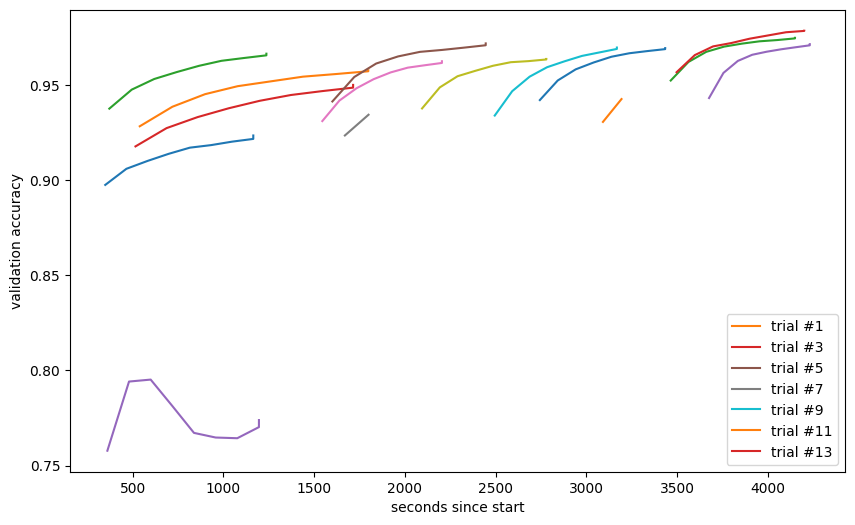

In [17]:
# wrap in try/except in case of flaky I/O issues
try:
    trials_df, curve_df = early_stopping_exp_to_df(experiment)
    plot_curves_by_wall_time(trials_df, curve_df)
except Exception as e:
    print(f"Encountered exception while plotting results: {e}")
